## Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.

## Get the Data
You'll be using two datasets in this project:

* MNIST
* CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA. Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using FloydHub, set data_dir to "/input" and use the FloydHub data ID "R5KrjnANiKVhLWAkpXhNBe".



In [2]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import tensorflow as tf
from scipy.misc import imread, imsave

import matplotlib.pyplot as plt

import sys
import os
from PIL import Image
from glob import glob

import numpy as np

In [21]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST

As you're aware, the MNIST dataset contains images of handwritten digits. You can view the first number of examples by changing show_n_images.

## CelebA
The CelebFaces Attributes Dataset (CelebA) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations. You can view the first number of examples by changing show_n_images.

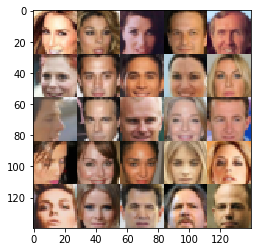

In [23]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you. The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images. The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single color channel while the CelebA images have 3 color channels (RGB color channel).

## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:

* model_inputs
* discriminator
* generator
* model_loss
* model_opt
* train

## Check the Version of TensorFlow and Access to GPU¶
This will check to make sure you have the correct version of TensorFlow and access to a GPU



In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))


TensorFlow Version: 1.5.0


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


## Input
Implement the model_inputs function to create TF Placeholders for the Neural Network. It should create the following placeholders:

* Real input images placeholder with rank 4 using image_width, image_height, and image_channels.
* Z input placeholder with rank 2 using z_dim.
* Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)



In [3]:
img_rows = 28 
img_cols = 28
channels = 3
img_shape = (img_rows, img_cols, channels)

In [4]:
optimizer = Adam(0.0002, 0.5)

## Generator
Implement generator to generate an image using z. This function should be able to reuse the variabes in the neural network. Use tf.variable_scope with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x out_channel_dim images.

In [5]:
def build_generator():

    noise_shape = (100,)

    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)

    return Model(noise, img)

## Discriminator
Implement discriminator to create a discriminator neural network that discriminates on images. This function should be able to reuse the variabes in the neural network. Use tf.variable_scope with a scope name of "discriminator" to allow the variables to be reused. The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def build_discriminator():

    img_shape = (img_rows, img_cols, channels)

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [8]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1204736   
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 1,336,321
Trainable params: 1,336,321
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Build and compile the generator
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_8 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              525312    
__________

In [10]:
# The generator takes noise as input and generated imgs
z = Input(shape=(100,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The valid takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [11]:
def get_image(image_path, width, height, mode):
    
    image = Image.open(image_path)
    # image = image.resize([width, height], Image.BILINEAR)
    if image.size != (width, height):  
    # Remove most pixels that aren't part of a face
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height])

    return np.array(image.convert(mode))

In [12]:
def get_batch(image_files, width, height, mode):
    data_batch = np.array([get_image(sample_file, width, height, mode) for sample_file in image_files])
    return data_batch

## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = (1/2.5) * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,:])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()

## Train
Implement train to build and train the GANs. Use the following functions you implemented:

* model_inputs(image_width, image_height, image_channels, z_dim)
* model_loss(input_real, input_z, out_channel_dim)
* model_opt(d_loss, g_loss, learning_rate, beta1)
Use the show_generator_output to show generator output while you train. Running show_generator_output for every batch will drastically increase training time and increase the size of the notebook. It's recommended to print the generator output every 100 batches.

In [17]:
def train(epochs, batch_size=128, save_interval=50):
        
        data_dir = 'data\img_align_celeba'
        X_train = get_batch(glob(os.path.join(data_dir, '*.jpg'))[:5000], 28, 28, 'RGB')


        #Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5


        half_batch = int(batch_size / 2)

        #Create lists for logging the losses
        d_loss_logs_r = []
        d_loss_logs_f = []
        g_loss_logs = []

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = generator.predict(noise)

            # Train the discriminator
            d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = combined.train_on_batch(noise, valid_y)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            #Append the logs with the loss values in each training step
            d_loss_logs_r.append([epoch, d_loss[0]])
            d_loss_logs_f.append([epoch, d_loss[1]])
            g_loss_logs.append([epoch, g_loss])

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                save_imgs(epoch)


            #Convert the log lists to numpy arrays
            d_loss_logs_r_a = np.array(d_loss_logs_r)
            d_loss_logs_f_a = np.array(d_loss_logs_f)
            g_loss_logs_a = np.array(g_loss_logs)

            #Generate the plot at the end of training
            if epoch % save_interval == 0:
                plt.plot(d_loss_logs_r_a[:,0], d_loss_logs_r_a[:,1], label="Discriminator Loss - Real")
                plt.plot(d_loss_logs_f_a[:,0], d_loss_logs_f_a[:,1], label="Discriminator Loss - Fake")
                plt.plot(g_loss_logs_a[:,0], g_loss_logs_a[:,1], label="Generator Loss")
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()
                plt.title('Variation of losses over epochs')
                plt.grid(True)
                plt.show() 

C:\Anaconda\lib\site-packages\keras\engine\training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.555432, acc.: 65.62%] [G loss: 1.881689]


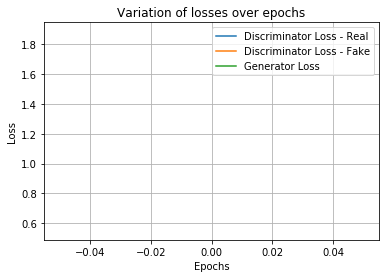

1 [D loss: 0.502410, acc.: 75.00%] [G loss: 2.350485]
2 [D loss: 0.490642, acc.: 78.12%] [G loss: 2.056975]
3 [D loss: 0.504962, acc.: 81.25%] [G loss: 2.208032]
4 [D loss: 0.259197, acc.: 90.62%] [G loss: 2.519145]
5 [D loss: 0.981823, acc.: 71.88%] [G loss: 1.874568]
6 [D loss: 0.421786, acc.: 71.88%] [G loss: 1.819222]
7 [D loss: 0.338015, acc.: 90.62%] [G loss: 2.161514]
8 [D loss: 0.496681, acc.: 75.00%] [G loss: 2.406261]
9 [D loss: 0.904987, acc.: 50.00%] [G loss: 2.667832]
10 [D loss: 1.065387, acc.: 53.12%] [G loss: 1.817872]
11 [D loss: 0.387132, acc.: 81.25%] [G loss: 1.690081]
12 [D loss: 0.395163, acc.: 87.50%] [G loss: 2.321371]
13 [D loss: 0.413782, acc.: 75.00%] [G loss: 1.752659]
14 [D loss: 0.398489, acc.: 81.25%] [G loss: 1.607335]
15 [D loss: 0.637416, acc.: 75.00%] [G loss: 1.510301]
16 [D loss: 0.771646, acc.: 68.75%] [G loss: 1.643313]
17 [D loss: 0.373900, acc.: 84.38%] [G loss: 1.708632]
18 [D loss: 0.565269, acc.: 81.25%] [G loss: 1.559343]
19 [D loss: 0.53393

150 [D loss: 0.860988, acc.: 59.38%] [G loss: 1.470525]
151 [D loss: 0.766105, acc.: 50.00%] [G loss: 1.384408]
152 [D loss: 0.744032, acc.: 50.00%] [G loss: 1.533018]
153 [D loss: 0.801721, acc.: 50.00%] [G loss: 1.411016]
154 [D loss: 0.602552, acc.: 65.62%] [G loss: 1.470781]
155 [D loss: 0.783917, acc.: 62.50%] [G loss: 1.396681]
156 [D loss: 0.693296, acc.: 43.75%] [G loss: 1.243272]
157 [D loss: 0.606670, acc.: 71.88%] [G loss: 1.163148]
158 [D loss: 0.628628, acc.: 71.88%] [G loss: 1.354030]
159 [D loss: 0.747817, acc.: 65.62%] [G loss: 1.348910]
160 [D loss: 0.742486, acc.: 53.12%] [G loss: 1.196216]
161 [D loss: 0.575134, acc.: 68.75%] [G loss: 1.178469]
162 [D loss: 0.446800, acc.: 81.25%] [G loss: 1.526475]
163 [D loss: 0.596877, acc.: 75.00%] [G loss: 1.442880]
164 [D loss: 0.653665, acc.: 62.50%] [G loss: 1.390604]
165 [D loss: 0.711864, acc.: 53.12%] [G loss: 1.170588]
166 [D loss: 0.500808, acc.: 71.88%] [G loss: 1.266357]
167 [D loss: 0.813630, acc.: 50.00%] [G loss: 1.

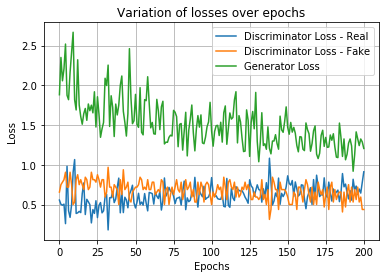

201 [D loss: 0.704897, acc.: 46.88%] [G loss: 1.007306]
202 [D loss: 0.742126, acc.: 56.25%] [G loss: 0.915672]
203 [D loss: 0.577765, acc.: 81.25%] [G loss: 0.988400]
204 [D loss: 0.621881, acc.: 62.50%] [G loss: 1.138514]
205 [D loss: 0.638792, acc.: 59.38%] [G loss: 1.238951]
206 [D loss: 0.705628, acc.: 62.50%] [G loss: 1.266676]
207 [D loss: 0.697006, acc.: 53.12%] [G loss: 1.477260]
208 [D loss: 0.652223, acc.: 62.50%] [G loss: 1.351377]
209 [D loss: 0.709302, acc.: 68.75%] [G loss: 1.244864]
210 [D loss: 0.742780, acc.: 53.12%] [G loss: 1.051716]
211 [D loss: 0.626261, acc.: 62.50%] [G loss: 1.178034]
212 [D loss: 0.687875, acc.: 59.38%] [G loss: 0.960989]
213 [D loss: 0.693825, acc.: 59.38%] [G loss: 0.944823]
214 [D loss: 0.630605, acc.: 71.88%] [G loss: 1.259703]
215 [D loss: 0.565451, acc.: 68.75%] [G loss: 1.268156]
216 [D loss: 0.727123, acc.: 59.38%] [G loss: 1.086136]
217 [D loss: 0.680221, acc.: 59.38%] [G loss: 1.059375]
218 [D loss: 0.761614, acc.: 50.00%] [G loss: 0.

348 [D loss: 0.712194, acc.: 62.50%] [G loss: 1.090221]
349 [D loss: 0.658734, acc.: 59.38%] [G loss: 1.129539]
350 [D loss: 0.680051, acc.: 56.25%] [G loss: 1.248346]
351 [D loss: 0.842211, acc.: 43.75%] [G loss: 1.143066]
352 [D loss: 0.644275, acc.: 56.25%] [G loss: 1.099837]
353 [D loss: 0.687452, acc.: 68.75%] [G loss: 0.990099]
354 [D loss: 0.800434, acc.: 40.62%] [G loss: 0.998704]
355 [D loss: 0.755496, acc.: 37.50%] [G loss: 1.022551]
356 [D loss: 0.688997, acc.: 53.12%] [G loss: 0.946432]
357 [D loss: 0.693230, acc.: 53.12%] [G loss: 0.953926]
358 [D loss: 0.854983, acc.: 53.12%] [G loss: 0.928096]
359 [D loss: 0.692487, acc.: 56.25%] [G loss: 1.004352]
360 [D loss: 0.672526, acc.: 59.38%] [G loss: 1.057286]
361 [D loss: 0.734715, acc.: 53.12%] [G loss: 1.062897]
362 [D loss: 0.656454, acc.: 59.38%] [G loss: 1.004598]
363 [D loss: 0.669600, acc.: 56.25%] [G loss: 0.997273]
364 [D loss: 0.694801, acc.: 53.12%] [G loss: 0.924313]
365 [D loss: 0.672788, acc.: 62.50%] [G loss: 0.

Exception ignored in: <bound method ScopedTFStatus.__del__ of <tensorflow.python.framework.c_api_util.ScopedTFStatus object at 0x0000025D0F2480F0>>
Traceback (most recent call last):
  File "C:\Anaconda\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 37, in __del__
    c_api.TF_DeleteStatus(self.status)
AttributeError: 'ScopedTFStatus' object has no attribute 'status'


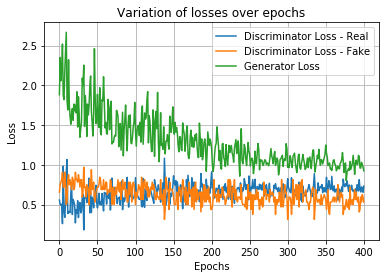

401 [D loss: 0.695009, acc.: 53.12%] [G loss: 0.887848]
402 [D loss: 0.627294, acc.: 65.62%] [G loss: 0.890127]
403 [D loss: 0.673207, acc.: 56.25%] [G loss: 1.013505]
404 [D loss: 0.629815, acc.: 68.75%] [G loss: 1.112903]
405 [D loss: 0.696591, acc.: 62.50%] [G loss: 1.062263]
406 [D loss: 0.684237, acc.: 53.12%] [G loss: 0.976684]
407 [D loss: 0.638499, acc.: 62.50%] [G loss: 1.004556]
408 [D loss: 0.703647, acc.: 50.00%] [G loss: 0.986156]
409 [D loss: 0.714055, acc.: 56.25%] [G loss: 0.992989]
410 [D loss: 0.687863, acc.: 56.25%] [G loss: 1.043502]
411 [D loss: 0.737012, acc.: 43.75%] [G loss: 1.043743]
412 [D loss: 0.573809, acc.: 71.88%] [G loss: 1.095553]
413 [D loss: 0.694297, acc.: 59.38%] [G loss: 1.013495]
414 [D loss: 0.728143, acc.: 62.50%] [G loss: 1.050196]
415 [D loss: 0.724304, acc.: 46.88%] [G loss: 1.043932]
416 [D loss: 0.727222, acc.: 50.00%] [G loss: 1.077851]
417 [D loss: 0.719217, acc.: 46.88%] [G loss: 1.033602]
418 [D loss: 0.725217, acc.: 59.38%] [G loss: 1.

549 [D loss: 0.668424, acc.: 53.12%] [G loss: 0.931978]
550 [D loss: 0.705633, acc.: 56.25%] [G loss: 0.932912]
551 [D loss: 0.806353, acc.: 34.38%] [G loss: 0.973613]
552 [D loss: 0.614076, acc.: 68.75%] [G loss: 0.891513]
553 [D loss: 0.717549, acc.: 46.88%] [G loss: 0.931029]
554 [D loss: 0.684338, acc.: 53.12%] [G loss: 0.940516]
555 [D loss: 0.674755, acc.: 53.12%] [G loss: 0.947595]
556 [D loss: 0.724938, acc.: 43.75%] [G loss: 0.968512]
557 [D loss: 0.673380, acc.: 53.12%] [G loss: 0.948818]
558 [D loss: 0.771587, acc.: 40.62%] [G loss: 0.894892]
559 [D loss: 0.738154, acc.: 46.88%] [G loss: 0.884710]
560 [D loss: 0.642085, acc.: 62.50%] [G loss: 0.852681]
561 [D loss: 0.761929, acc.: 37.50%] [G loss: 0.978532]
562 [D loss: 0.660942, acc.: 59.38%] [G loss: 0.983390]
563 [D loss: 0.739557, acc.: 46.88%] [G loss: 0.945127]
564 [D loss: 0.711700, acc.: 53.12%] [G loss: 0.986701]
565 [D loss: 0.724788, acc.: 43.75%] [G loss: 0.958958]
566 [D loss: 0.697600, acc.: 46.88%] [G loss: 0.

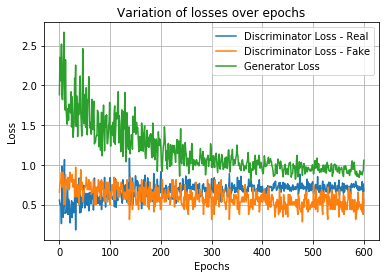

601 [D loss: 0.692988, acc.: 46.88%] [G loss: 0.902607]
602 [D loss: 0.722633, acc.: 46.88%] [G loss: 0.921039]
603 [D loss: 0.663988, acc.: 56.25%] [G loss: 0.917764]
604 [D loss: 0.830831, acc.: 28.12%] [G loss: 0.856448]
605 [D loss: 0.715882, acc.: 59.38%] [G loss: 1.008295]
606 [D loss: 0.697793, acc.: 50.00%] [G loss: 0.978659]
607 [D loss: 0.792363, acc.: 28.12%] [G loss: 0.901711]
608 [D loss: 0.746131, acc.: 40.62%] [G loss: 0.878649]
609 [D loss: 0.678695, acc.: 59.38%] [G loss: 0.820579]
610 [D loss: 0.708761, acc.: 50.00%] [G loss: 0.843523]
611 [D loss: 0.658748, acc.: 59.38%] [G loss: 0.918164]
612 [D loss: 0.717786, acc.: 50.00%] [G loss: 0.878746]
613 [D loss: 0.817082, acc.: 46.88%] [G loss: 0.828401]
614 [D loss: 0.666334, acc.: 59.38%] [G loss: 0.875799]
615 [D loss: 0.778749, acc.: 46.88%] [G loss: 0.884164]
616 [D loss: 0.674489, acc.: 68.75%] [G loss: 0.909836]
617 [D loss: 0.768059, acc.: 37.50%] [G loss: 0.966593]
618 [D loss: 0.673048, acc.: 56.25%] [G loss: 0.

749 [D loss: 0.704433, acc.: 62.50%] [G loss: 0.885901]
750 [D loss: 0.655048, acc.: 68.75%] [G loss: 0.855997]
751 [D loss: 0.659814, acc.: 56.25%] [G loss: 0.871103]
752 [D loss: 0.749495, acc.: 37.50%] [G loss: 0.897572]
753 [D loss: 0.634239, acc.: 68.75%] [G loss: 0.906584]
754 [D loss: 0.750982, acc.: 31.25%] [G loss: 0.882759]
755 [D loss: 0.661265, acc.: 68.75%] [G loss: 0.868638]
756 [D loss: 0.749046, acc.: 34.38%] [G loss: 0.872608]
757 [D loss: 0.716831, acc.: 43.75%] [G loss: 0.900861]
758 [D loss: 0.704208, acc.: 56.25%] [G loss: 0.974511]
759 [D loss: 0.734052, acc.: 50.00%] [G loss: 0.969906]
760 [D loss: 0.712276, acc.: 46.88%] [G loss: 1.001917]
761 [D loss: 0.709562, acc.: 40.62%] [G loss: 0.973822]
762 [D loss: 0.724785, acc.: 56.25%] [G loss: 0.874431]
763 [D loss: 0.722986, acc.: 40.62%] [G loss: 0.884556]
764 [D loss: 0.686934, acc.: 50.00%] [G loss: 0.903772]
765 [D loss: 0.669612, acc.: 62.50%] [G loss: 0.858303]
766 [D loss: 0.740708, acc.: 31.25%] [G loss: 0.

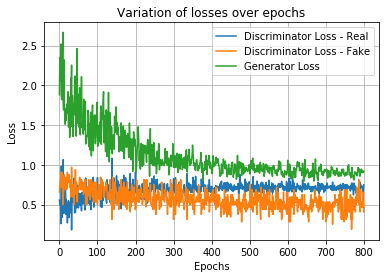

801 [D loss: 0.659991, acc.: 59.38%] [G loss: 0.925063]
802 [D loss: 0.710501, acc.: 50.00%] [G loss: 0.969803]
803 [D loss: 0.705972, acc.: 46.88%] [G loss: 0.913474]
804 [D loss: 0.738640, acc.: 40.62%] [G loss: 0.901202]
805 [D loss: 0.704172, acc.: 43.75%] [G loss: 0.992214]
806 [D loss: 0.675333, acc.: 56.25%] [G loss: 0.910843]
807 [D loss: 0.744533, acc.: 37.50%] [G loss: 0.902734]
808 [D loss: 0.625296, acc.: 75.00%] [G loss: 0.912751]
809 [D loss: 0.653793, acc.: 65.62%] [G loss: 0.870707]
810 [D loss: 0.652465, acc.: 50.00%] [G loss: 0.832139]
811 [D loss: 0.656785, acc.: 71.88%] [G loss: 0.845467]
812 [D loss: 0.725134, acc.: 37.50%] [G loss: 0.862022]
813 [D loss: 0.657932, acc.: 53.12%] [G loss: 0.966899]
814 [D loss: 0.623565, acc.: 62.50%] [G loss: 0.945033]
815 [D loss: 0.768135, acc.: 34.38%] [G loss: 0.853787]
816 [D loss: 0.632102, acc.: 68.75%] [G loss: 0.892566]
817 [D loss: 0.759773, acc.: 40.62%] [G loss: 0.871976]
818 [D loss: 0.692338, acc.: 53.12%] [G loss: 0.

949 [D loss: 0.688400, acc.: 50.00%] [G loss: 0.927024]
950 [D loss: 0.709341, acc.: 37.50%] [G loss: 0.998736]
951 [D loss: 0.682777, acc.: 46.88%] [G loss: 1.041655]
952 [D loss: 0.753691, acc.: 46.88%] [G loss: 0.936346]
953 [D loss: 0.680549, acc.: 46.88%] [G loss: 0.970333]
954 [D loss: 0.711200, acc.: 43.75%] [G loss: 0.978834]
955 [D loss: 0.744769, acc.: 34.38%] [G loss: 0.991270]
956 [D loss: 0.728563, acc.: 40.62%] [G loss: 0.919682]
957 [D loss: 0.645123, acc.: 59.38%] [G loss: 1.002469]
958 [D loss: 0.631172, acc.: 65.62%] [G loss: 0.996081]
959 [D loss: 0.767775, acc.: 59.38%] [G loss: 0.920141]
960 [D loss: 0.746563, acc.: 50.00%] [G loss: 0.856595]
961 [D loss: 0.761345, acc.: 31.25%] [G loss: 0.852965]
962 [D loss: 0.676569, acc.: 50.00%] [G loss: 0.980835]
963 [D loss: 0.773804, acc.: 31.25%] [G loss: 0.904702]
964 [D loss: 0.690855, acc.: 46.88%] [G loss: 0.845142]
965 [D loss: 0.671139, acc.: 53.12%] [G loss: 0.906822]
966 [D loss: 0.706614, acc.: 40.62%] [G loss: 0.

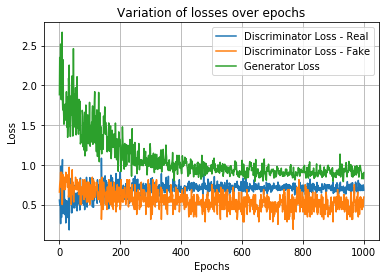

1001 [D loss: 0.650898, acc.: 68.75%] [G loss: 0.923267]
1002 [D loss: 0.727471, acc.: 56.25%] [G loss: 0.897998]
1003 [D loss: 0.709173, acc.: 62.50%] [G loss: 0.972403]
1004 [D loss: 0.716907, acc.: 43.75%] [G loss: 0.878284]
1005 [D loss: 0.669852, acc.: 53.12%] [G loss: 0.967385]
1006 [D loss: 0.668264, acc.: 56.25%] [G loss: 0.982096]
1007 [D loss: 0.768974, acc.: 43.75%] [G loss: 0.905714]
1008 [D loss: 0.651587, acc.: 50.00%] [G loss: 0.899744]
1009 [D loss: 0.717358, acc.: 53.12%] [G loss: 0.854654]
1010 [D loss: 0.733554, acc.: 40.62%] [G loss: 0.896147]
1011 [D loss: 0.696218, acc.: 50.00%] [G loss: 0.839110]
1012 [D loss: 0.727656, acc.: 50.00%] [G loss: 0.821120]
1013 [D loss: 0.719471, acc.: 43.75%] [G loss: 0.796178]
1014 [D loss: 0.739989, acc.: 43.75%] [G loss: 0.786131]
1015 [D loss: 0.663493, acc.: 59.38%] [G loss: 0.806208]
1016 [D loss: 0.755376, acc.: 43.75%] [G loss: 0.872511]
1017 [D loss: 0.683011, acc.: 56.25%] [G loss: 0.913244]
1018 [D loss: 0.656543, acc.: 6

1145 [D loss: 0.662610, acc.: 50.00%] [G loss: 0.857310]
1146 [D loss: 0.733905, acc.: 53.12%] [G loss: 0.881378]
1147 [D loss: 0.642543, acc.: 68.75%] [G loss: 0.885611]
1148 [D loss: 0.733233, acc.: 46.88%] [G loss: 0.932352]
1149 [D loss: 0.691526, acc.: 59.38%] [G loss: 0.878938]
1150 [D loss: 0.667334, acc.: 59.38%] [G loss: 0.895216]
1151 [D loss: 0.732480, acc.: 46.88%] [G loss: 0.882703]
1152 [D loss: 0.774215, acc.: 31.25%] [G loss: 0.906754]
1153 [D loss: 0.672480, acc.: 56.25%] [G loss: 0.975226]
1154 [D loss: 0.701113, acc.: 46.88%] [G loss: 0.887663]
1155 [D loss: 0.709037, acc.: 34.38%] [G loss: 0.910794]
1156 [D loss: 0.706905, acc.: 46.88%] [G loss: 0.894096]
1157 [D loss: 0.683976, acc.: 62.50%] [G loss: 0.954436]
1158 [D loss: 0.749004, acc.: 46.88%] [G loss: 0.936280]
1159 [D loss: 0.698550, acc.: 53.12%] [G loss: 0.972972]
1160 [D loss: 0.732970, acc.: 46.88%] [G loss: 0.890286]
1161 [D loss: 0.731290, acc.: 40.62%] [G loss: 0.871425]
1162 [D loss: 0.710022, acc.: 4

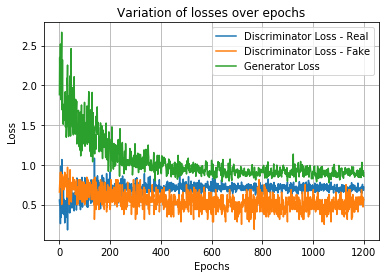

1201 [D loss: 0.614570, acc.: 81.25%] [G loss: 0.886062]
1202 [D loss: 0.674946, acc.: 37.50%] [G loss: 0.855976]
1203 [D loss: 0.706728, acc.: 50.00%] [G loss: 0.888201]
1204 [D loss: 0.685708, acc.: 59.38%] [G loss: 0.948388]
1205 [D loss: 0.711409, acc.: 40.62%] [G loss: 0.952304]
1206 [D loss: 0.711677, acc.: 43.75%] [G loss: 0.936308]
1207 [D loss: 0.759077, acc.: 31.25%] [G loss: 0.938617]
1208 [D loss: 0.661537, acc.: 46.88%] [G loss: 0.955060]
1209 [D loss: 0.743653, acc.: 46.88%] [G loss: 0.922899]
1210 [D loss: 0.672903, acc.: 46.88%] [G loss: 0.907948]
1211 [D loss: 0.701772, acc.: 43.75%] [G loss: 0.872962]
1212 [D loss: 0.719742, acc.: 46.88%] [G loss: 0.833930]
1213 [D loss: 0.715442, acc.: 37.50%] [G loss: 0.911697]
1214 [D loss: 0.778861, acc.: 25.00%] [G loss: 0.947156]
1215 [D loss: 0.638745, acc.: 53.12%] [G loss: 0.928591]
1216 [D loss: 0.735392, acc.: 37.50%] [G loss: 0.930103]
1217 [D loss: 0.654564, acc.: 59.38%] [G loss: 0.889142]
1218 [D loss: 0.700323, acc.: 5

1345 [D loss: 0.667409, acc.: 53.12%] [G loss: 0.901580]
1346 [D loss: 0.697315, acc.: 62.50%] [G loss: 0.921700]
1347 [D loss: 0.661827, acc.: 56.25%] [G loss: 0.876040]
1348 [D loss: 0.703695, acc.: 56.25%] [G loss: 0.863235]
1349 [D loss: 0.704104, acc.: 53.12%] [G loss: 0.871148]
1350 [D loss: 0.723543, acc.: 37.50%] [G loss: 0.890625]
1351 [D loss: 0.695954, acc.: 46.88%] [G loss: 0.845902]
1352 [D loss: 0.715662, acc.: 43.75%] [G loss: 0.846616]
1353 [D loss: 0.710052, acc.: 40.62%] [G loss: 0.828844]
1354 [D loss: 0.661126, acc.: 53.12%] [G loss: 0.872236]
1355 [D loss: 0.661358, acc.: 59.38%] [G loss: 0.875121]
1356 [D loss: 0.707393, acc.: 46.88%] [G loss: 0.843004]
1357 [D loss: 0.708284, acc.: 37.50%] [G loss: 0.889415]
1358 [D loss: 0.681864, acc.: 53.12%] [G loss: 0.906813]
1359 [D loss: 0.633758, acc.: 71.88%] [G loss: 0.885861]
1360 [D loss: 0.681684, acc.: 71.88%] [G loss: 0.908825]
1361 [D loss: 0.776424, acc.: 40.62%] [G loss: 0.901521]
1362 [D loss: 0.687667, acc.: 4

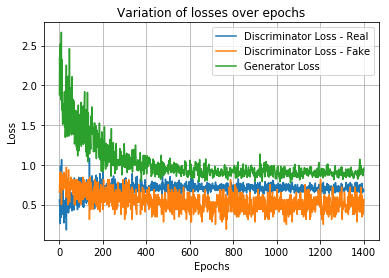

1401 [D loss: 0.753491, acc.: 40.62%] [G loss: 0.860226]
1402 [D loss: 0.744672, acc.: 40.62%] [G loss: 0.858050]
1403 [D loss: 0.696003, acc.: 50.00%] [G loss: 0.848363]
1404 [D loss: 0.701130, acc.: 46.88%] [G loss: 0.921783]
1405 [D loss: 0.655314, acc.: 56.25%] [G loss: 0.974260]
1406 [D loss: 0.727194, acc.: 43.75%] [G loss: 0.908537]
1407 [D loss: 0.653321, acc.: 65.62%] [G loss: 0.869973]
1408 [D loss: 0.671304, acc.: 59.38%] [G loss: 0.934512]
1409 [D loss: 0.649148, acc.: 65.62%] [G loss: 0.932517]
1410 [D loss: 0.654235, acc.: 59.38%] [G loss: 0.907148]
1411 [D loss: 0.679479, acc.: 43.75%] [G loss: 0.889878]
1412 [D loss: 0.709848, acc.: 53.12%] [G loss: 0.843591]
1413 [D loss: 0.746947, acc.: 50.00%] [G loss: 0.854836]
1414 [D loss: 0.672066, acc.: 56.25%] [G loss: 0.905144]
1415 [D loss: 0.686711, acc.: 56.25%] [G loss: 0.889086]
1416 [D loss: 0.665652, acc.: 71.88%] [G loss: 0.877215]
1417 [D loss: 0.675779, acc.: 40.62%] [G loss: 0.871903]
1418 [D loss: 0.650519, acc.: 6

1545 [D loss: 0.641769, acc.: 71.88%] [G loss: 0.945026]
1546 [D loss: 0.671601, acc.: 56.25%] [G loss: 0.967187]
1547 [D loss: 0.741976, acc.: 34.38%] [G loss: 0.902552]
1548 [D loss: 0.635835, acc.: 56.25%] [G loss: 0.953357]
1549 [D loss: 0.765271, acc.: 40.62%] [G loss: 0.885668]
1550 [D loss: 0.621452, acc.: 62.50%] [G loss: 0.936288]
1551 [D loss: 0.739218, acc.: 37.50%] [G loss: 0.828811]
1552 [D loss: 0.695382, acc.: 50.00%] [G loss: 0.936511]
1553 [D loss: 0.750559, acc.: 40.62%] [G loss: 0.902076]
1554 [D loss: 0.689617, acc.: 62.50%] [G loss: 0.916667]
1555 [D loss: 0.661780, acc.: 59.38%] [G loss: 0.863812]
1556 [D loss: 0.600766, acc.: 81.25%] [G loss: 0.886906]
1557 [D loss: 0.686680, acc.: 50.00%] [G loss: 0.875183]
1558 [D loss: 0.668214, acc.: 53.12%] [G loss: 0.946832]
1559 [D loss: 0.635370, acc.: 62.50%] [G loss: 0.969420]
1560 [D loss: 0.741136, acc.: 46.88%] [G loss: 0.966624]
1561 [D loss: 0.692123, acc.: 62.50%] [G loss: 1.025022]
1562 [D loss: 0.701335, acc.: 5

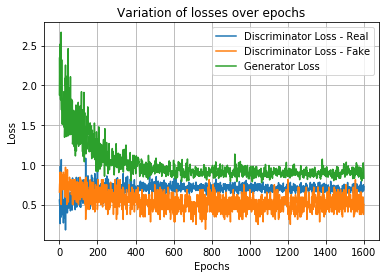

1601 [D loss: 0.680113, acc.: 56.25%] [G loss: 0.935254]
1602 [D loss: 0.663745, acc.: 53.12%] [G loss: 0.874357]
1603 [D loss: 0.732811, acc.: 50.00%] [G loss: 0.848709]
1604 [D loss: 0.671187, acc.: 56.25%] [G loss: 0.881674]
1605 [D loss: 0.692731, acc.: 43.75%] [G loss: 0.932648]
1606 [D loss: 0.656731, acc.: 46.88%] [G loss: 0.997568]
1607 [D loss: 0.692491, acc.: 50.00%] [G loss: 1.023392]
1608 [D loss: 0.737084, acc.: 53.12%] [G loss: 0.938863]
1609 [D loss: 0.713532, acc.: 40.62%] [G loss: 0.952185]
1610 [D loss: 0.631443, acc.: 59.38%] [G loss: 0.941930]
1611 [D loss: 0.655290, acc.: 56.25%] [G loss: 0.895824]
1612 [D loss: 0.731931, acc.: 37.50%] [G loss: 0.866798]
1613 [D loss: 0.755308, acc.: 46.88%] [G loss: 0.886932]
1614 [D loss: 0.669335, acc.: 53.12%] [G loss: 0.955886]
1615 [D loss: 0.671697, acc.: 53.12%] [G loss: 0.933279]
1616 [D loss: 0.726910, acc.: 40.62%] [G loss: 0.911971]
1617 [D loss: 0.699153, acc.: 53.12%] [G loss: 0.941466]
1618 [D loss: 0.689841, acc.: 5

1746 [D loss: 0.681996, acc.: 46.88%] [G loss: 0.989165]
1747 [D loss: 0.693805, acc.: 53.12%] [G loss: 0.907111]
1748 [D loss: 0.644374, acc.: 56.25%] [G loss: 0.898504]
1749 [D loss: 0.696639, acc.: 53.12%] [G loss: 0.884905]
1750 [D loss: 0.711234, acc.: 56.25%] [G loss: 0.923396]
1751 [D loss: 0.659326, acc.: 59.38%] [G loss: 0.945564]
1752 [D loss: 0.635797, acc.: 62.50%] [G loss: 0.927923]
1753 [D loss: 0.703864, acc.: 46.88%] [G loss: 0.928269]
1754 [D loss: 0.683434, acc.: 53.12%] [G loss: 0.935676]
1755 [D loss: 0.699326, acc.: 53.12%] [G loss: 0.905076]
1756 [D loss: 0.674014, acc.: 53.12%] [G loss: 1.019734]
1757 [D loss: 0.712712, acc.: 46.88%] [G loss: 0.932444]
1758 [D loss: 0.717160, acc.: 46.88%] [G loss: 0.930191]
1759 [D loss: 0.674918, acc.: 62.50%] [G loss: 0.915763]
1760 [D loss: 0.676741, acc.: 59.38%] [G loss: 0.948171]
1761 [D loss: 0.670002, acc.: 59.38%] [G loss: 1.022266]
1762 [D loss: 0.730891, acc.: 50.00%] [G loss: 0.878771]
1763 [D loss: 0.692760, acc.: 5

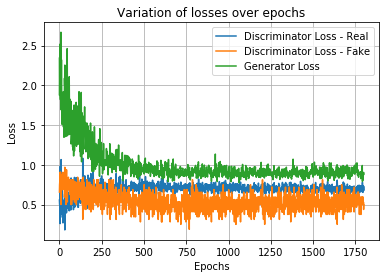

1801 [D loss: 0.660162, acc.: 59.38%] [G loss: 0.853477]
1802 [D loss: 0.592795, acc.: 71.88%] [G loss: 0.905033]
1803 [D loss: 0.673790, acc.: 59.38%] [G loss: 0.931392]
1804 [D loss: 0.672877, acc.: 59.38%] [G loss: 0.834055]
1805 [D loss: 0.862948, acc.: 34.38%] [G loss: 0.932838]
1806 [D loss: 0.690501, acc.: 59.38%] [G loss: 0.947273]
1807 [D loss: 0.716412, acc.: 46.88%] [G loss: 0.967149]
1808 [D loss: 0.742887, acc.: 40.62%] [G loss: 0.877915]
1809 [D loss: 0.719502, acc.: 56.25%] [G loss: 0.873780]
1810 [D loss: 0.663018, acc.: 56.25%] [G loss: 0.893352]
1811 [D loss: 0.706213, acc.: 50.00%] [G loss: 0.807584]
1812 [D loss: 0.715151, acc.: 37.50%] [G loss: 0.851565]
1813 [D loss: 0.681088, acc.: 56.25%] [G loss: 0.870036]
1814 [D loss: 0.661302, acc.: 68.75%] [G loss: 0.876668]
1815 [D loss: 0.647844, acc.: 62.50%] [G loss: 0.926282]
1816 [D loss: 0.706854, acc.: 50.00%] [G loss: 0.871094]
1817 [D loss: 0.691768, acc.: 50.00%] [G loss: 0.923049]
1818 [D loss: 0.653268, acc.: 5

1946 [D loss: 0.684542, acc.: 62.50%] [G loss: 0.954978]
1947 [D loss: 0.671324, acc.: 50.00%] [G loss: 0.939268]
1948 [D loss: 0.716328, acc.: 46.88%] [G loss: 0.862278]
1949 [D loss: 0.664479, acc.: 53.12%] [G loss: 0.927924]
1950 [D loss: 0.728197, acc.: 40.62%] [G loss: 0.932522]
1951 [D loss: 0.638193, acc.: 62.50%] [G loss: 1.005800]
1952 [D loss: 0.682740, acc.: 56.25%] [G loss: 0.931221]
1953 [D loss: 0.650651, acc.: 56.25%] [G loss: 0.937967]
1954 [D loss: 0.713138, acc.: 53.12%] [G loss: 0.882089]
1955 [D loss: 0.679634, acc.: 56.25%] [G loss: 0.906835]
1956 [D loss: 0.684483, acc.: 53.12%] [G loss: 0.942228]
1957 [D loss: 0.626896, acc.: 62.50%] [G loss: 0.938562]
1958 [D loss: 0.662262, acc.: 62.50%] [G loss: 1.012388]
1959 [D loss: 0.748545, acc.: 56.25%] [G loss: 1.024636]
1960 [D loss: 0.639711, acc.: 62.50%] [G loss: 0.947069]
1961 [D loss: 0.683050, acc.: 56.25%] [G loss: 0.903914]
1962 [D loss: 0.721079, acc.: 46.88%] [G loss: 0.879919]
1963 [D loss: 0.638707, acc.: 6

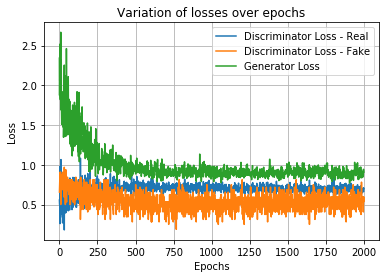

2001 [D loss: 0.669575, acc.: 53.12%] [G loss: 0.927709]
2002 [D loss: 0.651404, acc.: 62.50%] [G loss: 0.955017]
2003 [D loss: 0.689249, acc.: 50.00%] [G loss: 0.933342]
2004 [D loss: 0.774589, acc.: 40.62%] [G loss: 0.820486]
2005 [D loss: 0.686159, acc.: 43.75%] [G loss: 0.819126]
2006 [D loss: 0.706734, acc.: 68.75%] [G loss: 0.881919]
2007 [D loss: 0.691898, acc.: 46.88%] [G loss: 0.850114]
2008 [D loss: 0.656652, acc.: 59.38%] [G loss: 0.874746]
2009 [D loss: 0.705082, acc.: 65.62%] [G loss: 0.872625]
2010 [D loss: 0.727910, acc.: 50.00%] [G loss: 0.891141]
2011 [D loss: 0.643455, acc.: 68.75%] [G loss: 0.886369]
2012 [D loss: 0.695361, acc.: 43.75%] [G loss: 0.858228]
2013 [D loss: 0.752045, acc.: 34.38%] [G loss: 0.854641]
2014 [D loss: 0.681090, acc.: 56.25%] [G loss: 0.878708]
2015 [D loss: 0.748395, acc.: 46.88%] [G loss: 0.907135]
2016 [D loss: 0.699061, acc.: 46.88%] [G loss: 0.864362]
2017 [D loss: 0.696619, acc.: 53.12%] [G loss: 0.889072]
2018 [D loss: 0.665690, acc.: 5

2145 [D loss: 0.731247, acc.: 43.75%] [G loss: 0.904558]
2146 [D loss: 0.734891, acc.: 37.50%] [G loss: 0.911752]
2147 [D loss: 0.645650, acc.: 62.50%] [G loss: 0.929064]
2148 [D loss: 0.697307, acc.: 46.88%] [G loss: 0.935350]
2149 [D loss: 0.674023, acc.: 56.25%] [G loss: 0.861636]
2150 [D loss: 0.665552, acc.: 56.25%] [G loss: 0.836239]
2151 [D loss: 0.674003, acc.: 53.12%] [G loss: 0.868593]
2152 [D loss: 0.688004, acc.: 46.88%] [G loss: 0.845549]
2153 [D loss: 0.644604, acc.: 65.62%] [G loss: 0.857929]
2154 [D loss: 0.682205, acc.: 59.38%] [G loss: 0.866208]
2155 [D loss: 0.726662, acc.: 46.88%] [G loss: 0.851002]
2156 [D loss: 0.705708, acc.: 50.00%] [G loss: 0.879250]
2157 [D loss: 0.676149, acc.: 56.25%] [G loss: 0.940608]
2158 [D loss: 0.624679, acc.: 68.75%] [G loss: 0.902914]
2159 [D loss: 0.668443, acc.: 53.12%] [G loss: 0.976627]
2160 [D loss: 0.720208, acc.: 50.00%] [G loss: 0.949854]
2161 [D loss: 0.684934, acc.: 53.12%] [G loss: 0.934035]
2162 [D loss: 0.670210, acc.: 5

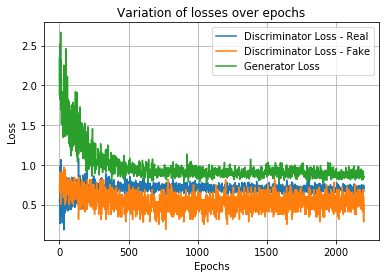

2201 [D loss: 0.642297, acc.: 65.62%] [G loss: 0.903014]
2202 [D loss: 0.671142, acc.: 43.75%] [G loss: 0.875336]
2203 [D loss: 0.648076, acc.: 59.38%] [G loss: 0.947949]
2204 [D loss: 0.666947, acc.: 56.25%] [G loss: 0.869839]
2205 [D loss: 0.675617, acc.: 56.25%] [G loss: 0.888663]
2206 [D loss: 0.701723, acc.: 46.88%] [G loss: 0.876458]
2207 [D loss: 0.633767, acc.: 68.75%] [G loss: 0.987653]
2208 [D loss: 0.779355, acc.: 40.62%] [G loss: 0.850304]
2209 [D loss: 0.743062, acc.: 37.50%] [G loss: 0.952631]
2210 [D loss: 0.715474, acc.: 37.50%] [G loss: 0.869939]
2211 [D loss: 0.706784, acc.: 40.62%] [G loss: 0.867896]
2212 [D loss: 0.672829, acc.: 50.00%] [G loss: 0.963706]
2213 [D loss: 0.655837, acc.: 62.50%] [G loss: 1.058777]
2214 [D loss: 0.669368, acc.: 68.75%] [G loss: 0.988004]
2215 [D loss: 0.640919, acc.: 62.50%] [G loss: 0.974360]
2216 [D loss: 0.743036, acc.: 43.75%] [G loss: 0.876341]
2217 [D loss: 0.709240, acc.: 37.50%] [G loss: 0.829938]
2218 [D loss: 0.647228, acc.: 6

2345 [D loss: 0.654990, acc.: 62.50%] [G loss: 0.868346]
2346 [D loss: 0.696810, acc.: 56.25%] [G loss: 0.875531]
2347 [D loss: 0.680450, acc.: 62.50%] [G loss: 0.916200]
2348 [D loss: 0.719080, acc.: 43.75%] [G loss: 0.870387]
2349 [D loss: 0.699587, acc.: 53.12%] [G loss: 0.831146]
2350 [D loss: 0.663233, acc.: 62.50%] [G loss: 0.862262]
2351 [D loss: 0.622512, acc.: 81.25%] [G loss: 0.964939]
2352 [D loss: 0.723054, acc.: 53.12%] [G loss: 0.918713]
2353 [D loss: 0.723465, acc.: 46.88%] [G loss: 0.852992]
2354 [D loss: 0.700952, acc.: 46.88%] [G loss: 0.891641]
2355 [D loss: 0.647789, acc.: 59.38%] [G loss: 0.885840]
2356 [D loss: 0.696443, acc.: 46.88%] [G loss: 0.862661]
2357 [D loss: 0.672217, acc.: 65.62%] [G loss: 0.900343]
2358 [D loss: 0.717102, acc.: 46.88%] [G loss: 0.918148]
2359 [D loss: 0.670050, acc.: 65.62%] [G loss: 0.931738]
2360 [D loss: 0.688823, acc.: 53.12%] [G loss: 0.806019]
2361 [D loss: 0.692972, acc.: 46.88%] [G loss: 0.818403]
2362 [D loss: 0.699958, acc.: 5

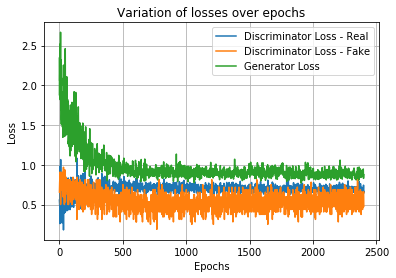

2401 [D loss: 0.699524, acc.: 46.88%] [G loss: 0.924008]
2402 [D loss: 0.691721, acc.: 56.25%] [G loss: 0.863177]
2403 [D loss: 0.711843, acc.: 50.00%] [G loss: 0.886869]
2404 [D loss: 0.654174, acc.: 68.75%] [G loss: 0.892742]
2405 [D loss: 0.694142, acc.: 46.88%] [G loss: 0.888099]
2406 [D loss: 0.656398, acc.: 56.25%] [G loss: 0.897871]
2407 [D loss: 0.680183, acc.: 50.00%] [G loss: 0.909353]
2408 [D loss: 0.711296, acc.: 46.88%] [G loss: 0.882625]
2409 [D loss: 0.685445, acc.: 53.12%] [G loss: 0.871217]
2410 [D loss: 0.647898, acc.: 65.62%] [G loss: 0.876822]
2411 [D loss: 0.730035, acc.: 34.38%] [G loss: 0.877682]
2412 [D loss: 0.703731, acc.: 46.88%] [G loss: 0.857333]
2413 [D loss: 0.685427, acc.: 56.25%] [G loss: 0.860899]
2414 [D loss: 0.682659, acc.: 53.12%] [G loss: 0.825028]
2415 [D loss: 0.686820, acc.: 56.25%] [G loss: 0.864777]
2416 [D loss: 0.667880, acc.: 59.38%] [G loss: 0.885368]
2417 [D loss: 0.670330, acc.: 65.62%] [G loss: 0.901895]
2418 [D loss: 0.708216, acc.: 4

2545 [D loss: 0.657773, acc.: 65.62%] [G loss: 0.875781]
2546 [D loss: 0.652576, acc.: 62.50%] [G loss: 0.846399]
2547 [D loss: 0.678088, acc.: 56.25%] [G loss: 0.874139]
2548 [D loss: 0.671907, acc.: 59.38%] [G loss: 0.902620]
2549 [D loss: 0.695077, acc.: 53.12%] [G loss: 0.915118]
2550 [D loss: 0.709573, acc.: 34.38%] [G loss: 0.943643]
2551 [D loss: 0.714082, acc.: 46.88%] [G loss: 0.929217]
2552 [D loss: 0.646734, acc.: 71.88%] [G loss: 0.941058]
2553 [D loss: 0.671233, acc.: 62.50%] [G loss: 0.897641]
2554 [D loss: 0.669782, acc.: 59.38%] [G loss: 0.896950]
2555 [D loss: 0.708539, acc.: 40.62%] [G loss: 0.959571]
2556 [D loss: 0.659483, acc.: 62.50%] [G loss: 1.007535]
2557 [D loss: 0.660564, acc.: 68.75%] [G loss: 1.017103]
2558 [D loss: 0.674238, acc.: 59.38%] [G loss: 0.870483]
2559 [D loss: 0.679299, acc.: 62.50%] [G loss: 0.864436]
2560 [D loss: 0.656430, acc.: 59.38%] [G loss: 0.907239]
2561 [D loss: 0.679384, acc.: 40.62%] [G loss: 0.883157]
2562 [D loss: 0.661769, acc.: 5

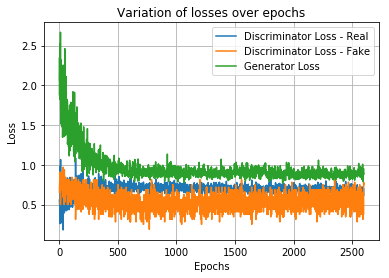

2601 [D loss: 0.681508, acc.: 56.25%] [G loss: 0.917894]
2602 [D loss: 0.640546, acc.: 59.38%] [G loss: 0.928734]
2603 [D loss: 0.710709, acc.: 46.88%] [G loss: 0.860504]
2604 [D loss: 0.679619, acc.: 53.12%] [G loss: 0.862963]
2605 [D loss: 0.677511, acc.: 59.38%] [G loss: 0.872848]
2606 [D loss: 0.648222, acc.: 62.50%] [G loss: 0.889901]
2607 [D loss: 0.638696, acc.: 65.62%] [G loss: 0.889041]
2608 [D loss: 0.700088, acc.: 59.38%] [G loss: 0.894482]
2609 [D loss: 0.687171, acc.: 46.88%] [G loss: 0.932149]
2610 [D loss: 0.668961, acc.: 56.25%] [G loss: 0.917413]
2611 [D loss: 0.654733, acc.: 59.38%] [G loss: 0.944005]
2612 [D loss: 0.751528, acc.: 46.88%] [G loss: 0.858652]
2613 [D loss: 0.646341, acc.: 65.62%] [G loss: 0.823026]
2614 [D loss: 0.689551, acc.: 46.88%] [G loss: 0.840241]
2615 [D loss: 0.699166, acc.: 59.38%] [G loss: 0.839577]
2616 [D loss: 0.708953, acc.: 59.38%] [G loss: 0.865726]
2617 [D loss: 0.653445, acc.: 71.88%] [G loss: 0.862184]
2618 [D loss: 0.688446, acc.: 6

2746 [D loss: 0.762597, acc.: 40.62%] [G loss: 0.899480]
2747 [D loss: 0.670636, acc.: 46.88%] [G loss: 0.828678]
2748 [D loss: 0.670757, acc.: 68.75%] [G loss: 0.848702]
2749 [D loss: 0.666121, acc.: 62.50%] [G loss: 0.783262]
2750 [D loss: 0.657991, acc.: 65.62%] [G loss: 0.886249]
2751 [D loss: 0.654308, acc.: 56.25%] [G loss: 0.848387]
2752 [D loss: 0.630112, acc.: 62.50%] [G loss: 0.962635]
2753 [D loss: 0.648583, acc.: 59.38%] [G loss: 0.875558]
2754 [D loss: 0.701583, acc.: 53.12%] [G loss: 0.892411]
2755 [D loss: 0.645636, acc.: 62.50%] [G loss: 0.898023]
2756 [D loss: 0.698701, acc.: 59.38%] [G loss: 0.933527]
2757 [D loss: 0.693334, acc.: 53.12%] [G loss: 0.872624]
2758 [D loss: 0.735560, acc.: 43.75%] [G loss: 0.850766]
2759 [D loss: 0.678478, acc.: 59.38%] [G loss: 0.915567]
2760 [D loss: 0.702432, acc.: 50.00%] [G loss: 0.896792]
2761 [D loss: 0.712648, acc.: 59.38%] [G loss: 0.890415]
2762 [D loss: 0.650815, acc.: 62.50%] [G loss: 0.915944]
2763 [D loss: 0.644483, acc.: 6

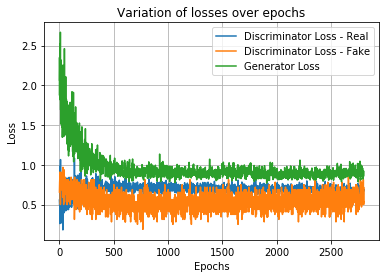

2801 [D loss: 0.626045, acc.: 78.12%] [G loss: 0.926104]
2802 [D loss: 0.696826, acc.: 43.75%] [G loss: 0.837383]
2803 [D loss: 0.649915, acc.: 53.12%] [G loss: 0.898777]
2804 [D loss: 0.669972, acc.: 62.50%] [G loss: 0.876182]
2805 [D loss: 0.650032, acc.: 65.62%] [G loss: 0.954077]
2806 [D loss: 0.635351, acc.: 75.00%] [G loss: 0.968125]
2807 [D loss: 0.677821, acc.: 56.25%] [G loss: 0.916657]
2808 [D loss: 0.641398, acc.: 71.88%] [G loss: 0.836711]
2809 [D loss: 0.653472, acc.: 62.50%] [G loss: 0.897318]
2810 [D loss: 0.615564, acc.: 75.00%] [G loss: 0.935873]
2811 [D loss: 0.645224, acc.: 68.75%] [G loss: 0.961447]
2812 [D loss: 0.619852, acc.: 78.12%] [G loss: 0.985837]
2813 [D loss: 0.677462, acc.: 59.38%] [G loss: 0.923925]
2814 [D loss: 0.642588, acc.: 71.88%] [G loss: 0.939543]
2815 [D loss: 0.625267, acc.: 65.62%] [G loss: 1.038487]
2816 [D loss: 0.685646, acc.: 50.00%] [G loss: 0.921208]
2817 [D loss: 0.595823, acc.: 68.75%] [G loss: 1.085367]
2818 [D loss: 0.648135, acc.: 5

2946 [D loss: 0.583446, acc.: 75.00%] [G loss: 1.100870]
2947 [D loss: 0.662396, acc.: 56.25%] [G loss: 1.132648]
2948 [D loss: 0.622486, acc.: 59.38%] [G loss: 1.160053]
2949 [D loss: 0.598068, acc.: 68.75%] [G loss: 1.265668]
2950 [D loss: 0.724214, acc.: 53.12%] [G loss: 1.083968]
2951 [D loss: 0.566527, acc.: 75.00%] [G loss: 1.110662]
2952 [D loss: 0.650908, acc.: 62.50%] [G loss: 0.973333]
2953 [D loss: 0.601426, acc.: 65.62%] [G loss: 0.975907]
2954 [D loss: 0.672341, acc.: 50.00%] [G loss: 0.942634]
2955 [D loss: 0.588576, acc.: 81.25%] [G loss: 1.065996]
2956 [D loss: 0.616043, acc.: 62.50%] [G loss: 1.061637]
2957 [D loss: 0.626110, acc.: 71.88%] [G loss: 1.003060]
2958 [D loss: 0.626990, acc.: 65.62%] [G loss: 1.039872]
2959 [D loss: 0.639938, acc.: 56.25%] [G loss: 1.233754]
2960 [D loss: 0.683396, acc.: 53.12%] [G loss: 1.255381]
2961 [D loss: 0.650938, acc.: 62.50%] [G loss: 1.014067]
2962 [D loss: 0.616832, acc.: 65.62%] [G loss: 1.009807]
2963 [D loss: 0.606315, acc.: 6

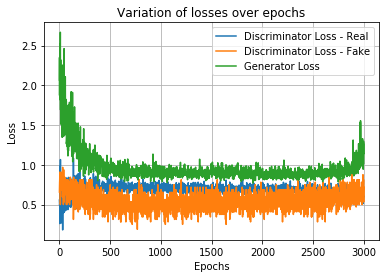

3001 [D loss: 0.558172, acc.: 78.12%] [G loss: 1.128439]
3002 [D loss: 0.568534, acc.: 78.12%] [G loss: 1.118480]
3003 [D loss: 0.571832, acc.: 68.75%] [G loss: 1.198770]
3004 [D loss: 0.622311, acc.: 59.38%] [G loss: 1.197394]
3005 [D loss: 0.580874, acc.: 75.00%] [G loss: 1.250734]
3006 [D loss: 0.510912, acc.: 84.38%] [G loss: 1.446005]
3007 [D loss: 0.599635, acc.: 71.88%] [G loss: 1.319319]
3008 [D loss: 0.571120, acc.: 84.38%] [G loss: 1.117796]
3009 [D loss: 0.549765, acc.: 78.12%] [G loss: 1.371617]
3010 [D loss: 0.502618, acc.: 68.75%] [G loss: 1.871959]
3011 [D loss: 0.554160, acc.: 78.12%] [G loss: 1.351394]
3012 [D loss: 0.585813, acc.: 62.50%] [G loss: 1.030287]
3013 [D loss: 0.609372, acc.: 75.00%] [G loss: 1.076067]
3014 [D loss: 0.560275, acc.: 71.88%] [G loss: 1.112773]
3015 [D loss: 0.594204, acc.: 75.00%] [G loss: 1.070466]
3016 [D loss: 0.579886, acc.: 65.62%] [G loss: 1.335613]
3017 [D loss: 0.579387, acc.: 78.12%] [G loss: 1.103796]
3018 [D loss: 0.560211, acc.: 7

3145 [D loss: 0.528642, acc.: 78.12%] [G loss: 1.227719]
3146 [D loss: 0.581033, acc.: 68.75%] [G loss: 1.573050]
3147 [D loss: 0.625596, acc.: 59.38%] [G loss: 1.226460]
3148 [D loss: 0.557884, acc.: 78.12%] [G loss: 1.122230]
3149 [D loss: 0.553267, acc.: 78.12%] [G loss: 1.409669]
3150 [D loss: 0.580335, acc.: 71.88%] [G loss: 1.276060]
3151 [D loss: 0.528305, acc.: 81.25%] [G loss: 1.293239]
3152 [D loss: 0.650471, acc.: 59.38%] [G loss: 1.674834]
3153 [D loss: 0.512016, acc.: 75.00%] [G loss: 1.402613]
3154 [D loss: 0.625188, acc.: 78.12%] [G loss: 1.324388]
3155 [D loss: 0.538470, acc.: 78.12%] [G loss: 1.701451]
3156 [D loss: 0.522865, acc.: 78.12%] [G loss: 1.369807]
3157 [D loss: 0.504219, acc.: 75.00%] [G loss: 1.453665]
3158 [D loss: 0.474844, acc.: 78.12%] [G loss: 1.454989]
3159 [D loss: 0.500171, acc.: 81.25%] [G loss: 1.561406]
3160 [D loss: 0.480695, acc.: 71.88%] [G loss: 1.524704]
3161 [D loss: 0.402086, acc.: 96.88%] [G loss: 1.460694]
3162 [D loss: 0.534069, acc.: 7

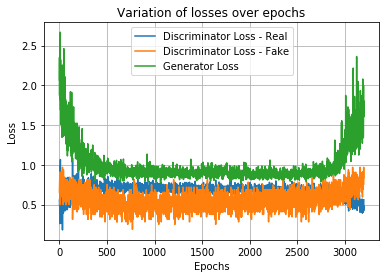

3201 [D loss: 0.457727, acc.: 93.75%] [G loss: 1.584740]
3202 [D loss: 0.497626, acc.: 78.12%] [G loss: 1.986623]
3203 [D loss: 0.447517, acc.: 84.38%] [G loss: 2.254853]
3204 [D loss: 0.481937, acc.: 81.25%] [G loss: 2.171219]
3205 [D loss: 0.506427, acc.: 75.00%] [G loss: 1.822080]
3206 [D loss: 0.540227, acc.: 78.12%] [G loss: 1.294603]
3207 [D loss: 0.484440, acc.: 87.50%] [G loss: 1.484210]
3208 [D loss: 0.484726, acc.: 75.00%] [G loss: 1.968512]
3209 [D loss: 0.608854, acc.: 71.88%] [G loss: 1.609725]
3210 [D loss: 0.568578, acc.: 75.00%] [G loss: 1.803435]
3211 [D loss: 0.585100, acc.: 65.62%] [G loss: 1.988833]
3212 [D loss: 0.455975, acc.: 96.88%] [G loss: 1.321094]
3213 [D loss: 0.491453, acc.: 84.38%] [G loss: 1.437533]
3214 [D loss: 0.448195, acc.: 87.50%] [G loss: 1.780587]
3215 [D loss: 0.567366, acc.: 71.88%] [G loss: 1.312979]
3216 [D loss: 0.535650, acc.: 75.00%] [G loss: 1.599926]
3217 [D loss: 0.481694, acc.: 81.25%] [G loss: 1.973912]
3218 [D loss: 0.475355, acc.: 8

3345 [D loss: 0.484132, acc.: 84.38%] [G loss: 1.781311]
3346 [D loss: 0.481157, acc.: 81.25%] [G loss: 1.902071]
3347 [D loss: 0.479401, acc.: 78.12%] [G loss: 1.789610]
3348 [D loss: 0.457402, acc.: 78.12%] [G loss: 2.059396]
3349 [D loss: 0.422587, acc.: 93.75%] [G loss: 1.960453]
3350 [D loss: 0.504526, acc.: 68.75%] [G loss: 1.716964]
3351 [D loss: 0.417994, acc.: 81.25%] [G loss: 1.973069]
3352 [D loss: 0.448192, acc.: 87.50%] [G loss: 1.826082]
3353 [D loss: 0.482757, acc.: 81.25%] [G loss: 1.649261]
3354 [D loss: 0.477791, acc.: 81.25%] [G loss: 2.302411]
3355 [D loss: 0.751619, acc.: 53.12%] [G loss: 2.024223]
3356 [D loss: 0.464352, acc.: 87.50%] [G loss: 1.799091]
3357 [D loss: 0.481482, acc.: 84.38%] [G loss: 1.524285]
3358 [D loss: 0.432034, acc.: 90.62%] [G loss: 2.279458]
3359 [D loss: 0.497393, acc.: 81.25%] [G loss: 1.780352]
3360 [D loss: 0.391000, acc.: 93.75%] [G loss: 2.201247]
3361 [D loss: 0.419982, acc.: 90.62%] [G loss: 1.591546]
3362 [D loss: 0.440471, acc.: 8

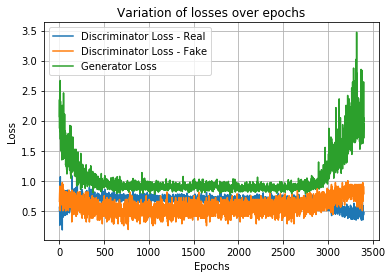

3401 [D loss: 0.409137, acc.: 90.62%] [G loss: 1.725998]
3402 [D loss: 0.390074, acc.: 87.50%] [G loss: 1.750972]
3403 [D loss: 0.520403, acc.: 75.00%] [G loss: 1.914727]
3404 [D loss: 0.490907, acc.: 78.12%] [G loss: 1.715430]
3405 [D loss: 0.457604, acc.: 90.62%] [G loss: 2.070941]
3406 [D loss: 0.472990, acc.: 90.62%] [G loss: 1.755147]
3407 [D loss: 0.412017, acc.: 87.50%] [G loss: 1.703380]
3408 [D loss: 0.547292, acc.: 75.00%] [G loss: 1.704465]
3409 [D loss: 0.401429, acc.: 84.38%] [G loss: 1.544259]
3410 [D loss: 0.421141, acc.: 87.50%] [G loss: 2.081807]
3411 [D loss: 0.448914, acc.: 81.25%] [G loss: 1.731588]
3412 [D loss: 0.562899, acc.: 65.62%] [G loss: 2.303255]
3413 [D loss: 0.471865, acc.: 84.38%] [G loss: 1.825428]
3414 [D loss: 0.412772, acc.: 87.50%] [G loss: 2.300572]
3415 [D loss: 0.508327, acc.: 81.25%] [G loss: 2.103277]
3416 [D loss: 0.421611, acc.: 84.38%] [G loss: 2.311394]
3417 [D loss: 0.529342, acc.: 71.88%] [G loss: 2.194081]
3418 [D loss: 0.579874, acc.: 6

3545 [D loss: 0.343332, acc.: 93.75%] [G loss: 1.851331]
3546 [D loss: 0.459940, acc.: 78.12%] [G loss: 2.491220]
3547 [D loss: 0.448894, acc.: 84.38%] [G loss: 2.534446]
3548 [D loss: 0.396940, acc.: 90.62%] [G loss: 1.901252]
3549 [D loss: 0.355898, acc.: 93.75%] [G loss: 2.079063]
3550 [D loss: 0.404222, acc.: 81.25%] [G loss: 1.968781]
3551 [D loss: 0.463620, acc.: 78.12%] [G loss: 2.311925]
3552 [D loss: 0.491223, acc.: 71.88%] [G loss: 2.563394]
3553 [D loss: 0.547784, acc.: 71.88%] [G loss: 1.732717]
3554 [D loss: 0.347120, acc.: 96.88%] [G loss: 2.233508]
3555 [D loss: 0.376363, acc.: 87.50%] [G loss: 2.481186]
3556 [D loss: 0.474078, acc.: 75.00%] [G loss: 2.178078]
3557 [D loss: 0.478852, acc.: 84.38%] [G loss: 2.706732]
3558 [D loss: 0.391829, acc.: 87.50%] [G loss: 1.888777]
3559 [D loss: 0.453192, acc.: 75.00%] [G loss: 2.144452]
3560 [D loss: 0.440201, acc.: 81.25%] [G loss: 2.327461]
3561 [D loss: 0.552313, acc.: 75.00%] [G loss: 1.974583]
3562 [D loss: 0.441244, acc.: 8

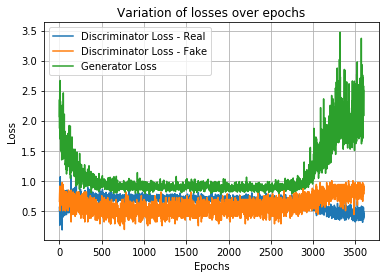

3601 [D loss: 0.378870, acc.: 90.62%] [G loss: 2.042268]
3602 [D loss: 0.348612, acc.: 90.62%] [G loss: 1.913581]
3603 [D loss: 0.546095, acc.: 68.75%] [G loss: 1.946495]
3604 [D loss: 0.442155, acc.: 81.25%] [G loss: 1.956193]
3605 [D loss: 0.466577, acc.: 75.00%] [G loss: 2.388005]
3606 [D loss: 0.480338, acc.: 75.00%] [G loss: 1.861231]
3607 [D loss: 0.419556, acc.: 93.75%] [G loss: 2.385969]
3608 [D loss: 0.350593, acc.: 90.62%] [G loss: 2.359994]
3609 [D loss: 0.455204, acc.: 87.50%] [G loss: 2.543736]
3610 [D loss: 0.399338, acc.: 87.50%] [G loss: 2.478996]
3611 [D loss: 0.356868, acc.: 96.88%] [G loss: 1.959337]
3612 [D loss: 0.530424, acc.: 71.88%] [G loss: 2.797434]
3613 [D loss: 0.532013, acc.: 84.38%] [G loss: 2.065817]
3614 [D loss: 0.521502, acc.: 75.00%] [G loss: 1.781639]
3615 [D loss: 0.392469, acc.: 87.50%] [G loss: 1.981796]
3616 [D loss: 0.404799, acc.: 87.50%] [G loss: 2.017618]
3617 [D loss: 0.376889, acc.: 90.62%] [G loss: 2.193586]
3618 [D loss: 0.391580, acc.: 8

3745 [D loss: 0.423068, acc.: 78.12%] [G loss: 1.840608]
3746 [D loss: 0.317770, acc.: 87.50%] [G loss: 2.020951]
3747 [D loss: 0.386302, acc.: 87.50%] [G loss: 2.133119]
3748 [D loss: 0.453869, acc.: 75.00%] [G loss: 2.648194]
3749 [D loss: 0.339993, acc.: 87.50%] [G loss: 2.145303]
3750 [D loss: 0.471014, acc.: 84.38%] [G loss: 2.086365]
3751 [D loss: 0.420840, acc.: 81.25%] [G loss: 2.636232]
3752 [D loss: 0.348828, acc.: 90.62%] [G loss: 1.911262]
3753 [D loss: 0.566155, acc.: 71.88%] [G loss: 2.794008]
3754 [D loss: 0.347368, acc.: 93.75%] [G loss: 2.605087]
3755 [D loss: 0.441849, acc.: 84.38%] [G loss: 3.283367]
3756 [D loss: 0.409595, acc.: 81.25%] [G loss: 3.506140]
3757 [D loss: 0.349055, acc.: 84.38%] [G loss: 2.535186]
3758 [D loss: 0.331219, acc.: 90.62%] [G loss: 2.608296]
3759 [D loss: 0.396896, acc.: 84.38%] [G loss: 1.917277]
3760 [D loss: 0.416218, acc.: 84.38%] [G loss: 2.688716]
3761 [D loss: 0.272190, acc.: 96.88%] [G loss: 2.056613]
3762 [D loss: 0.466004, acc.: 8

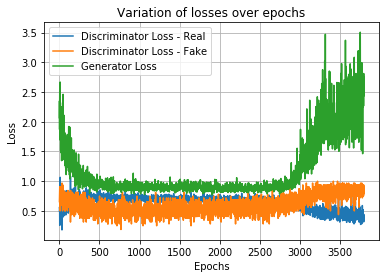

3801 [D loss: 0.351362, acc.: 81.25%] [G loss: 1.715871]
3802 [D loss: 0.380146, acc.: 87.50%] [G loss: 2.038413]
3803 [D loss: 0.457750, acc.: 81.25%] [G loss: 2.764984]
3804 [D loss: 0.380456, acc.: 81.25%] [G loss: 2.597496]
3805 [D loss: 0.358727, acc.: 87.50%] [G loss: 2.798554]
3806 [D loss: 0.368162, acc.: 90.62%] [G loss: 2.993729]
3807 [D loss: 0.449185, acc.: 71.88%] [G loss: 2.117280]
3808 [D loss: 0.358871, acc.: 93.75%] [G loss: 2.214582]
3809 [D loss: 0.328843, acc.: 93.75%] [G loss: 2.386190]
3810 [D loss: 0.337662, acc.: 87.50%] [G loss: 1.975027]
3811 [D loss: 0.342918, acc.: 87.50%] [G loss: 2.709611]
3812 [D loss: 0.401745, acc.: 87.50%] [G loss: 2.278906]
3813 [D loss: 0.356959, acc.: 93.75%] [G loss: 2.982048]
3814 [D loss: 0.395961, acc.: 84.38%] [G loss: 2.611620]
3815 [D loss: 0.541376, acc.: 75.00%] [G loss: 2.245262]
3816 [D loss: 0.388823, acc.: 84.38%] [G loss: 3.181259]
3817 [D loss: 0.573528, acc.: 62.50%] [G loss: 2.545374]
3818 [D loss: 0.520048, acc.: 7

3945 [D loss: 0.346813, acc.: 90.62%] [G loss: 2.267921]
3946 [D loss: 0.242999, acc.: 96.88%] [G loss: 2.036911]
3947 [D loss: 0.449483, acc.: 71.88%] [G loss: 2.577110]
3948 [D loss: 0.321486, acc.: 93.75%] [G loss: 2.460674]
3949 [D loss: 0.378221, acc.: 84.38%] [G loss: 2.413713]
3950 [D loss: 0.587472, acc.: 65.62%] [G loss: 1.924709]
3951 [D loss: 0.419884, acc.: 84.38%] [G loss: 2.167482]
3952 [D loss: 0.294324, acc.: 93.75%] [G loss: 2.258441]
3953 [D loss: 0.387541, acc.: 87.50%] [G loss: 2.808585]
3954 [D loss: 0.439040, acc.: 81.25%] [G loss: 2.686898]
3955 [D loss: 0.329352, acc.: 90.62%] [G loss: 2.377467]
3956 [D loss: 0.548298, acc.: 71.88%] [G loss: 2.614866]
3957 [D loss: 0.471093, acc.: 87.50%] [G loss: 2.400881]
3958 [D loss: 0.369852, acc.: 84.38%] [G loss: 1.948497]
3959 [D loss: 0.368278, acc.: 87.50%] [G loss: 2.197662]
3960 [D loss: 0.637362, acc.: 53.12%] [G loss: 2.163527]
3961 [D loss: 0.554541, acc.: 65.62%] [G loss: 2.373388]
3962 [D loss: 0.327512, acc.: 9

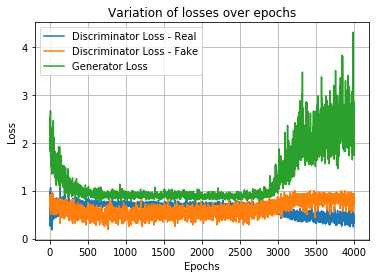

4001 [D loss: 0.295627, acc.: 87.50%] [G loss: 2.358505]
4002 [D loss: 0.355839, acc.: 90.62%] [G loss: 2.945409]
4003 [D loss: 0.511068, acc.: 78.12%] [G loss: 2.050436]
4004 [D loss: 0.465989, acc.: 78.12%] [G loss: 2.987082]
4005 [D loss: 0.380358, acc.: 78.12%] [G loss: 2.998243]
4006 [D loss: 0.455634, acc.: 81.25%] [G loss: 1.764939]
4007 [D loss: 0.403356, acc.: 81.25%] [G loss: 2.652895]
4008 [D loss: 0.401351, acc.: 84.38%] [G loss: 2.461597]
4009 [D loss: 0.540935, acc.: 68.75%] [G loss: 2.442454]
4010 [D loss: 0.308868, acc.: 96.88%] [G loss: 2.452445]
4011 [D loss: 0.400787, acc.: 84.38%] [G loss: 2.030739]
4012 [D loss: 0.409720, acc.: 78.12%] [G loss: 2.192525]
4013 [D loss: 0.420827, acc.: 81.25%] [G loss: 2.964518]
4014 [D loss: 0.321152, acc.: 90.62%] [G loss: 2.170541]
4015 [D loss: 0.377358, acc.: 81.25%] [G loss: 2.679084]
4016 [D loss: 0.358917, acc.: 84.38%] [G loss: 1.873492]
4017 [D loss: 0.363288, acc.: 84.38%] [G loss: 2.578561]
4018 [D loss: 0.458197, acc.: 7

4146 [D loss: 0.327833, acc.: 87.50%] [G loss: 1.982486]
4147 [D loss: 0.297284, acc.: 87.50%] [G loss: 2.034689]
4148 [D loss: 0.528012, acc.: 81.25%] [G loss: 2.224529]
4149 [D loss: 0.320114, acc.: 93.75%] [G loss: 2.708165]
4150 [D loss: 0.369134, acc.: 87.50%] [G loss: 2.937366]
4151 [D loss: 0.417844, acc.: 75.00%] [G loss: 3.225497]
4152 [D loss: 0.281865, acc.: 90.62%] [G loss: 3.118243]
4153 [D loss: 0.498268, acc.: 78.12%] [G loss: 3.037581]
4154 [D loss: 0.508407, acc.: 78.12%] [G loss: 2.648591]
4155 [D loss: 0.387306, acc.: 84.38%] [G loss: 2.210549]
4156 [D loss: 0.341838, acc.: 90.62%] [G loss: 1.854707]
4157 [D loss: 0.381572, acc.: 87.50%] [G loss: 2.659115]
4158 [D loss: 0.483555, acc.: 75.00%] [G loss: 2.525718]
4159 [D loss: 0.421915, acc.: 87.50%] [G loss: 2.081879]
4160 [D loss: 0.417374, acc.: 78.12%] [G loss: 2.720004]
4161 [D loss: 0.337081, acc.: 90.62%] [G loss: 3.042659]
4162 [D loss: 0.404182, acc.: 81.25%] [G loss: 2.082611]
4163 [D loss: 0.366079, acc.: 8

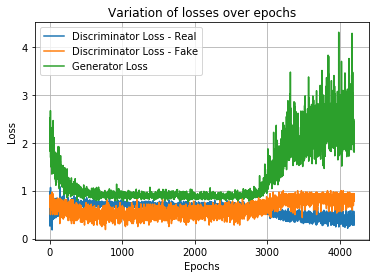

4201 [D loss: 0.358697, acc.: 87.50%] [G loss: 2.234762]
4202 [D loss: 0.416842, acc.: 81.25%] [G loss: 2.538664]
4203 [D loss: 0.443584, acc.: 78.12%] [G loss: 2.834073]
4204 [D loss: 0.332488, acc.: 87.50%] [G loss: 2.979406]
4205 [D loss: 0.425727, acc.: 84.38%] [G loss: 2.608209]
4206 [D loss: 0.439429, acc.: 81.25%] [G loss: 1.883718]
4207 [D loss: 0.345555, acc.: 84.38%] [G loss: 2.445836]
4208 [D loss: 0.575898, acc.: 81.25%] [G loss: 2.201422]
4209 [D loss: 0.462753, acc.: 75.00%] [G loss: 2.460666]
4210 [D loss: 0.623710, acc.: 71.88%] [G loss: 2.645119]
4211 [D loss: 0.424686, acc.: 84.38%] [G loss: 2.639922]
4212 [D loss: 0.341806, acc.: 93.75%] [G loss: 2.707691]
4213 [D loss: 0.302007, acc.: 96.88%] [G loss: 2.951845]
4214 [D loss: 0.406788, acc.: 84.38%] [G loss: 3.542058]
4215 [D loss: 0.512650, acc.: 71.88%] [G loss: 2.407590]
4216 [D loss: 0.296753, acc.: 93.75%] [G loss: 2.530080]
4217 [D loss: 0.379727, acc.: 81.25%] [G loss: 2.496548]
4218 [D loss: 0.349105, acc.: 8

4345 [D loss: 0.459795, acc.: 78.12%] [G loss: 2.816090]
4346 [D loss: 0.406538, acc.: 90.62%] [G loss: 2.427501]
4347 [D loss: 0.407330, acc.: 84.38%] [G loss: 2.103271]
4348 [D loss: 0.262440, acc.: 96.88%] [G loss: 2.618828]
4349 [D loss: 0.446847, acc.: 78.12%] [G loss: 2.529950]
4350 [D loss: 0.402728, acc.: 81.25%] [G loss: 2.098199]
4351 [D loss: 0.327484, acc.: 93.75%] [G loss: 2.869808]
4352 [D loss: 0.410607, acc.: 87.50%] [G loss: 2.478844]
4353 [D loss: 0.381869, acc.: 81.25%] [G loss: 2.838786]
4354 [D loss: 0.457357, acc.: 78.12%] [G loss: 2.353101]
4355 [D loss: 0.415379, acc.: 81.25%] [G loss: 2.669642]
4356 [D loss: 0.227548, acc.: 100.00%] [G loss: 2.467900]
4357 [D loss: 0.397619, acc.: 84.38%] [G loss: 1.991169]
4358 [D loss: 0.499723, acc.: 68.75%] [G loss: 2.906471]
4359 [D loss: 0.288180, acc.: 93.75%] [G loss: 2.371617]
4360 [D loss: 0.397730, acc.: 81.25%] [G loss: 2.830896]
4361 [D loss: 0.350012, acc.: 90.62%] [G loss: 2.205439]
4362 [D loss: 0.380295, acc.: 

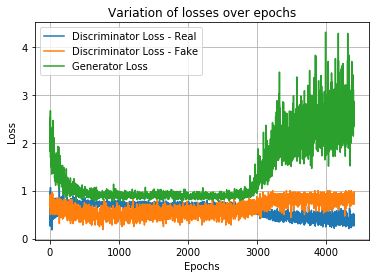

4401 [D loss: 0.329393, acc.: 90.62%] [G loss: 3.483591]
4402 [D loss: 0.474487, acc.: 81.25%] [G loss: 2.440707]
4403 [D loss: 0.501608, acc.: 78.12%] [G loss: 2.418861]
4404 [D loss: 0.291847, acc.: 84.38%] [G loss: 2.556295]
4405 [D loss: 0.447718, acc.: 75.00%] [G loss: 2.595994]
4406 [D loss: 0.516625, acc.: 75.00%] [G loss: 1.834556]
4407 [D loss: 0.355871, acc.: 90.62%] [G loss: 2.796249]
4408 [D loss: 0.319779, acc.: 96.88%] [G loss: 2.870458]
4409 [D loss: 0.411045, acc.: 81.25%] [G loss: 2.245391]
4410 [D loss: 0.288839, acc.: 96.88%] [G loss: 2.931142]
4411 [D loss: 0.295698, acc.: 93.75%] [G loss: 2.084707]
4412 [D loss: 0.344027, acc.: 90.62%] [G loss: 2.998239]
4413 [D loss: 0.309191, acc.: 81.25%] [G loss: 2.898654]
4414 [D loss: 0.268180, acc.: 96.88%] [G loss: 2.614456]
4415 [D loss: 0.344455, acc.: 87.50%] [G loss: 2.610294]
4416 [D loss: 0.392583, acc.: 81.25%] [G loss: 2.267382]
4417 [D loss: 0.254419, acc.: 90.62%] [G loss: 2.862980]
4418 [D loss: 0.296891, acc.: 9

4545 [D loss: 0.542531, acc.: 68.75%] [G loss: 2.649561]
4546 [D loss: 0.345925, acc.: 87.50%] [G loss: 2.728967]
4547 [D loss: 0.300738, acc.: 90.62%] [G loss: 2.634329]
4548 [D loss: 0.412272, acc.: 84.38%] [G loss: 2.433136]
4549 [D loss: 0.357394, acc.: 93.75%] [G loss: 2.378349]
4550 [D loss: 0.360381, acc.: 87.50%] [G loss: 2.269593]
4551 [D loss: 0.357180, acc.: 90.62%] [G loss: 3.037054]
4552 [D loss: 0.330496, acc.: 84.38%] [G loss: 2.439272]
4553 [D loss: 0.461228, acc.: 78.12%] [G loss: 2.108035]
4554 [D loss: 0.312652, acc.: 90.62%] [G loss: 2.797734]
4555 [D loss: 0.373806, acc.: 87.50%] [G loss: 2.365467]
4556 [D loss: 0.507652, acc.: 75.00%] [G loss: 2.338475]
4557 [D loss: 0.445694, acc.: 78.12%] [G loss: 2.685965]
4558 [D loss: 0.313621, acc.: 90.62%] [G loss: 1.912257]
4559 [D loss: 0.346044, acc.: 81.25%] [G loss: 2.396614]
4560 [D loss: 0.286165, acc.: 93.75%] [G loss: 2.690015]
4561 [D loss: 0.376896, acc.: 81.25%] [G loss: 3.073752]
4562 [D loss: 0.436827, acc.: 8

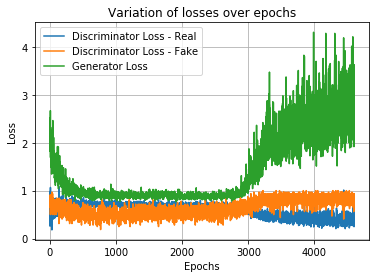

4601 [D loss: 0.282163, acc.: 90.62%] [G loss: 1.897009]
4602 [D loss: 0.469670, acc.: 71.88%] [G loss: 2.595620]
4603 [D loss: 0.319592, acc.: 90.62%] [G loss: 2.869440]
4604 [D loss: 0.317458, acc.: 93.75%] [G loss: 2.730163]
4605 [D loss: 0.336038, acc.: 87.50%] [G loss: 3.348959]
4606 [D loss: 0.334149, acc.: 87.50%] [G loss: 2.145988]
4607 [D loss: 0.316073, acc.: 87.50%] [G loss: 2.939908]
4608 [D loss: 0.362458, acc.: 87.50%] [G loss: 2.596252]
4609 [D loss: 0.382501, acc.: 87.50%] [G loss: 2.809257]
4610 [D loss: 0.557286, acc.: 75.00%] [G loss: 2.734101]
4611 [D loss: 0.317918, acc.: 87.50%] [G loss: 3.290648]
4612 [D loss: 0.339563, acc.: 93.75%] [G loss: 2.763029]
4613 [D loss: 0.407690, acc.: 78.12%] [G loss: 3.050936]
4614 [D loss: 0.494578, acc.: 78.12%] [G loss: 2.191670]
4615 [D loss: 0.687199, acc.: 56.25%] [G loss: 2.598938]
4616 [D loss: 0.329162, acc.: 93.75%] [G loss: 2.522840]
4617 [D loss: 0.350750, acc.: 78.12%] [G loss: 2.062776]
4618 [D loss: 0.446193, acc.: 7

4745 [D loss: 0.314180, acc.: 90.62%] [G loss: 3.141812]
4746 [D loss: 0.327592, acc.: 87.50%] [G loss: 2.968299]
4747 [D loss: 0.300664, acc.: 90.62%] [G loss: 2.357096]
4748 [D loss: 0.353250, acc.: 84.38%] [G loss: 2.227766]
4749 [D loss: 0.352482, acc.: 87.50%] [G loss: 3.500560]
4750 [D loss: 0.368825, acc.: 84.38%] [G loss: 3.563468]
4751 [D loss: 0.340588, acc.: 87.50%] [G loss: 3.406729]
4752 [D loss: 0.338088, acc.: 90.62%] [G loss: 2.467220]
4753 [D loss: 0.275558, acc.: 93.75%] [G loss: 2.567400]
4754 [D loss: 0.405629, acc.: 84.38%] [G loss: 1.979581]
4755 [D loss: 0.357355, acc.: 84.38%] [G loss: 3.228747]
4756 [D loss: 0.304864, acc.: 84.38%] [G loss: 3.321872]
4757 [D loss: 0.443474, acc.: 81.25%] [G loss: 2.517770]
4758 [D loss: 0.409616, acc.: 81.25%] [G loss: 3.862595]
4759 [D loss: 0.492002, acc.: 71.88%] [G loss: 3.522124]
4760 [D loss: 0.343574, acc.: 90.62%] [G loss: 2.263230]
4761 [D loss: 0.411131, acc.: 78.12%] [G loss: 3.195670]
4762 [D loss: 0.314378, acc.: 9

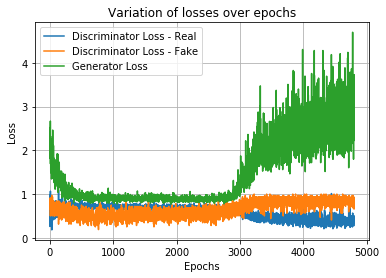

4801 [D loss: 0.524788, acc.: 68.75%] [G loss: 2.827528]
4802 [D loss: 0.313926, acc.: 84.38%] [G loss: 4.848594]
4803 [D loss: 0.422339, acc.: 81.25%] [G loss: 3.708501]
4804 [D loss: 0.470514, acc.: 84.38%] [G loss: 2.843632]
4805 [D loss: 0.398852, acc.: 84.38%] [G loss: 3.493941]
4806 [D loss: 0.327148, acc.: 87.50%] [G loss: 2.474514]
4807 [D loss: 0.347370, acc.: 90.62%] [G loss: 3.083180]
4808 [D loss: 0.420554, acc.: 71.88%] [G loss: 2.389592]
4809 [D loss: 0.404557, acc.: 81.25%] [G loss: 3.471739]
4810 [D loss: 0.569909, acc.: 59.38%] [G loss: 3.454933]
4811 [D loss: 0.224145, acc.: 93.75%] [G loss: 3.477172]
4812 [D loss: 0.534526, acc.: 71.88%] [G loss: 2.439055]
4813 [D loss: 0.567517, acc.: 62.50%] [G loss: 2.476898]
4814 [D loss: 0.406571, acc.: 81.25%] [G loss: 2.905958]
4815 [D loss: 0.451053, acc.: 81.25%] [G loss: 2.294161]
4816 [D loss: 0.296633, acc.: 90.62%] [G loss: 1.971441]
4817 [D loss: 0.507058, acc.: 68.75%] [G loss: 2.374263]
4818 [D loss: 0.436108, acc.: 8

4946 [D loss: 0.308271, acc.: 87.50%] [G loss: 3.581189]
4947 [D loss: 0.558007, acc.: 62.50%] [G loss: 3.145156]
4948 [D loss: 0.438769, acc.: 78.12%] [G loss: 2.415056]
4949 [D loss: 0.302648, acc.: 87.50%] [G loss: 3.232594]
4950 [D loss: 0.386658, acc.: 81.25%] [G loss: 2.556116]
4951 [D loss: 0.312275, acc.: 87.50%] [G loss: 2.993264]
4952 [D loss: 0.447242, acc.: 75.00%] [G loss: 2.151132]
4953 [D loss: 0.360181, acc.: 90.62%] [G loss: 3.410663]
4954 [D loss: 0.507069, acc.: 81.25%] [G loss: 2.786251]
4955 [D loss: 0.274269, acc.: 93.75%] [G loss: 3.280766]
4956 [D loss: 0.311649, acc.: 90.62%] [G loss: 2.482053]
4957 [D loss: 0.381623, acc.: 90.62%] [G loss: 2.471069]
4958 [D loss: 0.257850, acc.: 90.62%] [G loss: 2.615232]
4959 [D loss: 0.295757, acc.: 90.62%] [G loss: 3.188807]
4960 [D loss: 0.388520, acc.: 84.38%] [G loss: 2.653198]
4961 [D loss: 0.319771, acc.: 81.25%] [G loss: 2.231977]
4962 [D loss: 0.307804, acc.: 96.88%] [G loss: 2.540729]
4963 [D loss: 0.331948, acc.: 8

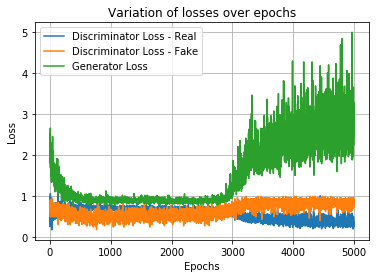

5001 [D loss: 0.371973, acc.: 87.50%] [G loss: 4.914736]
5002 [D loss: 0.279690, acc.: 84.38%] [G loss: 3.915638]
5003 [D loss: 0.414945, acc.: 81.25%] [G loss: 3.707070]
5004 [D loss: 0.451170, acc.: 81.25%] [G loss: 3.580578]
5005 [D loss: 0.359667, acc.: 90.62%] [G loss: 2.623739]
5006 [D loss: 0.577346, acc.: 78.12%] [G loss: 4.498544]
5007 [D loss: 0.531408, acc.: 71.88%] [G loss: 2.506335]
5008 [D loss: 0.466204, acc.: 78.12%] [G loss: 3.333193]
5009 [D loss: 0.309164, acc.: 84.38%] [G loss: 3.651567]
5010 [D loss: 0.442410, acc.: 81.25%] [G loss: 2.923088]
5011 [D loss: 0.410222, acc.: 87.50%] [G loss: 3.020192]
5012 [D loss: 0.269073, acc.: 90.62%] [G loss: 3.260257]
5013 [D loss: 0.392751, acc.: 87.50%] [G loss: 2.247251]
5014 [D loss: 0.334866, acc.: 84.38%] [G loss: 2.779237]
5015 [D loss: 0.395649, acc.: 81.25%] [G loss: 2.724316]
5016 [D loss: 0.356569, acc.: 81.25%] [G loss: 3.177733]
5017 [D loss: 0.336129, acc.: 90.62%] [G loss: 3.631039]
5018 [D loss: 0.266974, acc.: 9

5145 [D loss: 0.668145, acc.: 59.38%] [G loss: 2.338001]
5146 [D loss: 0.420756, acc.: 75.00%] [G loss: 3.426461]
5147 [D loss: 0.338501, acc.: 84.38%] [G loss: 2.305025]
5148 [D loss: 0.404074, acc.: 81.25%] [G loss: 1.562950]
5149 [D loss: 0.246834, acc.: 93.75%] [G loss: 2.517968]
5150 [D loss: 0.330273, acc.: 87.50%] [G loss: 2.722290]
5151 [D loss: 0.363936, acc.: 84.38%] [G loss: 2.824060]
5152 [D loss: 0.511043, acc.: 68.75%] [G loss: 2.744841]
5153 [D loss: 0.500424, acc.: 78.12%] [G loss: 2.880201]
5154 [D loss: 0.278494, acc.: 87.50%] [G loss: 3.894377]
5155 [D loss: 0.320478, acc.: 84.38%] [G loss: 2.643648]
5156 [D loss: 0.248007, acc.: 93.75%] [G loss: 2.629725]
5157 [D loss: 0.352270, acc.: 81.25%] [G loss: 2.707715]
5158 [D loss: 0.562413, acc.: 71.88%] [G loss: 2.387964]
5159 [D loss: 0.255963, acc.: 93.75%] [G loss: 3.693130]
5160 [D loss: 0.563815, acc.: 68.75%] [G loss: 2.212302]
5161 [D loss: 0.514373, acc.: 78.12%] [G loss: 3.042769]
5162 [D loss: 0.271472, acc.: 9

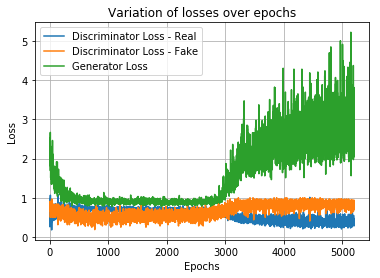

5201 [D loss: 0.388033, acc.: 75.00%] [G loss: 2.379724]
5202 [D loss: 0.307377, acc.: 84.38%] [G loss: 2.712648]
5203 [D loss: 0.562629, acc.: 71.88%] [G loss: 3.212067]
5204 [D loss: 0.517550, acc.: 75.00%] [G loss: 2.159214]
5205 [D loss: 0.222062, acc.: 90.62%] [G loss: 3.304925]
5206 [D loss: 0.472918, acc.: 81.25%] [G loss: 3.530574]
5207 [D loss: 0.309320, acc.: 90.62%] [G loss: 2.856480]
5208 [D loss: 0.487848, acc.: 78.12%] [G loss: 3.329850]
5209 [D loss: 0.383840, acc.: 84.38%] [G loss: 4.455227]
5210 [D loss: 0.650367, acc.: 56.25%] [G loss: 3.634136]
5211 [D loss: 0.338631, acc.: 87.50%] [G loss: 2.156446]
5212 [D loss: 0.294069, acc.: 93.75%] [G loss: 2.643772]
5213 [D loss: 0.368697, acc.: 87.50%] [G loss: 2.523152]
5214 [D loss: 0.320507, acc.: 87.50%] [G loss: 2.867505]
5215 [D loss: 0.257452, acc.: 87.50%] [G loss: 3.096368]
5216 [D loss: 0.398251, acc.: 84.38%] [G loss: 2.561494]
5217 [D loss: 0.405123, acc.: 78.12%] [G loss: 3.096701]
5218 [D loss: 0.211666, acc.: 9

5345 [D loss: 0.325140, acc.: 87.50%] [G loss: 4.155501]
5346 [D loss: 0.340784, acc.: 84.38%] [G loss: 3.832754]
5347 [D loss: 0.312509, acc.: 90.62%] [G loss: 2.763644]
5348 [D loss: 0.252375, acc.: 90.62%] [G loss: 2.648967]
5349 [D loss: 0.326701, acc.: 87.50%] [G loss: 2.157570]
5350 [D loss: 0.357626, acc.: 78.12%] [G loss: 3.140492]
5351 [D loss: 0.237984, acc.: 90.62%] [G loss: 2.797064]
5352 [D loss: 0.247028, acc.: 93.75%] [G loss: 3.436103]
5353 [D loss: 0.302360, acc.: 87.50%] [G loss: 1.763936]
5354 [D loss: 0.247778, acc.: 93.75%] [G loss: 2.057571]
5355 [D loss: 0.401063, acc.: 84.38%] [G loss: 2.593638]
5356 [D loss: 0.314466, acc.: 84.38%] [G loss: 2.575881]
5357 [D loss: 0.498838, acc.: 75.00%] [G loss: 2.754330]
5358 [D loss: 0.390513, acc.: 87.50%] [G loss: 2.771882]
5359 [D loss: 0.208050, acc.: 100.00%] [G loss: 2.128662]
5360 [D loss: 0.360042, acc.: 84.38%] [G loss: 3.114608]
5361 [D loss: 0.520487, acc.: 75.00%] [G loss: 2.503899]
5362 [D loss: 0.438514, acc.: 

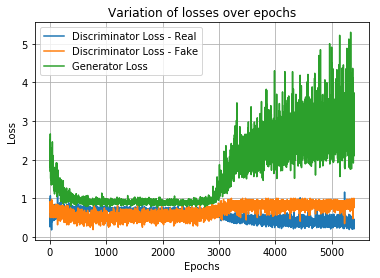

5401 [D loss: 0.351522, acc.: 87.50%] [G loss: 3.244433]
5402 [D loss: 0.225021, acc.: 100.00%] [G loss: 3.246159]
5403 [D loss: 0.462358, acc.: 68.75%] [G loss: 3.008889]
5404 [D loss: 0.283787, acc.: 96.88%] [G loss: 2.440975]
5405 [D loss: 0.588721, acc.: 75.00%] [G loss: 3.400932]
5406 [D loss: 0.548783, acc.: 71.88%] [G loss: 3.362213]
5407 [D loss: 0.365637, acc.: 81.25%] [G loss: 2.509491]
5408 [D loss: 0.322099, acc.: 87.50%] [G loss: 3.570400]
5409 [D loss: 0.244420, acc.: 93.75%] [G loss: 3.055697]
5410 [D loss: 0.527544, acc.: 75.00%] [G loss: 2.234613]
5411 [D loss: 0.275062, acc.: 93.75%] [G loss: 2.568120]
5412 [D loss: 0.493888, acc.: 71.88%] [G loss: 2.696892]
5413 [D loss: 0.301731, acc.: 93.75%] [G loss: 2.787494]
5414 [D loss: 0.271601, acc.: 93.75%] [G loss: 2.778476]
5415 [D loss: 0.302187, acc.: 90.62%] [G loss: 3.096020]
5416 [D loss: 0.522929, acc.: 71.88%] [G loss: 2.324898]
5417 [D loss: 0.428611, acc.: 75.00%] [G loss: 2.137661]
5418 [D loss: 0.284796, acc.: 

5545 [D loss: 0.490155, acc.: 78.12%] [G loss: 2.888463]
5546 [D loss: 0.519289, acc.: 71.88%] [G loss: 2.049266]
5547 [D loss: 0.485003, acc.: 71.88%] [G loss: 3.157391]
5548 [D loss: 0.677235, acc.: 68.75%] [G loss: 3.809568]
5549 [D loss: 0.333475, acc.: 90.62%] [G loss: 2.340188]
5550 [D loss: 0.457436, acc.: 71.88%] [G loss: 3.062911]
5551 [D loss: 0.354396, acc.: 87.50%] [G loss: 2.234686]
5552 [D loss: 0.311482, acc.: 87.50%] [G loss: 2.679485]
5553 [D loss: 0.349220, acc.: 87.50%] [G loss: 2.900088]
5554 [D loss: 0.419847, acc.: 81.25%] [G loss: 3.107371]
5555 [D loss: 0.324944, acc.: 90.62%] [G loss: 2.836925]
5556 [D loss: 0.306170, acc.: 90.62%] [G loss: 2.880044]
5557 [D loss: 0.521125, acc.: 75.00%] [G loss: 2.712414]
5558 [D loss: 0.467313, acc.: 78.12%] [G loss: 2.232795]
5559 [D loss: 0.336089, acc.: 84.38%] [G loss: 2.909432]
5560 [D loss: 0.433116, acc.: 78.12%] [G loss: 3.052588]
5561 [D loss: 0.368115, acc.: 84.38%] [G loss: 3.026655]
5562 [D loss: 0.293722, acc.: 9

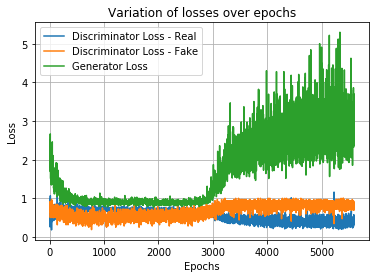

5601 [D loss: 0.436445, acc.: 71.88%] [G loss: 2.426332]
5602 [D loss: 0.398036, acc.: 87.50%] [G loss: 2.055102]
5603 [D loss: 0.435134, acc.: 81.25%] [G loss: 2.084979]
5604 [D loss: 0.372943, acc.: 81.25%] [G loss: 2.047641]
5605 [D loss: 0.559046, acc.: 62.50%] [G loss: 2.485953]
5606 [D loss: 0.343154, acc.: 87.50%] [G loss: 2.591195]
5607 [D loss: 0.336081, acc.: 90.62%] [G loss: 2.558903]
5608 [D loss: 0.345923, acc.: 84.38%] [G loss: 2.593966]
5609 [D loss: 0.585884, acc.: 75.00%] [G loss: 3.262422]
5610 [D loss: 0.328510, acc.: 84.38%] [G loss: 4.955876]
5611 [D loss: 0.446395, acc.: 75.00%] [G loss: 2.589329]
5612 [D loss: 0.344567, acc.: 81.25%] [G loss: 4.370492]
5613 [D loss: 0.415607, acc.: 84.38%] [G loss: 3.908069]
5614 [D loss: 0.459232, acc.: 81.25%] [G loss: 2.622068]
5615 [D loss: 0.393596, acc.: 87.50%] [G loss: 4.721445]
5616 [D loss: 0.265710, acc.: 90.62%] [G loss: 3.436562]
5617 [D loss: 0.404106, acc.: 81.25%] [G loss: 2.651173]
5618 [D loss: 0.331462, acc.: 7

5745 [D loss: 0.283942, acc.: 84.38%] [G loss: 3.291227]
5746 [D loss: 0.371726, acc.: 78.12%] [G loss: 2.384467]
5747 [D loss: 0.298980, acc.: 87.50%] [G loss: 2.959208]
5748 [D loss: 0.283384, acc.: 90.62%] [G loss: 3.161423]
5749 [D loss: 0.330470, acc.: 84.38%] [G loss: 2.397293]
5750 [D loss: 0.325097, acc.: 90.62%] [G loss: 1.965227]
5751 [D loss: 0.579995, acc.: 65.62%] [G loss: 3.200269]
5752 [D loss: 0.596217, acc.: 62.50%] [G loss: 2.611035]
5753 [D loss: 0.290853, acc.: 90.62%] [G loss: 2.850811]
5754 [D loss: 0.281417, acc.: 87.50%] [G loss: 3.685647]
5755 [D loss: 0.340953, acc.: 81.25%] [G loss: 1.859541]
5756 [D loss: 0.228599, acc.: 93.75%] [G loss: 2.627116]
5757 [D loss: 0.357842, acc.: 84.38%] [G loss: 2.409212]
5758 [D loss: 0.227375, acc.: 96.88%] [G loss: 3.141532]
5759 [D loss: 0.377018, acc.: 84.38%] [G loss: 2.382441]
5760 [D loss: 0.414696, acc.: 78.12%] [G loss: 2.126175]
5761 [D loss: 0.384466, acc.: 84.38%] [G loss: 3.516975]
5762 [D loss: 0.442673, acc.: 8

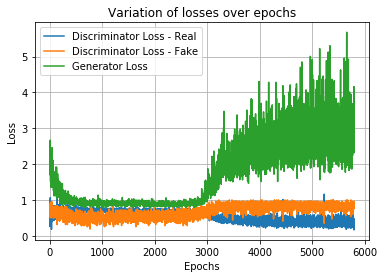

5801 [D loss: 0.393052, acc.: 75.00%] [G loss: 2.456359]
5802 [D loss: 0.328855, acc.: 81.25%] [G loss: 2.601021]
5803 [D loss: 0.333203, acc.: 84.38%] [G loss: 2.644036]
5804 [D loss: 0.349646, acc.: 84.38%] [G loss: 3.415123]
5805 [D loss: 0.324819, acc.: 84.38%] [G loss: 2.601248]
5806 [D loss: 0.239695, acc.: 93.75%] [G loss: 2.528249]
5807 [D loss: 0.527175, acc.: 68.75%] [G loss: 2.784624]
5808 [D loss: 0.405575, acc.: 81.25%] [G loss: 1.928218]
5809 [D loss: 0.344918, acc.: 81.25%] [G loss: 3.924913]
5810 [D loss: 0.538572, acc.: 75.00%] [G loss: 2.513444]
5811 [D loss: 0.591302, acc.: 71.88%] [G loss: 2.297999]
5812 [D loss: 0.324592, acc.: 84.38%] [G loss: 2.952223]
5813 [D loss: 0.489886, acc.: 75.00%] [G loss: 2.847265]
5814 [D loss: 0.421598, acc.: 75.00%] [G loss: 2.858478]
5815 [D loss: 0.337207, acc.: 87.50%] [G loss: 3.350897]
5816 [D loss: 0.691770, acc.: 46.88%] [G loss: 4.422284]
5817 [D loss: 0.726438, acc.: 59.38%] [G loss: 1.934092]
5818 [D loss: 0.431915, acc.: 7

5946 [D loss: 0.260246, acc.: 87.50%] [G loss: 2.948086]
5947 [D loss: 0.450204, acc.: 78.12%] [G loss: 2.090181]
5948 [D loss: 0.463918, acc.: 71.88%] [G loss: 3.015034]
5949 [D loss: 0.410063, acc.: 78.12%] [G loss: 3.124281]
5950 [D loss: 0.417155, acc.: 87.50%] [G loss: 2.103235]
5951 [D loss: 0.256524, acc.: 87.50%] [G loss: 2.546825]
5952 [D loss: 0.401366, acc.: 75.00%] [G loss: 2.508918]
5953 [D loss: 0.594577, acc.: 59.38%] [G loss: 2.728914]
5954 [D loss: 0.500275, acc.: 68.75%] [G loss: 2.357348]
5955 [D loss: 0.536695, acc.: 68.75%] [G loss: 2.142996]
5956 [D loss: 0.479216, acc.: 71.88%] [G loss: 2.330482]
5957 [D loss: 0.235565, acc.: 93.75%] [G loss: 2.663813]
5958 [D loss: 0.355868, acc.: 90.62%] [G loss: 1.906206]
5959 [D loss: 0.298021, acc.: 90.62%] [G loss: 2.289148]
5960 [D loss: 0.339932, acc.: 87.50%] [G loss: 1.805984]
5961 [D loss: 0.403173, acc.: 87.50%] [G loss: 1.947132]
5962 [D loss: 0.407575, acc.: 90.62%] [G loss: 2.372260]
5963 [D loss: 0.285177, acc.: 8

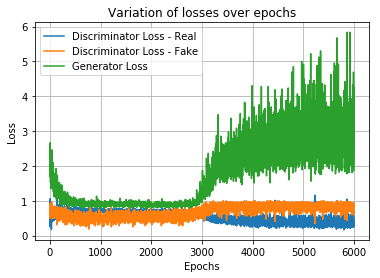

6001 [D loss: 0.381606, acc.: 81.25%] [G loss: 4.200120]
6002 [D loss: 0.368444, acc.: 78.12%] [G loss: 2.542732]
6003 [D loss: 0.297010, acc.: 87.50%] [G loss: 3.877625]
6004 [D loss: 0.397722, acc.: 78.12%] [G loss: 2.781015]
6005 [D loss: 0.199555, acc.: 96.88%] [G loss: 2.703267]
6006 [D loss: 0.500244, acc.: 78.12%] [G loss: 3.551243]
6007 [D loss: 0.224322, acc.: 93.75%] [G loss: 2.677156]
6008 [D loss: 0.289904, acc.: 87.50%] [G loss: 3.453202]
6009 [D loss: 0.382579, acc.: 81.25%] [G loss: 2.927025]
6010 [D loss: 0.240299, acc.: 96.88%] [G loss: 3.207290]
6011 [D loss: 0.361632, acc.: 87.50%] [G loss: 3.109047]
6012 [D loss: 0.546850, acc.: 68.75%] [G loss: 1.925529]
6013 [D loss: 0.267894, acc.: 90.62%] [G loss: 3.517216]
6014 [D loss: 0.400449, acc.: 84.38%] [G loss: 3.806956]
6015 [D loss: 0.623540, acc.: 59.38%] [G loss: 3.450901]
6016 [D loss: 0.393280, acc.: 84.38%] [G loss: 3.161537]
6017 [D loss: 0.653894, acc.: 62.50%] [G loss: 2.571817]
6018 [D loss: 0.300670, acc.: 9

6145 [D loss: 0.307795, acc.: 96.88%] [G loss: 2.513534]
6146 [D loss: 0.364175, acc.: 78.12%] [G loss: 2.601386]
6147 [D loss: 0.527483, acc.: 68.75%] [G loss: 2.224053]
6148 [D loss: 0.344243, acc.: 84.38%] [G loss: 2.697926]
6149 [D loss: 0.323304, acc.: 87.50%] [G loss: 2.128242]
6150 [D loss: 0.329621, acc.: 84.38%] [G loss: 2.402499]
6151 [D loss: 0.383815, acc.: 81.25%] [G loss: 2.275655]
6152 [D loss: 0.382625, acc.: 87.50%] [G loss: 2.446139]
6153 [D loss: 0.524921, acc.: 68.75%] [G loss: 2.789464]
6154 [D loss: 0.265797, acc.: 90.62%] [G loss: 3.019807]
6155 [D loss: 0.333971, acc.: 87.50%] [G loss: 2.311884]
6156 [D loss: 0.416620, acc.: 78.12%] [G loss: 2.613808]
6157 [D loss: 0.305296, acc.: 87.50%] [G loss: 2.784193]
6158 [D loss: 0.455890, acc.: 75.00%] [G loss: 2.184278]
6159 [D loss: 0.594042, acc.: 62.50%] [G loss: 2.933118]
6160 [D loss: 0.419880, acc.: 75.00%] [G loss: 2.591537]
6161 [D loss: 0.422976, acc.: 81.25%] [G loss: 2.237151]
6162 [D loss: 0.248786, acc.: 9

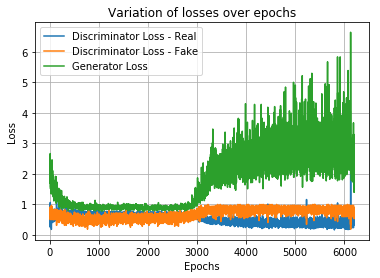

6201 [D loss: 0.469372, acc.: 78.12%] [G loss: 2.920085]
6202 [D loss: 0.541217, acc.: 78.12%] [G loss: 2.132857]
6203 [D loss: 0.399201, acc.: 87.50%] [G loss: 3.209758]
6204 [D loss: 0.248618, acc.: 93.75%] [G loss: 3.059851]
6205 [D loss: 0.276113, acc.: 90.62%] [G loss: 2.358317]
6206 [D loss: 0.363910, acc.: 78.12%] [G loss: 2.684644]
6207 [D loss: 0.272956, acc.: 90.62%] [G loss: 1.657466]
6208 [D loss: 0.235715, acc.: 93.75%] [G loss: 2.127110]
6209 [D loss: 0.374326, acc.: 78.12%] [G loss: 2.528193]
6210 [D loss: 0.295806, acc.: 84.38%] [G loss: 2.593154]
6211 [D loss: 0.302651, acc.: 87.50%] [G loss: 2.302873]
6212 [D loss: 0.363738, acc.: 87.50%] [G loss: 1.712086]
6213 [D loss: 0.414292, acc.: 87.50%] [G loss: 2.641789]
6214 [D loss: 0.314664, acc.: 87.50%] [G loss: 2.900237]
6215 [D loss: 0.376397, acc.: 78.12%] [G loss: 2.577366]
6216 [D loss: 0.249040, acc.: 93.75%] [G loss: 2.144403]
6217 [D loss: 0.378190, acc.: 78.12%] [G loss: 2.604098]
6218 [D loss: 0.463795, acc.: 6

6346 [D loss: 0.317282, acc.: 87.50%] [G loss: 2.459470]
6347 [D loss: 0.357094, acc.: 87.50%] [G loss: 1.830847]
6348 [D loss: 0.452116, acc.: 81.25%] [G loss: 2.659401]
6349 [D loss: 0.338590, acc.: 87.50%] [G loss: 3.023133]
6350 [D loss: 0.217663, acc.: 93.75%] [G loss: 3.221064]
6351 [D loss: 0.665615, acc.: 75.00%] [G loss: 2.267617]
6352 [D loss: 0.312989, acc.: 87.50%] [G loss: 1.864354]
6353 [D loss: 0.270323, acc.: 93.75%] [G loss: 2.588623]
6354 [D loss: 0.478610, acc.: 81.25%] [G loss: 2.073384]
6355 [D loss: 0.498942, acc.: 84.38%] [G loss: 2.682591]
6356 [D loss: 0.492344, acc.: 75.00%] [G loss: 1.956358]
6357 [D loss: 0.310802, acc.: 90.62%] [G loss: 3.219256]
6358 [D loss: 0.545920, acc.: 68.75%] [G loss: 3.012381]
6359 [D loss: 0.410964, acc.: 81.25%] [G loss: 2.492794]
6360 [D loss: 0.374792, acc.: 84.38%] [G loss: 2.452647]
6361 [D loss: 0.417962, acc.: 75.00%] [G loss: 2.147109]
6362 [D loss: 0.354685, acc.: 81.25%] [G loss: 2.687264]
6363 [D loss: 0.362908, acc.: 8

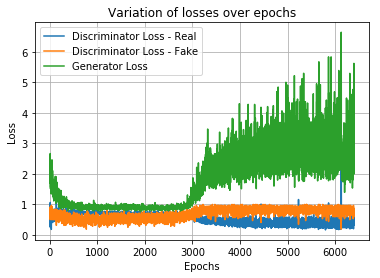

6401 [D loss: 0.341544, acc.: 87.50%] [G loss: 3.627545]
6402 [D loss: 0.380556, acc.: 81.25%] [G loss: 2.895175]
6403 [D loss: 0.394185, acc.: 87.50%] [G loss: 2.902193]
6404 [D loss: 0.239729, acc.: 93.75%] [G loss: 2.846576]
6405 [D loss: 0.254057, acc.: 93.75%] [G loss: 4.211470]
6406 [D loss: 0.240892, acc.: 93.75%] [G loss: 4.808041]
6407 [D loss: 0.228150, acc.: 93.75%] [G loss: 2.335514]
6408 [D loss: 0.326149, acc.: 84.38%] [G loss: 3.052562]
6409 [D loss: 0.386928, acc.: 75.00%] [G loss: 3.192521]
6410 [D loss: 0.375095, acc.: 78.12%] [G loss: 3.590573]
6411 [D loss: 0.283986, acc.: 90.62%] [G loss: 4.624773]
6412 [D loss: 0.450320, acc.: 81.25%] [G loss: 2.376435]
6413 [D loss: 0.266727, acc.: 93.75%] [G loss: 2.778713]
6414 [D loss: 0.447404, acc.: 81.25%] [G loss: 3.477141]
6415 [D loss: 0.321035, acc.: 84.38%] [G loss: 2.679294]
6416 [D loss: 0.346645, acc.: 81.25%] [G loss: 3.403447]
6417 [D loss: 0.442051, acc.: 78.12%] [G loss: 3.535843]
6418 [D loss: 0.375750, acc.: 8

6545 [D loss: 0.263657, acc.: 90.62%] [G loss: 4.501184]
6546 [D loss: 0.480051, acc.: 75.00%] [G loss: 3.478602]
6547 [D loss: 0.787747, acc.: 78.12%] [G loss: 7.343497]
6548 [D loss: 0.821259, acc.: 62.50%] [G loss: 4.309693]
6549 [D loss: 0.994090, acc.: 53.12%] [G loss: 4.979456]
6550 [D loss: 0.542936, acc.: 78.12%] [G loss: 4.334662]
6551 [D loss: 0.612803, acc.: 75.00%] [G loss: 3.486009]
6552 [D loss: 0.327073, acc.: 87.50%] [G loss: 4.948413]
6553 [D loss: 0.375235, acc.: 90.62%] [G loss: 2.602290]
6554 [D loss: 0.501076, acc.: 78.12%] [G loss: 2.160559]
6555 [D loss: 0.273074, acc.: 96.88%] [G loss: 2.469647]
6556 [D loss: 0.377782, acc.: 87.50%] [G loss: 2.702701]
6557 [D loss: 0.264550, acc.: 87.50%] [G loss: 2.786922]
6558 [D loss: 0.511269, acc.: 71.88%] [G loss: 2.497138]
6559 [D loss: 0.306158, acc.: 96.88%] [G loss: 2.305558]
6560 [D loss: 0.443910, acc.: 81.25%] [G loss: 3.387791]
6561 [D loss: 0.273988, acc.: 90.62%] [G loss: 2.778192]
6562 [D loss: 0.360569, acc.: 8

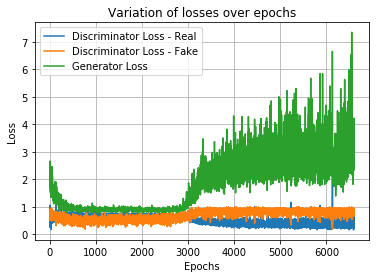

6601 [D loss: 0.256687, acc.: 90.62%] [G loss: 3.457923]
6602 [D loss: 0.405831, acc.: 81.25%] [G loss: 3.990539]
6603 [D loss: 0.219407, acc.: 96.88%] [G loss: 3.551763]
6604 [D loss: 0.448588, acc.: 75.00%] [G loss: 3.319993]
6605 [D loss: 0.509107, acc.: 78.12%] [G loss: 3.872701]
6606 [D loss: 0.537212, acc.: 78.12%] [G loss: 2.670664]
6607 [D loss: 0.245025, acc.: 87.50%] [G loss: 5.082700]
6608 [D loss: 0.552949, acc.: 71.88%] [G loss: 2.954551]
6609 [D loss: 0.279167, acc.: 93.75%] [G loss: 3.805422]
6610 [D loss: 0.343178, acc.: 90.62%] [G loss: 3.951551]
6611 [D loss: 0.301910, acc.: 90.62%] [G loss: 3.130253]
6612 [D loss: 0.303977, acc.: 90.62%] [G loss: 2.217040]
6613 [D loss: 0.396661, acc.: 71.88%] [G loss: 2.201380]
6614 [D loss: 0.357915, acc.: 81.25%] [G loss: 2.403738]
6615 [D loss: 0.446920, acc.: 75.00%] [G loss: 2.908618]
6616 [D loss: 0.373222, acc.: 84.38%] [G loss: 2.619870]
6617 [D loss: 0.405549, acc.: 90.62%] [G loss: 2.500775]
6618 [D loss: 0.301248, acc.: 8

6745 [D loss: 0.262573, acc.: 87.50%] [G loss: 2.419031]
6746 [D loss: 0.321000, acc.: 84.38%] [G loss: 2.485323]
6747 [D loss: 0.324683, acc.: 87.50%] [G loss: 3.419370]
6748 [D loss: 0.402635, acc.: 78.12%] [G loss: 2.913821]
6749 [D loss: 0.328327, acc.: 84.38%] [G loss: 2.556931]
6750 [D loss: 0.352247, acc.: 93.75%] [G loss: 2.958130]
6751 [D loss: 0.362814, acc.: 81.25%] [G loss: 2.886433]
6752 [D loss: 0.427223, acc.: 75.00%] [G loss: 2.836597]
6753 [D loss: 0.408897, acc.: 87.50%] [G loss: 2.807318]
6754 [D loss: 0.241642, acc.: 87.50%] [G loss: 3.256071]
6755 [D loss: 0.333647, acc.: 87.50%] [G loss: 2.165645]
6756 [D loss: 0.249912, acc.: 90.62%] [G loss: 2.172396]
6757 [D loss: 0.427259, acc.: 78.12%] [G loss: 1.951270]
6758 [D loss: 0.461527, acc.: 78.12%] [G loss: 2.896792]
6759 [D loss: 0.418420, acc.: 78.12%] [G loss: 2.241067]
6760 [D loss: 0.351576, acc.: 81.25%] [G loss: 3.513422]
6761 [D loss: 0.364006, acc.: 78.12%] [G loss: 2.572818]
6762 [D loss: 0.301494, acc.: 9

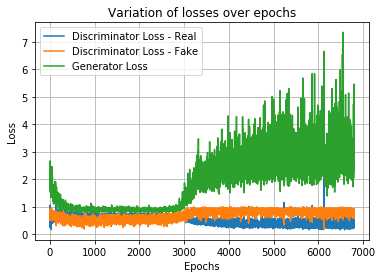

6801 [D loss: 0.377242, acc.: 84.38%] [G loss: 2.430657]
6802 [D loss: 0.364118, acc.: 87.50%] [G loss: 3.061548]
6803 [D loss: 0.479759, acc.: 78.12%] [G loss: 2.644965]
6804 [D loss: 0.333819, acc.: 84.38%] [G loss: 2.087143]
6805 [D loss: 0.337692, acc.: 81.25%] [G loss: 3.038073]
6806 [D loss: 0.566862, acc.: 71.88%] [G loss: 2.455617]
6807 [D loss: 0.547566, acc.: 68.75%] [G loss: 2.712905]
6808 [D loss: 0.314860, acc.: 87.50%] [G loss: 2.960399]
6809 [D loss: 0.414147, acc.: 78.12%] [G loss: 3.987824]
6810 [D loss: 0.484534, acc.: 81.25%] [G loss: 2.152149]
6811 [D loss: 0.316765, acc.: 84.38%] [G loss: 3.030682]
6812 [D loss: 0.365213, acc.: 84.38%] [G loss: 2.526864]
6813 [D loss: 0.408219, acc.: 81.25%] [G loss: 2.908571]
6814 [D loss: 0.323723, acc.: 84.38%] [G loss: 3.695225]
6815 [D loss: 0.156870, acc.: 93.75%] [G loss: 3.197958]
6816 [D loss: 0.363601, acc.: 81.25%] [G loss: 2.893916]
6817 [D loss: 0.286954, acc.: 87.50%] [G loss: 3.707636]
6818 [D loss: 0.348710, acc.: 8

6946 [D loss: 0.423478, acc.: 75.00%] [G loss: 2.580195]
6947 [D loss: 0.332520, acc.: 84.38%] [G loss: 3.152321]
6948 [D loss: 0.393375, acc.: 87.50%] [G loss: 2.624844]
6949 [D loss: 0.405827, acc.: 87.50%] [G loss: 2.043398]
6950 [D loss: 0.347025, acc.: 84.38%] [G loss: 1.800130]
6951 [D loss: 0.339854, acc.: 90.62%] [G loss: 2.885894]
6952 [D loss: 0.417948, acc.: 81.25%] [G loss: 2.251741]
6953 [D loss: 0.307972, acc.: 84.38%] [G loss: 3.011566]
6954 [D loss: 0.405169, acc.: 81.25%] [G loss: 2.517945]
6955 [D loss: 0.585678, acc.: 71.88%] [G loss: 2.734080]
6956 [D loss: 0.231433, acc.: 96.88%] [G loss: 3.162830]
6957 [D loss: 0.347531, acc.: 90.62%] [G loss: 2.875220]
6958 [D loss: 0.494807, acc.: 75.00%] [G loss: 2.811768]
6959 [D loss: 0.304243, acc.: 87.50%] [G loss: 2.522059]
6960 [D loss: 0.494478, acc.: 78.12%] [G loss: 2.477788]
6961 [D loss: 0.342715, acc.: 87.50%] [G loss: 2.939333]
6962 [D loss: 0.479973, acc.: 75.00%] [G loss: 3.519997]
6963 [D loss: 0.282406, acc.: 9

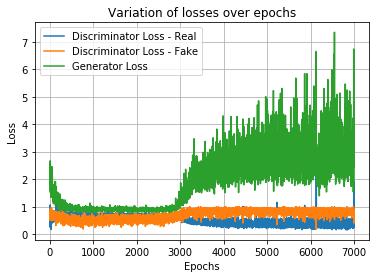

7001 [D loss: 0.384250, acc.: 81.25%] [G loss: 1.992687]
7002 [D loss: 0.471278, acc.: 81.25%] [G loss: 2.233890]
7003 [D loss: 0.426795, acc.: 78.12%] [G loss: 1.976822]
7004 [D loss: 0.225253, acc.: 96.88%] [G loss: 2.103875]
7005 [D loss: 0.460240, acc.: 81.25%] [G loss: 3.140078]
7006 [D loss: 0.304522, acc.: 84.38%] [G loss: 2.363986]
7007 [D loss: 0.438468, acc.: 84.38%] [G loss: 2.340426]
7008 [D loss: 0.431170, acc.: 81.25%] [G loss: 2.375666]
7009 [D loss: 0.564727, acc.: 71.88%] [G loss: 1.611229]
7010 [D loss: 0.536654, acc.: 75.00%] [G loss: 2.836052]
7011 [D loss: 0.608055, acc.: 71.88%] [G loss: 2.485671]
7012 [D loss: 0.165320, acc.: 93.75%] [G loss: 1.593587]
7013 [D loss: 0.368581, acc.: 81.25%] [G loss: 3.239428]
7014 [D loss: 0.347018, acc.: 84.38%] [G loss: 2.622578]
7015 [D loss: 0.279904, acc.: 87.50%] [G loss: 2.930359]
7016 [D loss: 0.583818, acc.: 62.50%] [G loss: 2.253680]
7017 [D loss: 0.502511, acc.: 71.88%] [G loss: 2.611672]
7018 [D loss: 0.192531, acc.: 1

7146 [D loss: 0.316614, acc.: 84.38%] [G loss: 2.808533]
7147 [D loss: 0.471866, acc.: 81.25%] [G loss: 3.129786]
7148 [D loss: 0.396813, acc.: 84.38%] [G loss: 2.361316]
7149 [D loss: 0.401106, acc.: 87.50%] [G loss: 2.196862]
7150 [D loss: 0.411118, acc.: 84.38%] [G loss: 2.168152]
7151 [D loss: 0.329353, acc.: 90.62%] [G loss: 2.999137]
7152 [D loss: 0.348168, acc.: 84.38%] [G loss: 2.652304]
7153 [D loss: 0.363154, acc.: 84.38%] [G loss: 3.301598]
7154 [D loss: 0.319523, acc.: 87.50%] [G loss: 3.580878]
7155 [D loss: 0.405898, acc.: 81.25%] [G loss: 2.764261]
7156 [D loss: 0.495850, acc.: 78.12%] [G loss: 3.476428]
7157 [D loss: 0.213532, acc.: 96.88%] [G loss: 3.413683]
7158 [D loss: 0.363642, acc.: 90.62%] [G loss: 2.469900]
7159 [D loss: 0.229767, acc.: 96.88%] [G loss: 4.513256]
7160 [D loss: 0.365206, acc.: 75.00%] [G loss: 2.488776]
7161 [D loss: 0.289521, acc.: 81.25%] [G loss: 2.275562]
7162 [D loss: 0.339224, acc.: 87.50%] [G loss: 3.309987]
7163 [D loss: 0.313380, acc.: 8

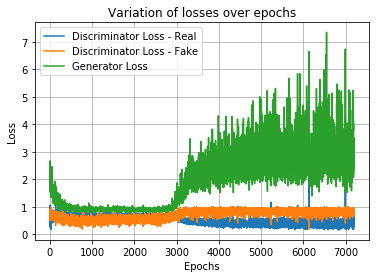

7201 [D loss: 0.602599, acc.: 62.50%] [G loss: 2.343068]
7202 [D loss: 0.360566, acc.: 81.25%] [G loss: 2.432765]
7203 [D loss: 0.483209, acc.: 71.88%] [G loss: 3.616675]
7204 [D loss: 0.451504, acc.: 78.12%] [G loss: 2.130892]
7205 [D loss: 0.320067, acc.: 87.50%] [G loss: 3.776163]
7206 [D loss: 0.442084, acc.: 81.25%] [G loss: 2.774134]
7207 [D loss: 0.470765, acc.: 71.88%] [G loss: 2.651331]
7208 [D loss: 0.329892, acc.: 90.62%] [G loss: 2.872643]
7209 [D loss: 0.513708, acc.: 71.88%] [G loss: 2.131531]
7210 [D loss: 0.540515, acc.: 68.75%] [G loss: 3.150797]
7211 [D loss: 0.382568, acc.: 78.12%] [G loss: 2.984602]
7212 [D loss: 0.365452, acc.: 81.25%] [G loss: 3.079422]
7213 [D loss: 0.257819, acc.: 90.62%] [G loss: 2.669983]
7214 [D loss: 0.319916, acc.: 87.50%] [G loss: 3.133841]
7215 [D loss: 0.458489, acc.: 75.00%] [G loss: 2.396845]
7216 [D loss: 0.205226, acc.: 96.88%] [G loss: 3.178144]
7217 [D loss: 0.238063, acc.: 90.62%] [G loss: 2.642899]
7218 [D loss: 0.591164, acc.: 6

7345 [D loss: 0.362327, acc.: 81.25%] [G loss: 2.553516]
7346 [D loss: 0.392975, acc.: 84.38%] [G loss: 2.697931]
7347 [D loss: 0.472796, acc.: 71.88%] [G loss: 3.033388]
7348 [D loss: 0.547426, acc.: 71.88%] [G loss: 2.527456]
7349 [D loss: 0.514614, acc.: 71.88%] [G loss: 2.448903]
7350 [D loss: 0.429209, acc.: 81.25%] [G loss: 2.742895]
7351 [D loss: 0.403953, acc.: 81.25%] [G loss: 2.987489]
7352 [D loss: 0.270329, acc.: 93.75%] [G loss: 2.222103]
7353 [D loss: 0.448845, acc.: 81.25%] [G loss: 2.937988]
7354 [D loss: 0.367472, acc.: 78.12%] [G loss: 4.082274]
7355 [D loss: 0.327025, acc.: 90.62%] [G loss: 2.665436]
7356 [D loss: 0.303447, acc.: 87.50%] [G loss: 4.527374]
7357 [D loss: 0.257294, acc.: 90.62%] [G loss: 4.785394]
7358 [D loss: 0.326785, acc.: 84.38%] [G loss: 2.205572]
7359 [D loss: 0.528740, acc.: 68.75%] [G loss: 2.647328]
7360 [D loss: 0.414047, acc.: 78.12%] [G loss: 2.501358]
7361 [D loss: 0.257164, acc.: 93.75%] [G loss: 4.928465]
7362 [D loss: 0.575983, acc.: 7

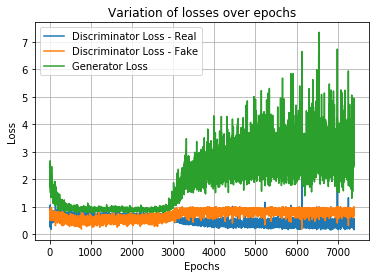

7401 [D loss: 0.501006, acc.: 81.25%] [G loss: 3.062422]
7402 [D loss: 0.263348, acc.: 90.62%] [G loss: 4.046536]
7403 [D loss: 0.333800, acc.: 84.38%] [G loss: 1.954071]
7404 [D loss: 0.246641, acc.: 93.75%] [G loss: 3.477176]
7405 [D loss: 0.267306, acc.: 90.62%] [G loss: 2.328537]
7406 [D loss: 0.470690, acc.: 75.00%] [G loss: 1.987463]
7407 [D loss: 0.337710, acc.: 90.62%] [G loss: 2.598970]
7408 [D loss: 0.380263, acc.: 78.12%] [G loss: 2.159410]
7409 [D loss: 0.843421, acc.: 56.25%] [G loss: 5.864504]
7410 [D loss: 0.790714, acc.: 62.50%] [G loss: 2.347860]
7411 [D loss: 0.318142, acc.: 87.50%] [G loss: 3.871108]
7412 [D loss: 0.622160, acc.: 59.38%] [G loss: 3.139247]
7413 [D loss: 0.292268, acc.: 90.62%] [G loss: 3.163343]
7414 [D loss: 0.313336, acc.: 87.50%] [G loss: 3.228037]
7415 [D loss: 0.461212, acc.: 81.25%] [G loss: 3.007845]
7416 [D loss: 0.447691, acc.: 75.00%] [G loss: 2.660044]
7417 [D loss: 0.608248, acc.: 68.75%] [G loss: 2.724561]
7418 [D loss: 0.323345, acc.: 8

7545 [D loss: 0.505522, acc.: 75.00%] [G loss: 2.384485]
7546 [D loss: 0.456429, acc.: 71.88%] [G loss: 1.906093]
7547 [D loss: 0.401816, acc.: 87.50%] [G loss: 2.619980]
7548 [D loss: 0.525824, acc.: 62.50%] [G loss: 1.854638]
7549 [D loss: 0.436464, acc.: 78.12%] [G loss: 2.480732]
7550 [D loss: 0.267090, acc.: 87.50%] [G loss: 2.786452]
7551 [D loss: 0.262717, acc.: 93.75%] [G loss: 2.545183]
7552 [D loss: 0.472392, acc.: 75.00%] [G loss: 2.753535]
7553 [D loss: 0.363536, acc.: 87.50%] [G loss: 2.515303]
7554 [D loss: 0.380941, acc.: 87.50%] [G loss: 3.475487]
7555 [D loss: 0.593296, acc.: 68.75%] [G loss: 3.107319]
7556 [D loss: 0.443004, acc.: 78.12%] [G loss: 2.034729]
7557 [D loss: 0.429201, acc.: 78.12%] [G loss: 1.748020]
7558 [D loss: 0.473501, acc.: 78.12%] [G loss: 3.902763]
7559 [D loss: 0.443466, acc.: 71.88%] [G loss: 2.377924]
7560 [D loss: 0.485699, acc.: 71.88%] [G loss: 2.837198]
7561 [D loss: 0.222899, acc.: 93.75%] [G loss: 3.211372]
7562 [D loss: 0.703383, acc.: 5

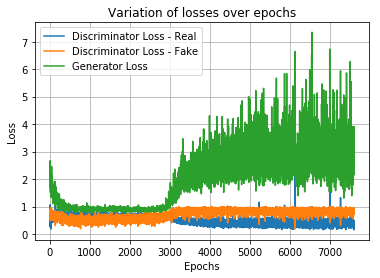

7601 [D loss: 0.433726, acc.: 84.38%] [G loss: 3.534447]
7602 [D loss: 0.551828, acc.: 65.62%] [G loss: 3.103572]
7603 [D loss: 0.344852, acc.: 84.38%] [G loss: 2.358258]
7604 [D loss: 0.360967, acc.: 84.38%] [G loss: 3.011177]
7605 [D loss: 0.347105, acc.: 81.25%] [G loss: 3.064499]
7606 [D loss: 0.592851, acc.: 62.50%] [G loss: 3.295544]
7607 [D loss: 0.463145, acc.: 71.88%] [G loss: 3.039001]
7608 [D loss: 0.293950, acc.: 87.50%] [G loss: 2.432573]
7609 [D loss: 0.522775, acc.: 68.75%] [G loss: 3.011284]
7610 [D loss: 0.577593, acc.: 68.75%] [G loss: 2.244682]
7611 [D loss: 0.254818, acc.: 93.75%] [G loss: 2.925491]
7612 [D loss: 0.396560, acc.: 81.25%] [G loss: 3.329674]
7613 [D loss: 0.295685, acc.: 84.38%] [G loss: 3.023156]
7614 [D loss: 0.367384, acc.: 81.25%] [G loss: 1.978211]
7615 [D loss: 0.500026, acc.: 68.75%] [G loss: 3.533390]
7616 [D loss: 0.378099, acc.: 78.12%] [G loss: 2.884157]
7617 [D loss: 0.340326, acc.: 84.38%] [G loss: 2.219005]
7618 [D loss: 0.410231, acc.: 7

7745 [D loss: 0.392389, acc.: 75.00%] [G loss: 2.050763]
7746 [D loss: 0.306350, acc.: 84.38%] [G loss: 2.214454]
7747 [D loss: 0.562805, acc.: 71.88%] [G loss: 2.587190]
7748 [D loss: 0.373525, acc.: 90.62%] [G loss: 2.453197]
7749 [D loss: 0.430300, acc.: 78.12%] [G loss: 2.076131]
7750 [D loss: 0.357212, acc.: 87.50%] [G loss: 2.029581]
7751 [D loss: 0.430528, acc.: 78.12%] [G loss: 1.554194]
7752 [D loss: 0.410932, acc.: 78.12%] [G loss: 1.738159]
7753 [D loss: 0.437021, acc.: 78.12%] [G loss: 2.438466]
7754 [D loss: 0.269078, acc.: 93.75%] [G loss: 2.381591]
7755 [D loss: 0.510448, acc.: 68.75%] [G loss: 2.355604]
7756 [D loss: 0.276280, acc.: 84.38%] [G loss: 2.879212]
7757 [D loss: 0.298022, acc.: 87.50%] [G loss: 2.210358]
7758 [D loss: 0.393680, acc.: 84.38%] [G loss: 3.671452]
7759 [D loss: 0.311319, acc.: 90.62%] [G loss: 2.415633]
7760 [D loss: 0.324863, acc.: 84.38%] [G loss: 2.273642]
7761 [D loss: 0.382745, acc.: 78.12%] [G loss: 2.446832]
7762 [D loss: 0.447997, acc.: 8

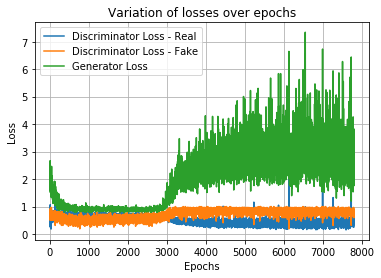

7801 [D loss: 0.353025, acc.: 90.62%] [G loss: 2.337361]
7802 [D loss: 0.488069, acc.: 75.00%] [G loss: 2.068507]
7803 [D loss: 0.372656, acc.: 78.12%] [G loss: 2.244070]
7804 [D loss: 0.432226, acc.: 78.12%] [G loss: 2.252119]
7805 [D loss: 0.355821, acc.: 84.38%] [G loss: 1.996678]
7806 [D loss: 0.587108, acc.: 78.12%] [G loss: 2.195775]
7807 [D loss: 0.532995, acc.: 68.75%] [G loss: 2.209882]
7808 [D loss: 0.374139, acc.: 81.25%] [G loss: 2.701445]
7809 [D loss: 0.654445, acc.: 65.62%] [G loss: 2.474113]
7810 [D loss: 0.578888, acc.: 65.62%] [G loss: 1.677404]
7811 [D loss: 0.588749, acc.: 62.50%] [G loss: 1.887655]
7812 [D loss: 0.476040, acc.: 78.12%] [G loss: 2.155554]
7813 [D loss: 0.415946, acc.: 84.38%] [G loss: 2.831840]
7814 [D loss: 0.419664, acc.: 78.12%] [G loss: 2.361263]
7815 [D loss: 0.399170, acc.: 75.00%] [G loss: 2.083821]
7816 [D loss: 0.277542, acc.: 93.75%] [G loss: 2.920955]
7817 [D loss: 0.408477, acc.: 81.25%] [G loss: 2.000267]
7818 [D loss: 0.473343, acc.: 7

7945 [D loss: 0.397349, acc.: 78.12%] [G loss: 1.885859]
7946 [D loss: 0.316832, acc.: 90.62%] [G loss: 2.000513]
7947 [D loss: 0.371607, acc.: 84.38%] [G loss: 2.710101]
7948 [D loss: 0.223694, acc.: 96.88%] [G loss: 3.144432]
7949 [D loss: 0.477144, acc.: 68.75%] [G loss: 2.592828]
7950 [D loss: 0.572224, acc.: 71.88%] [G loss: 2.483496]
7951 [D loss: 0.254226, acc.: 84.38%] [G loss: 3.038596]
7952 [D loss: 0.559451, acc.: 65.62%] [G loss: 2.336129]
7953 [D loss: 0.452988, acc.: 78.12%] [G loss: 3.602579]
7954 [D loss: 0.345562, acc.: 84.38%] [G loss: 2.810529]
7955 [D loss: 0.417322, acc.: 78.12%] [G loss: 2.658943]
7956 [D loss: 0.249063, acc.: 96.88%] [G loss: 3.400832]
7957 [D loss: 0.360917, acc.: 84.38%] [G loss: 2.535403]
7958 [D loss: 0.424927, acc.: 75.00%] [G loss: 5.163804]
7959 [D loss: 0.461927, acc.: 71.88%] [G loss: 3.077010]
7960 [D loss: 0.313713, acc.: 84.38%] [G loss: 3.635118]
7961 [D loss: 0.422600, acc.: 78.12%] [G loss: 3.063970]
7962 [D loss: 0.222226, acc.: 9

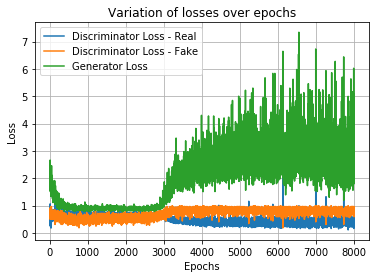

8001 [D loss: 0.434958, acc.: 84.38%] [G loss: 2.332277]
8002 [D loss: 0.521198, acc.: 71.88%] [G loss: 2.037787]
8003 [D loss: 0.447069, acc.: 75.00%] [G loss: 2.653701]
8004 [D loss: 0.336566, acc.: 81.25%] [G loss: 3.057024]
8005 [D loss: 0.408458, acc.: 78.12%] [G loss: 2.119012]
8006 [D loss: 0.328886, acc.: 87.50%] [G loss: 3.325705]
8007 [D loss: 0.311659, acc.: 90.62%] [G loss: 1.712333]
8008 [D loss: 0.479069, acc.: 71.88%] [G loss: 2.790120]
8009 [D loss: 0.626075, acc.: 59.38%] [G loss: 1.853595]
8010 [D loss: 0.269924, acc.: 90.62%] [G loss: 2.426060]
8011 [D loss: 0.355267, acc.: 81.25%] [G loss: 2.081930]
8012 [D loss: 0.460984, acc.: 78.12%] [G loss: 2.737535]
8013 [D loss: 0.267682, acc.: 96.88%] [G loss: 2.618794]
8014 [D loss: 0.479738, acc.: 75.00%] [G loss: 2.976630]
8015 [D loss: 0.384753, acc.: 71.88%] [G loss: 3.619064]
8016 [D loss: 0.378179, acc.: 81.25%] [G loss: 2.897269]
8017 [D loss: 0.418564, acc.: 78.12%] [G loss: 2.721036]
8018 [D loss: 0.310271, acc.: 8

8145 [D loss: 0.488156, acc.: 75.00%] [G loss: 1.634140]
8146 [D loss: 0.348910, acc.: 87.50%] [G loss: 1.864446]
8147 [D loss: 0.407551, acc.: 87.50%] [G loss: 1.981122]
8148 [D loss: 0.453298, acc.: 75.00%] [G loss: 2.040726]
8149 [D loss: 0.317094, acc.: 87.50%] [G loss: 2.893623]
8150 [D loss: 0.373767, acc.: 81.25%] [G loss: 3.407716]
8151 [D loss: 0.396987, acc.: 78.12%] [G loss: 2.368265]
8152 [D loss: 0.386592, acc.: 81.25%] [G loss: 2.614645]
8153 [D loss: 0.460646, acc.: 68.75%] [G loss: 1.783022]
8154 [D loss: 0.399724, acc.: 90.62%] [G loss: 2.039418]
8155 [D loss: 0.352384, acc.: 84.38%] [G loss: 2.726291]
8156 [D loss: 0.284064, acc.: 81.25%] [G loss: 2.010648]
8157 [D loss: 0.292250, acc.: 87.50%] [G loss: 2.240104]
8158 [D loss: 0.325721, acc.: 84.38%] [G loss: 2.048263]
8159 [D loss: 0.402328, acc.: 78.12%] [G loss: 2.248068]
8160 [D loss: 0.348661, acc.: 78.12%] [G loss: 2.306512]
8161 [D loss: 0.385295, acc.: 78.12%] [G loss: 1.773201]
8162 [D loss: 0.298486, acc.: 9

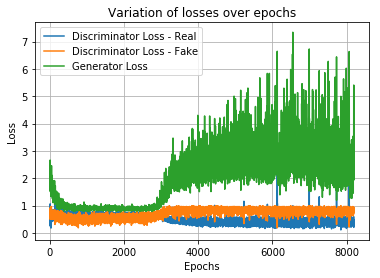

8201 [D loss: 0.240532, acc.: 90.62%] [G loss: 4.153226]
8202 [D loss: 0.355784, acc.: 81.25%] [G loss: 2.530681]
8203 [D loss: 0.444759, acc.: 75.00%] [G loss: 2.838079]
8204 [D loss: 0.435091, acc.: 75.00%] [G loss: 1.687218]
8205 [D loss: 0.434777, acc.: 75.00%] [G loss: 3.557279]
8206 [D loss: 0.383413, acc.: 75.00%] [G loss: 2.395152]
8207 [D loss: 0.584342, acc.: 65.62%] [G loss: 4.992083]
8208 [D loss: 0.553132, acc.: 71.88%] [G loss: 2.413287]
8209 [D loss: 0.229194, acc.: 84.38%] [G loss: 4.074945]
8210 [D loss: 0.314967, acc.: 84.38%] [G loss: 2.388445]
8211 [D loss: 0.464486, acc.: 78.12%] [G loss: 3.266515]
8212 [D loss: 0.423430, acc.: 75.00%] [G loss: 3.052855]
8213 [D loss: 0.258884, acc.: 87.50%] [G loss: 4.553977]
8214 [D loss: 0.586940, acc.: 65.62%] [G loss: 3.782812]
8215 [D loss: 0.401577, acc.: 75.00%] [G loss: 3.009681]
8216 [D loss: 0.511194, acc.: 68.75%] [G loss: 2.654055]
8217 [D loss: 0.284330, acc.: 87.50%] [G loss: 2.463210]
8218 [D loss: 0.411135, acc.: 8

8345 [D loss: 0.343875, acc.: 84.38%] [G loss: 2.221955]
8346 [D loss: 0.303681, acc.: 87.50%] [G loss: 3.236099]
8347 [D loss: 0.398069, acc.: 81.25%] [G loss: 2.629084]
8348 [D loss: 0.544526, acc.: 68.75%] [G loss: 1.834589]
8349 [D loss: 0.615796, acc.: 68.75%] [G loss: 2.520166]
8350 [D loss: 0.536052, acc.: 71.88%] [G loss: 2.489020]
8351 [D loss: 0.365105, acc.: 78.12%] [G loss: 2.677588]
8352 [D loss: 0.524894, acc.: 78.12%] [G loss: 2.555755]
8353 [D loss: 0.533643, acc.: 78.12%] [G loss: 1.536088]
8354 [D loss: 0.449109, acc.: 81.25%] [G loss: 2.887383]
8355 [D loss: 0.467440, acc.: 81.25%] [G loss: 2.247854]
8356 [D loss: 0.301191, acc.: 84.38%] [G loss: 2.927690]
8357 [D loss: 0.154794, acc.: 93.75%] [G loss: 3.515229]
8358 [D loss: 0.509942, acc.: 75.00%] [G loss: 2.623411]
8359 [D loss: 0.238796, acc.: 90.62%] [G loss: 2.487922]
8360 [D loss: 0.385548, acc.: 81.25%] [G loss: 2.684167]
8361 [D loss: 0.425670, acc.: 78.12%] [G loss: 2.026127]
8362 [D loss: 0.344547, acc.: 8

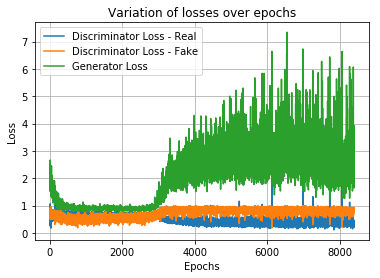

8401 [D loss: 0.497864, acc.: 71.88%] [G loss: 1.581473]
8402 [D loss: 0.425799, acc.: 75.00%] [G loss: 1.747413]
8403 [D loss: 0.263852, acc.: 93.75%] [G loss: 1.726063]
8404 [D loss: 0.496406, acc.: 75.00%] [G loss: 3.376449]
8405 [D loss: 0.553735, acc.: 68.75%] [G loss: 2.348277]
8406 [D loss: 0.241975, acc.: 90.62%] [G loss: 4.472774]
8407 [D loss: 0.417766, acc.: 84.38%] [G loss: 2.680656]
8408 [D loss: 0.302430, acc.: 87.50%] [G loss: 2.549247]
8409 [D loss: 0.380843, acc.: 81.25%] [G loss: 3.672375]
8410 [D loss: 0.476619, acc.: 75.00%] [G loss: 2.300660]
8411 [D loss: 0.257845, acc.: 90.62%] [G loss: 4.507429]
8412 [D loss: 0.414921, acc.: 84.38%] [G loss: 3.041108]
8413 [D loss: 0.481041, acc.: 68.75%] [G loss: 2.487869]
8414 [D loss: 0.459056, acc.: 78.12%] [G loss: 1.759368]
8415 [D loss: 0.361020, acc.: 78.12%] [G loss: 2.961513]
8416 [D loss: 0.518524, acc.: 78.12%] [G loss: 2.538564]
8417 [D loss: 0.509074, acc.: 65.62%] [G loss: 2.628313]
8418 [D loss: 0.519926, acc.: 7

8546 [D loss: 0.424101, acc.: 81.25%] [G loss: 2.051211]
8547 [D loss: 0.554381, acc.: 71.88%] [G loss: 2.248270]
8548 [D loss: 0.412442, acc.: 78.12%] [G loss: 1.742492]
8549 [D loss: 0.330056, acc.: 87.50%] [G loss: 2.138236]
8550 [D loss: 0.290764, acc.: 87.50%] [G loss: 2.362598]
8551 [D loss: 0.688304, acc.: 62.50%] [G loss: 1.691770]
8552 [D loss: 0.377133, acc.: 87.50%] [G loss: 2.008732]
8553 [D loss: 0.521483, acc.: 78.12%] [G loss: 1.987582]
8554 [D loss: 0.533198, acc.: 68.75%] [G loss: 2.222230]
8555 [D loss: 0.516251, acc.: 71.88%] [G loss: 2.544925]
8556 [D loss: 0.437116, acc.: 78.12%] [G loss: 1.654581]
8557 [D loss: 0.346109, acc.: 90.62%] [G loss: 1.575713]
8558 [D loss: 0.371497, acc.: 75.00%] [G loss: 1.530964]
8559 [D loss: 0.462206, acc.: 68.75%] [G loss: 2.425125]
8560 [D loss: 0.387327, acc.: 81.25%] [G loss: 3.304306]
8561 [D loss: 0.404440, acc.: 81.25%] [G loss: 1.840060]
8562 [D loss: 0.573475, acc.: 65.62%] [G loss: 1.889207]
8563 [D loss: 0.245482, acc.: 9

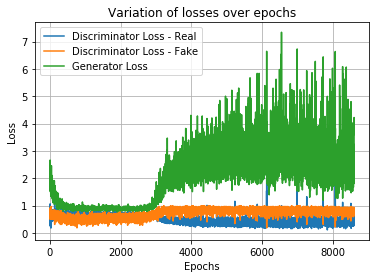

8601 [D loss: 0.623668, acc.: 65.62%] [G loss: 2.552555]
8602 [D loss: 0.512285, acc.: 75.00%] [G loss: 1.648982]
8603 [D loss: 0.461999, acc.: 78.12%] [G loss: 1.571190]
8604 [D loss: 0.365699, acc.: 75.00%] [G loss: 2.324931]
8605 [D loss: 0.557817, acc.: 71.88%] [G loss: 2.935411]
8606 [D loss: 0.531680, acc.: 65.62%] [G loss: 1.947088]
8607 [D loss: 0.305674, acc.: 90.62%] [G loss: 2.492663]
8608 [D loss: 0.393339, acc.: 78.12%] [G loss: 1.680605]
8609 [D loss: 0.263503, acc.: 90.62%] [G loss: 2.701328]
8610 [D loss: 0.440166, acc.: 68.75%] [G loss: 1.864066]
8611 [D loss: 0.366536, acc.: 90.62%] [G loss: 2.641113]
8612 [D loss: 0.443250, acc.: 84.38%] [G loss: 1.880828]
8613 [D loss: 0.493500, acc.: 75.00%] [G loss: 1.883991]
8614 [D loss: 0.551514, acc.: 68.75%] [G loss: 2.080578]
8615 [D loss: 0.418644, acc.: 71.88%] [G loss: 2.730823]
8616 [D loss: 0.366290, acc.: 84.38%] [G loss: 2.282227]
8617 [D loss: 0.377834, acc.: 78.12%] [G loss: 1.933326]
8618 [D loss: 0.494108, acc.: 7

8745 [D loss: 0.480074, acc.: 71.88%] [G loss: 2.586595]
8746 [D loss: 0.368602, acc.: 84.38%] [G loss: 2.682874]
8747 [D loss: 0.395437, acc.: 84.38%] [G loss: 3.300462]
8748 [D loss: 0.518341, acc.: 68.75%] [G loss: 3.191619]
8749 [D loss: 0.621301, acc.: 71.88%] [G loss: 3.413501]
8750 [D loss: 0.381388, acc.: 81.25%] [G loss: 3.060660]
8751 [D loss: 0.378195, acc.: 81.25%] [G loss: 3.590631]
8752 [D loss: 0.419807, acc.: 71.88%] [G loss: 2.140202]
8753 [D loss: 0.407624, acc.: 84.38%] [G loss: 2.882650]
8754 [D loss: 0.369283, acc.: 78.12%] [G loss: 2.285019]
8755 [D loss: 0.480685, acc.: 78.12%] [G loss: 3.431711]
8756 [D loss: 0.369081, acc.: 84.38%] [G loss: 1.846167]
8757 [D loss: 0.267716, acc.: 87.50%] [G loss: 3.750058]
8758 [D loss: 0.559099, acc.: 68.75%] [G loss: 2.033632]
8759 [D loss: 0.365577, acc.: 75.00%] [G loss: 2.665254]
8760 [D loss: 0.484612, acc.: 75.00%] [G loss: 2.116478]
8761 [D loss: 0.371816, acc.: 75.00%] [G loss: 2.772150]
8762 [D loss: 0.415575, acc.: 7

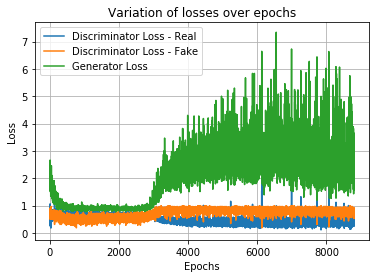

8801 [D loss: 0.336954, acc.: 78.12%] [G loss: 2.464190]
8802 [D loss: 0.318935, acc.: 87.50%] [G loss: 2.653838]
8803 [D loss: 0.384585, acc.: 81.25%] [G loss: 1.651664]
8804 [D loss: 0.522256, acc.: 71.88%] [G loss: 2.628352]
8805 [D loss: 0.422383, acc.: 78.12%] [G loss: 2.596519]
8806 [D loss: 0.425927, acc.: 75.00%] [G loss: 2.965946]
8807 [D loss: 0.382656, acc.: 81.25%] [G loss: 4.146074]
8808 [D loss: 0.501081, acc.: 75.00%] [G loss: 3.889200]
8809 [D loss: 0.570210, acc.: 68.75%] [G loss: 2.796169]
8810 [D loss: 0.562567, acc.: 75.00%] [G loss: 2.839417]
8811 [D loss: 0.384178, acc.: 75.00%] [G loss: 2.587171]
8812 [D loss: 0.500180, acc.: 71.88%] [G loss: 3.627484]
8813 [D loss: 0.889071, acc.: 68.75%] [G loss: 2.766348]
8814 [D loss: 0.431775, acc.: 81.25%] [G loss: 2.774706]
8815 [D loss: 0.461265, acc.: 75.00%] [G loss: 2.526624]
8816 [D loss: 0.594119, acc.: 65.62%] [G loss: 2.943342]
8817 [D loss: 0.248803, acc.: 84.38%] [G loss: 3.837963]
8818 [D loss: 0.617493, acc.: 6

8946 [D loss: 0.404118, acc.: 75.00%] [G loss: 2.679176]
8947 [D loss: 0.303010, acc.: 90.62%] [G loss: 2.166328]
8948 [D loss: 0.526108, acc.: 68.75%] [G loss: 2.884194]
8949 [D loss: 0.403741, acc.: 78.12%] [G loss: 2.057129]
8950 [D loss: 0.499839, acc.: 71.88%] [G loss: 3.154684]
8951 [D loss: 0.424183, acc.: 75.00%] [G loss: 2.581844]
8952 [D loss: 0.520284, acc.: 62.50%] [G loss: 2.721026]
8953 [D loss: 0.380687, acc.: 87.50%] [G loss: 2.623991]
8954 [D loss: 0.299403, acc.: 81.25%] [G loss: 3.006425]
8955 [D loss: 0.328551, acc.: 87.50%] [G loss: 2.605710]
8956 [D loss: 0.423278, acc.: 71.88%] [G loss: 4.284757]
8957 [D loss: 0.964957, acc.: 46.88%] [G loss: 1.764144]
8958 [D loss: 0.394545, acc.: 75.00%] [G loss: 1.697097]
8959 [D loss: 0.483777, acc.: 68.75%] [G loss: 2.962645]
8960 [D loss: 0.352267, acc.: 84.38%] [G loss: 1.877784]
8961 [D loss: 0.638963, acc.: 62.50%] [G loss: 4.121127]
8962 [D loss: 0.222297, acc.: 90.62%] [G loss: 3.676435]
8963 [D loss: 0.553391, acc.: 7

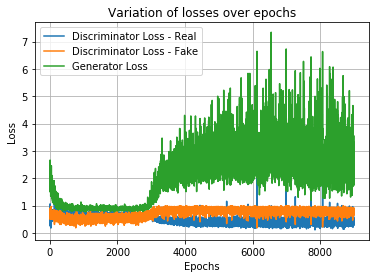

9001 [D loss: 0.283046, acc.: 87.50%] [G loss: 2.398814]
9002 [D loss: 0.420218, acc.: 81.25%] [G loss: 3.267519]
9003 [D loss: 0.325036, acc.: 84.38%] [G loss: 3.520411]
9004 [D loss: 0.613558, acc.: 65.62%] [G loss: 2.652995]
9005 [D loss: 0.371485, acc.: 84.38%] [G loss: 2.408827]
9006 [D loss: 0.688344, acc.: 62.50%] [G loss: 2.013208]
9007 [D loss: 0.573259, acc.: 71.88%] [G loss: 2.572421]
9008 [D loss: 0.390781, acc.: 87.50%] [G loss: 3.188497]
9009 [D loss: 0.232980, acc.: 90.62%] [G loss: 3.864202]
9010 [D loss: 0.302384, acc.: 87.50%] [G loss: 2.311924]
9011 [D loss: 0.280289, acc.: 90.62%] [G loss: 2.823574]
9012 [D loss: 0.524163, acc.: 71.88%] [G loss: 1.954933]
9013 [D loss: 0.623331, acc.: 56.25%] [G loss: 2.133735]
9014 [D loss: 0.469341, acc.: 65.62%] [G loss: 1.871459]
9015 [D loss: 0.461369, acc.: 71.88%] [G loss: 2.181551]
9016 [D loss: 0.472074, acc.: 71.88%] [G loss: 2.095457]
9017 [D loss: 0.413564, acc.: 81.25%] [G loss: 2.970300]
9018 [D loss: 0.433152, acc.: 8

9146 [D loss: 0.404091, acc.: 78.12%] [G loss: 4.983069]
9147 [D loss: 0.821027, acc.: 56.25%] [G loss: 2.744032]
9148 [D loss: 0.718391, acc.: 71.88%] [G loss: 2.549125]
9149 [D loss: 0.445591, acc.: 68.75%] [G loss: 3.923849]
9150 [D loss: 0.164881, acc.: 100.00%] [G loss: 3.265686]
9151 [D loss: 0.406466, acc.: 71.88%] [G loss: 2.268852]
9152 [D loss: 0.464000, acc.: 75.00%] [G loss: 2.047604]
9153 [D loss: 0.319764, acc.: 81.25%] [G loss: 3.261736]
9154 [D loss: 0.393294, acc.: 71.88%] [G loss: 1.566145]
9155 [D loss: 0.472541, acc.: 71.88%] [G loss: 1.677964]
9156 [D loss: 0.339179, acc.: 81.25%] [G loss: 1.871526]
9157 [D loss: 0.504386, acc.: 71.88%] [G loss: 1.934003]
9158 [D loss: 0.318713, acc.: 93.75%] [G loss: 1.870970]
9159 [D loss: 0.561993, acc.: 62.50%] [G loss: 1.489285]
9160 [D loss: 0.566455, acc.: 68.75%] [G loss: 1.680099]
9161 [D loss: 0.499069, acc.: 78.12%] [G loss: 1.624353]
9162 [D loss: 0.342306, acc.: 81.25%] [G loss: 1.980357]
9163 [D loss: 0.487905, acc.: 

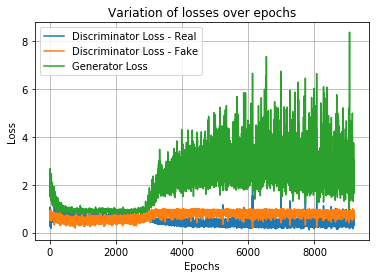

9201 [D loss: 0.350468, acc.: 81.25%] [G loss: 2.322662]
9202 [D loss: 0.579019, acc.: 59.38%] [G loss: 1.838163]
9203 [D loss: 0.457403, acc.: 75.00%] [G loss: 1.460395]
9204 [D loss: 0.361264, acc.: 81.25%] [G loss: 1.965682]
9205 [D loss: 0.378660, acc.: 84.38%] [G loss: 1.925389]
9206 [D loss: 0.435873, acc.: 71.88%] [G loss: 2.038885]
9207 [D loss: 0.387479, acc.: 84.38%] [G loss: 1.759538]
9208 [D loss: 0.398757, acc.: 84.38%] [G loss: 2.793465]
9209 [D loss: 0.492950, acc.: 68.75%] [G loss: 2.787783]
9210 [D loss: 0.340874, acc.: 81.25%] [G loss: 2.254138]
9211 [D loss: 0.302872, acc.: 84.38%] [G loss: 2.629810]
9212 [D loss: 0.290041, acc.: 84.38%] [G loss: 2.933189]
9213 [D loss: 0.429871, acc.: 81.25%] [G loss: 2.936107]
9214 [D loss: 0.528443, acc.: 75.00%] [G loss: 2.668244]
9215 [D loss: 0.582488, acc.: 65.62%] [G loss: 2.723097]
9216 [D loss: 0.365966, acc.: 81.25%] [G loss: 2.737627]
9217 [D loss: 0.388304, acc.: 87.50%] [G loss: 2.971945]
9218 [D loss: 0.282474, acc.: 9

9346 [D loss: 0.459200, acc.: 81.25%] [G loss: 1.473226]
9347 [D loss: 0.518746, acc.: 68.75%] [G loss: 1.683936]
9348 [D loss: 0.303911, acc.: 90.62%] [G loss: 2.245283]
9349 [D loss: 0.295479, acc.: 90.62%] [G loss: 2.246273]
9350 [D loss: 0.280001, acc.: 93.75%] [G loss: 2.058937]
9351 [D loss: 0.302294, acc.: 87.50%] [G loss: 2.997029]
9352 [D loss: 0.454338, acc.: 78.12%] [G loss: 2.555774]
9353 [D loss: 0.478675, acc.: 81.25%] [G loss: 2.174476]
9354 [D loss: 0.364033, acc.: 84.38%] [G loss: 3.214334]
9355 [D loss: 0.485578, acc.: 75.00%] [G loss: 2.774704]
9356 [D loss: 0.335897, acc.: 84.38%] [G loss: 3.021950]
9357 [D loss: 0.698012, acc.: 59.38%] [G loss: 1.904628]
9358 [D loss: 0.335514, acc.: 78.12%] [G loss: 2.477933]
9359 [D loss: 0.370990, acc.: 78.12%] [G loss: 3.527422]
9360 [D loss: 0.391817, acc.: 84.38%] [G loss: 2.369617]
9361 [D loss: 0.346852, acc.: 84.38%] [G loss: 2.784022]
9362 [D loss: 0.341435, acc.: 78.12%] [G loss: 2.773933]
9363 [D loss: 0.266683, acc.: 8

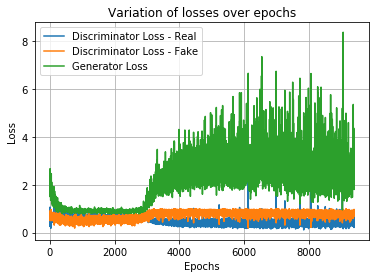

9401 [D loss: 0.234257, acc.: 87.50%] [G loss: 3.117795]
9402 [D loss: 0.541867, acc.: 65.62%] [G loss: 2.750636]
9403 [D loss: 0.490117, acc.: 71.88%] [G loss: 1.901990]
9404 [D loss: 0.288232, acc.: 84.38%] [G loss: 2.984159]
9405 [D loss: 0.609917, acc.: 75.00%] [G loss: 2.325348]
9406 [D loss: 0.313966, acc.: 84.38%] [G loss: 2.673893]
9407 [D loss: 0.441418, acc.: 71.88%] [G loss: 4.279455]
9408 [D loss: 0.361741, acc.: 78.12%] [G loss: 2.799077]
9409 [D loss: 0.306423, acc.: 84.38%] [G loss: 3.395922]
9410 [D loss: 0.413022, acc.: 75.00%] [G loss: 2.761454]
9411 [D loss: 0.229125, acc.: 90.62%] [G loss: 2.902625]
9412 [D loss: 0.343944, acc.: 81.25%] [G loss: 1.820607]
9413 [D loss: 0.361694, acc.: 78.12%] [G loss: 3.749558]
9414 [D loss: 0.395269, acc.: 81.25%] [G loss: 1.969491]
9415 [D loss: 0.230832, acc.: 93.75%] [G loss: 4.578214]
9416 [D loss: 0.502203, acc.: 71.88%] [G loss: 2.583886]
9417 [D loss: 0.186405, acc.: 93.75%] [G loss: 2.436714]
9418 [D loss: 0.451045, acc.: 6

9545 [D loss: 0.604115, acc.: 65.62%] [G loss: 2.539221]
9546 [D loss: 0.337244, acc.: 81.25%] [G loss: 2.372739]
9547 [D loss: 0.423489, acc.: 75.00%] [G loss: 2.163141]
9548 [D loss: 0.409677, acc.: 84.38%] [G loss: 2.328804]
9549 [D loss: 0.432593, acc.: 81.25%] [G loss: 2.009166]
9550 [D loss: 0.449645, acc.: 71.88%] [G loss: 2.054119]
9551 [D loss: 0.361591, acc.: 87.50%] [G loss: 2.006212]
9552 [D loss: 0.426138, acc.: 81.25%] [G loss: 1.874728]
9553 [D loss: 0.357119, acc.: 87.50%] [G loss: 1.755174]
9554 [D loss: 0.414035, acc.: 84.38%] [G loss: 2.269294]
9555 [D loss: 0.530369, acc.: 62.50%] [G loss: 1.856022]
9556 [D loss: 0.334194, acc.: 87.50%] [G loss: 2.071262]
9557 [D loss: 0.448532, acc.: 75.00%] [G loss: 2.317906]
9558 [D loss: 0.521713, acc.: 68.75%] [G loss: 2.256096]
9559 [D loss: 0.498437, acc.: 75.00%] [G loss: 2.249158]
9560 [D loss: 0.442647, acc.: 81.25%] [G loss: 2.052056]
9561 [D loss: 0.508272, acc.: 75.00%] [G loss: 2.430662]
9562 [D loss: 0.400411, acc.: 7

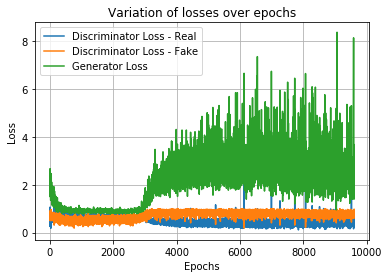

9601 [D loss: 0.368241, acc.: 81.25%] [G loss: 2.341478]
9602 [D loss: 0.488822, acc.: 75.00%] [G loss: 2.811308]
9603 [D loss: 0.394376, acc.: 75.00%] [G loss: 2.495430]
9604 [D loss: 0.644443, acc.: 62.50%] [G loss: 2.032578]
9605 [D loss: 0.511236, acc.: 71.88%] [G loss: 3.636381]
9606 [D loss: 0.423370, acc.: 75.00%] [G loss: 2.304023]
9607 [D loss: 0.357869, acc.: 78.12%] [G loss: 2.891522]
9608 [D loss: 0.497543, acc.: 75.00%] [G loss: 2.193784]
9609 [D loss: 0.419263, acc.: 78.12%] [G loss: 2.734610]
9610 [D loss: 0.485843, acc.: 75.00%] [G loss: 3.758039]
9611 [D loss: 0.555216, acc.: 65.62%] [G loss: 2.244819]
9612 [D loss: 0.474998, acc.: 78.12%] [G loss: 1.974573]
9613 [D loss: 0.457533, acc.: 65.62%] [G loss: 2.692303]
9614 [D loss: 0.603259, acc.: 68.75%] [G loss: 1.913540]
9615 [D loss: 0.278677, acc.: 90.62%] [G loss: 2.075725]
9616 [D loss: 0.325435, acc.: 87.50%] [G loss: 2.370437]
9617 [D loss: 0.361288, acc.: 84.38%] [G loss: 2.316658]
9618 [D loss: 0.348719, acc.: 7

9745 [D loss: 0.216206, acc.: 93.75%] [G loss: 2.989520]
9746 [D loss: 0.338181, acc.: 87.50%] [G loss: 4.663123]
9747 [D loss: 0.279719, acc.: 93.75%] [G loss: 1.888172]
9748 [D loss: 0.536037, acc.: 68.75%] [G loss: 2.307613]
9749 [D loss: 0.340801, acc.: 87.50%] [G loss: 3.850087]
9750 [D loss: 0.428409, acc.: 81.25%] [G loss: 2.323252]
9751 [D loss: 0.330657, acc.: 81.25%] [G loss: 2.271089]
9752 [D loss: 0.259989, acc.: 96.88%] [G loss: 2.979105]
9753 [D loss: 0.605549, acc.: 59.38%] [G loss: 2.255431]
9754 [D loss: 0.640834, acc.: 62.50%] [G loss: 1.728839]
9755 [D loss: 0.596658, acc.: 65.62%] [G loss: 2.818448]
9756 [D loss: 0.482125, acc.: 78.12%] [G loss: 1.857748]
9757 [D loss: 0.489478, acc.: 68.75%] [G loss: 3.448200]
9758 [D loss: 0.318762, acc.: 84.38%] [G loss: 3.090445]
9759 [D loss: 0.628064, acc.: 68.75%] [G loss: 2.689778]
9760 [D loss: 0.407530, acc.: 81.25%] [G loss: 2.490251]
9761 [D loss: 0.662562, acc.: 65.62%] [G loss: 2.786772]
9762 [D loss: 0.848813, acc.: 5

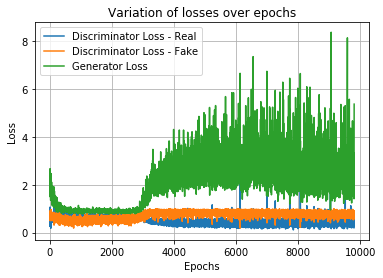

9801 [D loss: 0.295685, acc.: 84.38%] [G loss: 2.590711]
9802 [D loss: 0.342168, acc.: 87.50%] [G loss: 1.925730]
9803 [D loss: 0.281336, acc.: 87.50%] [G loss: 4.458260]
9804 [D loss: 0.395088, acc.: 75.00%] [G loss: 2.544446]
9805 [D loss: 0.258908, acc.: 84.38%] [G loss: 2.549132]
9806 [D loss: 0.276247, acc.: 87.50%] [G loss: 2.358359]
9807 [D loss: 0.462486, acc.: 75.00%] [G loss: 1.593156]
9808 [D loss: 0.462209, acc.: 84.38%] [G loss: 1.767217]
9809 [D loss: 0.481099, acc.: 71.88%] [G loss: 1.766205]
9810 [D loss: 0.490538, acc.: 65.62%] [G loss: 1.843950]
9811 [D loss: 0.570485, acc.: 75.00%] [G loss: 1.535388]
9812 [D loss: 0.387852, acc.: 84.38%] [G loss: 1.602444]
9813 [D loss: 0.397113, acc.: 81.25%] [G loss: 1.806604]
9814 [D loss: 0.371996, acc.: 87.50%] [G loss: 2.106703]
9815 [D loss: 0.533489, acc.: 59.38%] [G loss: 1.997019]
9816 [D loss: 0.354798, acc.: 81.25%] [G loss: 3.589530]
9817 [D loss: 0.399463, acc.: 84.38%] [G loss: 1.568414]
9818 [D loss: 0.412011, acc.: 7

9945 [D loss: 0.623195, acc.: 65.62%] [G loss: 2.708789]
9946 [D loss: 0.359391, acc.: 87.50%] [G loss: 3.325572]
9947 [D loss: 0.545701, acc.: 75.00%] [G loss: 4.473459]
9948 [D loss: 0.558471, acc.: 65.62%] [G loss: 3.024519]
9949 [D loss: 0.320708, acc.: 90.62%] [G loss: 2.131914]
9950 [D loss: 0.404145, acc.: 75.00%] [G loss: 1.715649]
9951 [D loss: 0.337985, acc.: 90.62%] [G loss: 3.963259]
9952 [D loss: 0.353006, acc.: 81.25%] [G loss: 6.434080]
9953 [D loss: 0.372463, acc.: 84.38%] [G loss: 2.846317]
9954 [D loss: 0.240268, acc.: 87.50%] [G loss: 2.735262]
9955 [D loss: 0.568683, acc.: 78.12%] [G loss: 2.098372]
9956 [D loss: 0.286350, acc.: 93.75%] [G loss: 4.510332]
9957 [D loss: 0.446499, acc.: 71.88%] [G loss: 3.162322]
9958 [D loss: 0.575724, acc.: 65.62%] [G loss: 2.482553]
9959 [D loss: 0.444852, acc.: 75.00%] [G loss: 3.210678]
9960 [D loss: 0.347400, acc.: 84.38%] [G loss: 4.328340]
9961 [D loss: 0.487188, acc.: 65.62%] [G loss: 3.025603]
9962 [D loss: 0.351731, acc.: 8

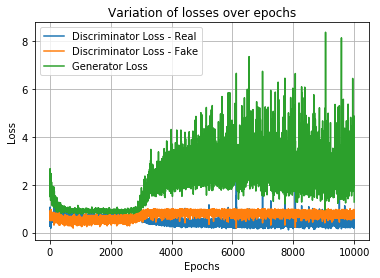

10001 [D loss: 0.537126, acc.: 71.88%] [G loss: 2.228124]
10002 [D loss: 0.463694, acc.: 78.12%] [G loss: 2.026845]
10003 [D loss: 0.587634, acc.: 68.75%] [G loss: 2.375167]
10004 [D loss: 0.699799, acc.: 56.25%] [G loss: 2.134534]
10005 [D loss: 0.606223, acc.: 75.00%] [G loss: 1.802361]
10006 [D loss: 0.443400, acc.: 78.12%] [G loss: 1.897518]
10007 [D loss: 0.473699, acc.: 71.88%] [G loss: 1.625535]
10008 [D loss: 0.575355, acc.: 68.75%] [G loss: 2.974808]
10009 [D loss: 0.464937, acc.: 81.25%] [G loss: 1.831179]
10010 [D loss: 0.461876, acc.: 68.75%] [G loss: 2.071788]
10011 [D loss: 0.578979, acc.: 71.88%] [G loss: 2.472812]
10012 [D loss: 0.622631, acc.: 65.62%] [G loss: 2.046486]
10013 [D loss: 0.346537, acc.: 87.50%] [G loss: 2.199193]
10014 [D loss: 0.618078, acc.: 62.50%] [G loss: 2.435863]
10015 [D loss: 0.300371, acc.: 87.50%] [G loss: 2.432760]
10016 [D loss: 0.696631, acc.: 59.38%] [G loss: 2.575352]
10017 [D loss: 0.428041, acc.: 68.75%] [G loss: 2.223037]
10018 [D loss:

10143 [D loss: 0.457518, acc.: 78.12%] [G loss: 2.793878]
10144 [D loss: 0.299823, acc.: 87.50%] [G loss: 5.155282]
10145 [D loss: 0.597613, acc.: 75.00%] [G loss: 2.210801]
10146 [D loss: 0.348927, acc.: 81.25%] [G loss: 3.501144]
10147 [D loss: 0.254030, acc.: 93.75%] [G loss: 2.717047]
10148 [D loss: 0.399052, acc.: 78.12%] [G loss: 2.205494]
10149 [D loss: 0.326722, acc.: 81.25%] [G loss: 2.367617]
10150 [D loss: 0.564556, acc.: 65.62%] [G loss: 2.059247]
10151 [D loss: 0.366298, acc.: 78.12%] [G loss: 1.937402]
10152 [D loss: 0.270745, acc.: 93.75%] [G loss: 3.134889]
10153 [D loss: 0.519749, acc.: 84.38%] [G loss: 1.528662]
10154 [D loss: 0.435367, acc.: 78.12%] [G loss: 1.867715]
10155 [D loss: 0.355972, acc.: 78.12%] [G loss: 1.415171]
10156 [D loss: 0.460866, acc.: 78.12%] [G loss: 1.812820]
10157 [D loss: 0.406613, acc.: 81.25%] [G loss: 2.012029]
10158 [D loss: 0.496558, acc.: 71.88%] [G loss: 2.326993]
10159 [D loss: 0.589764, acc.: 68.75%] [G loss: 1.760482]
10160 [D loss:

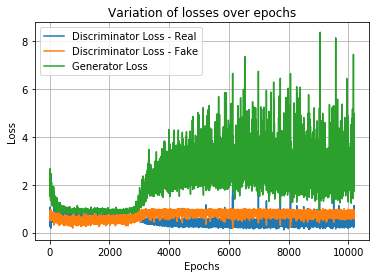

10201 [D loss: 0.423477, acc.: 71.88%] [G loss: 2.044894]
10202 [D loss: 0.400786, acc.: 78.12%] [G loss: 1.884065]
10203 [D loss: 0.506870, acc.: 75.00%] [G loss: 2.148690]
10204 [D loss: 0.408515, acc.: 81.25%] [G loss: 2.211547]
10205 [D loss: 0.680948, acc.: 46.88%] [G loss: 3.148843]
10206 [D loss: 0.638022, acc.: 62.50%] [G loss: 2.113325]
10207 [D loss: 0.615438, acc.: 68.75%] [G loss: 2.832150]
10208 [D loss: 0.705530, acc.: 68.75%] [G loss: 2.626651]
10209 [D loss: 0.392303, acc.: 81.25%] [G loss: 2.206892]
10210 [D loss: 0.334167, acc.: 84.38%] [G loss: 2.506413]
10211 [D loss: 0.225658, acc.: 93.75%] [G loss: 2.509560]
10212 [D loss: 0.374917, acc.: 87.50%] [G loss: 2.018889]
10213 [D loss: 0.460170, acc.: 75.00%] [G loss: 2.038350]
10214 [D loss: 0.547614, acc.: 68.75%] [G loss: 1.455025]
10215 [D loss: 0.332985, acc.: 78.12%] [G loss: 2.260017]
10216 [D loss: 0.541355, acc.: 65.62%] [G loss: 2.864494]
10217 [D loss: 0.507149, acc.: 78.12%] [G loss: 2.033982]
10218 [D loss:

10344 [D loss: 0.494042, acc.: 65.62%] [G loss: 1.621420]
10345 [D loss: 0.479889, acc.: 84.38%] [G loss: 2.065005]
10346 [D loss: 0.468349, acc.: 81.25%] [G loss: 2.055324]
10347 [D loss: 0.433689, acc.: 75.00%] [G loss: 2.605609]
10348 [D loss: 0.455011, acc.: 75.00%] [G loss: 1.976485]
10349 [D loss: 0.322736, acc.: 87.50%] [G loss: 2.975070]
10350 [D loss: 0.378507, acc.: 75.00%] [G loss: 1.813454]
10351 [D loss: 0.581032, acc.: 68.75%] [G loss: 2.544172]
10352 [D loss: 0.439571, acc.: 81.25%] [G loss: 1.567386]
10353 [D loss: 0.398130, acc.: 90.62%] [G loss: 1.555131]
10354 [D loss: 0.398108, acc.: 87.50%] [G loss: 3.107000]
10355 [D loss: 0.249118, acc.: 93.75%] [G loss: 4.616950]
10356 [D loss: 0.404547, acc.: 78.12%] [G loss: 2.264545]
10357 [D loss: 0.319146, acc.: 87.50%] [G loss: 2.541001]
10358 [D loss: 0.262596, acc.: 93.75%] [G loss: 2.649483]
10359 [D loss: 0.361633, acc.: 87.50%] [G loss: 2.340306]
10360 [D loss: 0.443599, acc.: 81.25%] [G loss: 3.434931]
10361 [D loss:

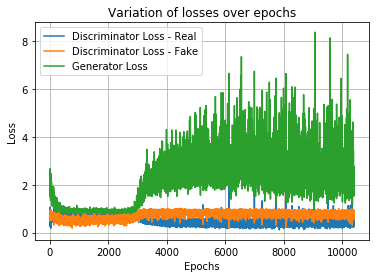

10401 [D loss: 0.415314, acc.: 78.12%] [G loss: 1.975090]
10402 [D loss: 0.296326, acc.: 93.75%] [G loss: 1.442637]
10403 [D loss: 0.220238, acc.: 90.62%] [G loss: 1.624706]
10404 [D loss: 0.317121, acc.: 84.38%] [G loss: 1.413465]
10405 [D loss: 0.328609, acc.: 87.50%] [G loss: 2.285442]
10406 [D loss: 0.321069, acc.: 84.38%] [G loss: 2.501536]
10407 [D loss: 0.493374, acc.: 71.88%] [G loss: 1.938160]
10408 [D loss: 0.408876, acc.: 81.25%] [G loss: 2.568436]
10409 [D loss: 0.469511, acc.: 75.00%] [G loss: 2.634588]
10410 [D loss: 0.363140, acc.: 84.38%] [G loss: 2.816715]
10411 [D loss: 0.265796, acc.: 90.62%] [G loss: 2.969301]
10412 [D loss: 0.374447, acc.: 81.25%] [G loss: 2.681187]
10413 [D loss: 0.442677, acc.: 81.25%] [G loss: 2.035534]
10414 [D loss: 0.420624, acc.: 87.50%] [G loss: 1.827907]
10415 [D loss: 0.664367, acc.: 59.38%] [G loss: 1.479250]
10416 [D loss: 0.371652, acc.: 84.38%] [G loss: 1.290121]
10417 [D loss: 0.349984, acc.: 81.25%] [G loss: 2.017948]
10418 [D loss:

10544 [D loss: 0.376779, acc.: 81.25%] [G loss: 1.862791]
10545 [D loss: 0.383557, acc.: 78.12%] [G loss: 2.846324]
10546 [D loss: 0.428205, acc.: 75.00%] [G loss: 1.846023]
10547 [D loss: 0.558766, acc.: 71.88%] [G loss: 2.294899]
10548 [D loss: 0.378727, acc.: 84.38%] [G loss: 2.356494]
10549 [D loss: 0.373111, acc.: 81.25%] [G loss: 2.184547]
10550 [D loss: 0.225354, acc.: 96.88%] [G loss: 2.285702]
10551 [D loss: 0.240954, acc.: 90.62%] [G loss: 2.657538]
10552 [D loss: 0.447983, acc.: 78.12%] [G loss: 3.102514]
10553 [D loss: 0.450676, acc.: 78.12%] [G loss: 2.142606]
10554 [D loss: 0.333553, acc.: 81.25%] [G loss: 2.901148]
10555 [D loss: 0.208856, acc.: 93.75%] [G loss: 3.361003]
10556 [D loss: 0.449142, acc.: 75.00%] [G loss: 1.935042]
10557 [D loss: 0.452673, acc.: 68.75%] [G loss: 2.411937]
10558 [D loss: 0.157681, acc.: 96.88%] [G loss: 4.831657]
10559 [D loss: 0.345894, acc.: 78.12%] [G loss: 2.517537]
10560 [D loss: 0.218233, acc.: 93.75%] [G loss: 3.083324]
10561 [D loss:

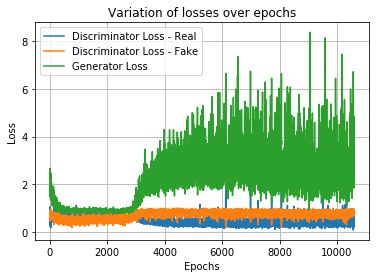

10601 [D loss: 0.333474, acc.: 81.25%] [G loss: 2.452754]
10602 [D loss: 0.636781, acc.: 65.62%] [G loss: 7.581376]
10603 [D loss: 0.951933, acc.: 34.38%] [G loss: 1.602286]
10604 [D loss: 0.603474, acc.: 65.62%] [G loss: 2.853681]
10605 [D loss: 0.272460, acc.: 87.50%] [G loss: 5.187448]
10606 [D loss: 0.281248, acc.: 87.50%] [G loss: 4.749627]
10607 [D loss: 0.369836, acc.: 81.25%] [G loss: 3.165057]
10608 [D loss: 0.274589, acc.: 90.62%] [G loss: 2.759897]
10609 [D loss: 0.281352, acc.: 93.75%] [G loss: 3.531054]
10610 [D loss: 0.295303, acc.: 84.38%] [G loss: 2.882113]
10611 [D loss: 0.342974, acc.: 87.50%] [G loss: 2.898700]
10612 [D loss: 0.464095, acc.: 71.88%] [G loss: 2.366787]
10613 [D loss: 0.291544, acc.: 81.25%] [G loss: 2.460395]
10614 [D loss: 0.263275, acc.: 90.62%] [G loss: 2.220345]
10615 [D loss: 0.432642, acc.: 87.50%] [G loss: 1.852717]
10616 [D loss: 0.244772, acc.: 93.75%] [G loss: 3.270912]
10617 [D loss: 0.408717, acc.: 81.25%] [G loss: 3.400660]
10618 [D loss:

10743 [D loss: 0.444962, acc.: 81.25%] [G loss: 3.739470]
10744 [D loss: 0.389421, acc.: 81.25%] [G loss: 3.873421]
10745 [D loss: 0.340118, acc.: 81.25%] [G loss: 3.139190]
10746 [D loss: 0.449178, acc.: 75.00%] [G loss: 2.169305]
10747 [D loss: 0.317498, acc.: 81.25%] [G loss: 2.736236]
10748 [D loss: 0.403944, acc.: 87.50%] [G loss: 1.794490]
10749 [D loss: 0.475946, acc.: 81.25%] [G loss: 3.147872]
10750 [D loss: 0.360425, acc.: 75.00%] [G loss: 2.833807]
10751 [D loss: 0.493097, acc.: 84.38%] [G loss: 2.700795]
10752 [D loss: 0.283771, acc.: 87.50%] [G loss: 2.738728]
10753 [D loss: 0.547033, acc.: 78.12%] [G loss: 3.242625]
10754 [D loss: 0.183625, acc.: 96.88%] [G loss: 3.947186]
10755 [D loss: 0.326447, acc.: 81.25%] [G loss: 1.914965]
10756 [D loss: 0.403767, acc.: 81.25%] [G loss: 2.030807]
10757 [D loss: 0.258582, acc.: 90.62%] [G loss: 3.044394]
10758 [D loss: 0.315518, acc.: 90.62%] [G loss: 1.884657]
10759 [D loss: 0.470310, acc.: 75.00%] [G loss: 2.223534]
10760 [D loss:

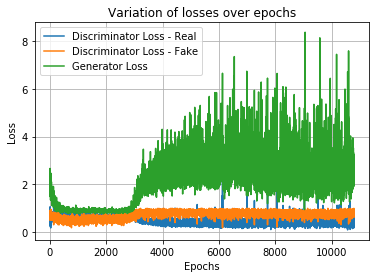

10801 [D loss: 0.290403, acc.: 90.62%] [G loss: 1.997997]
10802 [D loss: 0.509993, acc.: 65.62%] [G loss: 1.433609]
10803 [D loss: 0.334553, acc.: 84.38%] [G loss: 2.604658]
10804 [D loss: 0.480572, acc.: 75.00%] [G loss: 2.719918]
10805 [D loss: 0.352582, acc.: 87.50%] [G loss: 3.252753]
10806 [D loss: 0.622890, acc.: 68.75%] [G loss: 2.893920]
10807 [D loss: 0.416154, acc.: 84.38%] [G loss: 3.039766]
10808 [D loss: 0.193595, acc.: 96.88%] [G loss: 3.074476]
10809 [D loss: 0.567885, acc.: 68.75%] [G loss: 2.852250]
10810 [D loss: 0.343835, acc.: 84.38%] [G loss: 2.905768]
10811 [D loss: 0.388122, acc.: 81.25%] [G loss: 2.189820]
10812 [D loss: 0.258136, acc.: 90.62%] [G loss: 3.033715]
10813 [D loss: 0.275321, acc.: 87.50%] [G loss: 3.075817]
10814 [D loss: 0.449840, acc.: 78.12%] [G loss: 2.438759]
10815 [D loss: 0.378604, acc.: 87.50%] [G loss: 2.369038]
10816 [D loss: 0.527875, acc.: 68.75%] [G loss: 2.446234]
10817 [D loss: 0.345708, acc.: 87.50%] [G loss: 3.044050]
10818 [D loss:

10943 [D loss: 0.376312, acc.: 84.38%] [G loss: 2.614056]
10944 [D loss: 0.424120, acc.: 75.00%] [G loss: 2.696899]
10945 [D loss: 0.390138, acc.: 81.25%] [G loss: 2.658644]
10946 [D loss: 0.419186, acc.: 75.00%] [G loss: 3.030875]
10947 [D loss: 0.538410, acc.: 78.12%] [G loss: 2.262826]
10948 [D loss: 0.390673, acc.: 78.12%] [G loss: 2.474323]
10949 [D loss: 0.382171, acc.: 84.38%] [G loss: 2.554217]
10950 [D loss: 0.659450, acc.: 65.62%] [G loss: 3.541722]
10951 [D loss: 1.023722, acc.: 46.88%] [G loss: 5.108666]
10952 [D loss: 1.666949, acc.: 50.00%] [G loss: 2.808841]
10953 [D loss: 0.507674, acc.: 81.25%] [G loss: 2.295671]
10954 [D loss: 1.161633, acc.: 56.25%] [G loss: 2.933523]
10955 [D loss: 0.655568, acc.: 75.00%] [G loss: 2.993603]
10956 [D loss: 0.311744, acc.: 90.62%] [G loss: 2.592218]
10957 [D loss: 0.418623, acc.: 78.12%] [G loss: 1.766817]
10958 [D loss: 0.256475, acc.: 87.50%] [G loss: 2.494257]
10959 [D loss: 0.347115, acc.: 81.25%] [G loss: 2.454105]
10960 [D loss:

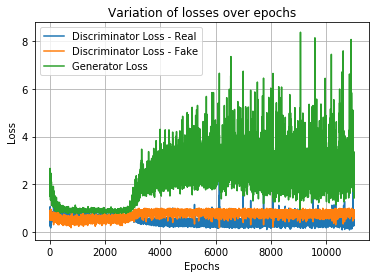

11001 [D loss: 0.396631, acc.: 81.25%] [G loss: 2.519388]
11002 [D loss: 0.244997, acc.: 90.62%] [G loss: 2.689227]
11003 [D loss: 0.462504, acc.: 78.12%] [G loss: 3.043817]
11004 [D loss: 0.357312, acc.: 84.38%] [G loss: 2.953996]
11005 [D loss: 0.319079, acc.: 87.50%] [G loss: 2.966543]
11006 [D loss: 0.352762, acc.: 78.12%] [G loss: 3.252369]
11007 [D loss: 0.310777, acc.: 90.62%] [G loss: 2.631523]
11008 [D loss: 0.281736, acc.: 84.38%] [G loss: 2.264667]
11009 [D loss: 0.337026, acc.: 90.62%] [G loss: 2.933360]
11010 [D loss: 0.325326, acc.: 78.12%] [G loss: 3.400289]
11011 [D loss: 0.337201, acc.: 90.62%] [G loss: 2.883403]
11012 [D loss: 0.290333, acc.: 87.50%] [G loss: 2.794558]
11013 [D loss: 0.421195, acc.: 68.75%] [G loss: 2.310850]
11014 [D loss: 0.387776, acc.: 81.25%] [G loss: 2.433906]
11015 [D loss: 0.604177, acc.: 68.75%] [G loss: 2.540354]
11016 [D loss: 0.377863, acc.: 87.50%] [G loss: 2.153590]
11017 [D loss: 0.405445, acc.: 78.12%] [G loss: 2.971673]
11018 [D loss:

11144 [D loss: 0.519389, acc.: 75.00%] [G loss: 3.145324]
11145 [D loss: 0.304620, acc.: 90.62%] [G loss: 2.802814]
11146 [D loss: 0.405003, acc.: 81.25%] [G loss: 4.502858]
11147 [D loss: 0.238613, acc.: 90.62%] [G loss: 3.749779]
11148 [D loss: 0.536735, acc.: 71.88%] [G loss: 2.886077]
11149 [D loss: 0.503308, acc.: 71.88%] [G loss: 2.606099]
11150 [D loss: 0.362218, acc.: 84.38%] [G loss: 1.582543]
11151 [D loss: 0.278844, acc.: 93.75%] [G loss: 1.983902]
11152 [D loss: 0.569740, acc.: 81.25%] [G loss: 3.503083]
11153 [D loss: 0.479196, acc.: 81.25%] [G loss: 3.585928]
11154 [D loss: 0.490018, acc.: 81.25%] [G loss: 6.108624]
11155 [D loss: 0.360386, acc.: 84.38%] [G loss: 2.936274]
11156 [D loss: 0.500709, acc.: 78.12%] [G loss: 2.358512]
11157 [D loss: 0.176339, acc.: 96.88%] [G loss: 2.524665]
11158 [D loss: 0.309090, acc.: 90.62%] [G loss: 3.753715]
11159 [D loss: 0.319429, acc.: 87.50%] [G loss: 2.725586]
11160 [D loss: 0.388847, acc.: 84.38%] [G loss: 2.101379]
11161 [D loss:

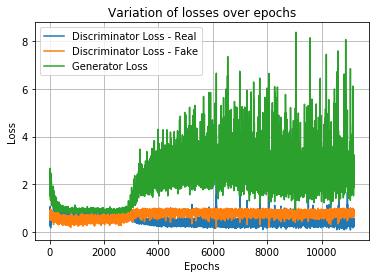

11201 [D loss: 0.379909, acc.: 84.38%] [G loss: 1.769076]
11202 [D loss: 0.518688, acc.: 71.88%] [G loss: 3.946101]
11203 [D loss: 0.269176, acc.: 81.25%] [G loss: 3.602572]
11204 [D loss: 1.223053, acc.: 59.38%] [G loss: 4.358441]
11205 [D loss: 0.606821, acc.: 75.00%] [G loss: 5.546797]
11206 [D loss: 0.620120, acc.: 78.12%] [G loss: 2.297496]
11207 [D loss: 0.652765, acc.: 62.50%] [G loss: 2.648405]
11208 [D loss: 0.270137, acc.: 84.38%] [G loss: 3.483944]
11209 [D loss: 0.458012, acc.: 71.88%] [G loss: 2.918810]
11210 [D loss: 0.510979, acc.: 68.75%] [G loss: 1.871508]
11211 [D loss: 0.441310, acc.: 81.25%] [G loss: 2.498935]
11212 [D loss: 0.446567, acc.: 78.12%] [G loss: 2.588169]
11213 [D loss: 0.399501, acc.: 78.12%] [G loss: 2.275499]
11214 [D loss: 0.447160, acc.: 78.12%] [G loss: 2.246403]
11215 [D loss: 0.474219, acc.: 71.88%] [G loss: 1.817333]
11216 [D loss: 0.357894, acc.: 84.38%] [G loss: 3.207874]
11217 [D loss: 0.384780, acc.: 78.12%] [G loss: 3.348394]
11218 [D loss:

11343 [D loss: 0.815858, acc.: 62.50%] [G loss: 2.745636]
11344 [D loss: 1.322881, acc.: 37.50%] [G loss: 6.200309]
11345 [D loss: 1.124678, acc.: 62.50%] [G loss: 3.472507]
11346 [D loss: 0.723080, acc.: 68.75%] [G loss: 3.013270]
11347 [D loss: 0.591932, acc.: 68.75%] [G loss: 3.181418]
11348 [D loss: 0.453126, acc.: 81.25%] [G loss: 2.063399]
11349 [D loss: 0.566324, acc.: 75.00%] [G loss: 2.208471]
11350 [D loss: 0.559972, acc.: 75.00%] [G loss: 2.014292]
11351 [D loss: 0.502341, acc.: 75.00%] [G loss: 1.404694]
11352 [D loss: 0.331633, acc.: 87.50%] [G loss: 2.334366]
11353 [D loss: 0.425853, acc.: 68.75%] [G loss: 1.822483]
11354 [D loss: 0.585113, acc.: 71.88%] [G loss: 2.148964]
11355 [D loss: 0.474578, acc.: 75.00%] [G loss: 2.823763]
11356 [D loss: 0.312803, acc.: 84.38%] [G loss: 2.129590]
11357 [D loss: 0.305522, acc.: 87.50%] [G loss: 2.150888]
11358 [D loss: 0.542581, acc.: 71.88%] [G loss: 1.961320]
11359 [D loss: 0.487146, acc.: 78.12%] [G loss: 1.514380]
11360 [D loss:

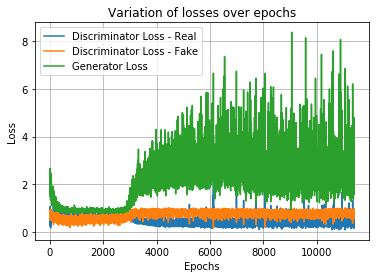

11401 [D loss: 0.680820, acc.: 62.50%] [G loss: 1.845919]
11402 [D loss: 0.443066, acc.: 81.25%] [G loss: 1.415540]
11403 [D loss: 0.433853, acc.: 75.00%] [G loss: 2.788988]
11404 [D loss: 0.290574, acc.: 87.50%] [G loss: 3.152117]
11405 [D loss: 0.240901, acc.: 96.88%] [G loss: 2.183735]
11406 [D loss: 0.404636, acc.: 78.12%] [G loss: 2.746325]
11407 [D loss: 0.378892, acc.: 78.12%] [G loss: 2.466635]
11408 [D loss: 0.385060, acc.: 84.38%] [G loss: 2.543617]
11409 [D loss: 0.306569, acc.: 87.50%] [G loss: 2.731666]
11410 [D loss: 0.603855, acc.: 59.38%] [G loss: 2.606431]
11411 [D loss: 0.295727, acc.: 87.50%] [G loss: 3.737767]
11412 [D loss: 0.376379, acc.: 87.50%] [G loss: 2.808720]
11413 [D loss: 0.196056, acc.: 90.62%] [G loss: 2.250946]
11414 [D loss: 0.209629, acc.: 96.88%] [G loss: 2.658405]
11415 [D loss: 0.357880, acc.: 87.50%] [G loss: 3.387898]
11416 [D loss: 0.312642, acc.: 84.38%] [G loss: 2.644241]
11417 [D loss: 0.440102, acc.: 75.00%] [G loss: 2.523835]
11418 [D loss:

11544 [D loss: 0.344883, acc.: 90.62%] [G loss: 2.905404]
11545 [D loss: 0.431494, acc.: 78.12%] [G loss: 1.928383]
11546 [D loss: 0.320713, acc.: 87.50%] [G loss: 2.124319]
11547 [D loss: 0.438363, acc.: 71.88%] [G loss: 2.538357]
11548 [D loss: 0.506554, acc.: 75.00%] [G loss: 1.960204]
11549 [D loss: 0.482603, acc.: 78.12%] [G loss: 2.018524]
11550 [D loss: 0.458566, acc.: 78.12%] [G loss: 4.401292]
11551 [D loss: 0.374215, acc.: 81.25%] [G loss: 2.683804]
11552 [D loss: 0.444000, acc.: 78.12%] [G loss: 4.411107]
11553 [D loss: 0.742333, acc.: 59.38%] [G loss: 1.928163]
11554 [D loss: 0.361583, acc.: 81.25%] [G loss: 4.730732]
11555 [D loss: 0.282889, acc.: 81.25%] [G loss: 4.286061]
11556 [D loss: 0.179785, acc.: 96.88%] [G loss: 3.034146]
11557 [D loss: 0.545814, acc.: 65.62%] [G loss: 2.376287]
11558 [D loss: 0.220196, acc.: 90.62%] [G loss: 3.415452]
11559 [D loss: 0.512682, acc.: 75.00%] [G loss: 1.995006]
11560 [D loss: 0.204106, acc.: 87.50%] [G loss: 3.015658]
11561 [D loss:

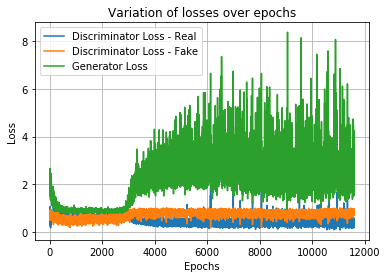

11601 [D loss: 0.512014, acc.: 75.00%] [G loss: 2.523448]
11602 [D loss: 0.567748, acc.: 68.75%] [G loss: 3.078553]
11603 [D loss: 0.243407, acc.: 96.88%] [G loss: 2.790237]
11604 [D loss: 0.387492, acc.: 78.12%] [G loss: 3.281226]
11605 [D loss: 0.351724, acc.: 81.25%] [G loss: 2.219958]
11606 [D loss: 0.343314, acc.: 84.38%] [G loss: 2.883800]
11607 [D loss: 0.449521, acc.: 78.12%] [G loss: 2.803954]
11608 [D loss: 0.289443, acc.: 90.62%] [G loss: 2.457734]
11609 [D loss: 0.374121, acc.: 78.12%] [G loss: 2.449971]
11610 [D loss: 0.545345, acc.: 75.00%] [G loss: 2.411872]
11611 [D loss: 0.288819, acc.: 87.50%] [G loss: 4.101467]
11612 [D loss: 0.405565, acc.: 78.12%] [G loss: 3.515249]
11613 [D loss: 0.622517, acc.: 62.50%] [G loss: 2.165181]
11614 [D loss: 0.466688, acc.: 78.12%] [G loss: 2.821047]
11615 [D loss: 0.545501, acc.: 68.75%] [G loss: 2.430502]
11616 [D loss: 0.386078, acc.: 75.00%] [G loss: 3.804463]
11617 [D loss: 0.371728, acc.: 78.12%] [G loss: 1.933353]
11618 [D loss:

11744 [D loss: 0.442126, acc.: 78.12%] [G loss: 2.405950]
11745 [D loss: 0.453306, acc.: 75.00%] [G loss: 2.919560]
11746 [D loss: 0.344066, acc.: 87.50%] [G loss: 2.914058]
11747 [D loss: 0.327754, acc.: 90.62%] [G loss: 2.315711]
11748 [D loss: 0.421811, acc.: 81.25%] [G loss: 2.260345]
11749 [D loss: 0.397579, acc.: 87.50%] [G loss: 2.085012]
11750 [D loss: 0.493156, acc.: 68.75%] [G loss: 1.928217]
11751 [D loss: 0.421329, acc.: 81.25%] [G loss: 2.185282]
11752 [D loss: 0.280343, acc.: 90.62%] [G loss: 2.408008]
11753 [D loss: 0.269655, acc.: 90.62%] [G loss: 2.334252]
11754 [D loss: 0.484038, acc.: 84.38%] [G loss: 1.299080]
11755 [D loss: 0.399948, acc.: 75.00%] [G loss: 2.479685]
11756 [D loss: 0.332205, acc.: 81.25%] [G loss: 5.172790]
11757 [D loss: 0.494116, acc.: 78.12%] [G loss: 4.430288]
11758 [D loss: 1.052912, acc.: 46.88%] [G loss: 2.368359]
11759 [D loss: 0.466659, acc.: 84.38%] [G loss: 2.462436]
11760 [D loss: 0.461533, acc.: 78.12%] [G loss: 2.153054]
11761 [D loss:

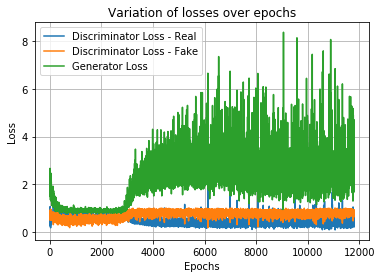

11801 [D loss: 0.418049, acc.: 78.12%] [G loss: 2.984955]
11802 [D loss: 0.330230, acc.: 78.12%] [G loss: 3.203202]
11803 [D loss: 0.478716, acc.: 71.88%] [G loss: 3.440012]
11804 [D loss: 0.339218, acc.: 90.62%] [G loss: 3.090006]
11805 [D loss: 0.209793, acc.: 93.75%] [G loss: 3.920560]
11806 [D loss: 0.276085, acc.: 81.25%] [G loss: 3.968717]
11807 [D loss: 0.240867, acc.: 93.75%] [G loss: 3.800684]
11808 [D loss: 0.400916, acc.: 81.25%] [G loss: 3.702224]
11809 [D loss: 0.411559, acc.: 71.88%] [G loss: 3.358159]
11810 [D loss: 0.217153, acc.: 96.88%] [G loss: 3.267035]
11811 [D loss: 0.440066, acc.: 75.00%] [G loss: 4.884045]
11812 [D loss: 0.233139, acc.: 90.62%] [G loss: 4.733315]
11813 [D loss: 0.370326, acc.: 84.38%] [G loss: 4.850534]
11814 [D loss: 0.292148, acc.: 84.38%] [G loss: 4.458851]
11815 [D loss: 0.146435, acc.: 96.88%] [G loss: 5.245312]
11816 [D loss: 0.285616, acc.: 93.75%] [G loss: 3.977308]
11817 [D loss: 0.352013, acc.: 81.25%] [G loss: 5.144401]
11818 [D loss:

11943 [D loss: 0.282714, acc.: 84.38%] [G loss: 2.042104]
11944 [D loss: 0.394717, acc.: 81.25%] [G loss: 2.929453]
11945 [D loss: 0.452043, acc.: 78.12%] [G loss: 1.910205]
11946 [D loss: 0.225941, acc.: 93.75%] [G loss: 3.011541]
11947 [D loss: 0.201671, acc.: 96.88%] [G loss: 3.141798]
11948 [D loss: 0.302900, acc.: 84.38%] [G loss: 2.498554]
11949 [D loss: 0.187417, acc.: 96.88%] [G loss: 3.890816]
11950 [D loss: 0.388772, acc.: 81.25%] [G loss: 2.220579]
11951 [D loss: 0.355181, acc.: 90.62%] [G loss: 2.850840]
11952 [D loss: 0.418825, acc.: 87.50%] [G loss: 2.821613]
11953 [D loss: 0.367815, acc.: 84.38%] [G loss: 2.754066]
11954 [D loss: 0.466262, acc.: 71.88%] [G loss: 2.460930]
11955 [D loss: 0.501876, acc.: 71.88%] [G loss: 2.134880]
11956 [D loss: 0.634696, acc.: 78.12%] [G loss: 2.081400]
11957 [D loss: 0.432987, acc.: 75.00%] [G loss: 2.101236]
11958 [D loss: 0.339636, acc.: 78.12%] [G loss: 2.985612]
11959 [D loss: 0.311575, acc.: 90.62%] [G loss: 2.530278]
11960 [D loss:

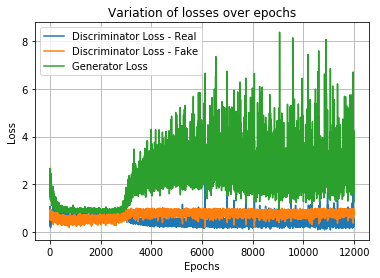

12001 [D loss: 0.322866, acc.: 87.50%] [G loss: 2.557463]
12002 [D loss: 0.486804, acc.: 75.00%] [G loss: 2.370295]
12003 [D loss: 0.308701, acc.: 90.62%] [G loss: 2.267747]
12004 [D loss: 0.430531, acc.: 81.25%] [G loss: 1.622559]
12005 [D loss: 0.534666, acc.: 75.00%] [G loss: 2.521840]
12006 [D loss: 0.429827, acc.: 84.38%] [G loss: 1.798500]
12007 [D loss: 0.370836, acc.: 87.50%] [G loss: 2.554613]
12008 [D loss: 0.515789, acc.: 78.12%] [G loss: 2.260450]
12009 [D loss: 0.212831, acc.: 96.88%] [G loss: 2.057948]
12010 [D loss: 0.332651, acc.: 81.25%] [G loss: 2.779551]
12011 [D loss: 0.358314, acc.: 84.38%] [G loss: 2.765443]
12012 [D loss: 0.610113, acc.: 71.88%] [G loss: 2.706765]
12013 [D loss: 0.423460, acc.: 71.88%] [G loss: 2.609808]
12014 [D loss: 0.302512, acc.: 90.62%] [G loss: 2.183975]
12015 [D loss: 0.436275, acc.: 78.12%] [G loss: 1.987205]
12016 [D loss: 0.380981, acc.: 84.38%] [G loss: 2.184146]
12017 [D loss: 0.391272, acc.: 81.25%] [G loss: 2.197592]
12018 [D loss:

12143 [D loss: 0.352745, acc.: 78.12%] [G loss: 3.072818]
12144 [D loss: 0.395725, acc.: 78.12%] [G loss: 4.967533]
12145 [D loss: 0.334164, acc.: 87.50%] [G loss: 3.447988]
12146 [D loss: 0.259194, acc.: 90.62%] [G loss: 3.672261]
12147 [D loss: 0.492387, acc.: 78.12%] [G loss: 4.170175]
12148 [D loss: 0.342129, acc.: 81.25%] [G loss: 3.232926]
12149 [D loss: 0.252810, acc.: 90.62%] [G loss: 2.804874]
12150 [D loss: 0.315036, acc.: 81.25%] [G loss: 4.071598]
12151 [D loss: 0.260453, acc.: 84.38%] [G loss: 2.789800]
12152 [D loss: 0.361817, acc.: 81.25%] [G loss: 2.734564]
12153 [D loss: 0.277009, acc.: 90.62%] [G loss: 2.209754]
12154 [D loss: 0.279249, acc.: 87.50%] [G loss: 3.006122]
12155 [D loss: 0.486797, acc.: 75.00%] [G loss: 2.998671]
12156 [D loss: 0.505534, acc.: 75.00%] [G loss: 2.597944]
12157 [D loss: 0.162938, acc.: 96.88%] [G loss: 3.146230]
12158 [D loss: 0.436953, acc.: 75.00%] [G loss: 2.049552]
12159 [D loss: 0.447680, acc.: 71.88%] [G loss: 2.212953]
12160 [D loss:

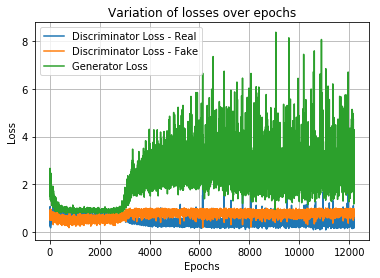

12201 [D loss: 0.182277, acc.: 90.62%] [G loss: 4.189660]
12202 [D loss: 0.516410, acc.: 75.00%] [G loss: 2.454079]
12203 [D loss: 0.457466, acc.: 78.12%] [G loss: 3.608071]
12204 [D loss: 0.308397, acc.: 90.62%] [G loss: 2.995473]
12205 [D loss: 0.609678, acc.: 68.75%] [G loss: 4.241836]
12206 [D loss: 0.527441, acc.: 68.75%] [G loss: 3.817776]
12207 [D loss: 0.401149, acc.: 81.25%] [G loss: 2.891790]
12208 [D loss: 0.275647, acc.: 87.50%] [G loss: 2.634150]
12209 [D loss: 0.171309, acc.: 93.75%] [G loss: 2.095859]
12210 [D loss: 0.319010, acc.: 84.38%] [G loss: 2.337112]
12211 [D loss: 0.420104, acc.: 81.25%] [G loss: 2.428742]
12212 [D loss: 0.381961, acc.: 81.25%] [G loss: 2.315170]
12213 [D loss: 0.436273, acc.: 81.25%] [G loss: 2.300175]
12214 [D loss: 0.335391, acc.: 84.38%] [G loss: 2.707990]
12215 [D loss: 0.493840, acc.: 75.00%] [G loss: 2.243465]
12216 [D loss: 0.413961, acc.: 78.12%] [G loss: 1.833142]
12217 [D loss: 0.319136, acc.: 87.50%] [G loss: 2.684658]
12218 [D loss:

12344 [D loss: 0.347567, acc.: 87.50%] [G loss: 3.117639]
12345 [D loss: 0.539907, acc.: 68.75%] [G loss: 3.523616]
12346 [D loss: 0.299349, acc.: 87.50%] [G loss: 4.985610]
12347 [D loss: 0.491853, acc.: 78.12%] [G loss: 2.285793]
12348 [D loss: 0.369388, acc.: 84.38%] [G loss: 2.184524]
12349 [D loss: 0.311343, acc.: 90.62%] [G loss: 2.267176]
12350 [D loss: 0.299348, acc.: 87.50%] [G loss: 3.073312]
12351 [D loss: 0.287488, acc.: 90.62%] [G loss: 3.868850]
12352 [D loss: 0.254328, acc.: 90.62%] [G loss: 3.271444]
12353 [D loss: 0.563504, acc.: 75.00%] [G loss: 2.988087]
12354 [D loss: 0.205558, acc.: 90.62%] [G loss: 1.873859]
12355 [D loss: 0.362193, acc.: 81.25%] [G loss: 1.842513]
12356 [D loss: 0.290716, acc.: 84.38%] [G loss: 2.952824]
12357 [D loss: 0.258901, acc.: 93.75%] [G loss: 2.273507]
12358 [D loss: 0.360520, acc.: 87.50%] [G loss: 2.600171]
12359 [D loss: 0.378425, acc.: 84.38%] [G loss: 2.679318]
12360 [D loss: 0.345172, acc.: 84.38%] [G loss: 2.109880]
12361 [D loss:

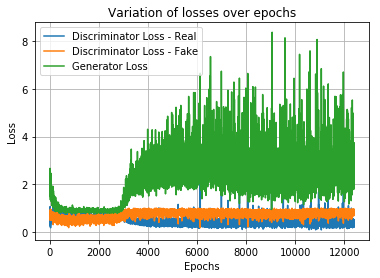

12401 [D loss: 0.245668, acc.: 90.62%] [G loss: 2.914807]
12402 [D loss: 0.282535, acc.: 87.50%] [G loss: 2.981308]
12403 [D loss: 0.389402, acc.: 84.38%] [G loss: 2.740579]
12404 [D loss: 0.321713, acc.: 90.62%] [G loss: 2.368402]
12405 [D loss: 0.366968, acc.: 81.25%] [G loss: 2.305128]
12406 [D loss: 0.295213, acc.: 87.50%] [G loss: 1.989108]
12407 [D loss: 0.536135, acc.: 81.25%] [G loss: 2.601578]
12408 [D loss: 0.348344, acc.: 81.25%] [G loss: 2.347062]
12409 [D loss: 0.427702, acc.: 78.12%] [G loss: 2.472181]
12410 [D loss: 0.410513, acc.: 90.62%] [G loss: 2.137353]
12411 [D loss: 0.259662, acc.: 93.75%] [G loss: 2.402233]
12412 [D loss: 0.394819, acc.: 81.25%] [G loss: 2.332545]
12413 [D loss: 0.353843, acc.: 90.62%] [G loss: 1.838178]
12414 [D loss: 0.405087, acc.: 81.25%] [G loss: 2.046363]
12415 [D loss: 0.278468, acc.: 90.62%] [G loss: 2.060189]
12416 [D loss: 0.418298, acc.: 75.00%] [G loss: 2.251354]
12417 [D loss: 0.271003, acc.: 90.62%] [G loss: 2.952415]
12418 [D loss:

12543 [D loss: 0.339512, acc.: 90.62%] [G loss: 2.575469]
12544 [D loss: 0.238164, acc.: 90.62%] [G loss: 2.639964]
12545 [D loss: 0.283598, acc.: 90.62%] [G loss: 1.985777]
12546 [D loss: 0.271245, acc.: 87.50%] [G loss: 2.003962]
12547 [D loss: 0.316933, acc.: 93.75%] [G loss: 2.281646]
12548 [D loss: 0.349636, acc.: 90.62%] [G loss: 1.713792]
12549 [D loss: 0.464175, acc.: 87.50%] [G loss: 2.375562]
12550 [D loss: 0.564855, acc.: 71.88%] [G loss: 2.313438]
12551 [D loss: 0.433881, acc.: 78.12%] [G loss: 2.333379]
12552 [D loss: 0.423748, acc.: 87.50%] [G loss: 2.405114]
12553 [D loss: 0.305049, acc.: 90.62%] [G loss: 2.294703]
12554 [D loss: 0.386611, acc.: 81.25%] [G loss: 2.608187]
12555 [D loss: 0.437939, acc.: 78.12%] [G loss: 2.570506]
12556 [D loss: 0.359181, acc.: 87.50%] [G loss: 2.714591]
12557 [D loss: 0.252802, acc.: 87.50%] [G loss: 2.221874]
12558 [D loss: 0.293124, acc.: 93.75%] [G loss: 2.917443]
12559 [D loss: 0.523658, acc.: 78.12%] [G loss: 1.973891]
12560 [D loss:

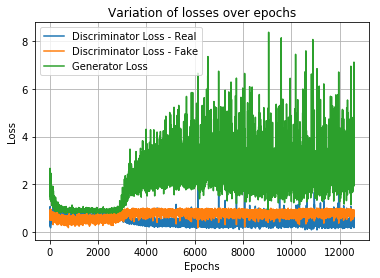

12601 [D loss: 0.224650, acc.: 93.75%] [G loss: 2.772801]
12602 [D loss: 0.219577, acc.: 93.75%] [G loss: 1.796431]
12603 [D loss: 0.423367, acc.: 78.12%] [G loss: 3.281357]
12604 [D loss: 0.240239, acc.: 90.62%] [G loss: 2.587884]
12605 [D loss: 0.373576, acc.: 87.50%] [G loss: 2.200185]
12606 [D loss: 0.368004, acc.: 84.38%] [G loss: 2.695654]
12607 [D loss: 0.711491, acc.: 50.00%] [G loss: 1.282117]
12608 [D loss: 0.453261, acc.: 81.25%] [G loss: 2.147689]
12609 [D loss: 0.415225, acc.: 75.00%] [G loss: 2.232241]
12610 [D loss: 0.246299, acc.: 87.50%] [G loss: 2.602755]
12611 [D loss: 0.799477, acc.: 53.12%] [G loss: 3.606989]
12612 [D loss: 0.525928, acc.: 68.75%] [G loss: 2.197496]
12613 [D loss: 0.322102, acc.: 87.50%] [G loss: 2.815400]
12614 [D loss: 0.171057, acc.: 93.75%] [G loss: 2.901405]
12615 [D loss: 0.380778, acc.: 84.38%] [G loss: 2.534330]
12616 [D loss: 0.651663, acc.: 62.50%] [G loss: 1.132197]
12617 [D loss: 0.591965, acc.: 65.62%] [G loss: 3.274262]
12618 [D loss:

12743 [D loss: 0.455507, acc.: 81.25%] [G loss: 3.168754]
12744 [D loss: 0.378013, acc.: 84.38%] [G loss: 3.163009]
12745 [D loss: 0.340081, acc.: 87.50%] [G loss: 2.666796]
12746 [D loss: 0.570277, acc.: 59.38%] [G loss: 2.221071]
12747 [D loss: 0.460338, acc.: 78.12%] [G loss: 2.197435]
12748 [D loss: 0.476408, acc.: 78.12%] [G loss: 3.153224]
12749 [D loss: 0.252974, acc.: 93.75%] [G loss: 3.517051]
12750 [D loss: 0.378104, acc.: 81.25%] [G loss: 2.474959]
12751 [D loss: 0.280290, acc.: 84.38%] [G loss: 2.710294]
12752 [D loss: 0.313249, acc.: 93.75%] [G loss: 2.991588]
12753 [D loss: 0.263592, acc.: 90.62%] [G loss: 2.641115]
12754 [D loss: 0.351644, acc.: 90.62%] [G loss: 3.289114]
12755 [D loss: 0.360317, acc.: 81.25%] [G loss: 2.489191]
12756 [D loss: 0.359174, acc.: 81.25%] [G loss: 1.972658]
12757 [D loss: 0.385535, acc.: 84.38%] [G loss: 3.726992]
12758 [D loss: 0.439533, acc.: 81.25%] [G loss: 2.181026]
12759 [D loss: 0.336760, acc.: 84.38%] [G loss: 2.929484]
12760 [D loss:

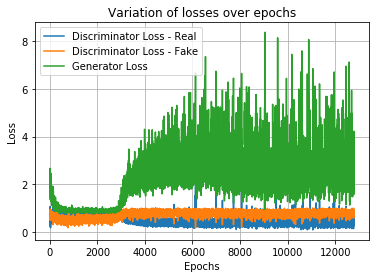

12801 [D loss: 0.305388, acc.: 87.50%] [G loss: 2.718768]
12802 [D loss: 0.356482, acc.: 87.50%] [G loss: 3.445786]
12803 [D loss: 0.181957, acc.: 96.88%] [G loss: 2.291538]
12804 [D loss: 0.270944, acc.: 90.62%] [G loss: 3.956985]
12805 [D loss: 0.332857, acc.: 87.50%] [G loss: 4.387376]
12806 [D loss: 0.216767, acc.: 93.75%] [G loss: 3.209438]
12807 [D loss: 0.164621, acc.: 96.88%] [G loss: 4.481160]
12808 [D loss: 0.415985, acc.: 84.38%] [G loss: 2.426929]
12809 [D loss: 0.231379, acc.: 90.62%] [G loss: 3.249049]
12810 [D loss: 0.374451, acc.: 81.25%] [G loss: 2.269490]
12811 [D loss: 0.211825, acc.: 90.62%] [G loss: 2.600318]
12812 [D loss: 0.471739, acc.: 78.12%] [G loss: 1.984146]
12813 [D loss: 0.420938, acc.: 87.50%] [G loss: 3.125136]
12814 [D loss: 0.393847, acc.: 87.50%] [G loss: 2.804633]
12815 [D loss: 0.445340, acc.: 75.00%] [G loss: 2.264581]
12816 [D loss: 0.263349, acc.: 87.50%] [G loss: 2.434992]
12817 [D loss: 0.399718, acc.: 84.38%] [G loss: 3.075052]
12818 [D loss:

12943 [D loss: 0.563946, acc.: 68.75%] [G loss: 1.487432]
12944 [D loss: 0.443230, acc.: 78.12%] [G loss: 1.489794]
12945 [D loss: 0.302881, acc.: 90.62%] [G loss: 2.059525]
12946 [D loss: 0.299413, acc.: 90.62%] [G loss: 2.078400]
12947 [D loss: 0.391016, acc.: 87.50%] [G loss: 2.119277]
12948 [D loss: 0.373570, acc.: 81.25%] [G loss: 2.548362]
12949 [D loss: 0.407281, acc.: 71.88%] [G loss: 2.456060]
12950 [D loss: 0.412674, acc.: 84.38%] [G loss: 2.490328]
12951 [D loss: 0.255279, acc.: 90.62%] [G loss: 2.807877]
12952 [D loss: 0.264414, acc.: 90.62%] [G loss: 2.041350]
12953 [D loss: 0.402054, acc.: 78.12%] [G loss: 2.811861]
12954 [D loss: 0.297091, acc.: 84.38%] [G loss: 2.685743]
12955 [D loss: 0.383474, acc.: 84.38%] [G loss: 2.935490]
12956 [D loss: 0.222825, acc.: 93.75%] [G loss: 3.249472]
12957 [D loss: 0.465412, acc.: 81.25%] [G loss: 2.073814]
12958 [D loss: 0.564674, acc.: 68.75%] [G loss: 1.878565]
12959 [D loss: 0.221995, acc.: 93.75%] [G loss: 2.860288]
12960 [D loss:

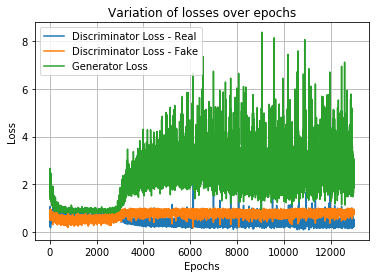

13001 [D loss: 0.265961, acc.: 93.75%] [G loss: 2.570424]
13002 [D loss: 0.377104, acc.: 81.25%] [G loss: 3.414916]
13003 [D loss: 0.234627, acc.: 90.62%] [G loss: 2.640117]
13004 [D loss: 0.272696, acc.: 90.62%] [G loss: 2.232851]
13005 [D loss: 0.442656, acc.: 75.00%] [G loss: 2.669308]
13006 [D loss: 0.235913, acc.: 96.88%] [G loss: 3.000804]
13007 [D loss: 0.433359, acc.: 78.12%] [G loss: 2.616041]
13008 [D loss: 0.220588, acc.: 93.75%] [G loss: 2.876890]
13009 [D loss: 0.373468, acc.: 84.38%] [G loss: 3.755431]
13010 [D loss: 0.285848, acc.: 87.50%] [G loss: 3.721061]
13011 [D loss: 0.225213, acc.: 90.62%] [G loss: 2.898695]
13012 [D loss: 0.374866, acc.: 84.38%] [G loss: 2.425818]
13013 [D loss: 0.522083, acc.: 65.62%] [G loss: 2.648740]
13014 [D loss: 0.283019, acc.: 87.50%] [G loss: 4.110182]
13015 [D loss: 0.390379, acc.: 90.62%] [G loss: 3.372516]
13016 [D loss: 0.308653, acc.: 90.62%] [G loss: 3.013235]
13017 [D loss: 0.303823, acc.: 87.50%] [G loss: 3.833040]
13018 [D loss:

13143 [D loss: 0.327621, acc.: 87.50%] [G loss: 3.488414]
13144 [D loss: 0.294540, acc.: 87.50%] [G loss: 2.891791]
13145 [D loss: 0.404291, acc.: 84.38%] [G loss: 3.051895]
13146 [D loss: 0.521979, acc.: 75.00%] [G loss: 3.143141]
13147 [D loss: 0.608990, acc.: 81.25%] [G loss: 2.679144]
13148 [D loss: 0.220430, acc.: 90.62%] [G loss: 2.941338]
13149 [D loss: 0.322168, acc.: 87.50%] [G loss: 2.620942]
13150 [D loss: 0.737873, acc.: 65.62%] [G loss: 2.125966]
13151 [D loss: 0.264575, acc.: 93.75%] [G loss: 3.210397]
13152 [D loss: 0.344932, acc.: 78.12%] [G loss: 2.442553]
13153 [D loss: 0.266252, acc.: 90.62%] [G loss: 2.499376]
13154 [D loss: 0.264652, acc.: 87.50%] [G loss: 3.110882]
13155 [D loss: 0.248631, acc.: 93.75%] [G loss: 2.470629]
13156 [D loss: 0.341920, acc.: 87.50%] [G loss: 3.117396]
13157 [D loss: 0.252440, acc.: 90.62%] [G loss: 2.812941]
13158 [D loss: 0.531083, acc.: 81.25%] [G loss: 1.994310]
13159 [D loss: 0.293172, acc.: 90.62%] [G loss: 2.096082]
13160 [D loss:

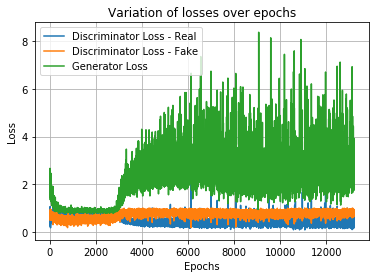

13201 [D loss: 0.343822, acc.: 84.38%] [G loss: 2.498869]
13202 [D loss: 0.345239, acc.: 81.25%] [G loss: 1.673970]
13203 [D loss: 0.326254, acc.: 87.50%] [G loss: 2.812070]
13204 [D loss: 0.478365, acc.: 71.88%] [G loss: 2.035096]
13205 [D loss: 0.417102, acc.: 84.38%] [G loss: 2.112429]
13206 [D loss: 0.385125, acc.: 81.25%] [G loss: 1.696714]
13207 [D loss: 0.408503, acc.: 81.25%] [G loss: 2.189125]
13208 [D loss: 0.375494, acc.: 78.12%] [G loss: 2.757221]
13209 [D loss: 0.287952, acc.: 81.25%] [G loss: 2.138293]
13210 [D loss: 0.501905, acc.: 75.00%] [G loss: 3.197113]
13211 [D loss: 0.346715, acc.: 87.50%] [G loss: 3.461154]
13212 [D loss: 0.470181, acc.: 71.88%] [G loss: 3.120305]
13213 [D loss: 0.366303, acc.: 81.25%] [G loss: 2.100976]
13214 [D loss: 0.332686, acc.: 90.62%] [G loss: 1.796396]
13215 [D loss: 0.178828, acc.: 96.88%] [G loss: 3.788470]
13216 [D loss: 0.406573, acc.: 81.25%] [G loss: 3.520742]
13217 [D loss: 0.426294, acc.: 71.88%] [G loss: 3.213589]
13218 [D loss:

13343 [D loss: 0.334289, acc.: 81.25%] [G loss: 2.220901]
13344 [D loss: 0.288629, acc.: 81.25%] [G loss: 3.164651]
13345 [D loss: 0.255715, acc.: 90.62%] [G loss: 2.669065]
13346 [D loss: 0.363820, acc.: 84.38%] [G loss: 4.262525]
13347 [D loss: 0.258107, acc.: 87.50%] [G loss: 4.438221]
13348 [D loss: 0.425439, acc.: 84.38%] [G loss: 2.950185]
13349 [D loss: 0.284864, acc.: 90.62%] [G loss: 3.415502]
13350 [D loss: 0.486927, acc.: 84.38%] [G loss: 3.122812]
13351 [D loss: 0.543113, acc.: 65.62%] [G loss: 4.115182]
13352 [D loss: 0.538318, acc.: 78.12%] [G loss: 2.955351]
13353 [D loss: 0.453542, acc.: 84.38%] [G loss: 1.922752]
13354 [D loss: 0.580445, acc.: 75.00%] [G loss: 3.292162]
13355 [D loss: 0.321225, acc.: 81.25%] [G loss: 2.474380]
13356 [D loss: 0.249959, acc.: 96.88%] [G loss: 2.260982]
13357 [D loss: 0.274093, acc.: 90.62%] [G loss: 2.091821]
13358 [D loss: 0.227530, acc.: 93.75%] [G loss: 2.302755]
13359 [D loss: 0.490512, acc.: 75.00%] [G loss: 2.150839]
13360 [D loss:

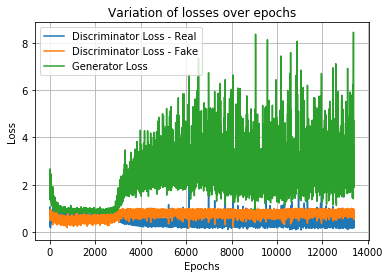

13401 [D loss: 0.347626, acc.: 81.25%] [G loss: 2.084574]
13402 [D loss: 0.435675, acc.: 81.25%] [G loss: 3.611022]
13403 [D loss: 0.273591, acc.: 90.62%] [G loss: 2.840444]
13404 [D loss: 0.460028, acc.: 78.12%] [G loss: 5.401917]
13405 [D loss: 0.827758, acc.: 53.12%] [G loss: 4.830140]
13406 [D loss: 0.381499, acc.: 87.50%] [G loss: 3.058155]
13407 [D loss: 0.449092, acc.: 81.25%] [G loss: 3.222989]
13408 [D loss: 0.236170, acc.: 87.50%] [G loss: 7.511735]
13409 [D loss: 0.563737, acc.: 65.62%] [G loss: 2.990367]
13410 [D loss: 0.308422, acc.: 84.38%] [G loss: 3.727113]
13411 [D loss: 0.525297, acc.: 75.00%] [G loss: 4.087131]
13412 [D loss: 0.205732, acc.: 90.62%] [G loss: 3.599292]
13413 [D loss: 0.512024, acc.: 71.88%] [G loss: 2.780753]
13414 [D loss: 0.361153, acc.: 84.38%] [G loss: 4.360011]
13415 [D loss: 0.240659, acc.: 90.62%] [G loss: 3.067417]
13416 [D loss: 0.417628, acc.: 87.50%] [G loss: 2.707431]
13417 [D loss: 0.326916, acc.: 78.12%] [G loss: 2.894324]
13418 [D loss:

13544 [D loss: 0.272952, acc.: 84.38%] [G loss: 1.886140]
13545 [D loss: 0.576783, acc.: 71.88%] [G loss: 2.227843]
13546 [D loss: 0.252390, acc.: 87.50%] [G loss: 2.433869]
13547 [D loss: 0.297707, acc.: 87.50%] [G loss: 2.075097]
13548 [D loss: 0.469363, acc.: 71.88%] [G loss: 2.622331]
13549 [D loss: 0.451607, acc.: 81.25%] [G loss: 4.405738]
13550 [D loss: 0.234713, acc.: 87.50%] [G loss: 2.675702]
13551 [D loss: 0.198133, acc.: 93.75%] [G loss: 3.424572]
13552 [D loss: 0.297293, acc.: 90.62%] [G loss: 2.236508]
13553 [D loss: 0.280886, acc.: 90.62%] [G loss: 3.617619]
13554 [D loss: 0.417547, acc.: 84.38%] [G loss: 2.572111]
13555 [D loss: 0.262218, acc.: 93.75%] [G loss: 2.396606]
13556 [D loss: 0.407322, acc.: 78.12%] [G loss: 3.166536]
13557 [D loss: 0.422727, acc.: 81.25%] [G loss: 1.834481]
13558 [D loss: 0.384404, acc.: 81.25%] [G loss: 3.317907]
13559 [D loss: 0.363322, acc.: 87.50%] [G loss: 2.756279]
13560 [D loss: 0.288501, acc.: 87.50%] [G loss: 3.130581]
13561 [D loss:

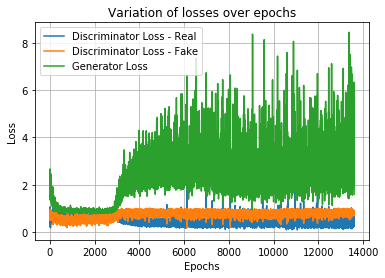

13601 [D loss: 0.373240, acc.: 84.38%] [G loss: 2.681270]
13602 [D loss: 0.360768, acc.: 84.38%] [G loss: 3.100377]
13603 [D loss: 0.372301, acc.: 75.00%] [G loss: 3.207849]
13604 [D loss: 0.341551, acc.: 87.50%] [G loss: 2.673098]
13605 [D loss: 0.347813, acc.: 81.25%] [G loss: 2.332526]
13606 [D loss: 0.386897, acc.: 90.62%] [G loss: 3.142265]
13607 [D loss: 0.408714, acc.: 84.38%] [G loss: 2.121896]
13608 [D loss: 0.342186, acc.: 87.50%] [G loss: 2.438473]
13609 [D loss: 0.270334, acc.: 93.75%] [G loss: 2.398424]
13610 [D loss: 0.208574, acc.: 90.62%] [G loss: 2.670108]
13611 [D loss: 0.384406, acc.: 78.12%] [G loss: 2.718277]
13612 [D loss: 0.499491, acc.: 84.38%] [G loss: 3.114815]
13613 [D loss: 0.417553, acc.: 75.00%] [G loss: 2.755769]
13614 [D loss: 0.391685, acc.: 84.38%] [G loss: 2.937513]
13615 [D loss: 0.308388, acc.: 90.62%] [G loss: 3.011318]
13616 [D loss: 0.425011, acc.: 78.12%] [G loss: 2.073288]
13617 [D loss: 0.282556, acc.: 93.75%] [G loss: 2.752672]
13618 [D loss:

13744 [D loss: 0.173418, acc.: 93.75%] [G loss: 3.368173]
13745 [D loss: 0.205278, acc.: 93.75%] [G loss: 3.453218]
13746 [D loss: 0.236042, acc.: 93.75%] [G loss: 2.925556]
13747 [D loss: 0.206772, acc.: 93.75%] [G loss: 2.583753]
13748 [D loss: 0.186575, acc.: 93.75%] [G loss: 1.851862]
13749 [D loss: 0.342890, acc.: 81.25%] [G loss: 2.456343]
13750 [D loss: 0.366878, acc.: 81.25%] [G loss: 2.511254]
13751 [D loss: 0.172887, acc.: 93.75%] [G loss: 2.557202]
13752 [D loss: 0.336756, acc.: 84.38%] [G loss: 2.576792]
13753 [D loss: 0.572610, acc.: 78.12%] [G loss: 3.462950]
13754 [D loss: 0.241878, acc.: 84.38%] [G loss: 2.470951]
13755 [D loss: 0.273159, acc.: 90.62%] [G loss: 3.790570]
13756 [D loss: 0.288635, acc.: 87.50%] [G loss: 2.588951]
13757 [D loss: 0.272373, acc.: 90.62%] [G loss: 3.237872]
13758 [D loss: 0.270127, acc.: 87.50%] [G loss: 2.456415]
13759 [D loss: 0.331142, acc.: 78.12%] [G loss: 3.464060]
13760 [D loss: 0.336975, acc.: 84.38%] [G loss: 2.478941]
13761 [D loss:

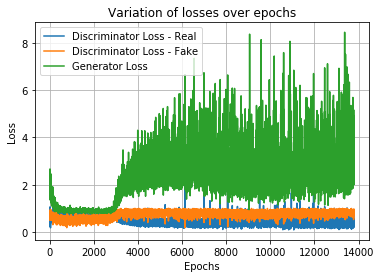

13801 [D loss: 0.274096, acc.: 87.50%] [G loss: 2.547644]
13802 [D loss: 0.221685, acc.: 96.88%] [G loss: 3.335622]
13803 [D loss: 0.261452, acc.: 93.75%] [G loss: 2.663280]
13804 [D loss: 0.366538, acc.: 84.38%] [G loss: 2.653170]
13805 [D loss: 0.366656, acc.: 81.25%] [G loss: 2.310950]
13806 [D loss: 0.440190, acc.: 75.00%] [G loss: 2.461685]
13807 [D loss: 0.275896, acc.: 90.62%] [G loss: 2.729111]
13808 [D loss: 0.311245, acc.: 87.50%] [G loss: 3.484565]
13809 [D loss: 0.261103, acc.: 90.62%] [G loss: 3.557139]
13810 [D loss: 0.297171, acc.: 90.62%] [G loss: 3.443823]
13811 [D loss: 0.282069, acc.: 84.38%] [G loss: 3.266333]
13812 [D loss: 0.289370, acc.: 87.50%] [G loss: 2.184837]
13813 [D loss: 0.514703, acc.: 78.12%] [G loss: 2.064223]
13814 [D loss: 0.540789, acc.: 71.88%] [G loss: 2.643655]
13815 [D loss: 0.271878, acc.: 96.88%] [G loss: 2.207869]
13816 [D loss: 0.542116, acc.: 56.25%] [G loss: 1.672693]
13817 [D loss: 0.323255, acc.: 81.25%] [G loss: 2.136443]
13818 [D loss:

13944 [D loss: 0.481241, acc.: 75.00%] [G loss: 3.680217]
13945 [D loss: 0.224305, acc.: 93.75%] [G loss: 2.833840]
13946 [D loss: 0.342661, acc.: 87.50%] [G loss: 3.685459]
13947 [D loss: 0.207015, acc.: 93.75%] [G loss: 3.069234]
13948 [D loss: 0.294734, acc.: 87.50%] [G loss: 2.533493]
13949 [D loss: 0.389845, acc.: 87.50%] [G loss: 3.097568]
13950 [D loss: 0.427906, acc.: 75.00%] [G loss: 3.441406]
13951 [D loss: 0.304132, acc.: 81.25%] [G loss: 3.183199]
13952 [D loss: 0.239636, acc.: 93.75%] [G loss: 3.439542]
13953 [D loss: 0.255494, acc.: 87.50%] [G loss: 2.678789]
13954 [D loss: 0.224737, acc.: 90.62%] [G loss: 2.501439]
13955 [D loss: 0.438514, acc.: 78.12%] [G loss: 2.600204]
13956 [D loss: 0.461204, acc.: 84.38%] [G loss: 2.242422]
13957 [D loss: 0.280612, acc.: 87.50%] [G loss: 2.896158]
13958 [D loss: 0.357022, acc.: 87.50%] [G loss: 3.142473]
13959 [D loss: 0.576559, acc.: 65.62%] [G loss: 2.542570]
13960 [D loss: 0.330427, acc.: 87.50%] [G loss: 2.463811]
13961 [D loss:

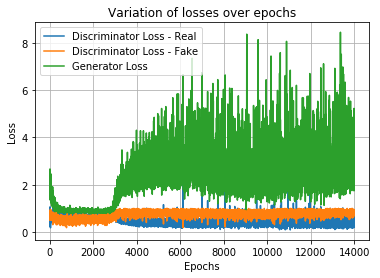

14001 [D loss: 0.426679, acc.: 81.25%] [G loss: 3.367488]
14002 [D loss: 0.291537, acc.: 90.62%] [G loss: 2.497085]
14003 [D loss: 0.315910, acc.: 84.38%] [G loss: 2.775160]
14004 [D loss: 0.411988, acc.: 71.88%] [G loss: 2.202005]
14005 [D loss: 0.364204, acc.: 78.12%] [G loss: 3.364831]
14006 [D loss: 0.352393, acc.: 84.38%] [G loss: 2.840597]
14007 [D loss: 0.405890, acc.: 90.62%] [G loss: 2.024064]
14008 [D loss: 0.288547, acc.: 87.50%] [G loss: 3.232658]
14009 [D loss: 0.556605, acc.: 75.00%] [G loss: 2.418674]
14010 [D loss: 0.444227, acc.: 90.62%] [G loss: 3.037334]
14011 [D loss: 0.648211, acc.: 71.88%] [G loss: 3.546642]
14012 [D loss: 0.664058, acc.: 59.38%] [G loss: 4.859487]
14013 [D loss: 0.198336, acc.: 93.75%] [G loss: 6.515420]
14014 [D loss: 0.310811, acc.: 87.50%] [G loss: 4.124322]
14015 [D loss: 0.330101, acc.: 90.62%] [G loss: 4.534033]
14016 [D loss: 0.305526, acc.: 90.62%] [G loss: 2.934066]
14017 [D loss: 0.356360, acc.: 87.50%] [G loss: 4.412477]
14018 [D loss:

14143 [D loss: 0.421182, acc.: 81.25%] [G loss: 2.150810]
14144 [D loss: 0.309550, acc.: 84.38%] [G loss: 1.815161]
14145 [D loss: 0.310594, acc.: 81.25%] [G loss: 2.394971]
14146 [D loss: 0.310144, acc.: 84.38%] [G loss: 3.205349]
14147 [D loss: 0.300157, acc.: 90.62%] [G loss: 3.260179]
14148 [D loss: 0.517278, acc.: 81.25%] [G loss: 2.735017]
14149 [D loss: 0.385010, acc.: 78.12%] [G loss: 2.994567]
14150 [D loss: 0.242844, acc.: 90.62%] [G loss: 3.431049]
14151 [D loss: 0.729840, acc.: 62.50%] [G loss: 3.130768]
14152 [D loss: 0.390362, acc.: 84.38%] [G loss: 2.233468]
14153 [D loss: 0.425058, acc.: 71.88%] [G loss: 3.076294]
14154 [D loss: 0.265765, acc.: 87.50%] [G loss: 2.463635]
14155 [D loss: 0.401759, acc.: 81.25%] [G loss: 3.266434]
14156 [D loss: 0.215051, acc.: 87.50%] [G loss: 4.242474]
14157 [D loss: 0.442852, acc.: 71.88%] [G loss: 2.647210]
14158 [D loss: 0.468889, acc.: 75.00%] [G loss: 3.444787]
14159 [D loss: 0.528614, acc.: 81.25%] [G loss: 2.538640]
14160 [D loss:

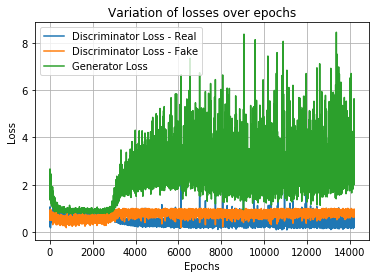

14201 [D loss: 0.464282, acc.: 81.25%] [G loss: 2.583835]
14202 [D loss: 0.331260, acc.: 84.38%] [G loss: 3.375995]
14203 [D loss: 0.362444, acc.: 75.00%] [G loss: 3.460032]
14204 [D loss: 0.213498, acc.: 96.88%] [G loss: 3.164944]
14205 [D loss: 0.328617, acc.: 81.25%] [G loss: 4.099019]
14206 [D loss: 0.220099, acc.: 90.62%] [G loss: 3.018852]
14207 [D loss: 0.308223, acc.: 90.62%] [G loss: 2.945758]
14208 [D loss: 0.485452, acc.: 81.25%] [G loss: 2.883795]
14209 [D loss: 0.460937, acc.: 78.12%] [G loss: 3.025073]
14210 [D loss: 0.259991, acc.: 90.62%] [G loss: 3.033916]
14211 [D loss: 0.203835, acc.: 93.75%] [G loss: 2.842633]
14212 [D loss: 0.304542, acc.: 84.38%] [G loss: 3.283448]
14213 [D loss: 0.293150, acc.: 84.38%] [G loss: 2.039914]
14214 [D loss: 0.272741, acc.: 87.50%] [G loss: 2.332959]
14215 [D loss: 0.300384, acc.: 90.62%] [G loss: 2.856688]
14216 [D loss: 0.427077, acc.: 78.12%] [G loss: 2.449609]
14217 [D loss: 0.371182, acc.: 87.50%] [G loss: 2.999884]
14218 [D loss:

14343 [D loss: 0.308236, acc.: 87.50%] [G loss: 3.433809]
14344 [D loss: 0.284497, acc.: 84.38%] [G loss: 3.230146]
14345 [D loss: 0.174798, acc.: 96.88%] [G loss: 2.961689]
14346 [D loss: 0.418379, acc.: 78.12%] [G loss: 3.316065]
14347 [D loss: 0.315716, acc.: 87.50%] [G loss: 3.685951]
14348 [D loss: 0.266156, acc.: 84.38%] [G loss: 2.648617]
14349 [D loss: 0.270525, acc.: 87.50%] [G loss: 3.824166]
14350 [D loss: 0.607667, acc.: 75.00%] [G loss: 3.343567]
14351 [D loss: 0.317177, acc.: 90.62%] [G loss: 2.495221]
14352 [D loss: 0.391762, acc.: 75.00%] [G loss: 3.413664]
14353 [D loss: 0.205932, acc.: 93.75%] [G loss: 3.430520]
14354 [D loss: 0.231023, acc.: 90.62%] [G loss: 2.595366]
14355 [D loss: 0.293611, acc.: 90.62%] [G loss: 3.596694]
14356 [D loss: 0.209266, acc.: 93.75%] [G loss: 3.089557]
14357 [D loss: 0.323289, acc.: 84.38%] [G loss: 3.965859]
14358 [D loss: 0.417378, acc.: 75.00%] [G loss: 3.178055]
14359 [D loss: 0.278411, acc.: 90.62%] [G loss: 4.731785]
14360 [D loss:

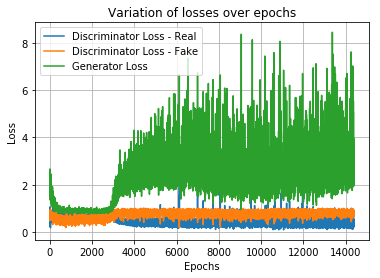

14401 [D loss: 0.424330, acc.: 78.12%] [G loss: 2.228624]
14402 [D loss: 0.203556, acc.: 93.75%] [G loss: 2.783076]
14403 [D loss: 0.550629, acc.: 75.00%] [G loss: 2.787870]
14404 [D loss: 0.388480, acc.: 81.25%] [G loss: 2.533979]
14405 [D loss: 0.295864, acc.: 90.62%] [G loss: 3.582655]
14406 [D loss: 0.345016, acc.: 81.25%] [G loss: 3.142298]
14407 [D loss: 0.338452, acc.: 87.50%] [G loss: 3.046513]
14408 [D loss: 0.306852, acc.: 90.62%] [G loss: 2.761279]
14409 [D loss: 0.268362, acc.: 93.75%] [G loss: 4.327155]
14410 [D loss: 0.311540, acc.: 84.38%] [G loss: 2.375067]
14411 [D loss: 0.420080, acc.: 78.12%] [G loss: 2.477494]
14412 [D loss: 0.281476, acc.: 90.62%] [G loss: 2.685503]
14413 [D loss: 0.418651, acc.: 78.12%] [G loss: 4.403072]
14414 [D loss: 0.294189, acc.: 90.62%] [G loss: 2.509956]
14415 [D loss: 0.429952, acc.: 71.88%] [G loss: 5.318139]
14416 [D loss: 0.550386, acc.: 84.38%] [G loss: 1.879563]
14417 [D loss: 0.397485, acc.: 84.38%] [G loss: 2.472316]
14418 [D loss:

14543 [D loss: 0.303944, acc.: 84.38%] [G loss: 2.634375]
14544 [D loss: 0.389156, acc.: 81.25%] [G loss: 2.485500]
14545 [D loss: 0.408575, acc.: 81.25%] [G loss: 2.341540]
14546 [D loss: 0.370262, acc.: 81.25%] [G loss: 1.751578]
14547 [D loss: 0.209642, acc.: 93.75%] [G loss: 1.721279]
14548 [D loss: 0.498599, acc.: 75.00%] [G loss: 2.514081]
14549 [D loss: 0.277621, acc.: 93.75%] [G loss: 2.641234]
14550 [D loss: 0.355415, acc.: 87.50%] [G loss: 2.257099]
14551 [D loss: 0.331623, acc.: 87.50%] [G loss: 2.102493]
14552 [D loss: 0.464666, acc.: 78.12%] [G loss: 2.529780]
14553 [D loss: 0.411057, acc.: 84.38%] [G loss: 1.700187]
14554 [D loss: 0.412331, acc.: 81.25%] [G loss: 3.306553]
14555 [D loss: 0.209466, acc.: 93.75%] [G loss: 2.230050]
14556 [D loss: 0.402257, acc.: 81.25%] [G loss: 2.698497]
14557 [D loss: 0.248185, acc.: 87.50%] [G loss: 3.008318]
14558 [D loss: 0.407593, acc.: 78.12%] [G loss: 2.341419]
14559 [D loss: 0.451310, acc.: 81.25%] [G loss: 2.579154]
14560 [D loss:

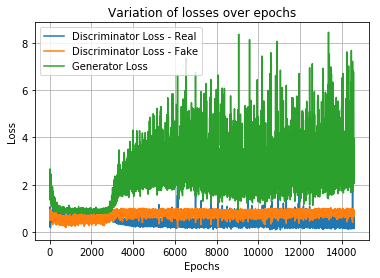

14601 [D loss: 0.317335, acc.: 84.38%] [G loss: 2.265623]
14602 [D loss: 0.519384, acc.: 81.25%] [G loss: 2.740540]
14603 [D loss: 0.590752, acc.: 68.75%] [G loss: 1.689011]
14604 [D loss: 0.227507, acc.: 90.62%] [G loss: 1.944253]
14605 [D loss: 0.620923, acc.: 71.88%] [G loss: 2.205917]
14606 [D loss: 0.341688, acc.: 87.50%] [G loss: 1.955749]
14607 [D loss: 0.379783, acc.: 75.00%] [G loss: 2.046862]
14608 [D loss: 0.306371, acc.: 84.38%] [G loss: 2.342422]
14609 [D loss: 0.390952, acc.: 84.38%] [G loss: 2.379516]
14610 [D loss: 0.487653, acc.: 78.12%] [G loss: 2.052192]
14611 [D loss: 0.281281, acc.: 87.50%] [G loss: 2.564018]
14612 [D loss: 0.411042, acc.: 78.12%] [G loss: 2.410343]
14613 [D loss: 0.420152, acc.: 75.00%] [G loss: 2.043188]
14614 [D loss: 0.406743, acc.: 90.62%] [G loss: 2.047784]
14615 [D loss: 0.436105, acc.: 78.12%] [G loss: 2.029472]
14616 [D loss: 0.378590, acc.: 90.62%] [G loss: 2.572339]
14617 [D loss: 0.816844, acc.: 65.62%] [G loss: 2.809919]
14618 [D loss:

14744 [D loss: 0.261931, acc.: 90.62%] [G loss: 2.728440]
14745 [D loss: 0.323649, acc.: 81.25%] [G loss: 3.172626]
14746 [D loss: 0.551316, acc.: 71.88%] [G loss: 2.720601]
14747 [D loss: 0.355150, acc.: 81.25%] [G loss: 3.244232]
14748 [D loss: 0.765253, acc.: 56.25%] [G loss: 2.979127]
14749 [D loss: 0.185594, acc.: 96.88%] [G loss: 3.477472]
14750 [D loss: 0.449977, acc.: 81.25%] [G loss: 2.442141]
14751 [D loss: 0.374162, acc.: 81.25%] [G loss: 2.280981]
14752 [D loss: 0.247543, acc.: 93.75%] [G loss: 2.543023]
14753 [D loss: 0.375414, acc.: 87.50%] [G loss: 2.201159]
14754 [D loss: 0.477540, acc.: 71.88%] [G loss: 2.852300]
14755 [D loss: 0.380278, acc.: 81.25%] [G loss: 3.089343]
14756 [D loss: 0.334599, acc.: 87.50%] [G loss: 3.074666]
14757 [D loss: 0.360465, acc.: 84.38%] [G loss: 4.575313]
14758 [D loss: 0.284456, acc.: 87.50%] [G loss: 3.197434]
14759 [D loss: 0.559110, acc.: 75.00%] [G loss: 4.982575]
14760 [D loss: 0.202195, acc.: 90.62%] [G loss: 4.233356]
14761 [D loss:

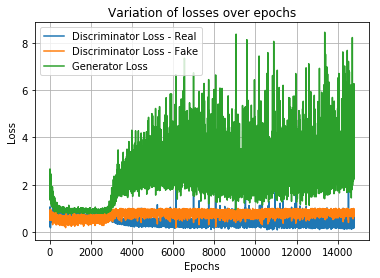

14801 [D loss: 0.389030, acc.: 87.50%] [G loss: 3.218204]
14802 [D loss: 0.488225, acc.: 81.25%] [G loss: 2.413693]
14803 [D loss: 0.350786, acc.: 84.38%] [G loss: 4.352813]
14804 [D loss: 0.268812, acc.: 84.38%] [G loss: 2.730598]
14805 [D loss: 0.346783, acc.: 84.38%] [G loss: 2.850982]
14806 [D loss: 0.325986, acc.: 87.50%] [G loss: 3.479896]
14807 [D loss: 0.759982, acc.: 68.75%] [G loss: 2.730712]
14808 [D loss: 0.329366, acc.: 84.38%] [G loss: 5.177277]
14809 [D loss: 0.348008, acc.: 90.62%] [G loss: 3.699290]
14810 [D loss: 0.429635, acc.: 75.00%] [G loss: 3.031354]
14811 [D loss: 0.379589, acc.: 84.38%] [G loss: 2.940973]
14812 [D loss: 0.319570, acc.: 84.38%] [G loss: 3.416158]
14813 [D loss: 0.346392, acc.: 84.38%] [G loss: 3.204354]
14814 [D loss: 0.391935, acc.: 87.50%] [G loss: 4.031109]
14815 [D loss: 0.272471, acc.: 93.75%] [G loss: 3.806451]
14816 [D loss: 0.256677, acc.: 87.50%] [G loss: 4.177656]
14817 [D loss: 0.459173, acc.: 75.00%] [G loss: 3.545828]
14818 [D loss:

14943 [D loss: 0.354173, acc.: 84.38%] [G loss: 3.005145]
14944 [D loss: 0.295369, acc.: 87.50%] [G loss: 2.552585]
14945 [D loss: 0.358059, acc.: 78.12%] [G loss: 1.909718]
14946 [D loss: 0.270812, acc.: 87.50%] [G loss: 2.229397]
14947 [D loss: 0.325084, acc.: 87.50%] [G loss: 2.142913]
14948 [D loss: 0.346681, acc.: 90.62%] [G loss: 2.005512]
14949 [D loss: 0.306616, acc.: 90.62%] [G loss: 2.244246]
14950 [D loss: 0.339931, acc.: 81.25%] [G loss: 2.405108]
14951 [D loss: 0.515692, acc.: 68.75%] [G loss: 3.567781]
14952 [D loss: 0.348887, acc.: 84.38%] [G loss: 2.818632]
14953 [D loss: 0.361113, acc.: 87.50%] [G loss: 4.440435]
14954 [D loss: 0.379478, acc.: 81.25%] [G loss: 4.716684]
14955 [D loss: 0.268340, acc.: 87.50%] [G loss: 3.231613]
14956 [D loss: 0.342525, acc.: 87.50%] [G loss: 4.654383]
14957 [D loss: 0.299220, acc.: 87.50%] [G loss: 3.469050]
14958 [D loss: 0.326952, acc.: 87.50%] [G loss: 2.059932]
14959 [D loss: 0.499324, acc.: 75.00%] [G loss: 3.412888]
14960 [D loss:

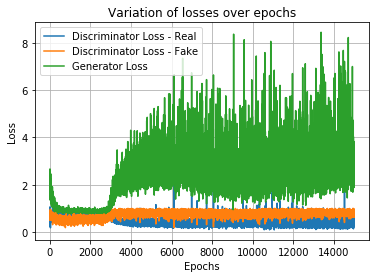

15001 [D loss: 0.495000, acc.: 81.25%] [G loss: 1.993778]
15002 [D loss: 0.449849, acc.: 75.00%] [G loss: 2.279582]
15003 [D loss: 0.209125, acc.: 96.88%] [G loss: 3.341672]
15004 [D loss: 0.370832, acc.: 78.12%] [G loss: 2.188057]
15005 [D loss: 0.337539, acc.: 87.50%] [G loss: 3.764095]
15006 [D loss: 0.342372, acc.: 84.38%] [G loss: 2.628956]
15007 [D loss: 0.549017, acc.: 71.88%] [G loss: 2.076030]
15008 [D loss: 0.433364, acc.: 78.12%] [G loss: 2.323730]
15009 [D loss: 0.612612, acc.: 87.50%] [G loss: 2.296392]
15010 [D loss: 0.393421, acc.: 75.00%] [G loss: 2.332059]
15011 [D loss: 0.355475, acc.: 84.38%] [G loss: 3.451369]
15012 [D loss: 0.334842, acc.: 87.50%] [G loss: 2.602679]
15013 [D loss: 0.530356, acc.: 68.75%] [G loss: 4.764940]
15014 [D loss: 0.658722, acc.: 68.75%] [G loss: 3.089358]
15015 [D loss: 0.431228, acc.: 71.88%] [G loss: 1.933352]
15016 [D loss: 0.158524, acc.: 93.75%] [G loss: 2.284328]
15017 [D loss: 0.228655, acc.: 90.62%] [G loss: 2.925137]
15018 [D loss:

15143 [D loss: 0.363690, acc.: 84.38%] [G loss: 2.738282]
15144 [D loss: 0.246780, acc.: 87.50%] [G loss: 2.354949]
15145 [D loss: 0.325089, acc.: 87.50%] [G loss: 2.718248]
15146 [D loss: 0.355223, acc.: 78.12%] [G loss: 2.793552]
15147 [D loss: 0.511576, acc.: 78.12%] [G loss: 3.255132]
15148 [D loss: 0.218553, acc.: 90.62%] [G loss: 3.134364]
15149 [D loss: 0.296751, acc.: 93.75%] [G loss: 2.239764]
15150 [D loss: 0.274229, acc.: 90.62%] [G loss: 2.865346]
15151 [D loss: 0.370040, acc.: 81.25%] [G loss: 2.222311]
15152 [D loss: 0.364587, acc.: 81.25%] [G loss: 3.490467]
15153 [D loss: 0.400312, acc.: 81.25%] [G loss: 4.550255]
15154 [D loss: 0.367418, acc.: 90.62%] [G loss: 3.129582]
15155 [D loss: 0.462571, acc.: 81.25%] [G loss: 3.564263]
15156 [D loss: 0.234199, acc.: 90.62%] [G loss: 3.621518]
15157 [D loss: 0.350861, acc.: 87.50%] [G loss: 2.670152]
15158 [D loss: 0.438792, acc.: 75.00%] [G loss: 4.445125]
15159 [D loss: 0.335128, acc.: 84.38%] [G loss: 2.947467]
15160 [D loss:

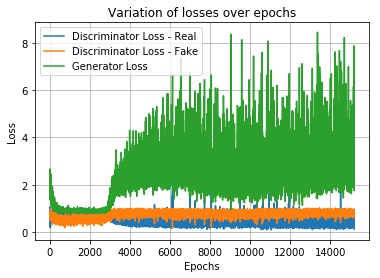

15201 [D loss: 0.209065, acc.: 96.88%] [G loss: 3.252305]
15202 [D loss: 0.418766, acc.: 78.12%] [G loss: 2.699482]
15203 [D loss: 0.326239, acc.: 84.38%] [G loss: 2.838647]
15204 [D loss: 0.392203, acc.: 81.25%] [G loss: 3.454720]
15205 [D loss: 0.479642, acc.: 71.88%] [G loss: 2.904882]
15206 [D loss: 0.394367, acc.: 78.12%] [G loss: 2.857848]
15207 [D loss: 0.337880, acc.: 87.50%] [G loss: 3.552716]
15208 [D loss: 0.308476, acc.: 87.50%] [G loss: 5.211730]
15209 [D loss: 0.233569, acc.: 90.62%] [G loss: 7.901199]
15210 [D loss: 0.274626, acc.: 87.50%] [G loss: 9.886568]
15211 [D loss: 0.116477, acc.: 96.88%] [G loss: 7.407196]
15212 [D loss: 0.214225, acc.: 90.62%] [G loss: 5.468793]
15213 [D loss: 0.187569, acc.: 96.88%] [G loss: 4.436573]
15214 [D loss: 0.409900, acc.: 84.38%] [G loss: 3.896901]
15215 [D loss: 0.215467, acc.: 93.75%] [G loss: 2.850230]
15216 [D loss: 0.483738, acc.: 75.00%] [G loss: 3.304973]
15217 [D loss: 0.589856, acc.: 87.50%] [G loss: 2.818124]
15218 [D loss:

15343 [D loss: 0.412472, acc.: 84.38%] [G loss: 3.625117]
15344 [D loss: 0.453227, acc.: 81.25%] [G loss: 2.747157]
15345 [D loss: 0.658118, acc.: 65.62%] [G loss: 2.197702]
15346 [D loss: 0.307005, acc.: 87.50%] [G loss: 2.672225]
15347 [D loss: 0.222644, acc.: 93.75%] [G loss: 2.853589]
15348 [D loss: 0.285830, acc.: 84.38%] [G loss: 2.525815]
15349 [D loss: 0.478311, acc.: 75.00%] [G loss: 2.158683]
15350 [D loss: 0.325022, acc.: 87.50%] [G loss: 2.536958]
15351 [D loss: 0.328579, acc.: 87.50%] [G loss: 1.783509]
15352 [D loss: 0.323321, acc.: 93.75%] [G loss: 2.915479]
15353 [D loss: 0.316821, acc.: 84.38%] [G loss: 4.194577]
15354 [D loss: 0.324745, acc.: 87.50%] [G loss: 2.339444]
15355 [D loss: 0.230839, acc.: 90.62%] [G loss: 2.241158]
15356 [D loss: 0.549660, acc.: 68.75%] [G loss: 2.740567]
15357 [D loss: 0.205237, acc.: 90.62%] [G loss: 4.242368]
15358 [D loss: 0.462318, acc.: 75.00%] [G loss: 6.166070]
15359 [D loss: 0.570669, acc.: 71.88%] [G loss: 2.787411]
15360 [D loss:

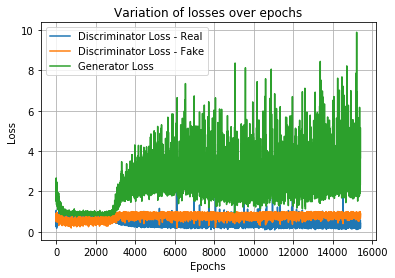

15401 [D loss: 0.493821, acc.: 84.38%] [G loss: 3.427780]
15402 [D loss: 0.396566, acc.: 81.25%] [G loss: 3.246800]
15403 [D loss: 0.171758, acc.: 100.00%] [G loss: 3.957157]
15404 [D loss: 0.660262, acc.: 65.62%] [G loss: 3.046314]
15405 [D loss: 0.787248, acc.: 71.88%] [G loss: 2.974053]
15406 [D loss: 0.414845, acc.: 81.25%] [G loss: 2.710869]
15407 [D loss: 0.243063, acc.: 93.75%] [G loss: 2.437254]
15408 [D loss: 0.568715, acc.: 81.25%] [G loss: 2.510915]
15409 [D loss: 0.353076, acc.: 78.12%] [G loss: 2.390415]
15410 [D loss: 0.306944, acc.: 87.50%] [G loss: 2.554013]
15411 [D loss: 0.309638, acc.: 81.25%] [G loss: 2.813027]
15412 [D loss: 0.388057, acc.: 81.25%] [G loss: 3.176922]
15413 [D loss: 0.184485, acc.: 87.50%] [G loss: 3.283049]
15414 [D loss: 0.573943, acc.: 75.00%] [G loss: 2.733448]
15415 [D loss: 0.519632, acc.: 68.75%] [G loss: 2.817863]
15416 [D loss: 0.448777, acc.: 81.25%] [G loss: 3.017143]
15417 [D loss: 0.546533, acc.: 71.88%] [G loss: 3.535888]
15418 [D loss

15543 [D loss: 0.810562, acc.: 59.38%] [G loss: 4.769691]
15544 [D loss: 0.498264, acc.: 71.88%] [G loss: 3.528595]
15545 [D loss: 0.896008, acc.: 75.00%] [G loss: 6.856936]
15546 [D loss: 0.631351, acc.: 71.88%] [G loss: 2.075654]
15547 [D loss: 0.382639, acc.: 84.38%] [G loss: 3.370909]
15548 [D loss: 0.474703, acc.: 81.25%] [G loss: 2.695536]
15549 [D loss: 0.400003, acc.: 78.12%] [G loss: 2.428490]
15550 [D loss: 0.229418, acc.: 90.62%] [G loss: 4.535963]
15551 [D loss: 0.501529, acc.: 71.88%] [G loss: 2.578456]
15552 [D loss: 0.337284, acc.: 84.38%] [G loss: 3.223774]
15553 [D loss: 0.175002, acc.: 93.75%] [G loss: 2.049689]
15554 [D loss: 0.410377, acc.: 81.25%] [G loss: 2.302581]
15555 [D loss: 0.611058, acc.: 65.62%] [G loss: 1.998713]
15556 [D loss: 0.424912, acc.: 78.12%] [G loss: 2.291511]
15557 [D loss: 0.509494, acc.: 75.00%] [G loss: 2.551175]
15558 [D loss: 0.360633, acc.: 87.50%] [G loss: 3.614345]
15559 [D loss: 0.448666, acc.: 84.38%] [G loss: 3.415593]
15560 [D loss:

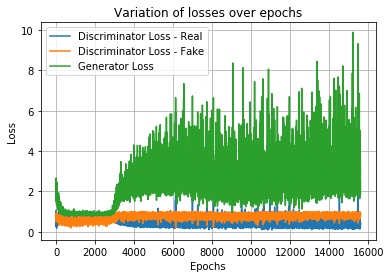

15601 [D loss: 0.513598, acc.: 75.00%] [G loss: 3.593827]
15602 [D loss: 0.417644, acc.: 78.12%] [G loss: 2.409425]
15603 [D loss: 0.306611, acc.: 87.50%] [G loss: 2.265292]
15604 [D loss: 0.333786, acc.: 84.38%] [G loss: 3.659137]
15605 [D loss: 0.363458, acc.: 78.12%] [G loss: 3.229434]
15606 [D loss: 0.467903, acc.: 75.00%] [G loss: 4.035989]
15607 [D loss: 0.231557, acc.: 90.62%] [G loss: 3.297170]
15608 [D loss: 0.449367, acc.: 75.00%] [G loss: 2.990009]
15609 [D loss: 0.288472, acc.: 93.75%] [G loss: 2.607980]
15610 [D loss: 0.406422, acc.: 71.88%] [G loss: 2.415753]
15611 [D loss: 0.285984, acc.: 87.50%] [G loss: 2.431637]
15612 [D loss: 0.394383, acc.: 75.00%] [G loss: 2.416116]
15613 [D loss: 0.258752, acc.: 90.62%] [G loss: 2.525657]
15614 [D loss: 0.420251, acc.: 78.12%] [G loss: 1.942270]
15615 [D loss: 0.529751, acc.: 71.88%] [G loss: 2.034875]
15616 [D loss: 0.327218, acc.: 90.62%] [G loss: 2.906878]
15617 [D loss: 0.438250, acc.: 68.75%] [G loss: 2.799076]
15618 [D loss:

15744 [D loss: 0.270028, acc.: 93.75%] [G loss: 2.647521]
15745 [D loss: 0.284175, acc.: 84.38%] [G loss: 2.306010]
15746 [D loss: 0.360719, acc.: 81.25%] [G loss: 2.951812]
15747 [D loss: 0.318021, acc.: 84.38%] [G loss: 2.685667]
15748 [D loss: 0.374605, acc.: 87.50%] [G loss: 2.821106]
15749 [D loss: 0.527271, acc.: 84.38%] [G loss: 1.853500]
15750 [D loss: 0.328434, acc.: 81.25%] [G loss: 2.594246]
15751 [D loss: 0.567796, acc.: 65.62%] [G loss: 1.939626]
15752 [D loss: 0.350506, acc.: 87.50%] [G loss: 2.697044]
15753 [D loss: 0.302039, acc.: 90.62%] [G loss: 2.764874]
15754 [D loss: 0.240766, acc.: 90.62%] [G loss: 2.719151]
15755 [D loss: 0.588498, acc.: 75.00%] [G loss: 3.320570]
15756 [D loss: 0.244923, acc.: 96.88%] [G loss: 2.434891]
15757 [D loss: 0.338884, acc.: 84.38%] [G loss: 2.477200]
15758 [D loss: 0.378710, acc.: 81.25%] [G loss: 3.184585]
15759 [D loss: 0.322263, acc.: 84.38%] [G loss: 3.272652]
15760 [D loss: 0.307167, acc.: 90.62%] [G loss: 2.644871]
15761 [D loss:

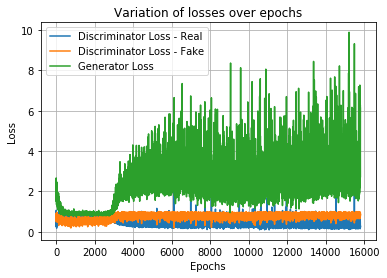

15801 [D loss: 0.158985, acc.: 96.88%] [G loss: 2.910213]
15802 [D loss: 0.383213, acc.: 87.50%] [G loss: 3.251452]
15803 [D loss: 0.190977, acc.: 93.75%] [G loss: 2.688917]
15804 [D loss: 0.597397, acc.: 59.38%] [G loss: 2.107372]
15805 [D loss: 0.334571, acc.: 87.50%] [G loss: 2.144906]
15806 [D loss: 0.378630, acc.: 81.25%] [G loss: 2.429353]
15807 [D loss: 0.495899, acc.: 71.88%] [G loss: 3.258604]
15808 [D loss: 0.320610, acc.: 87.50%] [G loss: 2.749783]
15809 [D loss: 0.367450, acc.: 84.38%] [G loss: 1.703306]
15810 [D loss: 0.219304, acc.: 90.62%] [G loss: 3.725073]
15811 [D loss: 0.236171, acc.: 93.75%] [G loss: 3.393896]
15812 [D loss: 0.336945, acc.: 84.38%] [G loss: 3.416000]
15813 [D loss: 0.297893, acc.: 84.38%] [G loss: 2.859305]
15814 [D loss: 0.377738, acc.: 87.50%] [G loss: 3.946159]
15815 [D loss: 0.297809, acc.: 90.62%] [G loss: 2.931924]
15816 [D loss: 0.245404, acc.: 87.50%] [G loss: 3.001147]
15817 [D loss: 0.314307, acc.: 81.25%] [G loss: 2.500460]
15818 [D loss:

15943 [D loss: 0.539248, acc.: 71.88%] [G loss: 1.908432]
15944 [D loss: 0.222415, acc.: 93.75%] [G loss: 3.609940]
15945 [D loss: 0.321571, acc.: 84.38%] [G loss: 2.365449]
15946 [D loss: 0.371138, acc.: 78.12%] [G loss: 3.295647]
15947 [D loss: 0.405213, acc.: 84.38%] [G loss: 4.194350]
15948 [D loss: 0.433534, acc.: 78.12%] [G loss: 2.894393]
15949 [D loss: 0.251193, acc.: 90.62%] [G loss: 4.845595]
15950 [D loss: 0.448183, acc.: 84.38%] [G loss: 2.888995]
15951 [D loss: 0.187800, acc.: 93.75%] [G loss: 3.598144]
15952 [D loss: 0.342978, acc.: 90.62%] [G loss: 3.514669]
15953 [D loss: 0.216464, acc.: 90.62%] [G loss: 3.490942]
15954 [D loss: 0.400757, acc.: 87.50%] [G loss: 2.805348]
15955 [D loss: 0.242252, acc.: 84.38%] [G loss: 3.518946]
15956 [D loss: 0.482587, acc.: 78.12%] [G loss: 4.405315]
15957 [D loss: 0.202324, acc.: 96.88%] [G loss: 2.440037]
15958 [D loss: 0.250735, acc.: 90.62%] [G loss: 3.522740]
15959 [D loss: 0.255909, acc.: 96.88%] [G loss: 2.151769]
15960 [D loss:

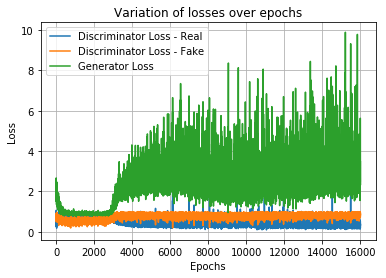

16001 [D loss: 0.426514, acc.: 81.25%] [G loss: 3.085543]
16002 [D loss: 0.680974, acc.: 62.50%] [G loss: 3.293839]
16003 [D loss: 0.450043, acc.: 81.25%] [G loss: 2.523450]
16004 [D loss: 0.570249, acc.: 68.75%] [G loss: 3.783802]
16005 [D loss: 0.355255, acc.: 84.38%] [G loss: 3.503825]
16006 [D loss: 0.514052, acc.: 65.62%] [G loss: 4.712057]
16007 [D loss: 0.272595, acc.: 78.12%] [G loss: 5.308570]
16008 [D loss: 0.251738, acc.: 87.50%] [G loss: 8.700757]
16009 [D loss: 0.240473, acc.: 84.38%] [G loss: 4.321230]
16010 [D loss: 0.209826, acc.: 90.62%] [G loss: 4.442715]
16011 [D loss: 0.274861, acc.: 87.50%] [G loss: 2.734138]
16012 [D loss: 0.208506, acc.: 87.50%] [G loss: 4.282394]
16013 [D loss: 0.169695, acc.: 96.88%] [G loss: 3.555899]
16014 [D loss: 0.298735, acc.: 84.38%] [G loss: 2.813337]
16015 [D loss: 0.269111, acc.: 93.75%] [G loss: 2.734129]
16016 [D loss: 0.439172, acc.: 75.00%] [G loss: 2.895041]
16017 [D loss: 0.252692, acc.: 87.50%] [G loss: 3.301233]
16018 [D loss:

16144 [D loss: 0.387297, acc.: 81.25%] [G loss: 2.644843]
16145 [D loss: 0.311478, acc.: 93.75%] [G loss: 2.724682]
16146 [D loss: 0.379771, acc.: 78.12%] [G loss: 2.246776]
16147 [D loss: 0.405333, acc.: 71.88%] [G loss: 2.480528]
16148 [D loss: 0.435425, acc.: 75.00%] [G loss: 2.139450]
16149 [D loss: 0.342979, acc.: 81.25%] [G loss: 2.718972]
16150 [D loss: 0.343571, acc.: 84.38%] [G loss: 2.493200]
16151 [D loss: 0.314797, acc.: 81.25%] [G loss: 2.602667]
16152 [D loss: 0.400450, acc.: 78.12%] [G loss: 2.129158]
16153 [D loss: 0.294396, acc.: 87.50%] [G loss: 2.699767]
16154 [D loss: 0.236797, acc.: 90.62%] [G loss: 2.770586]
16155 [D loss: 0.244244, acc.: 90.62%] [G loss: 2.990052]
16156 [D loss: 0.268178, acc.: 90.62%] [G loss: 3.172504]
16157 [D loss: 0.254752, acc.: 90.62%] [G loss: 2.866498]
16158 [D loss: 0.482306, acc.: 81.25%] [G loss: 2.822224]
16159 [D loss: 0.334784, acc.: 81.25%] [G loss: 3.123070]
16160 [D loss: 0.351105, acc.: 84.38%] [G loss: 2.358809]
16161 [D loss:

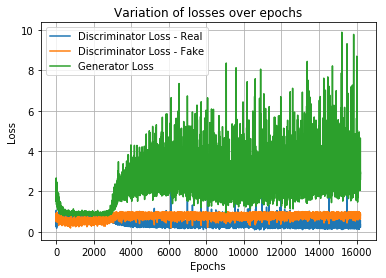

16201 [D loss: 0.399789, acc.: 84.38%] [G loss: 2.590194]
16202 [D loss: 0.350580, acc.: 87.50%] [G loss: 3.267758]
16203 [D loss: 0.417424, acc.: 81.25%] [G loss: 2.565094]
16204 [D loss: 0.221703, acc.: 90.62%] [G loss: 2.065147]
16205 [D loss: 0.194838, acc.: 100.00%] [G loss: 2.717568]
16206 [D loss: 0.171709, acc.: 100.00%] [G loss: 3.703743]
16207 [D loss: 0.389105, acc.: 87.50%] [G loss: 1.745578]
16208 [D loss: 0.429375, acc.: 75.00%] [G loss: 2.494932]
16209 [D loss: 0.594029, acc.: 75.00%] [G loss: 4.573192]
16210 [D loss: 0.365132, acc.: 81.25%] [G loss: 3.217542]
16211 [D loss: 0.306804, acc.: 87.50%] [G loss: 5.205789]
16212 [D loss: 0.466554, acc.: 78.12%] [G loss: 4.808369]
16213 [D loss: 0.145099, acc.: 96.88%] [G loss: 4.177869]
16214 [D loss: 0.259650, acc.: 87.50%] [G loss: 3.301948]
16215 [D loss: 0.194963, acc.: 93.75%] [G loss: 3.314841]
16216 [D loss: 0.253141, acc.: 90.62%] [G loss: 4.637971]
16217 [D loss: 0.538588, acc.: 59.38%] [G loss: 2.869660]
16218 [D los

16344 [D loss: 0.266317, acc.: 93.75%] [G loss: 3.327741]
16345 [D loss: 0.322112, acc.: 87.50%] [G loss: 2.428359]
16346 [D loss: 0.229733, acc.: 93.75%] [G loss: 3.285862]
16347 [D loss: 0.370383, acc.: 81.25%] [G loss: 2.918534]
16348 [D loss: 0.395566, acc.: 75.00%] [G loss: 3.031744]
16349 [D loss: 0.374956, acc.: 84.38%] [G loss: 3.051733]
16350 [D loss: 0.488766, acc.: 71.88%] [G loss: 2.801331]
16351 [D loss: 0.472769, acc.: 78.12%] [G loss: 2.243415]
16352 [D loss: 0.390647, acc.: 84.38%] [G loss: 3.230125]
16353 [D loss: 0.464903, acc.: 87.50%] [G loss: 5.761493]
16354 [D loss: 0.391677, acc.: 84.38%] [G loss: 4.876515]
16355 [D loss: 0.759764, acc.: 68.75%] [G loss: 3.360323]
16356 [D loss: 0.424323, acc.: 71.88%] [G loss: 2.499119]
16357 [D loss: 0.773048, acc.: 68.75%] [G loss: 2.320103]
16358 [D loss: 0.406332, acc.: 71.88%] [G loss: 6.343720]
16359 [D loss: 0.132969, acc.: 100.00%] [G loss: 5.283407]
16360 [D loss: 0.256923, acc.: 87.50%] [G loss: 5.428205]
16361 [D loss

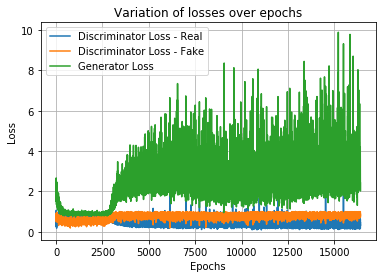

16401 [D loss: 0.372781, acc.: 87.50%] [G loss: 3.067786]
16402 [D loss: 0.583972, acc.: 71.88%] [G loss: 2.628415]
16403 [D loss: 0.254476, acc.: 84.38%] [G loss: 3.689040]
16404 [D loss: 0.521246, acc.: 75.00%] [G loss: 2.650498]
16405 [D loss: 0.506315, acc.: 81.25%] [G loss: 2.367156]
16406 [D loss: 0.461366, acc.: 78.12%] [G loss: 2.226582]
16407 [D loss: 0.283413, acc.: 87.50%] [G loss: 2.864119]
16408 [D loss: 0.399420, acc.: 78.12%] [G loss: 3.566577]
16409 [D loss: 0.298735, acc.: 84.38%] [G loss: 2.827501]
16410 [D loss: 0.251850, acc.: 87.50%] [G loss: 4.279382]
16411 [D loss: 0.254537, acc.: 90.62%] [G loss: 3.011834]
16412 [D loss: 0.270820, acc.: 90.62%] [G loss: 3.124671]
16413 [D loss: 0.326272, acc.: 90.62%] [G loss: 2.311543]
16414 [D loss: 0.313023, acc.: 87.50%] [G loss: 3.556256]
16415 [D loss: 0.333680, acc.: 84.38%] [G loss: 3.783380]
16416 [D loss: 0.189374, acc.: 96.88%] [G loss: 2.527208]
16417 [D loss: 0.250530, acc.: 93.75%] [G loss: 2.536939]
16418 [D loss:

16543 [D loss: 0.352602, acc.: 87.50%] [G loss: 2.477282]
16544 [D loss: 0.268798, acc.: 87.50%] [G loss: 3.051714]
16545 [D loss: 0.244706, acc.: 93.75%] [G loss: 3.801902]
16546 [D loss: 0.235254, acc.: 93.75%] [G loss: 3.437533]
16547 [D loss: 0.300081, acc.: 87.50%] [G loss: 3.690450]
16548 [D loss: 0.303850, acc.: 90.62%] [G loss: 2.792181]
16549 [D loss: 0.334610, acc.: 90.62%] [G loss: 2.344187]
16550 [D loss: 0.390872, acc.: 84.38%] [G loss: 2.054757]
16551 [D loss: 0.559219, acc.: 78.12%] [G loss: 2.521700]
16552 [D loss: 0.361324, acc.: 84.38%] [G loss: 2.495390]
16553 [D loss: 0.248764, acc.: 96.88%] [G loss: 3.506174]
16554 [D loss: 0.248613, acc.: 87.50%] [G loss: 3.159437]
16555 [D loss: 0.542225, acc.: 75.00%] [G loss: 3.191649]
16556 [D loss: 0.245326, acc.: 93.75%] [G loss: 2.711566]
16557 [D loss: 0.258201, acc.: 87.50%] [G loss: 3.024303]
16558 [D loss: 0.583546, acc.: 68.75%] [G loss: 2.636933]
16559 [D loss: 0.373112, acc.: 75.00%] [G loss: 2.645831]
16560 [D loss:

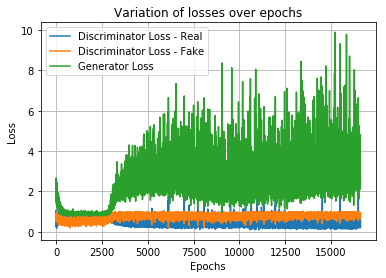

16601 [D loss: 0.296164, acc.: 84.38%] [G loss: 3.095672]
16602 [D loss: 0.375783, acc.: 78.12%] [G loss: 2.613864]
16603 [D loss: 0.399919, acc.: 81.25%] [G loss: 2.907059]
16604 [D loss: 0.286094, acc.: 84.38%] [G loss: 2.052698]
16605 [D loss: 0.341646, acc.: 87.50%] [G loss: 3.614174]
16606 [D loss: 0.152207, acc.: 93.75%] [G loss: 3.044516]
16607 [D loss: 0.792833, acc.: 62.50%] [G loss: 2.458736]
16608 [D loss: 0.282211, acc.: 90.62%] [G loss: 2.915478]
16609 [D loss: 0.813554, acc.: 62.50%] [G loss: 3.113139]
16610 [D loss: 0.480665, acc.: 81.25%] [G loss: 3.027319]
16611 [D loss: 0.248483, acc.: 87.50%] [G loss: 2.912467]
16612 [D loss: 0.272920, acc.: 81.25%] [G loss: 2.442355]
16613 [D loss: 0.280336, acc.: 84.38%] [G loss: 3.235676]
16614 [D loss: 0.285725, acc.: 90.62%] [G loss: 2.704940]
16615 [D loss: 0.467005, acc.: 78.12%] [G loss: 2.748297]
16616 [D loss: 0.336324, acc.: 81.25%] [G loss: 2.971653]
16617 [D loss: 0.809488, acc.: 62.50%] [G loss: 3.532093]
16618 [D loss:

16744 [D loss: 0.323445, acc.: 90.62%] [G loss: 3.227098]
16745 [D loss: 0.537586, acc.: 75.00%] [G loss: 3.445347]
16746 [D loss: 0.424389, acc.: 78.12%] [G loss: 2.360363]
16747 [D loss: 0.279391, acc.: 84.38%] [G loss: 3.299075]
16748 [D loss: 0.322583, acc.: 81.25%] [G loss: 3.017596]
16749 [D loss: 0.433930, acc.: 78.12%] [G loss: 2.326510]
16750 [D loss: 0.461802, acc.: 71.88%] [G loss: 3.214517]
16751 [D loss: 0.608702, acc.: 62.50%] [G loss: 3.186145]
16752 [D loss: 0.428857, acc.: 87.50%] [G loss: 2.722878]
16753 [D loss: 0.328053, acc.: 87.50%] [G loss: 3.090961]
16754 [D loss: 0.362904, acc.: 84.38%] [G loss: 2.519274]
16755 [D loss: 0.373620, acc.: 84.38%] [G loss: 4.739051]
16756 [D loss: 0.455067, acc.: 87.50%] [G loss: 3.011347]
16757 [D loss: 0.278022, acc.: 84.38%] [G loss: 4.423220]
16758 [D loss: 0.336892, acc.: 84.38%] [G loss: 3.311567]
16759 [D loss: 0.182145, acc.: 93.75%] [G loss: 3.298464]
16760 [D loss: 0.330921, acc.: 87.50%] [G loss: 4.092830]
16761 [D loss:

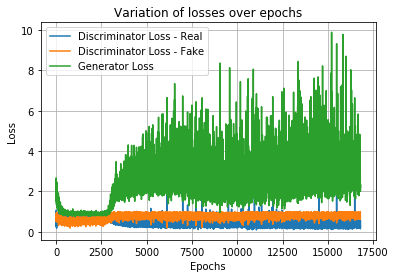

16801 [D loss: 0.227817, acc.: 93.75%] [G loss: 2.781208]
16802 [D loss: 0.533671, acc.: 75.00%] [G loss: 2.736994]
16803 [D loss: 0.302183, acc.: 90.62%] [G loss: 3.605779]
16804 [D loss: 0.314819, acc.: 96.88%] [G loss: 2.647829]
16805 [D loss: 0.347328, acc.: 78.12%] [G loss: 3.114681]
16806 [D loss: 0.238442, acc.: 90.62%] [G loss: 3.101660]
16807 [D loss: 0.269397, acc.: 96.88%] [G loss: 2.526577]
16808 [D loss: 0.436250, acc.: 87.50%] [G loss: 2.498394]
16809 [D loss: 0.335230, acc.: 81.25%] [G loss: 2.740586]
16810 [D loss: 0.205751, acc.: 93.75%] [G loss: 3.655622]
16811 [D loss: 0.297733, acc.: 90.62%] [G loss: 2.744418]
16812 [D loss: 0.403132, acc.: 87.50%] [G loss: 3.205812]
16813 [D loss: 0.353782, acc.: 81.25%] [G loss: 3.505449]
16814 [D loss: 0.301307, acc.: 90.62%] [G loss: 2.719821]
16815 [D loss: 0.349551, acc.: 81.25%] [G loss: 3.571522]
16816 [D loss: 0.190707, acc.: 93.75%] [G loss: 3.033423]
16817 [D loss: 0.365613, acc.: 90.62%] [G loss: 1.549030]
16818 [D loss:

16943 [D loss: 0.371118, acc.: 87.50%] [G loss: 4.340306]
16944 [D loss: 0.398003, acc.: 81.25%] [G loss: 3.260956]
16945 [D loss: 0.341830, acc.: 90.62%] [G loss: 2.666223]
16946 [D loss: 0.283112, acc.: 84.38%] [G loss: 3.332346]
16947 [D loss: 0.230615, acc.: 96.88%] [G loss: 3.204497]
16948 [D loss: 0.380516, acc.: 87.50%] [G loss: 3.872318]
16949 [D loss: 0.471095, acc.: 81.25%] [G loss: 2.430966]
16950 [D loss: 0.262641, acc.: 90.62%] [G loss: 4.387767]
16951 [D loss: 0.529031, acc.: 65.62%] [G loss: 4.012196]
16952 [D loss: 0.430984, acc.: 78.12%] [G loss: 4.923216]
16953 [D loss: 0.223250, acc.: 87.50%] [G loss: 3.038448]
16954 [D loss: 0.392058, acc.: 78.12%] [G loss: 2.419821]
16955 [D loss: 0.425178, acc.: 75.00%] [G loss: 3.327065]
16956 [D loss: 0.275262, acc.: 90.62%] [G loss: 3.267294]
16957 [D loss: 0.559298, acc.: 71.88%] [G loss: 2.422497]
16958 [D loss: 0.411226, acc.: 78.12%] [G loss: 3.147433]
16959 [D loss: 0.381391, acc.: 78.12%] [G loss: 3.561896]
16960 [D loss:

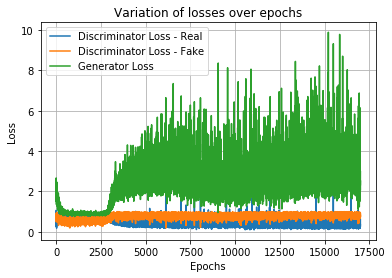

17001 [D loss: 0.162274, acc.: 93.75%] [G loss: 3.624712]
17002 [D loss: 0.338396, acc.: 78.12%] [G loss: 2.335277]
17003 [D loss: 0.434640, acc.: 81.25%] [G loss: 2.331995]
17004 [D loss: 0.477553, acc.: 65.62%] [G loss: 2.550294]
17005 [D loss: 0.514505, acc.: 68.75%] [G loss: 2.462791]
17006 [D loss: 0.374247, acc.: 78.12%] [G loss: 3.542778]
17007 [D loss: 0.612460, acc.: 71.88%] [G loss: 3.282023]
17008 [D loss: 0.286549, acc.: 90.62%] [G loss: 3.923175]
17009 [D loss: 0.492075, acc.: 75.00%] [G loss: 3.212860]
17010 [D loss: 0.304517, acc.: 87.50%] [G loss: 3.430449]
17011 [D loss: 0.274714, acc.: 87.50%] [G loss: 2.972557]
17012 [D loss: 0.228913, acc.: 90.62%] [G loss: 3.281033]
17013 [D loss: 0.406695, acc.: 75.00%] [G loss: 3.317482]
17014 [D loss: 0.242724, acc.: 90.62%] [G loss: 2.603621]
17015 [D loss: 0.392237, acc.: 81.25%] [G loss: 2.423389]
17016 [D loss: 0.481535, acc.: 78.12%] [G loss: 2.192416]
17017 [D loss: 0.276095, acc.: 87.50%] [G loss: 2.760777]
17018 [D loss:

17143 [D loss: 0.310122, acc.: 87.50%] [G loss: 2.506820]
17144 [D loss: 0.281057, acc.: 90.62%] [G loss: 2.944134]
17145 [D loss: 0.280003, acc.: 87.50%] [G loss: 2.206459]
17146 [D loss: 0.199594, acc.: 90.62%] [G loss: 2.685608]
17147 [D loss: 0.336809, acc.: 90.62%] [G loss: 3.601276]
17148 [D loss: 0.216246, acc.: 90.62%] [G loss: 3.075482]
17149 [D loss: 0.375237, acc.: 84.38%] [G loss: 3.195193]
17150 [D loss: 0.494986, acc.: 78.12%] [G loss: 2.750628]
17151 [D loss: 0.226557, acc.: 90.62%] [G loss: 2.619711]
17152 [D loss: 0.436222, acc.: 81.25%] [G loss: 2.458498]
17153 [D loss: 0.380303, acc.: 81.25%] [G loss: 2.723186]
17154 [D loss: 0.419678, acc.: 78.12%] [G loss: 2.367284]
17155 [D loss: 0.261760, acc.: 93.75%] [G loss: 2.365230]
17156 [D loss: 0.415648, acc.: 87.50%] [G loss: 2.238270]
17157 [D loss: 0.495003, acc.: 81.25%] [G loss: 1.951712]
17158 [D loss: 0.313275, acc.: 90.62%] [G loss: 2.115545]
17159 [D loss: 0.296694, acc.: 90.62%] [G loss: 4.266409]
17160 [D loss:

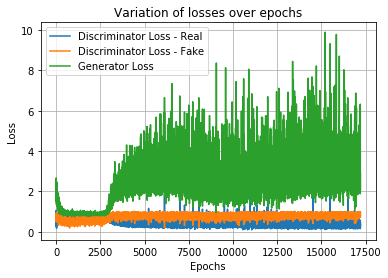

17201 [D loss: 0.330943, acc.: 87.50%] [G loss: 2.176261]
17202 [D loss: 0.370054, acc.: 78.12%] [G loss: 2.023837]
17203 [D loss: 0.404024, acc.: 78.12%] [G loss: 2.382756]
17204 [D loss: 0.564113, acc.: 71.88%] [G loss: 3.541170]
17205 [D loss: 0.320171, acc.: 87.50%] [G loss: 2.339695]
17206 [D loss: 0.414809, acc.: 75.00%] [G loss: 1.615834]
17207 [D loss: 0.188733, acc.: 93.75%] [G loss: 3.278574]
17208 [D loss: 0.654716, acc.: 62.50%] [G loss: 1.985904]
17209 [D loss: 0.270711, acc.: 87.50%] [G loss: 2.097877]
17210 [D loss: 0.297258, acc.: 84.38%] [G loss: 2.678016]
17211 [D loss: 0.371960, acc.: 87.50%] [G loss: 2.490384]
17212 [D loss: 0.200259, acc.: 90.62%] [G loss: 2.487295]
17213 [D loss: 0.546877, acc.: 75.00%] [G loss: 3.055472]
17214 [D loss: 0.394667, acc.: 84.38%] [G loss: 2.435532]
17215 [D loss: 0.321648, acc.: 87.50%] [G loss: 3.578322]
17216 [D loss: 0.501057, acc.: 71.88%] [G loss: 2.428781]
17217 [D loss: 0.486425, acc.: 87.50%] [G loss: 3.468417]
17218 [D loss:

17344 [D loss: 0.625861, acc.: 68.75%] [G loss: 3.516186]
17345 [D loss: 0.482407, acc.: 75.00%] [G loss: 2.858413]
17346 [D loss: 0.296959, acc.: 84.38%] [G loss: 3.532983]
17347 [D loss: 0.449237, acc.: 78.12%] [G loss: 2.877879]
17348 [D loss: 0.345189, acc.: 87.50%] [G loss: 3.333459]
17349 [D loss: 0.367555, acc.: 84.38%] [G loss: 2.061133]
17350 [D loss: 0.332306, acc.: 87.50%] [G loss: 2.539856]
17351 [D loss: 0.439083, acc.: 68.75%] [G loss: 2.403255]
17352 [D loss: 0.408603, acc.: 78.12%] [G loss: 2.130853]
17353 [D loss: 0.286415, acc.: 90.62%] [G loss: 3.316997]
17354 [D loss: 0.541009, acc.: 68.75%] [G loss: 3.056444]
17355 [D loss: 0.389230, acc.: 78.12%] [G loss: 3.304172]
17356 [D loss: 0.373635, acc.: 84.38%] [G loss: 1.926996]
17357 [D loss: 0.307333, acc.: 90.62%] [G loss: 3.967420]
17358 [D loss: 0.300977, acc.: 90.62%] [G loss: 3.254566]
17359 [D loss: 0.495421, acc.: 71.88%] [G loss: 4.676676]
17360 [D loss: 0.338047, acc.: 87.50%] [G loss: 3.113655]
17361 [D loss:

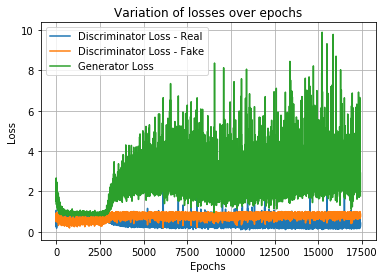

17401 [D loss: 0.454417, acc.: 75.00%] [G loss: 2.122129]
17402 [D loss: 0.408930, acc.: 84.38%] [G loss: 2.167436]
17403 [D loss: 0.309226, acc.: 84.38%] [G loss: 2.473624]
17404 [D loss: 0.214361, acc.: 96.88%] [G loss: 2.421867]
17405 [D loss: 0.375691, acc.: 87.50%] [G loss: 2.603091]
17406 [D loss: 0.224207, acc.: 90.62%] [G loss: 2.289228]
17407 [D loss: 0.434689, acc.: 84.38%] [G loss: 2.924729]
17408 [D loss: 0.229119, acc.: 96.88%] [G loss: 2.514338]
17409 [D loss: 0.261247, acc.: 93.75%] [G loss: 2.576864]
17410 [D loss: 0.227312, acc.: 90.62%] [G loss: 2.784864]
17411 [D loss: 0.314382, acc.: 87.50%] [G loss: 2.755934]
17412 [D loss: 0.438767, acc.: 81.25%] [G loss: 2.440099]
17413 [D loss: 0.363050, acc.: 81.25%] [G loss: 1.745909]
17414 [D loss: 0.238238, acc.: 87.50%] [G loss: 2.929364]
17415 [D loss: 0.407163, acc.: 84.38%] [G loss: 2.922157]
17416 [D loss: 0.251913, acc.: 90.62%] [G loss: 2.513201]
17417 [D loss: 0.443654, acc.: 75.00%] [G loss: 3.795298]
17418 [D loss:

17544 [D loss: 0.345623, acc.: 84.38%] [G loss: 2.542675]
17545 [D loss: 0.293258, acc.: 87.50%] [G loss: 2.934699]
17546 [D loss: 0.443558, acc.: 78.12%] [G loss: 2.702630]
17547 [D loss: 0.406998, acc.: 75.00%] [G loss: 2.317251]
17548 [D loss: 0.427241, acc.: 75.00%] [G loss: 2.283036]
17549 [D loss: 0.397573, acc.: 78.12%] [G loss: 3.069457]
17550 [D loss: 0.280327, acc.: 84.38%] [G loss: 3.353025]
17551 [D loss: 0.301018, acc.: 87.50%] [G loss: 3.107848]
17552 [D loss: 0.329951, acc.: 87.50%] [G loss: 2.835370]
17553 [D loss: 0.451613, acc.: 75.00%] [G loss: 2.878299]
17554 [D loss: 0.406503, acc.: 84.38%] [G loss: 2.460379]
17555 [D loss: 0.362108, acc.: 84.38%] [G loss: 2.484952]
17556 [D loss: 0.253547, acc.: 93.75%] [G loss: 2.471148]
17557 [D loss: 0.398817, acc.: 84.38%] [G loss: 3.457985]
17558 [D loss: 0.538438, acc.: 62.50%] [G loss: 3.156120]
17559 [D loss: 0.334560, acc.: 81.25%] [G loss: 3.152473]
17560 [D loss: 0.393400, acc.: 81.25%] [G loss: 6.304638]
17561 [D loss:

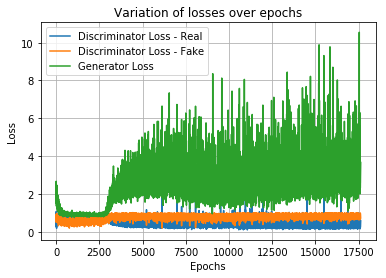

17601 [D loss: 0.261500, acc.: 84.38%] [G loss: 3.073114]
17602 [D loss: 0.325738, acc.: 87.50%] [G loss: 2.695046]
17603 [D loss: 0.455294, acc.: 81.25%] [G loss: 2.299430]
17604 [D loss: 0.364124, acc.: 84.38%] [G loss: 4.984976]
17605 [D loss: 0.463985, acc.: 84.38%] [G loss: 2.773849]
17606 [D loss: 0.480272, acc.: 71.88%] [G loss: 3.968429]
17607 [D loss: 0.335636, acc.: 84.38%] [G loss: 5.338455]
17608 [D loss: 0.365828, acc.: 84.38%] [G loss: 2.452106]
17609 [D loss: 0.272700, acc.: 84.38%] [G loss: 2.122064]
17610 [D loss: 0.207031, acc.: 93.75%] [G loss: 2.859386]
17611 [D loss: 0.289222, acc.: 84.38%] [G loss: 2.764207]
17612 [D loss: 0.308336, acc.: 84.38%] [G loss: 2.150071]
17613 [D loss: 0.425537, acc.: 78.12%] [G loss: 4.167802]
17614 [D loss: 0.247286, acc.: 87.50%] [G loss: 2.862950]
17615 [D loss: 0.546173, acc.: 71.88%] [G loss: 4.175630]
17616 [D loss: 0.248345, acc.: 87.50%] [G loss: 3.403796]
17617 [D loss: 0.344046, acc.: 87.50%] [G loss: 2.622610]
17618 [D loss:

17744 [D loss: 0.667227, acc.: 81.25%] [G loss: 1.988026]
17745 [D loss: 0.347388, acc.: 84.38%] [G loss: 3.269278]
17746 [D loss: 0.271288, acc.: 84.38%] [G loss: 3.235018]
17747 [D loss: 0.284680, acc.: 90.62%] [G loss: 3.554048]
17748 [D loss: 0.490922, acc.: 81.25%] [G loss: 3.209023]
17749 [D loss: 0.470344, acc.: 75.00%] [G loss: 3.445335]
17750 [D loss: 0.252432, acc.: 93.75%] [G loss: 2.291485]
17751 [D loss: 0.391841, acc.: 84.38%] [G loss: 2.167972]
17752 [D loss: 0.262292, acc.: 93.75%] [G loss: 2.624365]
17753 [D loss: 0.292501, acc.: 84.38%] [G loss: 2.790079]
17754 [D loss: 0.306339, acc.: 90.62%] [G loss: 3.479484]
17755 [D loss: 0.297305, acc.: 87.50%] [G loss: 2.541218]
17756 [D loss: 0.345975, acc.: 90.62%] [G loss: 2.838560]
17757 [D loss: 0.518246, acc.: 71.88%] [G loss: 2.951391]
17758 [D loss: 0.463103, acc.: 75.00%] [G loss: 3.259738]
17759 [D loss: 0.649259, acc.: 65.62%] [G loss: 2.825691]
17760 [D loss: 0.787937, acc.: 59.38%] [G loss: 2.840058]
17761 [D loss:

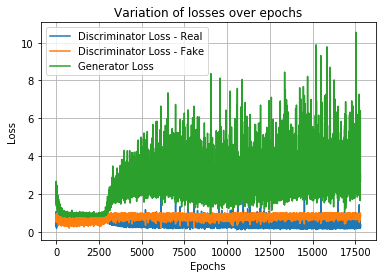

17801 [D loss: 0.431447, acc.: 81.25%] [G loss: 3.130653]
17802 [D loss: 0.279496, acc.: 90.62%] [G loss: 2.785620]
17803 [D loss: 0.410327, acc.: 78.12%] [G loss: 2.524193]
17804 [D loss: 0.374383, acc.: 87.50%] [G loss: 2.355239]
17805 [D loss: 0.196740, acc.: 93.75%] [G loss: 2.413207]
17806 [D loss: 0.525052, acc.: 75.00%] [G loss: 2.847143]
17807 [D loss: 0.295444, acc.: 90.62%] [G loss: 2.977760]
17808 [D loss: 0.346239, acc.: 84.38%] [G loss: 2.310627]
17809 [D loss: 0.425319, acc.: 75.00%] [G loss: 3.350676]
17810 [D loss: 0.607984, acc.: 78.12%] [G loss: 2.502081]
17811 [D loss: 0.280221, acc.: 90.62%] [G loss: 3.384302]
17812 [D loss: 0.425729, acc.: 78.12%] [G loss: 2.546738]
17813 [D loss: 0.407626, acc.: 78.12%] [G loss: 2.549429]
17814 [D loss: 0.194246, acc.: 100.00%] [G loss: 3.068282]
17815 [D loss: 0.315861, acc.: 90.62%] [G loss: 2.528957]
17816 [D loss: 0.550456, acc.: 75.00%] [G loss: 2.666525]
17817 [D loss: 0.390648, acc.: 90.62%] [G loss: 3.197144]
17818 [D loss

17944 [D loss: 0.362462, acc.: 84.38%] [G loss: 2.127004]
17945 [D loss: 0.241437, acc.: 93.75%] [G loss: 3.199907]
17946 [D loss: 0.390655, acc.: 78.12%] [G loss: 2.612911]
17947 [D loss: 0.326526, acc.: 84.38%] [G loss: 2.143332]
17948 [D loss: 0.293671, acc.: 87.50%] [G loss: 3.048044]
17949 [D loss: 0.489926, acc.: 81.25%] [G loss: 2.021159]
17950 [D loss: 0.197682, acc.: 93.75%] [G loss: 2.659635]
17951 [D loss: 0.200744, acc.: 90.62%] [G loss: 2.544658]
17952 [D loss: 0.357628, acc.: 84.38%] [G loss: 3.292192]
17953 [D loss: 0.266876, acc.: 90.62%] [G loss: 4.018368]
17954 [D loss: 0.328571, acc.: 81.25%] [G loss: 4.466243]
17955 [D loss: 0.225153, acc.: 96.88%] [G loss: 3.186552]
17956 [D loss: 0.373209, acc.: 84.38%] [G loss: 2.677290]
17957 [D loss: 0.183642, acc.: 96.88%] [G loss: 3.883732]
17958 [D loss: 0.483622, acc.: 81.25%] [G loss: 3.830142]
17959 [D loss: 0.504711, acc.: 75.00%] [G loss: 2.062237]
17960 [D loss: 0.155461, acc.: 93.75%] [G loss: 3.328158]
17961 [D loss:

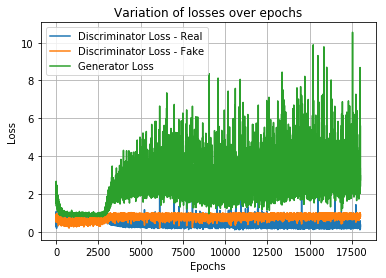

18001 [D loss: 0.283491, acc.: 84.38%] [G loss: 3.225128]
18002 [D loss: 0.225727, acc.: 90.62%] [G loss: 2.918236]
18003 [D loss: 0.489237, acc.: 81.25%] [G loss: 3.618450]
18004 [D loss: 0.470389, acc.: 81.25%] [G loss: 3.395002]
18005 [D loss: 0.310370, acc.: 84.38%] [G loss: 2.881335]
18006 [D loss: 0.492344, acc.: 71.88%] [G loss: 2.950833]
18007 [D loss: 0.282731, acc.: 90.62%] [G loss: 2.729697]
18008 [D loss: 0.460045, acc.: 84.38%] [G loss: 3.254896]
18009 [D loss: 0.455430, acc.: 84.38%] [G loss: 3.443731]
18010 [D loss: 0.330485, acc.: 87.50%] [G loss: 3.402253]
18011 [D loss: 0.441901, acc.: 87.50%] [G loss: 3.242225]
18012 [D loss: 0.293312, acc.: 90.62%] [G loss: 3.622338]
18013 [D loss: 0.537766, acc.: 81.25%] [G loss: 3.072847]
18014 [D loss: 0.339806, acc.: 84.38%] [G loss: 3.228021]
18015 [D loss: 0.407879, acc.: 75.00%] [G loss: 2.830319]
18016 [D loss: 0.390689, acc.: 81.25%] [G loss: 2.650962]
18017 [D loss: 0.517043, acc.: 71.88%] [G loss: 3.384388]
18018 [D loss:

18143 [D loss: 0.333547, acc.: 84.38%] [G loss: 2.718868]
18144 [D loss: 0.401611, acc.: 81.25%] [G loss: 2.719226]
18145 [D loss: 0.409344, acc.: 84.38%] [G loss: 2.629987]
18146 [D loss: 0.357743, acc.: 84.38%] [G loss: 2.846865]
18147 [D loss: 0.402391, acc.: 78.12%] [G loss: 2.520488]
18148 [D loss: 0.382317, acc.: 81.25%] [G loss: 2.731504]
18149 [D loss: 0.398296, acc.: 81.25%] [G loss: 2.618721]
18150 [D loss: 0.410426, acc.: 81.25%] [G loss: 2.851898]
18151 [D loss: 0.483479, acc.: 84.38%] [G loss: 2.547328]
18152 [D loss: 0.227794, acc.: 90.62%] [G loss: 2.586231]
18153 [D loss: 0.341981, acc.: 90.62%] [G loss: 2.734923]
18154 [D loss: 0.403904, acc.: 84.38%] [G loss: 3.050814]
18155 [D loss: 0.436593, acc.: 68.75%] [G loss: 2.798593]
18156 [D loss: 0.538326, acc.: 65.62%] [G loss: 3.411240]
18157 [D loss: 0.559591, acc.: 78.12%] [G loss: 4.903999]
18158 [D loss: 0.831762, acc.: 68.75%] [G loss: 3.635837]
18159 [D loss: 0.755457, acc.: 75.00%] [G loss: 2.340845]
18160 [D loss:

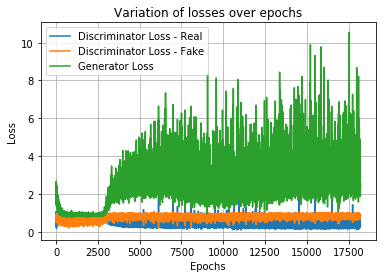

18201 [D loss: 0.248506, acc.: 90.62%] [G loss: 3.068048]
18202 [D loss: 0.181043, acc.: 96.88%] [G loss: 2.933631]
18203 [D loss: 0.504760, acc.: 78.12%] [G loss: 2.550821]
18204 [D loss: 0.300715, acc.: 90.62%] [G loss: 2.856422]
18205 [D loss: 0.406491, acc.: 81.25%] [G loss: 2.920222]
18206 [D loss: 0.388799, acc.: 78.12%] [G loss: 2.810407]
18207 [D loss: 0.242212, acc.: 90.62%] [G loss: 3.506702]
18208 [D loss: 0.264411, acc.: 87.50%] [G loss: 3.503042]
18209 [D loss: 0.246210, acc.: 87.50%] [G loss: 3.570544]
18210 [D loss: 0.319738, acc.: 90.62%] [G loss: 3.743637]
18211 [D loss: 0.354701, acc.: 81.25%] [G loss: 2.650675]
18212 [D loss: 0.411942, acc.: 71.88%] [G loss: 3.383078]
18213 [D loss: 0.363274, acc.: 78.12%] [G loss: 2.176545]
18214 [D loss: 0.294965, acc.: 90.62%] [G loss: 3.156452]
18215 [D loss: 0.395924, acc.: 81.25%] [G loss: 2.077049]
18216 [D loss: 0.230656, acc.: 93.75%] [G loss: 1.798753]
18217 [D loss: 0.149952, acc.: 93.75%] [G loss: 2.474751]
18218 [D loss:

18343 [D loss: 0.235555, acc.: 84.38%] [G loss: 3.687362]
18344 [D loss: 0.104443, acc.: 96.88%] [G loss: 4.993266]
18345 [D loss: 0.196604, acc.: 90.62%] [G loss: 4.415124]
18346 [D loss: 0.258182, acc.: 87.50%] [G loss: 5.815492]
18347 [D loss: 0.103885, acc.: 96.88%] [G loss: 5.449668]
18348 [D loss: 0.188307, acc.: 93.75%] [G loss: 3.453137]
18349 [D loss: 0.238365, acc.: 90.62%] [G loss: 3.544964]
18350 [D loss: 0.180319, acc.: 93.75%] [G loss: 2.218898]
18351 [D loss: 0.236046, acc.: 87.50%] [G loss: 2.851672]
18352 [D loss: 0.234968, acc.: 90.62%] [G loss: 3.172650]
18353 [D loss: 0.542759, acc.: 81.25%] [G loss: 3.096192]
18354 [D loss: 0.515272, acc.: 71.88%] [G loss: 3.837105]
18355 [D loss: 0.311631, acc.: 84.38%] [G loss: 2.910136]
18356 [D loss: 0.310916, acc.: 84.38%] [G loss: 5.071868]
18357 [D loss: 0.373804, acc.: 87.50%] [G loss: 3.077600]
18358 [D loss: 0.291583, acc.: 84.38%] [G loss: 2.830865]
18359 [D loss: 0.187288, acc.: 93.75%] [G loss: 3.033263]
18360 [D loss:

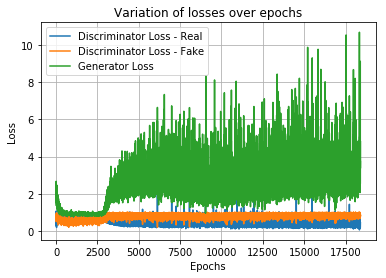

18401 [D loss: 0.384000, acc.: 81.25%] [G loss: 2.849238]
18402 [D loss: 0.402958, acc.: 87.50%] [G loss: 3.099705]
18403 [D loss: 0.444597, acc.: 87.50%] [G loss: 2.257319]
18404 [D loss: 0.371852, acc.: 78.12%] [G loss: 3.586194]
18405 [D loss: 0.455442, acc.: 78.12%] [G loss: 4.604239]
18406 [D loss: 0.224595, acc.: 87.50%] [G loss: 3.159695]
18407 [D loss: 0.384986, acc.: 78.12%] [G loss: 5.276535]
18408 [D loss: 0.329185, acc.: 87.50%] [G loss: 2.346115]
18409 [D loss: 0.198345, acc.: 96.88%] [G loss: 2.544587]
18410 [D loss: 0.364466, acc.: 84.38%] [G loss: 3.025145]
18411 [D loss: 0.246843, acc.: 87.50%] [G loss: 3.966204]
18412 [D loss: 0.326775, acc.: 93.75%] [G loss: 2.625551]
18413 [D loss: 0.252323, acc.: 87.50%] [G loss: 2.942794]
18414 [D loss: 0.532894, acc.: 68.75%] [G loss: 2.312132]
18415 [D loss: 0.347927, acc.: 81.25%] [G loss: 2.108564]
18416 [D loss: 0.311467, acc.: 87.50%] [G loss: 3.080421]
18417 [D loss: 0.195201, acc.: 93.75%] [G loss: 3.133522]
18418 [D loss:

18544 [D loss: 0.387916, acc.: 84.38%] [G loss: 2.997383]
18545 [D loss: 0.366081, acc.: 87.50%] [G loss: 3.285009]
18546 [D loss: 0.501492, acc.: 81.25%] [G loss: 3.485019]
18547 [D loss: 0.367639, acc.: 84.38%] [G loss: 3.944548]
18548 [D loss: 0.434270, acc.: 78.12%] [G loss: 4.131511]
18549 [D loss: 0.557738, acc.: 71.88%] [G loss: 3.074883]
18550 [D loss: 0.441555, acc.: 81.25%] [G loss: 3.159375]
18551 [D loss: 0.445566, acc.: 78.12%] [G loss: 2.939252]
18552 [D loss: 0.339028, acc.: 87.50%] [G loss: 3.896011]
18553 [D loss: 0.256048, acc.: 93.75%] [G loss: 3.164011]
18554 [D loss: 0.483444, acc.: 71.88%] [G loss: 2.053969]
18555 [D loss: 0.532299, acc.: 78.12%] [G loss: 2.579561]
18556 [D loss: 0.331433, acc.: 90.62%] [G loss: 2.838378]
18557 [D loss: 0.166327, acc.: 96.88%] [G loss: 2.366000]
18558 [D loss: 0.429507, acc.: 84.38%] [G loss: 2.320730]
18559 [D loss: 0.272469, acc.: 90.62%] [G loss: 1.742090]
18560 [D loss: 0.411003, acc.: 78.12%] [G loss: 2.285996]
18561 [D loss:

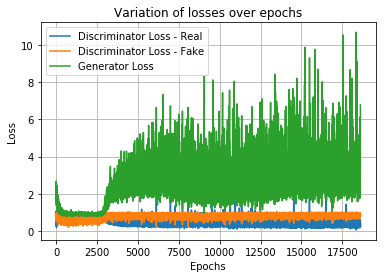

18601 [D loss: 0.383884, acc.: 78.12%] [G loss: 3.258129]
18602 [D loss: 0.376937, acc.: 84.38%] [G loss: 3.048746]
18603 [D loss: 0.448391, acc.: 71.88%] [G loss: 4.464191]
18604 [D loss: 0.213760, acc.: 96.88%] [G loss: 3.454968]
18605 [D loss: 0.258512, acc.: 93.75%] [G loss: 5.479142]
18606 [D loss: 0.542872, acc.: 78.12%] [G loss: 2.051921]
18607 [D loss: 0.320895, acc.: 87.50%] [G loss: 5.019050]
18608 [D loss: 0.303374, acc.: 90.62%] [G loss: 4.576051]
18609 [D loss: 0.175771, acc.: 93.75%] [G loss: 5.162611]
18610 [D loss: 0.505359, acc.: 81.25%] [G loss: 3.228937]
18611 [D loss: 0.318527, acc.: 90.62%] [G loss: 2.702779]
18612 [D loss: 0.607205, acc.: 71.88%] [G loss: 2.826550]
18613 [D loss: 0.347679, acc.: 84.38%] [G loss: 3.130674]
18614 [D loss: 0.353881, acc.: 87.50%] [G loss: 2.092443]
18615 [D loss: 0.336553, acc.: 81.25%] [G loss: 2.365404]
18616 [D loss: 0.310099, acc.: 93.75%] [G loss: 2.467124]
18617 [D loss: 0.219872, acc.: 93.75%] [G loss: 2.302159]
18618 [D loss:

18743 [D loss: 0.508295, acc.: 81.25%] [G loss: 3.664137]
18744 [D loss: 0.349964, acc.: 81.25%] [G loss: 3.104111]
18745 [D loss: 0.334850, acc.: 84.38%] [G loss: 2.681860]
18746 [D loss: 0.419128, acc.: 78.12%] [G loss: 2.908217]
18747 [D loss: 0.353089, acc.: 87.50%] [G loss: 3.190764]
18748 [D loss: 0.380974, acc.: 84.38%] [G loss: 1.855116]
18749 [D loss: 0.342239, acc.: 81.25%] [G loss: 2.096228]
18750 [D loss: 0.260990, acc.: 93.75%] [G loss: 2.356734]
18751 [D loss: 0.638309, acc.: 75.00%] [G loss: 3.204313]
18752 [D loss: 0.404351, acc.: 78.12%] [G loss: 3.173447]
18753 [D loss: 0.639904, acc.: 68.75%] [G loss: 2.791557]
18754 [D loss: 0.448360, acc.: 78.12%] [G loss: 3.919332]
18755 [D loss: 0.417390, acc.: 84.38%] [G loss: 3.051676]
18756 [D loss: 0.425750, acc.: 84.38%] [G loss: 3.130123]
18757 [D loss: 0.240580, acc.: 93.75%] [G loss: 2.779991]
18758 [D loss: 0.332076, acc.: 87.50%] [G loss: 2.720451]
18759 [D loss: 0.361821, acc.: 78.12%] [G loss: 2.685210]
18760 [D loss:

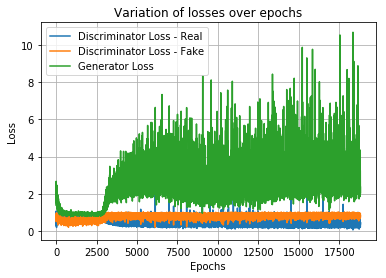

18801 [D loss: 0.335075, acc.: 84.38%] [G loss: 2.813932]
18802 [D loss: 0.408801, acc.: 78.12%] [G loss: 5.150765]
18803 [D loss: 0.326520, acc.: 90.62%] [G loss: 2.438513]
18804 [D loss: 0.358722, acc.: 84.38%] [G loss: 3.776583]
18805 [D loss: 0.549306, acc.: 78.12%] [G loss: 2.879558]
18806 [D loss: 0.316138, acc.: 93.75%] [G loss: 3.602749]
18807 [D loss: 0.356350, acc.: 75.00%] [G loss: 2.581229]
18808 [D loss: 0.284257, acc.: 93.75%] [G loss: 3.559299]
18809 [D loss: 0.425222, acc.: 75.00%] [G loss: 3.273219]
18810 [D loss: 0.384522, acc.: 81.25%] [G loss: 2.445046]
18811 [D loss: 0.460618, acc.: 78.12%] [G loss: 2.245789]
18812 [D loss: 0.375340, acc.: 87.50%] [G loss: 2.435660]
18813 [D loss: 0.458678, acc.: 71.88%] [G loss: 2.526818]
18814 [D loss: 0.280238, acc.: 87.50%] [G loss: 3.191819]
18815 [D loss: 0.412164, acc.: 75.00%] [G loss: 2.593609]
18816 [D loss: 0.214450, acc.: 93.75%] [G loss: 3.603037]
18817 [D loss: 0.419837, acc.: 81.25%] [G loss: 2.526239]
18818 [D loss:

18943 [D loss: 0.437694, acc.: 81.25%] [G loss: 2.507446]
18944 [D loss: 0.410598, acc.: 84.38%] [G loss: 4.225087]
18945 [D loss: 0.340112, acc.: 84.38%] [G loss: 4.945896]
18946 [D loss: 0.231013, acc.: 93.75%] [G loss: 3.547841]
18947 [D loss: 0.214012, acc.: 90.62%] [G loss: 6.622158]
18948 [D loss: 0.277892, acc.: 84.38%] [G loss: 4.469043]
18949 [D loss: 0.230012, acc.: 93.75%] [G loss: 3.478517]
18950 [D loss: 0.321042, acc.: 87.50%] [G loss: 4.402907]
18951 [D loss: 0.377975, acc.: 87.50%] [G loss: 2.839351]
18952 [D loss: 0.439025, acc.: 81.25%] [G loss: 3.399228]
18953 [D loss: 0.373578, acc.: 84.38%] [G loss: 2.743663]
18954 [D loss: 0.548722, acc.: 71.88%] [G loss: 3.391026]
18955 [D loss: 0.311414, acc.: 81.25%] [G loss: 3.296253]
18956 [D loss: 0.425143, acc.: 75.00%] [G loss: 6.664350]
18957 [D loss: 0.645879, acc.: 65.62%] [G loss: 2.633047]
18958 [D loss: 0.350379, acc.: 84.38%] [G loss: 3.352841]
18959 [D loss: 0.531115, acc.: 71.88%] [G loss: 2.320714]
18960 [D loss:

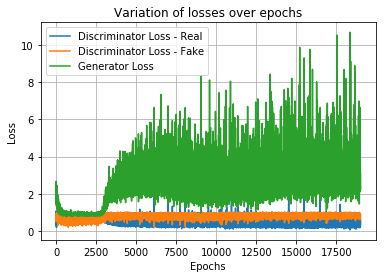

19001 [D loss: 0.529970, acc.: 75.00%] [G loss: 2.720866]
19002 [D loss: 0.313639, acc.: 81.25%] [G loss: 4.945497]
19003 [D loss: 0.310500, acc.: 81.25%] [G loss: 2.753003]
19004 [D loss: 0.240987, acc.: 93.75%] [G loss: 6.586699]
19005 [D loss: 0.123210, acc.: 96.88%] [G loss: 8.811595]
19006 [D loss: 0.418254, acc.: 84.38%] [G loss: 7.961516]
19007 [D loss: 0.444770, acc.: 81.25%] [G loss: 4.670136]
19008 [D loss: 0.262499, acc.: 87.50%] [G loss: 4.682367]
19009 [D loss: 0.241462, acc.: 90.62%] [G loss: 4.464574]
19010 [D loss: 0.203774, acc.: 93.75%] [G loss: 3.623615]
19011 [D loss: 0.318701, acc.: 93.75%] [G loss: 3.291267]
19012 [D loss: 0.332538, acc.: 84.38%] [G loss: 3.259002]
19013 [D loss: 0.216242, acc.: 90.62%] [G loss: 3.474747]
19014 [D loss: 0.352241, acc.: 87.50%] [G loss: 3.486788]
19015 [D loss: 0.401318, acc.: 75.00%] [G loss: 3.490555]
19016 [D loss: 0.209747, acc.: 93.75%] [G loss: 3.256199]
19017 [D loss: 0.216523, acc.: 90.62%] [G loss: 2.830702]
19018 [D loss:

19143 [D loss: 0.447469, acc.: 71.88%] [G loss: 1.772383]
19144 [D loss: 0.274768, acc.: 84.38%] [G loss: 4.789959]
19145 [D loss: 0.310597, acc.: 84.38%] [G loss: 3.843256]
19146 [D loss: 0.298305, acc.: 84.38%] [G loss: 3.711861]
19147 [D loss: 0.384838, acc.: 81.25%] [G loss: 3.079476]
19148 [D loss: 0.272002, acc.: 90.62%] [G loss: 2.909825]
19149 [D loss: 0.245436, acc.: 93.75%] [G loss: 4.678570]
19150 [D loss: 0.365824, acc.: 81.25%] [G loss: 3.094922]
19151 [D loss: 0.271383, acc.: 90.62%] [G loss: 6.442551]
19152 [D loss: 0.295518, acc.: 93.75%] [G loss: 4.060707]
19153 [D loss: 0.280026, acc.: 87.50%] [G loss: 5.750287]
19154 [D loss: 0.358115, acc.: 87.50%] [G loss: 3.185179]
19155 [D loss: 0.254576, acc.: 90.62%] [G loss: 3.983494]
19156 [D loss: 0.275668, acc.: 90.62%] [G loss: 4.205138]
19157 [D loss: 0.273695, acc.: 90.62%] [G loss: 2.853898]
19158 [D loss: 0.359911, acc.: 84.38%] [G loss: 2.887324]
19159 [D loss: 0.353691, acc.: 81.25%] [G loss: 2.506986]
19160 [D loss:

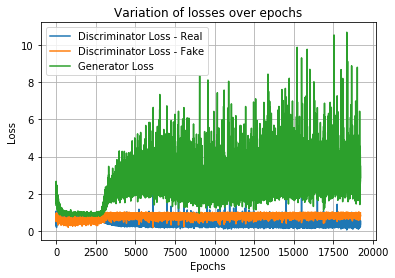

19201 [D loss: 0.309912, acc.: 81.25%] [G loss: 2.559983]
19202 [D loss: 0.418545, acc.: 81.25%] [G loss: 2.799457]
19203 [D loss: 0.192758, acc.: 93.75%] [G loss: 2.944773]
19204 [D loss: 0.450250, acc.: 78.12%] [G loss: 2.353791]
19205 [D loss: 0.363511, acc.: 81.25%] [G loss: 1.921681]
19206 [D loss: 0.270469, acc.: 93.75%] [G loss: 3.157892]
19207 [D loss: 0.343550, acc.: 84.38%] [G loss: 2.547381]
19208 [D loss: 0.262178, acc.: 90.62%] [G loss: 2.561552]
19209 [D loss: 0.410747, acc.: 78.12%] [G loss: 4.691875]
19210 [D loss: 0.319625, acc.: 84.38%] [G loss: 3.687843]
19211 [D loss: 0.543505, acc.: 75.00%] [G loss: 4.267268]
19212 [D loss: 0.268918, acc.: 90.62%] [G loss: 2.560321]
19213 [D loss: 0.402107, acc.: 75.00%] [G loss: 2.599590]
19214 [D loss: 0.223254, acc.: 93.75%] [G loss: 3.052681]
19215 [D loss: 0.391316, acc.: 75.00%] [G loss: 3.365048]
19216 [D loss: 0.249181, acc.: 90.62%] [G loss: 2.997179]
19217 [D loss: 0.323587, acc.: 87.50%] [G loss: 3.946775]
19218 [D loss:

19344 [D loss: 0.273664, acc.: 87.50%] [G loss: 3.137351]
19345 [D loss: 0.202734, acc.: 96.88%] [G loss: 3.151898]
19346 [D loss: 0.564705, acc.: 71.88%] [G loss: 4.063248]
19347 [D loss: 0.384542, acc.: 84.38%] [G loss: 1.811695]
19348 [D loss: 0.449092, acc.: 84.38%] [G loss: 3.298854]
19349 [D loss: 0.311795, acc.: 90.62%] [G loss: 3.089267]
19350 [D loss: 0.312669, acc.: 78.12%] [G loss: 3.310783]
19351 [D loss: 0.320641, acc.: 84.38%] [G loss: 3.197515]
19352 [D loss: 0.459458, acc.: 81.25%] [G loss: 2.059678]
19353 [D loss: 0.339552, acc.: 84.38%] [G loss: 2.632477]
19354 [D loss: 0.330060, acc.: 87.50%] [G loss: 2.870549]
19355 [D loss: 0.289284, acc.: 81.25%] [G loss: 3.180908]
19356 [D loss: 0.320822, acc.: 87.50%] [G loss: 2.915641]
19357 [D loss: 0.560176, acc.: 68.75%] [G loss: 2.564619]
19358 [D loss: 0.405346, acc.: 75.00%] [G loss: 2.464080]
19359 [D loss: 0.370068, acc.: 87.50%] [G loss: 2.642141]
19360 [D loss: 0.207297, acc.: 93.75%] [G loss: 2.839225]
19361 [D loss:

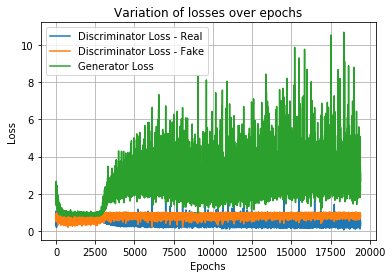

19401 [D loss: 0.602167, acc.: 75.00%] [G loss: 2.614033]
19402 [D loss: 0.335714, acc.: 84.38%] [G loss: 3.469086]
19403 [D loss: 0.481414, acc.: 78.12%] [G loss: 2.964700]
19404 [D loss: 0.214119, acc.: 90.62%] [G loss: 3.177740]
19405 [D loss: 0.426550, acc.: 81.25%] [G loss: 3.280018]
19406 [D loss: 0.564155, acc.: 75.00%] [G loss: 2.997069]
19407 [D loss: 0.316292, acc.: 84.38%] [G loss: 3.645859]
19408 [D loss: 0.553683, acc.: 68.75%] [G loss: 1.925659]
19409 [D loss: 0.210940, acc.: 90.62%] [G loss: 3.435268]
19410 [D loss: 0.593734, acc.: 75.00%] [G loss: 3.843705]
19411 [D loss: 0.265436, acc.: 90.62%] [G loss: 2.623790]
19412 [D loss: 0.419739, acc.: 87.50%] [G loss: 3.211739]
19413 [D loss: 0.136000, acc.: 96.88%] [G loss: 2.283142]
19414 [D loss: 0.545518, acc.: 71.88%] [G loss: 2.748872]
19415 [D loss: 0.244077, acc.: 93.75%] [G loss: 2.534622]
19416 [D loss: 0.451828, acc.: 68.75%] [G loss: 3.117301]
19417 [D loss: 0.201362, acc.: 93.75%] [G loss: 3.223452]
19418 [D loss:

19544 [D loss: 0.313250, acc.: 84.38%] [G loss: 1.930707]
19545 [D loss: 0.407186, acc.: 81.25%] [G loss: 2.610529]
19546 [D loss: 0.333509, acc.: 81.25%] [G loss: 2.678673]
19547 [D loss: 0.315548, acc.: 90.62%] [G loss: 2.575828]
19548 [D loss: 0.403939, acc.: 81.25%] [G loss: 2.957156]
19549 [D loss: 0.470234, acc.: 75.00%] [G loss: 2.958280]
19550 [D loss: 0.339195, acc.: 90.62%] [G loss: 3.234998]
19551 [D loss: 0.405713, acc.: 78.12%] [G loss: 3.433367]
19552 [D loss: 0.350993, acc.: 81.25%] [G loss: 2.619101]
19553 [D loss: 0.312199, acc.: 84.38%] [G loss: 3.400884]
19554 [D loss: 0.430544, acc.: 71.88%] [G loss: 4.433333]
19555 [D loss: 0.469790, acc.: 75.00%] [G loss: 2.103872]
19556 [D loss: 0.404849, acc.: 81.25%] [G loss: 3.915281]
19557 [D loss: 0.321148, acc.: 84.38%] [G loss: 2.694746]
19558 [D loss: 0.465374, acc.: 78.12%] [G loss: 2.174132]
19559 [D loss: 0.338328, acc.: 87.50%] [G loss: 3.183385]
19560 [D loss: 0.398111, acc.: 84.38%] [G loss: 3.065820]
19561 [D loss:

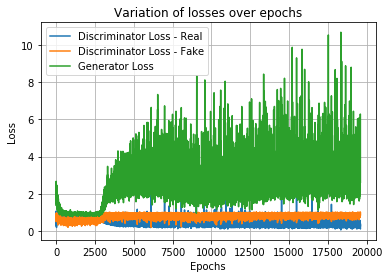

19601 [D loss: 0.516241, acc.: 68.75%] [G loss: 4.213711]
19602 [D loss: 0.218646, acc.: 90.62%] [G loss: 2.599488]
19603 [D loss: 0.312779, acc.: 84.38%] [G loss: 3.666520]
19604 [D loss: 0.418599, acc.: 81.25%] [G loss: 3.316303]
19605 [D loss: 0.397678, acc.: 71.88%] [G loss: 5.190558]
19606 [D loss: 0.581783, acc.: 75.00%] [G loss: 3.665283]
19607 [D loss: 0.623262, acc.: 65.62%] [G loss: 4.091278]
19608 [D loss: 0.428711, acc.: 81.25%] [G loss: 3.104866]
19609 [D loss: 0.312712, acc.: 81.25%] [G loss: 4.629399]
19610 [D loss: 0.371453, acc.: 87.50%] [G loss: 3.988671]
19611 [D loss: 0.199427, acc.: 87.50%] [G loss: 2.917241]
19612 [D loss: 0.354216, acc.: 81.25%] [G loss: 1.634083]
19613 [D loss: 0.452941, acc.: 81.25%] [G loss: 2.980169]
19614 [D loss: 0.470806, acc.: 78.12%] [G loss: 2.585510]
19615 [D loss: 0.247839, acc.: 90.62%] [G loss: 2.404158]
19616 [D loss: 0.225479, acc.: 93.75%] [G loss: 3.212256]
19617 [D loss: 0.421835, acc.: 84.38%] [G loss: 2.994010]
19618 [D loss:

19743 [D loss: 0.495206, acc.: 68.75%] [G loss: 2.981122]
19744 [D loss: 0.345047, acc.: 84.38%] [G loss: 2.592278]
19745 [D loss: 0.499932, acc.: 84.38%] [G loss: 2.866839]
19746 [D loss: 0.286146, acc.: 87.50%] [G loss: 3.799482]
19747 [D loss: 0.832479, acc.: 56.25%] [G loss: 2.010412]
19748 [D loss: 0.444166, acc.: 84.38%] [G loss: 1.800348]
19749 [D loss: 0.320939, acc.: 87.50%] [G loss: 2.461687]
19750 [D loss: 0.323112, acc.: 93.75%] [G loss: 1.864527]
19751 [D loss: 0.510944, acc.: 68.75%] [G loss: 2.379871]
19752 [D loss: 0.256821, acc.: 87.50%] [G loss: 2.834628]
19753 [D loss: 0.345077, acc.: 87.50%] [G loss: 2.372344]
19754 [D loss: 0.261386, acc.: 90.62%] [G loss: 3.101610]
19755 [D loss: 0.307462, acc.: 84.38%] [G loss: 3.769966]
19756 [D loss: 0.228497, acc.: 93.75%] [G loss: 4.503084]
19757 [D loss: 0.339867, acc.: 87.50%] [G loss: 2.976664]
19758 [D loss: 0.318743, acc.: 87.50%] [G loss: 3.232289]
19759 [D loss: 0.296886, acc.: 90.62%] [G loss: 4.278456]
19760 [D loss:

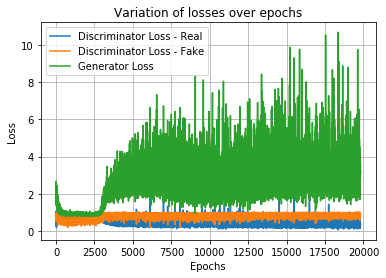

19801 [D loss: 0.566046, acc.: 71.88%] [G loss: 3.515017]
19802 [D loss: 0.293220, acc.: 87.50%] [G loss: 2.623352]
19803 [D loss: 0.523016, acc.: 71.88%] [G loss: 3.271296]
19804 [D loss: 0.374289, acc.: 84.38%] [G loss: 3.096035]
19805 [D loss: 0.313958, acc.: 90.62%] [G loss: 2.964046]
19806 [D loss: 0.273637, acc.: 87.50%] [G loss: 2.963890]
19807 [D loss: 0.323242, acc.: 71.88%] [G loss: 2.482422]
19808 [D loss: 0.497641, acc.: 68.75%] [G loss: 3.226200]
19809 [D loss: 0.372328, acc.: 84.38%] [G loss: 2.733333]
19810 [D loss: 0.309115, acc.: 84.38%] [G loss: 3.868744]
19811 [D loss: 0.305419, acc.: 87.50%] [G loss: 4.577892]
19812 [D loss: 0.321780, acc.: 90.62%] [G loss: 4.019934]
19813 [D loss: 0.436832, acc.: 84.38%] [G loss: 2.810440]
19814 [D loss: 0.211184, acc.: 90.62%] [G loss: 3.219815]
19815 [D loss: 0.308690, acc.: 84.38%] [G loss: 2.486135]
19816 [D loss: 0.339838, acc.: 87.50%] [G loss: 3.019567]
19817 [D loss: 0.355582, acc.: 81.25%] [G loss: 3.023231]
19818 [D loss:

19943 [D loss: 0.265592, acc.: 90.62%] [G loss: 2.306181]
19944 [D loss: 0.176523, acc.: 96.88%] [G loss: 3.289339]
19945 [D loss: 0.470002, acc.: 81.25%] [G loss: 2.018572]
19946 [D loss: 0.561529, acc.: 75.00%] [G loss: 3.388941]
19947 [D loss: 0.584079, acc.: 65.62%] [G loss: 2.820436]
19948 [D loss: 0.373881, acc.: 87.50%] [G loss: 3.375855]
19949 [D loss: 0.404597, acc.: 81.25%] [G loss: 3.580253]
19950 [D loss: 0.295966, acc.: 87.50%] [G loss: 5.153913]
19951 [D loss: 0.509515, acc.: 75.00%] [G loss: 3.124225]
19952 [D loss: 0.396179, acc.: 87.50%] [G loss: 3.592862]
19953 [D loss: 0.431698, acc.: 78.12%] [G loss: 2.128898]
19954 [D loss: 0.146180, acc.: 100.00%] [G loss: 2.646690]
19955 [D loss: 0.238718, acc.: 93.75%] [G loss: 2.405275]
19956 [D loss: 0.286789, acc.: 84.38%] [G loss: 2.504018]
19957 [D loss: 0.254901, acc.: 87.50%] [G loss: 2.224319]
19958 [D loss: 0.501780, acc.: 71.88%] [G loss: 2.850759]
19959 [D loss: 0.206652, acc.: 93.75%] [G loss: 2.463943]
19960 [D loss

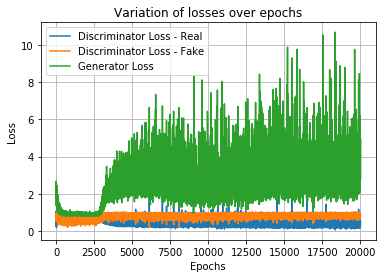

20001 [D loss: 0.306143, acc.: 84.38%] [G loss: 3.625811]
20002 [D loss: 0.294878, acc.: 84.38%] [G loss: 2.978508]
20003 [D loss: 0.152302, acc.: 93.75%] [G loss: 3.276171]
20004 [D loss: 0.271140, acc.: 87.50%] [G loss: 3.730697]
20005 [D loss: 0.318724, acc.: 75.00%] [G loss: 3.221567]
20006 [D loss: 0.256798, acc.: 90.62%] [G loss: 3.913495]
20007 [D loss: 0.339059, acc.: 84.38%] [G loss: 3.527247]
20008 [D loss: 0.368504, acc.: 84.38%] [G loss: 2.718518]
20009 [D loss: 0.265769, acc.: 87.50%] [G loss: 4.533319]
20010 [D loss: 0.128538, acc.: 100.00%] [G loss: 3.080783]
20011 [D loss: 0.283648, acc.: 84.38%] [G loss: 3.096823]
20012 [D loss: 0.357603, acc.: 87.50%] [G loss: 1.839744]
20013 [D loss: 0.422014, acc.: 81.25%] [G loss: 5.058997]
20014 [D loss: 0.375273, acc.: 75.00%] [G loss: 2.999875]
20015 [D loss: 0.394429, acc.: 81.25%] [G loss: 3.824888]
20016 [D loss: 0.174997, acc.: 96.88%] [G loss: 5.131739]
20017 [D loss: 0.715476, acc.: 68.75%] [G loss: 2.940765]
20018 [D loss

20143 [D loss: 0.491648, acc.: 78.12%] [G loss: 2.532395]
20144 [D loss: 0.248400, acc.: 90.62%] [G loss: 4.807826]
20145 [D loss: 0.309575, acc.: 84.38%] [G loss: 2.306870]
20146 [D loss: 0.488482, acc.: 68.75%] [G loss: 2.405797]
20147 [D loss: 0.300231, acc.: 84.38%] [G loss: 2.588789]
20148 [D loss: 0.233958, acc.: 90.62%] [G loss: 3.390648]
20149 [D loss: 0.415096, acc.: 84.38%] [G loss: 2.752911]
20150 [D loss: 0.195105, acc.: 93.75%] [G loss: 2.630060]
20151 [D loss: 0.297460, acc.: 87.50%] [G loss: 2.278095]
20152 [D loss: 0.362414, acc.: 81.25%] [G loss: 2.472558]
20153 [D loss: 0.267157, acc.: 93.75%] [G loss: 2.443020]
20154 [D loss: 0.262541, acc.: 93.75%] [G loss: 2.258080]
20155 [D loss: 0.347361, acc.: 81.25%] [G loss: 2.462397]
20156 [D loss: 0.261764, acc.: 90.62%] [G loss: 2.703601]
20157 [D loss: 0.315972, acc.: 84.38%] [G loss: 2.240780]
20158 [D loss: 0.345997, acc.: 84.38%] [G loss: 2.197034]
20159 [D loss: 0.315262, acc.: 90.62%] [G loss: 2.089020]
20160 [D loss:

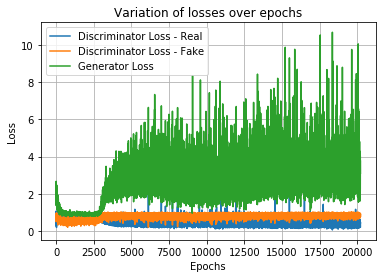

20201 [D loss: 0.279861, acc.: 87.50%] [G loss: 2.277770]
20202 [D loss: 0.177870, acc.: 100.00%] [G loss: 2.427627]
20203 [D loss: 0.443965, acc.: 75.00%] [G loss: 2.629396]
20204 [D loss: 0.338433, acc.: 84.38%] [G loss: 2.487205]
20205 [D loss: 0.250717, acc.: 90.62%] [G loss: 3.011796]
20206 [D loss: 0.383228, acc.: 84.38%] [G loss: 2.486392]
20207 [D loss: 0.275150, acc.: 93.75%] [G loss: 2.973973]
20208 [D loss: 0.253776, acc.: 87.50%] [G loss: 4.236398]
20209 [D loss: 0.327573, acc.: 84.38%] [G loss: 4.597452]
20210 [D loss: 0.387706, acc.: 84.38%] [G loss: 2.407377]
20211 [D loss: 0.334442, acc.: 84.38%] [G loss: 3.204024]
20212 [D loss: 0.302607, acc.: 84.38%] [G loss: 2.880096]
20213 [D loss: 0.370998, acc.: 84.38%] [G loss: 4.258183]
20214 [D loss: 0.400065, acc.: 78.12%] [G loss: 3.153890]
20215 [D loss: 0.273454, acc.: 87.50%] [G loss: 2.892286]
20216 [D loss: 0.452073, acc.: 78.12%] [G loss: 3.034976]
20217 [D loss: 0.421824, acc.: 75.00%] [G loss: 2.665670]
20218 [D loss

20343 [D loss: 0.271391, acc.: 87.50%] [G loss: 2.696644]
20344 [D loss: 0.373365, acc.: 78.12%] [G loss: 4.101474]
20345 [D loss: 0.321496, acc.: 93.75%] [G loss: 3.678007]
20346 [D loss: 0.441662, acc.: 78.12%] [G loss: 3.242129]
20347 [D loss: 0.375593, acc.: 84.38%] [G loss: 2.859196]
20348 [D loss: 0.192742, acc.: 96.88%] [G loss: 2.928409]
20349 [D loss: 0.382001, acc.: 75.00%] [G loss: 2.518953]
20350 [D loss: 0.425687, acc.: 78.12%] [G loss: 2.500261]
20351 [D loss: 0.442140, acc.: 78.12%] [G loss: 2.776634]
20352 [D loss: 0.389334, acc.: 87.50%] [G loss: 3.055188]
20353 [D loss: 0.330322, acc.: 90.62%] [G loss: 3.860198]
20354 [D loss: 0.388965, acc.: 84.38%] [G loss: 3.827065]
20355 [D loss: 0.256573, acc.: 90.62%] [G loss: 2.078988]
20356 [D loss: 0.382100, acc.: 78.12%] [G loss: 5.268697]
20357 [D loss: 0.258085, acc.: 87.50%] [G loss: 3.598520]
20358 [D loss: 0.232397, acc.: 93.75%] [G loss: 4.258798]
20359 [D loss: 0.311749, acc.: 84.38%] [G loss: 3.110610]
20360 [D loss:

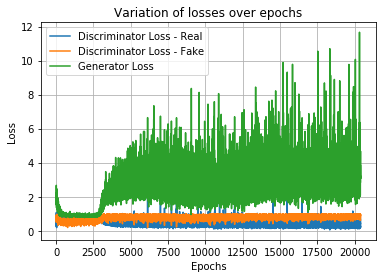

20401 [D loss: 0.306570, acc.: 87.50%] [G loss: 3.425877]
20402 [D loss: 0.499843, acc.: 84.38%] [G loss: 5.321218]
20403 [D loss: 0.791958, acc.: 59.38%] [G loss: 3.195642]
20404 [D loss: 0.357242, acc.: 84.38%] [G loss: 2.636835]
20405 [D loss: 0.237325, acc.: 90.62%] [G loss: 3.550964]
20406 [D loss: 0.311057, acc.: 87.50%] [G loss: 3.340170]
20407 [D loss: 0.219815, acc.: 93.75%] [G loss: 5.366963]
20408 [D loss: 0.383149, acc.: 78.12%] [G loss: 3.309564]
20409 [D loss: 0.264900, acc.: 87.50%] [G loss: 5.428491]
20410 [D loss: 0.308485, acc.: 84.38%] [G loss: 3.363860]
20411 [D loss: 0.222617, acc.: 93.75%] [G loss: 3.987989]
20412 [D loss: 0.242969, acc.: 93.75%] [G loss: 3.370686]
20413 [D loss: 0.124971, acc.: 93.75%] [G loss: 4.375994]
20414 [D loss: 0.171121, acc.: 100.00%] [G loss: 2.956065]
20415 [D loss: 0.284452, acc.: 81.25%] [G loss: 2.825514]
20416 [D loss: 0.381226, acc.: 84.38%] [G loss: 2.264858]
20417 [D loss: 0.373632, acc.: 81.25%] [G loss: 2.183143]
20418 [D loss

20544 [D loss: 0.348171, acc.: 81.25%] [G loss: 3.526035]
20545 [D loss: 0.297544, acc.: 84.38%] [G loss: 4.374697]
20546 [D loss: 0.385639, acc.: 78.12%] [G loss: 3.180648]
20547 [D loss: 0.393521, acc.: 84.38%] [G loss: 4.556802]
20548 [D loss: 0.437107, acc.: 81.25%] [G loss: 3.247748]
20549 [D loss: 0.272744, acc.: 90.62%] [G loss: 2.474671]
20550 [D loss: 0.354407, acc.: 78.12%] [G loss: 3.965776]
20551 [D loss: 0.301965, acc.: 84.38%] [G loss: 3.788106]
20552 [D loss: 0.431875, acc.: 81.25%] [G loss: 3.167387]
20553 [D loss: 0.416211, acc.: 78.12%] [G loss: 2.643661]
20554 [D loss: 0.250425, acc.: 93.75%] [G loss: 3.063595]
20555 [D loss: 0.358631, acc.: 78.12%] [G loss: 3.036843]
20556 [D loss: 0.306578, acc.: 90.62%] [G loss: 3.637894]
20557 [D loss: 0.295393, acc.: 87.50%] [G loss: 2.720907]
20558 [D loss: 0.321242, acc.: 84.38%] [G loss: 3.166731]
20559 [D loss: 0.365795, acc.: 90.62%] [G loss: 3.009099]
20560 [D loss: 0.236345, acc.: 90.62%] [G loss: 3.407133]
20561 [D loss:

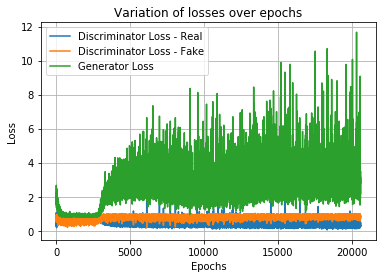

20601 [D loss: 0.378662, acc.: 75.00%] [G loss: 2.641501]
20602 [D loss: 0.290184, acc.: 87.50%] [G loss: 3.088933]
20603 [D loss: 0.245385, acc.: 90.62%] [G loss: 1.732305]
20604 [D loss: 0.203785, acc.: 93.75%] [G loss: 3.406011]
20605 [D loss: 0.269994, acc.: 87.50%] [G loss: 4.250500]
20606 [D loss: 0.388248, acc.: 84.38%] [G loss: 2.988615]
20607 [D loss: 0.189086, acc.: 93.75%] [G loss: 3.350986]
20608 [D loss: 0.311110, acc.: 78.12%] [G loss: 3.023145]
20609 [D loss: 0.361407, acc.: 81.25%] [G loss: 3.322764]
20610 [D loss: 0.245119, acc.: 93.75%] [G loss: 3.378172]
20611 [D loss: 0.353911, acc.: 81.25%] [G loss: 2.671342]
20612 [D loss: 0.671712, acc.: 68.75%] [G loss: 2.285961]
20613 [D loss: 0.308181, acc.: 81.25%] [G loss: 2.824923]
20614 [D loss: 0.343214, acc.: 81.25%] [G loss: 2.747941]
20615 [D loss: 0.498311, acc.: 75.00%] [G loss: 4.390800]
20616 [D loss: 0.623727, acc.: 65.62%] [G loss: 5.375586]
20617 [D loss: 0.374870, acc.: 81.25%] [G loss: 3.199044]
20618 [D loss:

20744 [D loss: 0.358255, acc.: 87.50%] [G loss: 2.549340]
20745 [D loss: 0.409654, acc.: 87.50%] [G loss: 3.346263]
20746 [D loss: 0.255500, acc.: 87.50%] [G loss: 3.709751]
20747 [D loss: 0.567522, acc.: 78.12%] [G loss: 2.533264]
20748 [D loss: 0.307913, acc.: 87.50%] [G loss: 2.333332]
20749 [D loss: 0.412079, acc.: 68.75%] [G loss: 3.057261]
20750 [D loss: 0.282853, acc.: 87.50%] [G loss: 3.357924]
20751 [D loss: 0.534796, acc.: 71.88%] [G loss: 2.046470]
20752 [D loss: 0.444472, acc.: 81.25%] [G loss: 3.328378]
20753 [D loss: 0.567548, acc.: 75.00%] [G loss: 2.034189]
20754 [D loss: 0.427486, acc.: 78.12%] [G loss: 2.723846]
20755 [D loss: 0.232770, acc.: 93.75%] [G loss: 3.339661]
20756 [D loss: 0.333530, acc.: 84.38%] [G loss: 3.476122]
20757 [D loss: 0.410781, acc.: 84.38%] [G loss: 3.145192]
20758 [D loss: 0.401227, acc.: 81.25%] [G loss: 3.348217]
20759 [D loss: 0.294400, acc.: 87.50%] [G loss: 3.117502]
20760 [D loss: 0.344578, acc.: 84.38%] [G loss: 2.696203]
20761 [D loss:

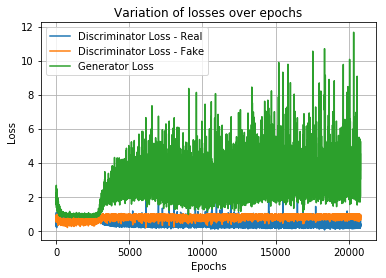

20801 [D loss: 0.364035, acc.: 78.12%] [G loss: 4.623153]
20802 [D loss: 0.604596, acc.: 68.75%] [G loss: 2.931173]
20803 [D loss: 0.367243, acc.: 84.38%] [G loss: 2.506392]
20804 [D loss: 0.397608, acc.: 78.12%] [G loss: 3.009108]
20805 [D loss: 0.231521, acc.: 90.62%] [G loss: 2.744749]
20806 [D loss: 0.273134, acc.: 90.62%] [G loss: 2.570809]
20807 [D loss: 0.235250, acc.: 93.75%] [G loss: 2.571825]
20808 [D loss: 0.605452, acc.: 62.50%] [G loss: 2.700463]
20809 [D loss: 0.245073, acc.: 96.88%] [G loss: 2.601600]
20810 [D loss: 0.456994, acc.: 81.25%] [G loss: 3.856202]
20811 [D loss: 0.203490, acc.: 96.88%] [G loss: 2.359525]
20812 [D loss: 0.400907, acc.: 71.88%] [G loss: 3.906104]
20813 [D loss: 0.353627, acc.: 81.25%] [G loss: 2.253271]
20814 [D loss: 0.280553, acc.: 87.50%] [G loss: 2.593458]
20815 [D loss: 0.395339, acc.: 84.38%] [G loss: 2.836030]
20816 [D loss: 0.250876, acc.: 90.62%] [G loss: 2.284602]
20817 [D loss: 0.435855, acc.: 78.12%] [G loss: 2.479273]
20818 [D loss:

20944 [D loss: 0.420985, acc.: 81.25%] [G loss: 3.061107]
20945 [D loss: 0.131782, acc.: 100.00%] [G loss: 2.560450]
20946 [D loss: 0.575651, acc.: 71.88%] [G loss: 2.684194]
20947 [D loss: 0.513006, acc.: 75.00%] [G loss: 2.704187]
20948 [D loss: 0.215406, acc.: 93.75%] [G loss: 3.507190]
20949 [D loss: 0.377118, acc.: 90.62%] [G loss: 3.259662]
20950 [D loss: 0.354944, acc.: 87.50%] [G loss: 2.796868]
20951 [D loss: 0.352891, acc.: 84.38%] [G loss: 2.771388]
20952 [D loss: 0.394305, acc.: 75.00%] [G loss: 2.269703]
20953 [D loss: 0.223885, acc.: 93.75%] [G loss: 2.817908]
20954 [D loss: 0.349339, acc.: 84.38%] [G loss: 2.894877]
20955 [D loss: 0.280412, acc.: 90.62%] [G loss: 2.878477]
20956 [D loss: 0.289342, acc.: 87.50%] [G loss: 3.129207]
20957 [D loss: 0.220249, acc.: 93.75%] [G loss: 2.435086]
20958 [D loss: 0.261988, acc.: 87.50%] [G loss: 2.914586]
20959 [D loss: 0.247725, acc.: 87.50%] [G loss: 3.181421]
20960 [D loss: 0.212033, acc.: 93.75%] [G loss: 2.448313]
20961 [D loss

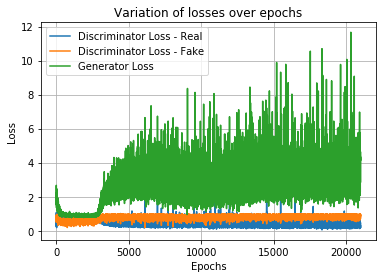

21001 [D loss: 0.289069, acc.: 84.38%] [G loss: 2.933241]
21002 [D loss: 0.431097, acc.: 78.12%] [G loss: 4.369880]
21003 [D loss: 0.344024, acc.: 81.25%] [G loss: 4.510474]
21004 [D loss: 0.217412, acc.: 87.50%] [G loss: 3.287945]
21005 [D loss: 0.511987, acc.: 75.00%] [G loss: 3.330832]
21006 [D loss: 0.226940, acc.: 90.62%] [G loss: 3.200391]
21007 [D loss: 0.436465, acc.: 78.12%] [G loss: 1.818473]
21008 [D loss: 0.667554, acc.: 68.75%] [G loss: 3.182770]
21009 [D loss: 0.225533, acc.: 93.75%] [G loss: 3.153306]
21010 [D loss: 0.255305, acc.: 90.62%] [G loss: 2.409853]
21011 [D loss: 0.328008, acc.: 81.25%] [G loss: 2.602552]
21012 [D loss: 0.325611, acc.: 87.50%] [G loss: 2.114660]
21013 [D loss: 0.590392, acc.: 65.62%] [G loss: 2.653732]
21014 [D loss: 0.331700, acc.: 75.00%] [G loss: 2.540797]
21015 [D loss: 0.416934, acc.: 81.25%] [G loss: 2.277750]
21016 [D loss: 0.329856, acc.: 84.38%] [G loss: 2.378606]
21017 [D loss: 0.363773, acc.: 78.12%] [G loss: 3.335321]
21018 [D loss:

21143 [D loss: 0.230952, acc.: 93.75%] [G loss: 4.352994]
21144 [D loss: 0.369930, acc.: 84.38%] [G loss: 2.991563]
21145 [D loss: 0.326852, acc.: 81.25%] [G loss: 3.495097]
21146 [D loss: 0.481560, acc.: 71.88%] [G loss: 3.402146]
21147 [D loss: 0.431995, acc.: 81.25%] [G loss: 2.706884]
21148 [D loss: 0.276416, acc.: 84.38%] [G loss: 3.935591]
21149 [D loss: 0.271847, acc.: 87.50%] [G loss: 3.121870]
21150 [D loss: 0.300895, acc.: 84.38%] [G loss: 2.386248]
21151 [D loss: 0.312261, acc.: 96.88%] [G loss: 4.124848]
21152 [D loss: 0.430353, acc.: 78.12%] [G loss: 2.706804]
21153 [D loss: 0.369485, acc.: 81.25%] [G loss: 2.821505]
21154 [D loss: 0.207058, acc.: 93.75%] [G loss: 3.062926]
21155 [D loss: 0.669999, acc.: 65.62%] [G loss: 3.904955]
21156 [D loss: 0.287980, acc.: 90.62%] [G loss: 2.813154]
21157 [D loss: 0.462780, acc.: 81.25%] [G loss: 2.185318]
21158 [D loss: 0.338685, acc.: 90.62%] [G loss: 2.035044]
21159 [D loss: 0.335966, acc.: 87.50%] [G loss: 2.833303]
21160 [D loss:

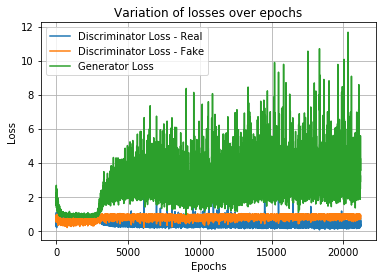

21201 [D loss: 0.371298, acc.: 84.38%] [G loss: 4.474684]
21202 [D loss: 0.364724, acc.: 81.25%] [G loss: 4.192889]
21203 [D loss: 0.427066, acc.: 78.12%] [G loss: 4.132439]
21204 [D loss: 0.720894, acc.: 62.50%] [G loss: 3.515176]
21205 [D loss: 0.298281, acc.: 81.25%] [G loss: 3.566750]
21206 [D loss: 0.128911, acc.: 100.00%] [G loss: 3.508188]
21207 [D loss: 0.246471, acc.: 93.75%] [G loss: 3.841441]
21208 [D loss: 0.329155, acc.: 81.25%] [G loss: 2.662042]
21209 [D loss: 0.185689, acc.: 93.75%] [G loss: 2.873176]
21210 [D loss: 0.347765, acc.: 84.38%] [G loss: 2.145415]
21211 [D loss: 0.501363, acc.: 75.00%] [G loss: 2.689082]
21212 [D loss: 0.309114, acc.: 84.38%] [G loss: 3.251055]
21213 [D loss: 0.265827, acc.: 87.50%] [G loss: 2.560442]
21214 [D loss: 0.364737, acc.: 84.38%] [G loss: 2.617392]
21215 [D loss: 0.416206, acc.: 87.50%] [G loss: 2.322156]
21216 [D loss: 0.267291, acc.: 93.75%] [G loss: 2.707362]
21217 [D loss: 0.193622, acc.: 90.62%] [G loss: 2.809005]
21218 [D loss

21344 [D loss: 0.270042, acc.: 84.38%] [G loss: 5.503352]
21345 [D loss: 0.261502, acc.: 90.62%] [G loss: 3.556154]
21346 [D loss: 0.197611, acc.: 90.62%] [G loss: 4.251176]
21347 [D loss: 0.339941, acc.: 81.25%] [G loss: 3.027008]
21348 [D loss: 0.442902, acc.: 84.38%] [G loss: 2.263101]
21349 [D loss: 0.552257, acc.: 71.88%] [G loss: 3.559220]
21350 [D loss: 0.133178, acc.: 96.88%] [G loss: 3.416775]
21351 [D loss: 0.371743, acc.: 78.12%] [G loss: 3.121413]
21352 [D loss: 0.247091, acc.: 90.62%] [G loss: 3.142115]
21353 [D loss: 0.298465, acc.: 84.38%] [G loss: 2.787663]
21354 [D loss: 0.207364, acc.: 93.75%] [G loss: 2.487258]
21355 [D loss: 0.361625, acc.: 81.25%] [G loss: 2.859166]
21356 [D loss: 0.510352, acc.: 75.00%] [G loss: 2.790825]
21357 [D loss: 0.285824, acc.: 96.88%] [G loss: 4.191102]
21358 [D loss: 0.418688, acc.: 81.25%] [G loss: 3.979159]
21359 [D loss: 0.335358, acc.: 81.25%] [G loss: 3.593981]
21360 [D loss: 0.415927, acc.: 78.12%] [G loss: 2.902335]
21361 [D loss:

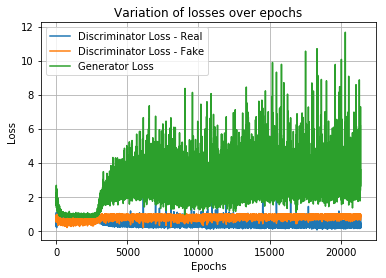

21401 [D loss: 0.326274, acc.: 90.62%] [G loss: 3.779953]
21402 [D loss: 0.221809, acc.: 90.62%] [G loss: 4.431611]
21403 [D loss: 0.191678, acc.: 93.75%] [G loss: 3.293168]
21404 [D loss: 0.480420, acc.: 84.38%] [G loss: 2.872861]
21405 [D loss: 0.340714, acc.: 87.50%] [G loss: 2.544924]
21406 [D loss: 0.270324, acc.: 93.75%] [G loss: 2.235890]
21407 [D loss: 0.299118, acc.: 90.62%] [G loss: 3.565316]
21408 [D loss: 0.250906, acc.: 90.62%] [G loss: 3.224956]
21409 [D loss: 0.316029, acc.: 87.50%] [G loss: 3.581783]
21410 [D loss: 0.479468, acc.: 75.00%] [G loss: 3.947484]
21411 [D loss: 0.217884, acc.: 93.75%] [G loss: 3.854389]
21412 [D loss: 0.483510, acc.: 81.25%] [G loss: 2.679960]
21413 [D loss: 0.338413, acc.: 87.50%] [G loss: 2.858648]
21414 [D loss: 0.263579, acc.: 90.62%] [G loss: 2.807677]
21415 [D loss: 0.160682, acc.: 93.75%] [G loss: 3.650257]
21416 [D loss: 0.303575, acc.: 87.50%] [G loss: 3.729180]
21417 [D loss: 0.298934, acc.: 93.75%] [G loss: 3.760007]
21418 [D loss:

21543 [D loss: 0.519459, acc.: 84.38%] [G loss: 2.714211]
21544 [D loss: 0.266076, acc.: 87.50%] [G loss: 4.413156]
21545 [D loss: 0.210744, acc.: 90.62%] [G loss: 6.990071]
21546 [D loss: 0.459148, acc.: 81.25%] [G loss: 3.469016]
21547 [D loss: 0.120125, acc.: 96.88%] [G loss: 3.932706]
21548 [D loss: 0.551166, acc.: 78.12%] [G loss: 4.243284]
21549 [D loss: 0.258797, acc.: 84.38%] [G loss: 6.574094]
21550 [D loss: 0.611416, acc.: 65.62%] [G loss: 5.010600]
21551 [D loss: 0.255207, acc.: 87.50%] [G loss: 5.116562]
21552 [D loss: 0.357229, acc.: 81.25%] [G loss: 3.713359]
21553 [D loss: 0.360490, acc.: 81.25%] [G loss: 4.259979]
21554 [D loss: 0.441805, acc.: 84.38%] [G loss: 4.223971]
21555 [D loss: 0.340184, acc.: 90.62%] [G loss: 5.571653]
21556 [D loss: 0.394153, acc.: 78.12%] [G loss: 2.602767]
21557 [D loss: 0.234151, acc.: 87.50%] [G loss: 2.633573]
21558 [D loss: 0.210960, acc.: 90.62%] [G loss: 4.062973]
21559 [D loss: 0.353895, acc.: 90.62%] [G loss: 3.626771]
21560 [D loss:

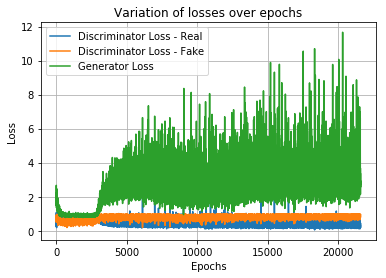

21601 [D loss: 0.337848, acc.: 87.50%] [G loss: 4.641636]
21602 [D loss: 0.181512, acc.: 93.75%] [G loss: 3.614386]
21603 [D loss: 0.309828, acc.: 78.12%] [G loss: 4.638663]
21604 [D loss: 0.265411, acc.: 90.62%] [G loss: 3.660679]
21605 [D loss: 0.483869, acc.: 68.75%] [G loss: 3.256938]
21606 [D loss: 0.265699, acc.: 87.50%] [G loss: 5.372805]
21607 [D loss: 0.444885, acc.: 78.12%] [G loss: 3.001423]
21608 [D loss: 0.242818, acc.: 87.50%] [G loss: 6.523615]
21609 [D loss: 0.211659, acc.: 90.62%] [G loss: 4.189058]
21610 [D loss: 0.181147, acc.: 96.88%] [G loss: 3.940048]
21611 [D loss: 0.231229, acc.: 93.75%] [G loss: 3.736028]
21612 [D loss: 0.444958, acc.: 81.25%] [G loss: 3.884754]
21613 [D loss: 0.196789, acc.: 93.75%] [G loss: 2.844857]
21614 [D loss: 0.357052, acc.: 81.25%] [G loss: 5.622794]
21615 [D loss: 0.354728, acc.: 84.38%] [G loss: 3.304466]
21616 [D loss: 0.742536, acc.: 62.50%] [G loss: 2.045923]
21617 [D loss: 0.371576, acc.: 84.38%] [G loss: 4.371137]
21618 [D loss:

21743 [D loss: 0.337231, acc.: 81.25%] [G loss: 3.107632]
21744 [D loss: 0.425476, acc.: 84.38%] [G loss: 2.890047]
21745 [D loss: 0.284056, acc.: 84.38%] [G loss: 2.838990]
21746 [D loss: 0.315207, acc.: 90.62%] [G loss: 2.468956]
21747 [D loss: 0.258873, acc.: 93.75%] [G loss: 3.282506]
21748 [D loss: 0.328843, acc.: 87.50%] [G loss: 3.464108]
21749 [D loss: 0.327441, acc.: 87.50%] [G loss: 3.272438]
21750 [D loss: 0.335184, acc.: 87.50%] [G loss: 2.648584]
21751 [D loss: 0.418341, acc.: 81.25%] [G loss: 2.850375]
21752 [D loss: 0.414684, acc.: 78.12%] [G loss: 3.501298]
21753 [D loss: 0.566586, acc.: 71.88%] [G loss: 2.972971]
21754 [D loss: 0.259415, acc.: 87.50%] [G loss: 3.129673]
21755 [D loss: 0.236454, acc.: 93.75%] [G loss: 2.681935]
21756 [D loss: 0.254640, acc.: 90.62%] [G loss: 2.882933]
21757 [D loss: 0.442921, acc.: 75.00%] [G loss: 2.642272]
21758 [D loss: 0.298115, acc.: 90.62%] [G loss: 2.244770]
21759 [D loss: 0.193905, acc.: 90.62%] [G loss: 4.127715]
21760 [D loss:

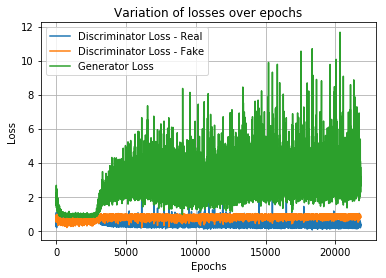

21801 [D loss: 0.397790, acc.: 78.12%] [G loss: 4.036717]
21802 [D loss: 0.365520, acc.: 81.25%] [G loss: 3.810232]
21803 [D loss: 0.357477, acc.: 87.50%] [G loss: 3.904764]
21804 [D loss: 0.298407, acc.: 90.62%] [G loss: 3.088766]
21805 [D loss: 0.372340, acc.: 81.25%] [G loss: 3.153330]
21806 [D loss: 0.264963, acc.: 90.62%] [G loss: 4.254021]
21807 [D loss: 0.122704, acc.: 96.88%] [G loss: 3.767899]
21808 [D loss: 0.448722, acc.: 78.12%] [G loss: 2.663788]
21809 [D loss: 0.352820, acc.: 84.38%] [G loss: 3.804139]
21810 [D loss: 0.463774, acc.: 87.50%] [G loss: 2.653987]
21811 [D loss: 0.327690, acc.: 90.62%] [G loss: 4.209415]
21812 [D loss: 0.190732, acc.: 96.88%] [G loss: 2.981274]
21813 [D loss: 0.573991, acc.: 75.00%] [G loss: 3.262902]
21814 [D loss: 0.339862, acc.: 84.38%] [G loss: 3.680195]
21815 [D loss: 0.362753, acc.: 87.50%] [G loss: 2.801207]
21816 [D loss: 0.233612, acc.: 93.75%] [G loss: 4.587695]
21817 [D loss: 0.326351, acc.: 84.38%] [G loss: 4.757251]
21818 [D loss:

21944 [D loss: 0.412350, acc.: 78.12%] [G loss: 5.357272]
21945 [D loss: 0.382487, acc.: 87.50%] [G loss: 3.253640]
21946 [D loss: 0.264505, acc.: 84.38%] [G loss: 3.328887]
21947 [D loss: 0.232458, acc.: 90.62%] [G loss: 2.492548]
21948 [D loss: 0.653762, acc.: 78.12%] [G loss: 2.698768]
21949 [D loss: 0.373949, acc.: 90.62%] [G loss: 3.623769]
21950 [D loss: 0.326862, acc.: 81.25%] [G loss: 2.468748]
21951 [D loss: 0.234986, acc.: 84.38%] [G loss: 3.162459]
21952 [D loss: 0.315146, acc.: 84.38%] [G loss: 3.072986]
21953 [D loss: 0.448262, acc.: 75.00%] [G loss: 3.149100]
21954 [D loss: 0.510202, acc.: 75.00%] [G loss: 2.871853]
21955 [D loss: 0.351386, acc.: 81.25%] [G loss: 2.641103]
21956 [D loss: 0.273019, acc.: 84.38%] [G loss: 2.940332]
21957 [D loss: 0.263085, acc.: 87.50%] [G loss: 4.466264]
21958 [D loss: 0.150293, acc.: 90.62%] [G loss: 5.670718]
21959 [D loss: 0.385496, acc.: 81.25%] [G loss: 2.432418]
21960 [D loss: 0.507287, acc.: 87.50%] [G loss: 2.928996]
21961 [D loss:

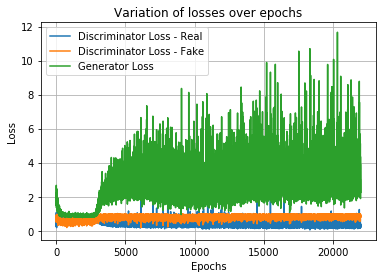

22001 [D loss: 0.312507, acc.: 84.38%] [G loss: 2.613629]
22002 [D loss: 0.362901, acc.: 87.50%] [G loss: 4.296046]
22003 [D loss: 0.354855, acc.: 84.38%] [G loss: 3.623600]
22004 [D loss: 0.277689, acc.: 87.50%] [G loss: 2.360119]
22005 [D loss: 0.317149, acc.: 84.38%] [G loss: 3.784289]
22006 [D loss: 0.297298, acc.: 87.50%] [G loss: 2.776291]
22007 [D loss: 0.306590, acc.: 90.62%] [G loss: 2.372490]
22008 [D loss: 0.561278, acc.: 84.38%] [G loss: 1.972171]
22009 [D loss: 0.323269, acc.: 81.25%] [G loss: 2.137550]
22010 [D loss: 0.488607, acc.: 71.88%] [G loss: 2.611972]
22011 [D loss: 0.389828, acc.: 84.38%] [G loss: 2.237905]
22012 [D loss: 0.406214, acc.: 78.12%] [G loss: 2.234372]
22013 [D loss: 0.265204, acc.: 87.50%] [G loss: 2.155007]
22014 [D loss: 0.486118, acc.: 68.75%] [G loss: 1.691565]
22015 [D loss: 0.447022, acc.: 78.12%] [G loss: 2.592625]
22016 [D loss: 0.340264, acc.: 84.38%] [G loss: 3.547919]
22017 [D loss: 0.405249, acc.: 75.00%] [G loss: 2.333891]
22018 [D loss:

22143 [D loss: 0.375335, acc.: 78.12%] [G loss: 3.583189]
22144 [D loss: 0.553916, acc.: 75.00%] [G loss: 3.781363]
22145 [D loss: 0.389590, acc.: 71.88%] [G loss: 3.939472]
22146 [D loss: 0.280369, acc.: 87.50%] [G loss: 3.102923]
22147 [D loss: 0.203330, acc.: 90.62%] [G loss: 2.825338]
22148 [D loss: 0.242265, acc.: 87.50%] [G loss: 3.356352]
22149 [D loss: 0.376580, acc.: 84.38%] [G loss: 3.288732]
22150 [D loss: 0.379634, acc.: 78.12%] [G loss: 3.863757]
22151 [D loss: 0.377294, acc.: 84.38%] [G loss: 4.029186]
22152 [D loss: 0.305221, acc.: 90.62%] [G loss: 4.362935]
22153 [D loss: 0.301606, acc.: 84.38%] [G loss: 2.869518]
22154 [D loss: 0.388617, acc.: 84.38%] [G loss: 2.539204]
22155 [D loss: 0.280454, acc.: 87.50%] [G loss: 3.349456]
22156 [D loss: 0.233549, acc.: 84.38%] [G loss: 3.259227]
22157 [D loss: 0.384830, acc.: 81.25%] [G loss: 2.735022]
22158 [D loss: 0.502265, acc.: 84.38%] [G loss: 2.337838]
22159 [D loss: 0.279510, acc.: 93.75%] [G loss: 2.848864]
22160 [D loss:

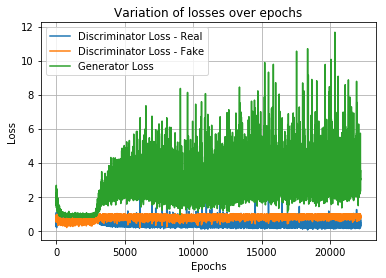

22201 [D loss: 0.312072, acc.: 84.38%] [G loss: 3.419473]
22202 [D loss: 0.421319, acc.: 78.12%] [G loss: 2.728793]
22203 [D loss: 0.425384, acc.: 81.25%] [G loss: 5.745646]
22204 [D loss: 0.310755, acc.: 87.50%] [G loss: 3.620423]
22205 [D loss: 0.371623, acc.: 81.25%] [G loss: 2.789796]
22206 [D loss: 0.285080, acc.: 90.62%] [G loss: 4.338530]
22207 [D loss: 0.423869, acc.: 81.25%] [G loss: 4.705907]
22208 [D loss: 0.531676, acc.: 71.88%] [G loss: 4.541286]
22209 [D loss: 0.482287, acc.: 78.12%] [G loss: 2.850083]
22210 [D loss: 0.454113, acc.: 78.12%] [G loss: 3.982439]
22211 [D loss: 0.255437, acc.: 87.50%] [G loss: 5.727969]
22212 [D loss: 0.505654, acc.: 81.25%] [G loss: 4.896612]
22213 [D loss: 0.395257, acc.: 78.12%] [G loss: 3.113924]
22214 [D loss: 0.147755, acc.: 96.88%] [G loss: 3.213766]
22215 [D loss: 0.296177, acc.: 84.38%] [G loss: 2.549778]
22216 [D loss: 0.354116, acc.: 87.50%] [G loss: 3.517147]
22217 [D loss: 0.543413, acc.: 71.88%] [G loss: 3.466671]
22218 [D loss:

22343 [D loss: 0.548078, acc.: 65.62%] [G loss: 2.654925]
22344 [D loss: 0.485559, acc.: 75.00%] [G loss: 2.432356]
22345 [D loss: 0.263739, acc.: 93.75%] [G loss: 4.195154]
22346 [D loss: 0.438062, acc.: 81.25%] [G loss: 3.869779]
22347 [D loss: 0.340425, acc.: 87.50%] [G loss: 8.345415]
22348 [D loss: 0.290259, acc.: 84.38%] [G loss: 4.404191]
22349 [D loss: 0.332394, acc.: 87.50%] [G loss: 3.563274]
22350 [D loss: 0.344296, acc.: 84.38%] [G loss: 3.029552]
22351 [D loss: 0.271759, acc.: 87.50%] [G loss: 3.474313]
22352 [D loss: 0.348268, acc.: 81.25%] [G loss: 2.668495]
22353 [D loss: 0.445710, acc.: 75.00%] [G loss: 1.665540]
22354 [D loss: 0.243955, acc.: 90.62%] [G loss: 2.795714]
22355 [D loss: 0.380612, acc.: 87.50%] [G loss: 2.315812]
22356 [D loss: 0.382640, acc.: 87.50%] [G loss: 2.328559]
22357 [D loss: 0.298918, acc.: 90.62%] [G loss: 2.139363]
22358 [D loss: 0.434233, acc.: 84.38%] [G loss: 2.985138]
22359 [D loss: 0.267520, acc.: 90.62%] [G loss: 2.994801]
22360 [D loss:

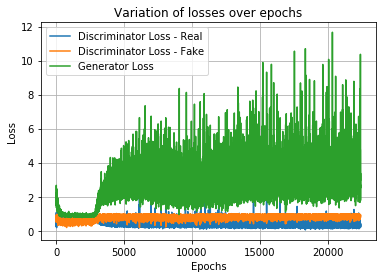

22401 [D loss: 0.365861, acc.: 81.25%] [G loss: 2.794356]
22402 [D loss: 0.393453, acc.: 78.12%] [G loss: 3.248367]
22403 [D loss: 0.273692, acc.: 90.62%] [G loss: 3.317738]
22404 [D loss: 0.258603, acc.: 90.62%] [G loss: 2.065828]
22405 [D loss: 0.279440, acc.: 87.50%] [G loss: 4.802764]
22406 [D loss: 0.480100, acc.: 78.12%] [G loss: 4.221822]
22407 [D loss: 0.418960, acc.: 78.12%] [G loss: 3.611232]
22408 [D loss: 0.312080, acc.: 87.50%] [G loss: 2.859646]
22409 [D loss: 0.557582, acc.: 81.25%] [G loss: 2.425970]
22410 [D loss: 0.424451, acc.: 84.38%] [G loss: 2.381916]
22411 [D loss: 0.202370, acc.: 93.75%] [G loss: 2.411506]
22412 [D loss: 0.400533, acc.: 81.25%] [G loss: 4.521554]
22413 [D loss: 0.301099, acc.: 90.62%] [G loss: 2.899718]
22414 [D loss: 0.432689, acc.: 68.75%] [G loss: 4.346496]
22415 [D loss: 0.287205, acc.: 87.50%] [G loss: 3.085998]
22416 [D loss: 0.301642, acc.: 84.38%] [G loss: 3.429063]
22417 [D loss: 0.368049, acc.: 87.50%] [G loss: 3.533484]
22418 [D loss:

22543 [D loss: 0.306286, acc.: 90.62%] [G loss: 2.226249]
22544 [D loss: 0.587624, acc.: 81.25%] [G loss: 3.367443]
22545 [D loss: 0.370013, acc.: 78.12%] [G loss: 3.152368]
22546 [D loss: 0.349823, acc.: 84.38%] [G loss: 2.413726]
22547 [D loss: 0.237940, acc.: 87.50%] [G loss: 3.341437]
22548 [D loss: 0.273919, acc.: 84.38%] [G loss: 3.117437]
22549 [D loss: 0.244624, acc.: 90.62%] [G loss: 2.586515]
22550 [D loss: 0.178279, acc.: 96.88%] [G loss: 3.297191]
22551 [D loss: 0.216438, acc.: 100.00%] [G loss: 2.593036]
22552 [D loss: 0.274169, acc.: 90.62%] [G loss: 3.261098]
22553 [D loss: 0.422750, acc.: 84.38%] [G loss: 2.754583]
22554 [D loss: 0.472923, acc.: 78.12%] [G loss: 2.849569]
22555 [D loss: 0.162032, acc.: 93.75%] [G loss: 3.279166]
22556 [D loss: 0.384394, acc.: 78.12%] [G loss: 2.490611]
22557 [D loss: 0.309984, acc.: 87.50%] [G loss: 4.098324]
22558 [D loss: 0.387639, acc.: 87.50%] [G loss: 3.249859]
22559 [D loss: 0.176319, acc.: 93.75%] [G loss: 3.424302]
22560 [D loss

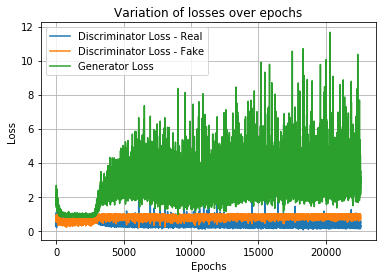

22601 [D loss: 0.168657, acc.: 96.88%] [G loss: 3.679411]
22602 [D loss: 0.380615, acc.: 71.88%] [G loss: 2.799967]
22603 [D loss: 0.223057, acc.: 90.62%] [G loss: 2.855021]
22604 [D loss: 0.300758, acc.: 84.38%] [G loss: 2.630221]
22605 [D loss: 0.195286, acc.: 93.75%] [G loss: 4.359310]
22606 [D loss: 0.121342, acc.: 96.88%] [G loss: 3.074059]
22607 [D loss: 0.294474, acc.: 90.62%] [G loss: 2.477909]
22608 [D loss: 0.365031, acc.: 84.38%] [G loss: 3.562965]
22609 [D loss: 0.226734, acc.: 93.75%] [G loss: 3.223916]
22610 [D loss: 0.628020, acc.: 71.88%] [G loss: 4.808422]
22611 [D loss: 0.263946, acc.: 84.38%] [G loss: 2.843889]
22612 [D loss: 0.539377, acc.: 71.88%] [G loss: 4.202490]
22613 [D loss: 0.315638, acc.: 87.50%] [G loss: 3.533161]
22614 [D loss: 0.686826, acc.: 68.75%] [G loss: 2.495415]
22615 [D loss: 0.121173, acc.: 96.88%] [G loss: 3.575763]
22616 [D loss: 0.413721, acc.: 78.12%] [G loss: 3.115818]
22617 [D loss: 0.166824, acc.: 96.88%] [G loss: 3.337126]
22618 [D loss:

22744 [D loss: 0.214928, acc.: 90.62%] [G loss: 2.571487]
22745 [D loss: 0.394820, acc.: 78.12%] [G loss: 2.411658]
22746 [D loss: 0.350507, acc.: 87.50%] [G loss: 3.925657]
22747 [D loss: 0.369293, acc.: 84.38%] [G loss: 4.328018]
22748 [D loss: 0.258206, acc.: 90.62%] [G loss: 2.939868]
22749 [D loss: 0.260769, acc.: 84.38%] [G loss: 2.298041]
22750 [D loss: 0.429542, acc.: 84.38%] [G loss: 2.143718]
22751 [D loss: 0.469069, acc.: 78.12%] [G loss: 2.811972]
22752 [D loss: 0.267340, acc.: 81.25%] [G loss: 2.957762]
22753 [D loss: 0.435779, acc.: 84.38%] [G loss: 3.972440]
22754 [D loss: 0.228768, acc.: 90.62%] [G loss: 3.254020]
22755 [D loss: 0.327958, acc.: 93.75%] [G loss: 4.967121]
22756 [D loss: 0.267083, acc.: 87.50%] [G loss: 6.320636]
22757 [D loss: 0.213285, acc.: 87.50%] [G loss: 5.696167]
22758 [D loss: 0.055670, acc.: 100.00%] [G loss: 4.365075]
22759 [D loss: 0.234400, acc.: 90.62%] [G loss: 4.369656]
22760 [D loss: 0.175667, acc.: 90.62%] [G loss: 3.537099]
22761 [D loss

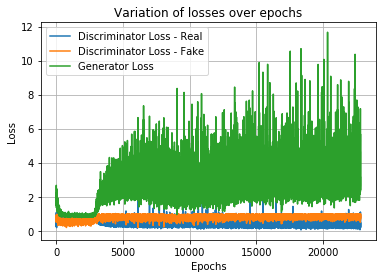

22801 [D loss: 0.510202, acc.: 75.00%] [G loss: 2.181917]
22802 [D loss: 0.306073, acc.: 93.75%] [G loss: 2.558993]
22803 [D loss: 0.221215, acc.: 90.62%] [G loss: 2.731053]
22804 [D loss: 0.220378, acc.: 90.62%] [G loss: 3.378272]
22805 [D loss: 0.183932, acc.: 93.75%] [G loss: 3.042963]
22806 [D loss: 0.367466, acc.: 81.25%] [G loss: 2.534616]
22807 [D loss: 0.329892, acc.: 81.25%] [G loss: 2.269871]
22808 [D loss: 0.271706, acc.: 87.50%] [G loss: 2.721690]
22809 [D loss: 0.239153, acc.: 87.50%] [G loss: 3.176864]
22810 [D loss: 0.168141, acc.: 96.88%] [G loss: 3.129391]
22811 [D loss: 0.623671, acc.: 78.12%] [G loss: 1.880488]
22812 [D loss: 0.402743, acc.: 87.50%] [G loss: 3.099845]
22813 [D loss: 0.613046, acc.: 68.75%] [G loss: 2.656726]
22814 [D loss: 0.226839, acc.: 90.62%] [G loss: 2.737490]
22815 [D loss: 0.387406, acc.: 84.38%] [G loss: 2.860668]
22816 [D loss: 0.554299, acc.: 62.50%] [G loss: 3.197567]
22817 [D loss: 0.214891, acc.: 87.50%] [G loss: 2.827422]
22818 [D loss:

22943 [D loss: 0.235548, acc.: 90.62%] [G loss: 2.365724]
22944 [D loss: 0.301061, acc.: 87.50%] [G loss: 2.176345]
22945 [D loss: 0.521762, acc.: 81.25%] [G loss: 2.643079]
22946 [D loss: 0.394816, acc.: 84.38%] [G loss: 2.809967]
22947 [D loss: 0.533835, acc.: 78.12%] [G loss: 2.486606]
22948 [D loss: 0.282296, acc.: 84.38%] [G loss: 2.479883]
22949 [D loss: 0.247380, acc.: 87.50%] [G loss: 2.832427]
22950 [D loss: 0.385944, acc.: 87.50%] [G loss: 2.082029]
22951 [D loss: 0.280788, acc.: 87.50%] [G loss: 2.417700]
22952 [D loss: 0.306206, acc.: 87.50%] [G loss: 2.864742]
22953 [D loss: 0.542585, acc.: 78.12%] [G loss: 2.591355]
22954 [D loss: 0.214692, acc.: 93.75%] [G loss: 2.775347]
22955 [D loss: 0.395855, acc.: 84.38%] [G loss: 2.876084]
22956 [D loss: 0.561632, acc.: 71.88%] [G loss: 2.676525]
22957 [D loss: 0.331271, acc.: 87.50%] [G loss: 3.011320]
22958 [D loss: 0.361293, acc.: 84.38%] [G loss: 3.774320]
22959 [D loss: 0.119462, acc.: 100.00%] [G loss: 2.755116]
22960 [D loss

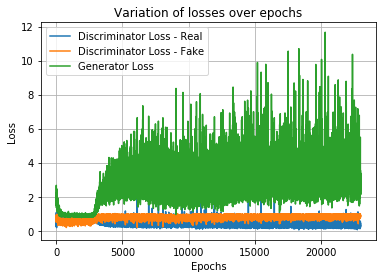

23001 [D loss: 0.338992, acc.: 93.75%] [G loss: 2.549566]
23002 [D loss: 0.258636, acc.: 87.50%] [G loss: 3.534430]
23003 [D loss: 0.423139, acc.: 84.38%] [G loss: 3.553091]
23004 [D loss: 0.361901, acc.: 81.25%] [G loss: 2.737447]
23005 [D loss: 0.260664, acc.: 87.50%] [G loss: 3.436352]
23006 [D loss: 0.336857, acc.: 81.25%] [G loss: 3.185703]
23007 [D loss: 0.266096, acc.: 84.38%] [G loss: 3.451917]
23008 [D loss: 0.397821, acc.: 81.25%] [G loss: 4.254341]
23009 [D loss: 0.196193, acc.: 90.62%] [G loss: 3.373075]
23010 [D loss: 0.184157, acc.: 96.88%] [G loss: 2.715700]
23011 [D loss: 0.221877, acc.: 93.75%] [G loss: 2.934459]
23012 [D loss: 0.294923, acc.: 84.38%] [G loss: 4.187262]
23013 [D loss: 0.314242, acc.: 81.25%] [G loss: 2.580024]
23014 [D loss: 0.371044, acc.: 81.25%] [G loss: 4.036040]
23015 [D loss: 0.548985, acc.: 78.12%] [G loss: 4.588277]
23016 [D loss: 0.311021, acc.: 87.50%] [G loss: 4.797041]
23017 [D loss: 0.431036, acc.: 84.38%] [G loss: 2.277880]
23018 [D loss:

23143 [D loss: 0.388246, acc.: 78.12%] [G loss: 4.123452]
23144 [D loss: 0.385996, acc.: 81.25%] [G loss: 2.745509]
23145 [D loss: 0.259227, acc.: 93.75%] [G loss: 2.874528]
23146 [D loss: 0.407628, acc.: 87.50%] [G loss: 2.501639]
23147 [D loss: 0.265551, acc.: 84.38%] [G loss: 2.253588]
23148 [D loss: 0.165265, acc.: 100.00%] [G loss: 3.093686]
23149 [D loss: 0.300666, acc.: 87.50%] [G loss: 2.762370]
23150 [D loss: 0.335204, acc.: 81.25%] [G loss: 2.487806]
23151 [D loss: 0.360075, acc.: 84.38%] [G loss: 2.195741]
23152 [D loss: 0.340462, acc.: 81.25%] [G loss: 2.142700]
23153 [D loss: 0.273018, acc.: 90.62%] [G loss: 2.455091]
23154 [D loss: 0.220139, acc.: 90.62%] [G loss: 2.854461]
23155 [D loss: 0.372889, acc.: 78.12%] [G loss: 3.438987]
23156 [D loss: 0.365278, acc.: 84.38%] [G loss: 3.831667]
23157 [D loss: 0.372314, acc.: 87.50%] [G loss: 2.744667]
23158 [D loss: 0.606097, acc.: 59.38%] [G loss: 2.814261]
23159 [D loss: 0.276990, acc.: 87.50%] [G loss: 2.722664]
23160 [D loss

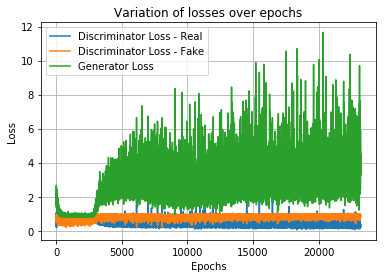

23201 [D loss: 0.434756, acc.: 87.50%] [G loss: 3.764460]
23202 [D loss: 0.328369, acc.: 81.25%] [G loss: 3.052772]
23203 [D loss: 0.203746, acc.: 96.88%] [G loss: 2.864070]
23204 [D loss: 0.409590, acc.: 78.12%] [G loss: 2.440572]
23205 [D loss: 0.379035, acc.: 87.50%] [G loss: 2.685720]
23206 [D loss: 0.315047, acc.: 87.50%] [G loss: 3.174141]
23207 [D loss: 0.435278, acc.: 81.25%] [G loss: 3.167723]
23208 [D loss: 0.299188, acc.: 87.50%] [G loss: 3.003106]
23209 [D loss: 0.419624, acc.: 81.25%] [G loss: 3.135093]
23210 [D loss: 0.453687, acc.: 75.00%] [G loss: 3.001321]
23211 [D loss: 0.414589, acc.: 87.50%] [G loss: 3.088720]
23212 [D loss: 0.453775, acc.: 75.00%] [G loss: 2.998546]
23213 [D loss: 0.215866, acc.: 93.75%] [G loss: 3.385944]
23214 [D loss: 0.494491, acc.: 75.00%] [G loss: 3.077790]
23215 [D loss: 0.353788, acc.: 81.25%] [G loss: 2.501452]
23216 [D loss: 0.231231, acc.: 93.75%] [G loss: 2.941507]
23217 [D loss: 0.275916, acc.: 87.50%] [G loss: 2.648500]
23218 [D loss:

23344 [D loss: 0.235644, acc.: 93.75%] [G loss: 3.912679]
23345 [D loss: 0.381502, acc.: 84.38%] [G loss: 4.737307]
23346 [D loss: 0.451476, acc.: 81.25%] [G loss: 2.553098]
23347 [D loss: 0.215756, acc.: 96.88%] [G loss: 2.578695]
23348 [D loss: 0.314593, acc.: 78.12%] [G loss: 4.603575]
23349 [D loss: 0.651525, acc.: 81.25%] [G loss: 2.971092]
23350 [D loss: 0.273325, acc.: 87.50%] [G loss: 2.952492]
23351 [D loss: 0.282672, acc.: 84.38%] [G loss: 1.949512]
23352 [D loss: 0.486671, acc.: 78.12%] [G loss: 2.452996]
23353 [D loss: 0.305688, acc.: 81.25%] [G loss: 2.474814]
23354 [D loss: 0.289592, acc.: 90.62%] [G loss: 2.622651]
23355 [D loss: 0.283261, acc.: 84.38%] [G loss: 2.923831]
23356 [D loss: 0.341982, acc.: 81.25%] [G loss: 4.052212]
23357 [D loss: 0.200887, acc.: 93.75%] [G loss: 3.413604]
23358 [D loss: 0.453728, acc.: 75.00%] [G loss: 4.508383]
23359 [D loss: 0.463339, acc.: 84.38%] [G loss: 3.185820]
23360 [D loss: 0.315856, acc.: 81.25%] [G loss: 3.019180]
23361 [D loss:

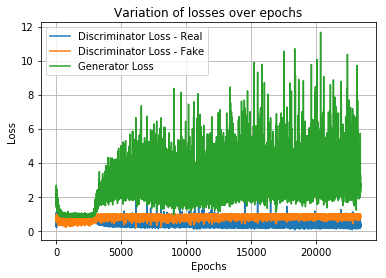

23401 [D loss: 0.403093, acc.: 81.25%] [G loss: 2.719070]
23402 [D loss: 0.311863, acc.: 81.25%] [G loss: 3.203812]
23403 [D loss: 0.386119, acc.: 78.12%] [G loss: 2.153869]
23404 [D loss: 0.370565, acc.: 84.38%] [G loss: 3.204580]
23405 [D loss: 0.343186, acc.: 87.50%] [G loss: 2.367666]
23406 [D loss: 0.326591, acc.: 90.62%] [G loss: 3.294118]
23407 [D loss: 0.309192, acc.: 84.38%] [G loss: 3.068242]
23408 [D loss: 0.360035, acc.: 78.12%] [G loss: 2.345694]
23409 [D loss: 0.321428, acc.: 81.25%] [G loss: 4.813380]
23410 [D loss: 0.270897, acc.: 84.38%] [G loss: 3.648867]
23411 [D loss: 0.284162, acc.: 87.50%] [G loss: 3.629962]
23412 [D loss: 0.351765, acc.: 81.25%] [G loss: 2.874630]
23413 [D loss: 0.237538, acc.: 87.50%] [G loss: 3.347513]
23414 [D loss: 0.440625, acc.: 84.38%] [G loss: 3.874185]
23415 [D loss: 0.304389, acc.: 90.62%] [G loss: 2.696352]
23416 [D loss: 0.273165, acc.: 84.38%] [G loss: 3.062202]
23417 [D loss: 0.281938, acc.: 87.50%] [G loss: 2.266697]
23418 [D loss:

23544 [D loss: 0.795220, acc.: 59.38%] [G loss: 1.966558]
23545 [D loss: 0.292399, acc.: 87.50%] [G loss: 2.846119]
23546 [D loss: 0.441290, acc.: 81.25%] [G loss: 2.891296]
23547 [D loss: 0.301307, acc.: 90.62%] [G loss: 2.697093]
23548 [D loss: 0.248144, acc.: 96.88%] [G loss: 2.987971]
23549 [D loss: 0.167825, acc.: 93.75%] [G loss: 3.656323]
23550 [D loss: 0.309961, acc.: 84.38%] [G loss: 2.969071]
23551 [D loss: 0.346719, acc.: 90.62%] [G loss: 2.194724]
23552 [D loss: 0.315300, acc.: 84.38%] [G loss: 2.528821]
23553 [D loss: 0.279491, acc.: 87.50%] [G loss: 3.205729]
23554 [D loss: 0.362821, acc.: 81.25%] [G loss: 2.814048]
23555 [D loss: 0.243050, acc.: 87.50%] [G loss: 2.879622]
23556 [D loss: 0.372024, acc.: 81.25%] [G loss: 2.131315]
23557 [D loss: 0.259063, acc.: 87.50%] [G loss: 2.844533]
23558 [D loss: 0.376184, acc.: 81.25%] [G loss: 3.143587]
23559 [D loss: 0.412075, acc.: 78.12%] [G loss: 3.871765]
23560 [D loss: 0.343696, acc.: 84.38%] [G loss: 2.455827]
23561 [D loss:

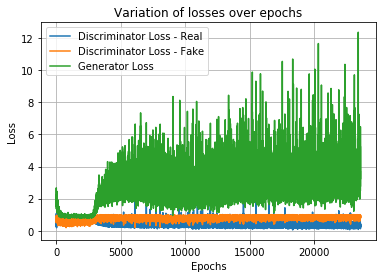

23601 [D loss: 0.296218, acc.: 87.50%] [G loss: 3.383212]
23602 [D loss: 0.264523, acc.: 90.62%] [G loss: 2.254031]
23603 [D loss: 0.274755, acc.: 90.62%] [G loss: 2.903236]
23604 [D loss: 0.155528, acc.: 96.88%] [G loss: 2.645066]
23605 [D loss: 0.286476, acc.: 93.75%] [G loss: 3.178617]
23606 [D loss: 0.229196, acc.: 93.75%] [G loss: 2.795090]
23607 [D loss: 0.158892, acc.: 96.88%] [G loss: 2.787168]
23608 [D loss: 0.322619, acc.: 84.38%] [G loss: 2.435482]
23609 [D loss: 0.324068, acc.: 78.12%] [G loss: 4.395067]
23610 [D loss: 0.535954, acc.: 71.88%] [G loss: 2.617855]
23611 [D loss: 0.190516, acc.: 93.75%] [G loss: 3.561985]
23612 [D loss: 0.390510, acc.: 81.25%] [G loss: 2.066019]
23613 [D loss: 0.278794, acc.: 87.50%] [G loss: 3.082838]
23614 [D loss: 0.226637, acc.: 90.62%] [G loss: 4.592707]
23615 [D loss: 0.395226, acc.: 75.00%] [G loss: 5.002020]
23616 [D loss: 0.445899, acc.: 78.12%] [G loss: 2.186542]
23617 [D loss: 0.231241, acc.: 90.62%] [G loss: 5.293213]
23618 [D loss:

23744 [D loss: 0.237637, acc.: 90.62%] [G loss: 5.236626]
23745 [D loss: 0.137249, acc.: 96.88%] [G loss: 4.491829]
23746 [D loss: 0.172332, acc.: 96.88%] [G loss: 3.101731]
23747 [D loss: 0.384123, acc.: 75.00%] [G loss: 2.528183]
23748 [D loss: 0.387848, acc.: 84.38%] [G loss: 2.420558]
23749 [D loss: 0.448439, acc.: 84.38%] [G loss: 3.237747]
23750 [D loss: 0.308478, acc.: 90.62%] [G loss: 2.780039]
23751 [D loss: 0.418298, acc.: 75.00%] [G loss: 2.382560]
23752 [D loss: 0.193660, acc.: 93.75%] [G loss: 3.478572]
23753 [D loss: 0.365871, acc.: 84.38%] [G loss: 2.496797]
23754 [D loss: 0.404650, acc.: 84.38%] [G loss: 3.020871]
23755 [D loss: 0.200559, acc.: 90.62%] [G loss: 3.652509]
23756 [D loss: 0.575176, acc.: 68.75%] [G loss: 3.462754]
23757 [D loss: 0.364676, acc.: 78.12%] [G loss: 3.501929]
23758 [D loss: 0.290835, acc.: 84.38%] [G loss: 2.905503]
23759 [D loss: 0.297010, acc.: 84.38%] [G loss: 2.417485]
23760 [D loss: 0.215166, acc.: 90.62%] [G loss: 3.740796]
23761 [D loss:

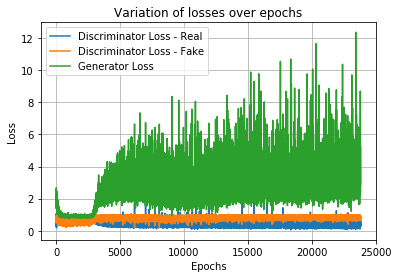

23801 [D loss: 0.325652, acc.: 90.62%] [G loss: 3.084300]
23802 [D loss: 0.261652, acc.: 84.38%] [G loss: 2.741227]
23803 [D loss: 0.354537, acc.: 78.12%] [G loss: 3.010926]
23804 [D loss: 0.317162, acc.: 90.62%] [G loss: 2.901041]
23805 [D loss: 0.323024, acc.: 87.50%] [G loss: 2.636807]
23806 [D loss: 0.336296, acc.: 84.38%] [G loss: 3.255193]
23807 [D loss: 0.401200, acc.: 81.25%] [G loss: 2.674158]
23808 [D loss: 0.444755, acc.: 75.00%] [G loss: 3.279407]
23809 [D loss: 0.188108, acc.: 96.88%] [G loss: 3.325368]
23810 [D loss: 0.272839, acc.: 93.75%] [G loss: 3.271900]
23811 [D loss: 0.275336, acc.: 90.62%] [G loss: 3.260123]
23812 [D loss: 0.121497, acc.: 100.00%] [G loss: 3.012443]
23813 [D loss: 0.357162, acc.: 84.38%] [G loss: 2.939476]
23814 [D loss: 0.361524, acc.: 78.12%] [G loss: 2.618882]
23815 [D loss: 0.301584, acc.: 87.50%] [G loss: 2.472758]
23816 [D loss: 0.306841, acc.: 87.50%] [G loss: 1.986488]
23817 [D loss: 0.189496, acc.: 93.75%] [G loss: 2.501547]
23818 [D loss

23943 [D loss: 0.448205, acc.: 81.25%] [G loss: 2.829273]
23944 [D loss: 0.339821, acc.: 78.12%] [G loss: 3.719344]
23945 [D loss: 0.480739, acc.: 81.25%] [G loss: 3.987663]
23946 [D loss: 0.176761, acc.: 90.62%] [G loss: 4.502376]
23947 [D loss: 0.710614, acc.: 65.62%] [G loss: 8.593923]
23948 [D loss: 0.991538, acc.: 46.88%] [G loss: 2.272695]
23949 [D loss: 0.555007, acc.: 75.00%] [G loss: 3.477678]
23950 [D loss: 0.168102, acc.: 96.88%] [G loss: 6.229045]
23951 [D loss: 0.378677, acc.: 84.38%] [G loss: 3.843362]
23952 [D loss: 0.390382, acc.: 87.50%] [G loss: 3.681591]
23953 [D loss: 0.513078, acc.: 75.00%] [G loss: 2.190247]
23954 [D loss: 0.657197, acc.: 71.88%] [G loss: 4.163571]
23955 [D loss: 0.229635, acc.: 87.50%] [G loss: 3.957455]
23956 [D loss: 0.353388, acc.: 84.38%] [G loss: 2.708673]
23957 [D loss: 0.322039, acc.: 84.38%] [G loss: 2.929354]
23958 [D loss: 0.297687, acc.: 87.50%] [G loss: 4.544341]
23959 [D loss: 0.247370, acc.: 90.62%] [G loss: 3.698778]
23960 [D loss:

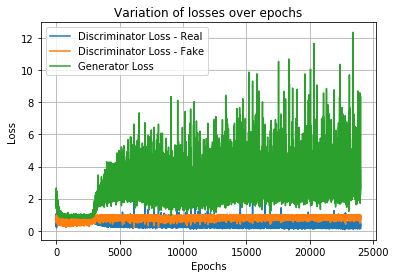

24001 [D loss: 0.259030, acc.: 84.38%] [G loss: 2.519131]
24002 [D loss: 0.213455, acc.: 90.62%] [G loss: 2.341834]
24003 [D loss: 0.446042, acc.: 71.88%] [G loss: 2.850698]
24004 [D loss: 0.421991, acc.: 81.25%] [G loss: 2.821032]
24005 [D loss: 0.337725, acc.: 84.38%] [G loss: 3.527953]
24006 [D loss: 0.475348, acc.: 87.50%] [G loss: 4.217532]
24007 [D loss: 0.246840, acc.: 90.62%] [G loss: 3.537234]
24008 [D loss: 0.406268, acc.: 84.38%] [G loss: 2.974797]
24009 [D loss: 0.212198, acc.: 90.62%] [G loss: 3.132534]
24010 [D loss: 0.203795, acc.: 93.75%] [G loss: 3.318647]
24011 [D loss: 0.346899, acc.: 84.38%] [G loss: 2.201759]
24012 [D loss: 0.487816, acc.: 75.00%] [G loss: 3.339898]
24013 [D loss: 0.311872, acc.: 84.38%] [G loss: 3.217260]
24014 [D loss: 0.330146, acc.: 87.50%] [G loss: 2.628751]
24015 [D loss: 0.367034, acc.: 87.50%] [G loss: 4.424638]
24016 [D loss: 0.343627, acc.: 81.25%] [G loss: 2.508457]
24017 [D loss: 0.335283, acc.: 78.12%] [G loss: 2.408864]
24018 [D loss:

24144 [D loss: 0.242139, acc.: 93.75%] [G loss: 4.354115]
24145 [D loss: 0.364142, acc.: 84.38%] [G loss: 2.358923]
24146 [D loss: 0.342836, acc.: 81.25%] [G loss: 2.639162]
24147 [D loss: 0.374046, acc.: 84.38%] [G loss: 2.680354]
24148 [D loss: 0.428258, acc.: 78.12%] [G loss: 2.712940]
24149 [D loss: 0.400540, acc.: 81.25%] [G loss: 2.905341]
24150 [D loss: 0.269678, acc.: 87.50%] [G loss: 2.636342]
24151 [D loss: 0.350236, acc.: 84.38%] [G loss: 2.819343]
24152 [D loss: 0.448694, acc.: 78.12%] [G loss: 2.784992]
24153 [D loss: 0.140768, acc.: 96.88%] [G loss: 2.435181]
24154 [D loss: 0.422464, acc.: 78.12%] [G loss: 3.349087]
24155 [D loss: 0.275379, acc.: 90.62%] [G loss: 2.456475]
24156 [D loss: 0.290625, acc.: 84.38%] [G loss: 3.603621]
24157 [D loss: 0.212289, acc.: 96.88%] [G loss: 4.672289]
24158 [D loss: 0.246342, acc.: 87.50%] [G loss: 5.307941]
24159 [D loss: 0.291470, acc.: 81.25%] [G loss: 5.705982]
24160 [D loss: 0.157160, acc.: 96.88%] [G loss: 3.804760]
24161 [D loss:

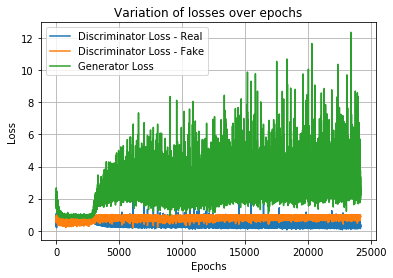

24201 [D loss: 0.368651, acc.: 75.00%] [G loss: 2.444648]
24202 [D loss: 0.245119, acc.: 93.75%] [G loss: 2.318775]
24203 [D loss: 0.434886, acc.: 81.25%] [G loss: 2.582459]
24204 [D loss: 0.249955, acc.: 87.50%] [G loss: 3.328206]
24205 [D loss: 0.432528, acc.: 78.12%] [G loss: 2.954400]
24206 [D loss: 0.389966, acc.: 81.25%] [G loss: 2.822348]
24207 [D loss: 0.394314, acc.: 81.25%] [G loss: 2.643229]
24208 [D loss: 0.335723, acc.: 87.50%] [G loss: 2.669054]
24209 [D loss: 0.182180, acc.: 93.75%] [G loss: 2.447207]
24210 [D loss: 0.379493, acc.: 78.12%] [G loss: 2.387013]
24211 [D loss: 0.602410, acc.: 81.25%] [G loss: 2.485756]
24212 [D loss: 0.391002, acc.: 87.50%] [G loss: 3.268315]
24213 [D loss: 0.356656, acc.: 81.25%] [G loss: 3.613999]
24214 [D loss: 0.253736, acc.: 90.62%] [G loss: 2.742297]
24215 [D loss: 0.394003, acc.: 78.12%] [G loss: 2.121990]
24216 [D loss: 0.166720, acc.: 96.88%] [G loss: 2.695298]
24217 [D loss: 0.251705, acc.: 90.62%] [G loss: 2.509384]
24218 [D loss:

24343 [D loss: 0.283121, acc.: 90.62%] [G loss: 3.558974]
24344 [D loss: 0.211696, acc.: 93.75%] [G loss: 5.150942]
24345 [D loss: 0.277388, acc.: 87.50%] [G loss: 2.791705]
24346 [D loss: 0.252602, acc.: 87.50%] [G loss: 4.120474]
24347 [D loss: 0.592347, acc.: 75.00%] [G loss: 2.555248]
24348 [D loss: 0.236090, acc.: 96.88%] [G loss: 3.136911]
24349 [D loss: 0.172130, acc.: 96.88%] [G loss: 2.876810]
24350 [D loss: 0.406218, acc.: 81.25%] [G loss: 2.269301]
24351 [D loss: 0.292801, acc.: 87.50%] [G loss: 2.394413]
24352 [D loss: 0.343383, acc.: 87.50%] [G loss: 2.777959]
24353 [D loss: 0.389182, acc.: 84.38%] [G loss: 2.246094]
24354 [D loss: 0.387042, acc.: 84.38%] [G loss: 4.432824]
24355 [D loss: 0.285705, acc.: 90.62%] [G loss: 2.891366]
24356 [D loss: 0.215780, acc.: 93.75%] [G loss: 3.289968]
24357 [D loss: 0.219166, acc.: 93.75%] [G loss: 3.639957]
24358 [D loss: 0.133060, acc.: 96.88%] [G loss: 3.113829]
24359 [D loss: 0.284187, acc.: 87.50%] [G loss: 3.677121]
24360 [D loss:

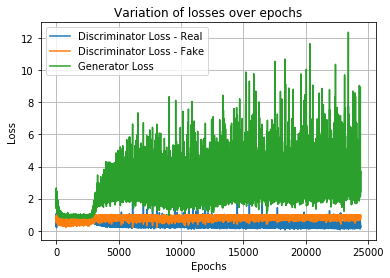

24401 [D loss: 0.346765, acc.: 84.38%] [G loss: 3.176969]
24402 [D loss: 0.470545, acc.: 84.38%] [G loss: 2.623437]
24403 [D loss: 0.155556, acc.: 93.75%] [G loss: 4.024705]
24404 [D loss: 0.386626, acc.: 78.12%] [G loss: 2.450710]
24405 [D loss: 0.389254, acc.: 75.00%] [G loss: 5.097334]
24406 [D loss: 0.501560, acc.: 78.12%] [G loss: 4.596359]
24407 [D loss: 0.203567, acc.: 96.88%] [G loss: 5.346474]
24408 [D loss: 0.219817, acc.: 96.88%] [G loss: 3.684167]
24409 [D loss: 0.451475, acc.: 81.25%] [G loss: 2.784361]
24410 [D loss: 0.223718, acc.: 87.50%] [G loss: 6.465853]
24411 [D loss: 0.322823, acc.: 84.38%] [G loss: 3.697266]
24412 [D loss: 0.271899, acc.: 84.38%] [G loss: 3.534454]
24413 [D loss: 0.480439, acc.: 84.38%] [G loss: 2.874910]
24414 [D loss: 0.113153, acc.: 93.75%] [G loss: 3.469132]
24415 [D loss: 0.456270, acc.: 71.88%] [G loss: 3.281018]
24416 [D loss: 0.349872, acc.: 78.12%] [G loss: 2.206272]
24417 [D loss: 0.291022, acc.: 84.38%] [G loss: 3.220260]
24418 [D loss:

24544 [D loss: 0.452131, acc.: 71.88%] [G loss: 2.827382]
24545 [D loss: 0.170027, acc.: 93.75%] [G loss: 3.098169]
24546 [D loss: 0.411375, acc.: 81.25%] [G loss: 2.315563]
24547 [D loss: 0.223405, acc.: 90.62%] [G loss: 2.644658]
24548 [D loss: 0.590009, acc.: 59.38%] [G loss: 2.418586]
24549 [D loss: 0.400721, acc.: 78.12%] [G loss: 2.534659]
24550 [D loss: 0.292682, acc.: 84.38%] [G loss: 2.708557]
24551 [D loss: 0.259001, acc.: 87.50%] [G loss: 2.644659]
24552 [D loss: 0.525035, acc.: 65.62%] [G loss: 2.214604]
24553 [D loss: 0.322718, acc.: 84.38%] [G loss: 2.524461]
24554 [D loss: 0.391279, acc.: 78.12%] [G loss: 2.003475]
24555 [D loss: 0.246891, acc.: 87.50%] [G loss: 2.540284]
24556 [D loss: 0.302122, acc.: 90.62%] [G loss: 2.675994]
24557 [D loss: 0.327533, acc.: 81.25%] [G loss: 2.272865]
24558 [D loss: 0.383527, acc.: 81.25%] [G loss: 2.278608]
24559 [D loss: 0.287589, acc.: 87.50%] [G loss: 2.044954]
24560 [D loss: 0.413799, acc.: 81.25%] [G loss: 2.517765]
24561 [D loss:

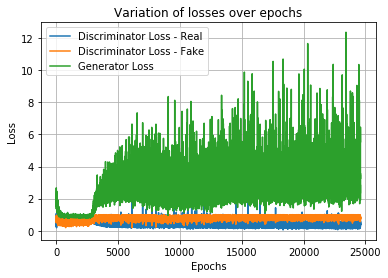

24601 [D loss: 0.375318, acc.: 81.25%] [G loss: 5.092087]
24602 [D loss: 0.168663, acc.: 96.88%] [G loss: 2.556794]
24603 [D loss: 0.200257, acc.: 90.62%] [G loss: 3.335443]
24604 [D loss: 0.254436, acc.: 90.62%] [G loss: 3.052806]
24605 [D loss: 0.285279, acc.: 90.62%] [G loss: 4.227352]
24606 [D loss: 0.255186, acc.: 96.88%] [G loss: 2.733799]
24607 [D loss: 0.390472, acc.: 84.38%] [G loss: 3.381099]
24608 [D loss: 0.172808, acc.: 96.88%] [G loss: 6.732137]
24609 [D loss: 0.305602, acc.: 87.50%] [G loss: 4.437655]
24610 [D loss: 0.241690, acc.: 84.38%] [G loss: 4.649446]
24611 [D loss: 0.440415, acc.: 87.50%] [G loss: 3.246985]
24612 [D loss: 0.231963, acc.: 93.75%] [G loss: 2.706462]
24613 [D loss: 0.327660, acc.: 84.38%] [G loss: 2.036195]
24614 [D loss: 0.220083, acc.: 90.62%] [G loss: 2.269017]
24615 [D loss: 0.380146, acc.: 87.50%] [G loss: 2.360345]
24616 [D loss: 0.460451, acc.: 71.88%] [G loss: 2.750735]
24617 [D loss: 0.534698, acc.: 78.12%] [G loss: 3.451882]
24618 [D loss:

24744 [D loss: 0.284714, acc.: 87.50%] [G loss: 2.633322]
24745 [D loss: 0.363531, acc.: 84.38%] [G loss: 3.241263]
24746 [D loss: 0.332096, acc.: 81.25%] [G loss: 3.101797]
24747 [D loss: 0.413486, acc.: 84.38%] [G loss: 3.847592]
24748 [D loss: 0.494472, acc.: 81.25%] [G loss: 3.328132]
24749 [D loss: 0.169713, acc.: 93.75%] [G loss: 4.541532]
24750 [D loss: 0.367662, acc.: 84.38%] [G loss: 2.883671]
24751 [D loss: 0.300483, acc.: 84.38%] [G loss: 3.210117]
24752 [D loss: 0.151634, acc.: 100.00%] [G loss: 4.204895]
24753 [D loss: 0.391033, acc.: 75.00%] [G loss: 4.249624]
24754 [D loss: 0.294095, acc.: 87.50%] [G loss: 5.071655]
24755 [D loss: 0.462932, acc.: 81.25%] [G loss: 3.144633]
24756 [D loss: 0.247557, acc.: 87.50%] [G loss: 2.814404]
24757 [D loss: 0.256990, acc.: 87.50%] [G loss: 2.852454]
24758 [D loss: 0.200573, acc.: 96.88%] [G loss: 3.272951]
24759 [D loss: 0.400119, acc.: 75.00%] [G loss: 3.299714]
24760 [D loss: 0.181190, acc.: 96.88%] [G loss: 2.841570]
24761 [D loss

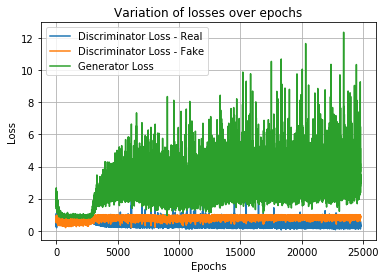

24801 [D loss: 0.427190, acc.: 84.38%] [G loss: 2.897484]
24802 [D loss: 0.237329, acc.: 90.62%] [G loss: 3.390374]
24803 [D loss: 0.305973, acc.: 84.38%] [G loss: 4.231020]
24804 [D loss: 0.432250, acc.: 78.12%] [G loss: 3.875900]
24805 [D loss: 0.468180, acc.: 87.50%] [G loss: 3.431566]
24806 [D loss: 0.285632, acc.: 93.75%] [G loss: 3.180496]
24807 [D loss: 0.309885, acc.: 87.50%] [G loss: 3.307189]
24808 [D loss: 0.296059, acc.: 87.50%] [G loss: 2.883438]
24809 [D loss: 0.297311, acc.: 87.50%] [G loss: 3.738589]
24810 [D loss: 0.545315, acc.: 68.75%] [G loss: 2.966602]
24811 [D loss: 0.193203, acc.: 93.75%] [G loss: 3.029317]
24812 [D loss: 0.286904, acc.: 84.38%] [G loss: 3.293195]
24813 [D loss: 0.251769, acc.: 87.50%] [G loss: 4.123665]
24814 [D loss: 0.450994, acc.: 81.25%] [G loss: 3.505891]
24815 [D loss: 0.231797, acc.: 84.38%] [G loss: 4.008780]
24816 [D loss: 0.476903, acc.: 71.88%] [G loss: 3.474019]
24817 [D loss: 0.298300, acc.: 90.62%] [G loss: 4.240782]
24818 [D loss:

24943 [D loss: 0.396290, acc.: 84.38%] [G loss: 3.435139]
24944 [D loss: 0.608537, acc.: 75.00%] [G loss: 3.267259]
24945 [D loss: 0.365798, acc.: 81.25%] [G loss: 3.570410]
24946 [D loss: 0.427326, acc.: 87.50%] [G loss: 3.052607]
24947 [D loss: 0.209539, acc.: 93.75%] [G loss: 3.837631]
24948 [D loss: 0.266107, acc.: 93.75%] [G loss: 4.093841]
24949 [D loss: 0.211635, acc.: 93.75%] [G loss: 4.299551]
24950 [D loss: 0.343191, acc.: 84.38%] [G loss: 2.826474]
24951 [D loss: 0.335690, acc.: 84.38%] [G loss: 3.589792]
24952 [D loss: 0.318570, acc.: 90.62%] [G loss: 3.464507]
24953 [D loss: 0.380317, acc.: 90.62%] [G loss: 2.971660]
24954 [D loss: 0.361813, acc.: 81.25%] [G loss: 3.887463]
24955 [D loss: 0.325710, acc.: 90.62%] [G loss: 3.834695]
24956 [D loss: 0.450772, acc.: 81.25%] [G loss: 2.258636]
24957 [D loss: 0.099496, acc.: 100.00%] [G loss: 3.366461]
24958 [D loss: 0.283494, acc.: 90.62%] [G loss: 2.966445]
24959 [D loss: 0.307783, acc.: 87.50%] [G loss: 2.327762]
24960 [D loss

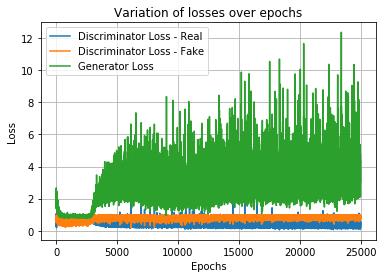

25001 [D loss: 0.311308, acc.: 84.38%] [G loss: 2.173939]
25002 [D loss: 0.571032, acc.: 75.00%] [G loss: 3.061332]
25003 [D loss: 0.255092, acc.: 93.75%] [G loss: 2.689978]
25004 [D loss: 0.382143, acc.: 84.38%] [G loss: 2.996416]
25005 [D loss: 0.260281, acc.: 84.38%] [G loss: 2.713153]
25006 [D loss: 0.220582, acc.: 87.50%] [G loss: 2.422550]
25007 [D loss: 0.380722, acc.: 84.38%] [G loss: 2.615861]
25008 [D loss: 0.325941, acc.: 87.50%] [G loss: 2.346729]
25009 [D loss: 0.191502, acc.: 96.88%] [G loss: 3.347653]
25010 [D loss: 0.221094, acc.: 90.62%] [G loss: 3.141736]
25011 [D loss: 0.190354, acc.: 93.75%] [G loss: 2.497276]
25012 [D loss: 0.249497, acc.: 84.38%] [G loss: 3.445435]
25013 [D loss: 0.229906, acc.: 93.75%] [G loss: 4.340133]
25014 [D loss: 0.371702, acc.: 84.38%] [G loss: 2.352968]
25015 [D loss: 0.368449, acc.: 81.25%] [G loss: 2.904891]
25016 [D loss: 0.462264, acc.: 81.25%] [G loss: 3.352108]
25017 [D loss: 0.195011, acc.: 90.62%] [G loss: 3.922663]
25018 [D loss:

25143 [D loss: 0.300381, acc.: 90.62%] [G loss: 3.702929]
25144 [D loss: 0.198505, acc.: 93.75%] [G loss: 2.574242]
25145 [D loss: 0.583068, acc.: 81.25%] [G loss: 2.778304]
25146 [D loss: 0.404683, acc.: 84.38%] [G loss: 2.706357]
25147 [D loss: 0.444115, acc.: 78.12%] [G loss: 2.515017]
25148 [D loss: 0.216247, acc.: 93.75%] [G loss: 2.505728]
25149 [D loss: 0.358290, acc.: 84.38%] [G loss: 2.776408]
25150 [D loss: 0.308899, acc.: 90.62%] [G loss: 2.473469]
25151 [D loss: 0.261790, acc.: 93.75%] [G loss: 3.372132]
25152 [D loss: 0.443652, acc.: 84.38%] [G loss: 3.478715]
25153 [D loss: 0.202313, acc.: 90.62%] [G loss: 3.281780]
25154 [D loss: 0.355917, acc.: 84.38%] [G loss: 2.541052]
25155 [D loss: 0.451304, acc.: 65.62%] [G loss: 3.075841]
25156 [D loss: 0.288758, acc.: 87.50%] [G loss: 3.190691]
25157 [D loss: 0.346792, acc.: 81.25%] [G loss: 2.531543]
25158 [D loss: 0.294674, acc.: 84.38%] [G loss: 3.798441]
25159 [D loss: 0.416556, acc.: 81.25%] [G loss: 3.265288]
25160 [D loss:

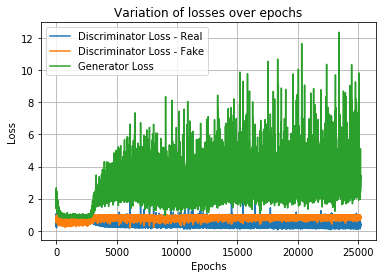

25201 [D loss: 0.202847, acc.: 93.75%] [G loss: 3.516470]
25202 [D loss: 0.332839, acc.: 84.38%] [G loss: 2.746970]
25203 [D loss: 0.253622, acc.: 90.62%] [G loss: 3.102914]
25204 [D loss: 0.202337, acc.: 90.62%] [G loss: 2.675891]
25205 [D loss: 0.186593, acc.: 96.88%] [G loss: 2.887331]
25206 [D loss: 0.200365, acc.: 96.88%] [G loss: 2.783372]
25207 [D loss: 0.370150, acc.: 87.50%] [G loss: 2.675950]
25208 [D loss: 0.375298, acc.: 87.50%] [G loss: 3.548160]
25209 [D loss: 0.319445, acc.: 87.50%] [G loss: 3.367173]
25210 [D loss: 0.180665, acc.: 93.75%] [G loss: 3.999812]
25211 [D loss: 0.581175, acc.: 75.00%] [G loss: 2.831121]
25212 [D loss: 0.330033, acc.: 78.12%] [G loss: 4.969591]
25213 [D loss: 0.309696, acc.: 87.50%] [G loss: 4.346601]
25214 [D loss: 0.370290, acc.: 75.00%] [G loss: 2.983931]
25215 [D loss: 0.355479, acc.: 81.25%] [G loss: 4.088690]
25216 [D loss: 0.227194, acc.: 90.62%] [G loss: 3.398546]
25217 [D loss: 0.233621, acc.: 93.75%] [G loss: 4.540926]
25218 [D loss:

25344 [D loss: 0.541268, acc.: 78.12%] [G loss: 3.453210]
25345 [D loss: 0.288230, acc.: 93.75%] [G loss: 2.933462]
25346 [D loss: 0.194960, acc.: 93.75%] [G loss: 2.649135]
25347 [D loss: 0.297424, acc.: 87.50%] [G loss: 2.652606]
25348 [D loss: 0.188779, acc.: 93.75%] [G loss: 2.855775]
25349 [D loss: 0.364135, acc.: 84.38%] [G loss: 2.858957]
25350 [D loss: 0.329102, acc.: 81.25%] [G loss: 3.337409]
25351 [D loss: 0.224937, acc.: 93.75%] [G loss: 2.331201]
25352 [D loss: 0.380762, acc.: 90.62%] [G loss: 2.608486]
25353 [D loss: 0.374476, acc.: 81.25%] [G loss: 2.544971]
25354 [D loss: 0.362449, acc.: 87.50%] [G loss: 2.157797]
25355 [D loss: 0.482161, acc.: 71.88%] [G loss: 3.938730]
25356 [D loss: 0.216476, acc.: 90.62%] [G loss: 2.393609]
25357 [D loss: 0.313416, acc.: 84.38%] [G loss: 3.523619]
25358 [D loss: 0.287120, acc.: 93.75%] [G loss: 3.800074]
25359 [D loss: 0.140331, acc.: 96.88%] [G loss: 6.139239]
25360 [D loss: 0.238220, acc.: 90.62%] [G loss: 2.749545]
25361 [D loss:

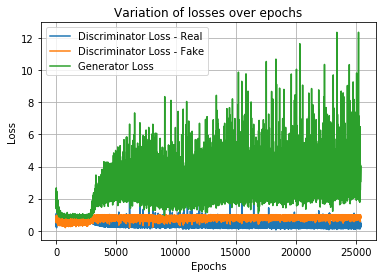

25401 [D loss: 0.310315, acc.: 84.38%] [G loss: 3.795397]
25402 [D loss: 0.174489, acc.: 93.75%] [G loss: 5.340101]
25403 [D loss: 0.305097, acc.: 81.25%] [G loss: 3.337066]
25404 [D loss: 0.220425, acc.: 96.88%] [G loss: 2.967151]
25405 [D loss: 0.274809, acc.: 84.38%] [G loss: 3.006488]
25406 [D loss: 0.090753, acc.: 100.00%] [G loss: 3.535821]
25407 [D loss: 0.241567, acc.: 93.75%] [G loss: 3.633408]
25408 [D loss: 0.364595, acc.: 84.38%] [G loss: 3.399039]
25409 [D loss: 0.282658, acc.: 81.25%] [G loss: 3.009596]
25410 [D loss: 0.445432, acc.: 84.38%] [G loss: 2.744040]
25411 [D loss: 0.330262, acc.: 87.50%] [G loss: 2.714740]
25412 [D loss: 0.293339, acc.: 84.38%] [G loss: 2.408366]
25413 [D loss: 0.491619, acc.: 78.12%] [G loss: 2.219278]
25414 [D loss: 0.277372, acc.: 93.75%] [G loss: 3.274058]
25415 [D loss: 0.460557, acc.: 90.62%] [G loss: 2.026096]
25416 [D loss: 0.260808, acc.: 87.50%] [G loss: 2.168692]
25417 [D loss: 0.294800, acc.: 87.50%] [G loss: 2.744262]
25418 [D loss

25543 [D loss: 0.647817, acc.: 75.00%] [G loss: 3.971353]
25544 [D loss: 0.216991, acc.: 96.88%] [G loss: 2.544394]
25545 [D loss: 0.426705, acc.: 87.50%] [G loss: 3.696405]
25546 [D loss: 0.338238, acc.: 87.50%] [G loss: 2.550256]
25547 [D loss: 0.264525, acc.: 90.62%] [G loss: 3.245510]
25548 [D loss: 0.362298, acc.: 81.25%] [G loss: 2.741396]
25549 [D loss: 0.366801, acc.: 84.38%] [G loss: 2.305188]
25550 [D loss: 0.524200, acc.: 71.88%] [G loss: 2.648370]
25551 [D loss: 0.299155, acc.: 84.38%] [G loss: 2.596723]
25552 [D loss: 0.212813, acc.: 93.75%] [G loss: 2.997715]
25553 [D loss: 0.320708, acc.: 81.25%] [G loss: 3.486285]
25554 [D loss: 0.444964, acc.: 75.00%] [G loss: 2.809848]
25555 [D loss: 0.255258, acc.: 93.75%] [G loss: 3.040525]
25556 [D loss: 0.439342, acc.: 81.25%] [G loss: 2.888448]
25557 [D loss: 0.337919, acc.: 93.75%] [G loss: 3.027969]
25558 [D loss: 0.260957, acc.: 93.75%] [G loss: 2.099975]
25559 [D loss: 0.489317, acc.: 78.12%] [G loss: 2.500422]
25560 [D loss:

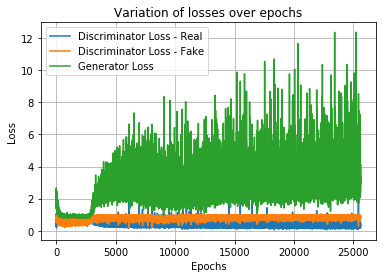

25601 [D loss: 0.430972, acc.: 84.38%] [G loss: 5.854428]
25602 [D loss: 0.294571, acc.: 93.75%] [G loss: 2.552820]
25603 [D loss: 0.168307, acc.: 93.75%] [G loss: 9.548910]
25604 [D loss: 0.080924, acc.: 100.00%] [G loss: 4.906855]
25605 [D loss: 0.404449, acc.: 90.62%] [G loss: 5.353065]
25606 [D loss: 0.241213, acc.: 90.62%] [G loss: 4.029797]
25607 [D loss: 0.414203, acc.: 81.25%] [G loss: 4.107938]
25608 [D loss: 0.286716, acc.: 93.75%] [G loss: 3.257606]
25609 [D loss: 0.311248, acc.: 81.25%] [G loss: 3.044791]
25610 [D loss: 0.219115, acc.: 90.62%] [G loss: 2.966500]
25611 [D loss: 0.323565, acc.: 78.12%] [G loss: 2.310892]
25612 [D loss: 0.231920, acc.: 87.50%] [G loss: 3.624828]
25613 [D loss: 0.244106, acc.: 93.75%] [G loss: 2.560017]
25614 [D loss: 0.236681, acc.: 93.75%] [G loss: 3.067364]
25615 [D loss: 0.131984, acc.: 96.88%] [G loss: 3.308733]
25616 [D loss: 0.347232, acc.: 84.38%] [G loss: 3.951891]
25617 [D loss: 0.336677, acc.: 84.38%] [G loss: 2.868163]
25618 [D loss

25743 [D loss: 0.349230, acc.: 81.25%] [G loss: 2.574161]
25744 [D loss: 0.411573, acc.: 84.38%] [G loss: 2.221948]
25745 [D loss: 0.282949, acc.: 90.62%] [G loss: 2.777032]
25746 [D loss: 0.371440, acc.: 90.62%] [G loss: 3.130460]
25747 [D loss: 0.310294, acc.: 78.12%] [G loss: 2.602163]
25748 [D loss: 0.310151, acc.: 84.38%] [G loss: 1.891320]
25749 [D loss: 0.273049, acc.: 84.38%] [G loss: 3.183597]
25750 [D loss: 0.213789, acc.: 90.62%] [G loss: 2.431613]
25751 [D loss: 0.495253, acc.: 84.38%] [G loss: 3.159374]
25752 [D loss: 0.347185, acc.: 87.50%] [G loss: 2.165773]
25753 [D loss: 0.228476, acc.: 90.62%] [G loss: 2.764926]
25754 [D loss: 0.420581, acc.: 78.12%] [G loss: 2.092329]
25755 [D loss: 0.570266, acc.: 75.00%] [G loss: 2.116624]
25756 [D loss: 0.203582, acc.: 93.75%] [G loss: 3.288617]
25757 [D loss: 0.369769, acc.: 81.25%] [G loss: 4.033941]
25758 [D loss: 0.371263, acc.: 81.25%] [G loss: 2.870137]
25759 [D loss: 0.322315, acc.: 81.25%] [G loss: 2.568765]
25760 [D loss:

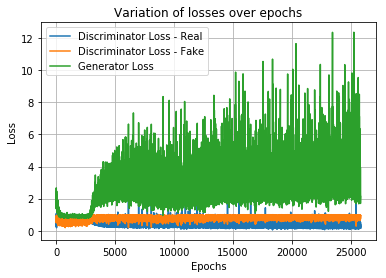

25801 [D loss: 0.402094, acc.: 78.12%] [G loss: 1.944723]
25802 [D loss: 0.252470, acc.: 87.50%] [G loss: 2.473809]
25803 [D loss: 0.485395, acc.: 78.12%] [G loss: 2.948415]
25804 [D loss: 0.318224, acc.: 87.50%] [G loss: 3.060819]
25805 [D loss: 0.252750, acc.: 87.50%] [G loss: 2.994102]
25806 [D loss: 0.408861, acc.: 75.00%] [G loss: 2.299652]
25807 [D loss: 0.506930, acc.: 78.12%] [G loss: 2.543965]
25808 [D loss: 0.380933, acc.: 78.12%] [G loss: 2.496603]
25809 [D loss: 0.335845, acc.: 87.50%] [G loss: 2.354794]
25810 [D loss: 0.254978, acc.: 93.75%] [G loss: 3.259242]
25811 [D loss: 0.346766, acc.: 87.50%] [G loss: 2.250435]
25812 [D loss: 0.224988, acc.: 90.62%] [G loss: 2.438993]
25813 [D loss: 0.529993, acc.: 68.75%] [G loss: 4.202686]
25814 [D loss: 0.276542, acc.: 87.50%] [G loss: 4.475650]
25815 [D loss: 0.366556, acc.: 81.25%] [G loss: 3.885031]
25816 [D loss: 0.229342, acc.: 96.88%] [G loss: 2.712721]
25817 [D loss: 0.356988, acc.: 81.25%] [G loss: 2.620810]
25818 [D loss:

25944 [D loss: 0.427642, acc.: 78.12%] [G loss: 3.052611]
25945 [D loss: 0.245996, acc.: 90.62%] [G loss: 4.617404]
25946 [D loss: 0.490063, acc.: 75.00%] [G loss: 3.886053]
25947 [D loss: 0.285856, acc.: 87.50%] [G loss: 2.311225]
25948 [D loss: 0.229692, acc.: 93.75%] [G loss: 3.770170]
25949 [D loss: 0.209145, acc.: 90.62%] [G loss: 2.869335]
25950 [D loss: 0.196121, acc.: 96.88%] [G loss: 3.187220]
25951 [D loss: 0.467896, acc.: 87.50%] [G loss: 4.160985]
25952 [D loss: 0.147507, acc.: 100.00%] [G loss: 2.900152]
25953 [D loss: 0.227350, acc.: 90.62%] [G loss: 2.841033]
25954 [D loss: 0.527189, acc.: 68.75%] [G loss: 2.971190]
25955 [D loss: 0.564458, acc.: 78.12%] [G loss: 3.352484]
25956 [D loss: 0.456076, acc.: 78.12%] [G loss: 3.035039]
25957 [D loss: 0.319078, acc.: 84.38%] [G loss: 2.459999]
25958 [D loss: 0.432452, acc.: 78.12%] [G loss: 4.182927]
25959 [D loss: 0.356687, acc.: 81.25%] [G loss: 2.165663]
25960 [D loss: 0.378339, acc.: 87.50%] [G loss: 2.517158]
25961 [D loss

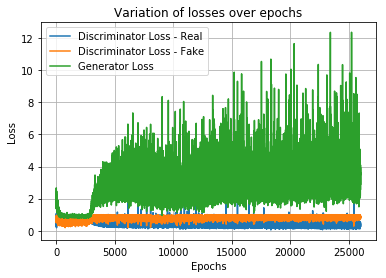

26001 [D loss: 0.401079, acc.: 87.50%] [G loss: 2.697963]
26002 [D loss: 0.297346, acc.: 90.62%] [G loss: 2.995377]
26003 [D loss: 0.481069, acc.: 71.88%] [G loss: 5.811882]
26004 [D loss: 0.225659, acc.: 93.75%] [G loss: 2.048615]
26005 [D loss: 0.319438, acc.: 81.25%] [G loss: 5.245514]
26006 [D loss: 0.227164, acc.: 93.75%] [G loss: 6.161690]
26007 [D loss: 0.387230, acc.: 90.62%] [G loss: 3.094722]
26008 [D loss: 0.470196, acc.: 71.88%] [G loss: 6.713534]
26009 [D loss: 0.345795, acc.: 81.25%] [G loss: 6.290340]
26010 [D loss: 0.463092, acc.: 75.00%] [G loss: 3.206498]
26011 [D loss: 0.574784, acc.: 81.25%] [G loss: 3.930747]
26012 [D loss: 0.269965, acc.: 84.38%] [G loss: 7.114403]
26013 [D loss: 0.353734, acc.: 90.62%] [G loss: 4.665241]
26014 [D loss: 0.458899, acc.: 68.75%] [G loss: 3.655226]
26015 [D loss: 0.337068, acc.: 81.25%] [G loss: 8.224169]
26016 [D loss: 0.307216, acc.: 81.25%] [G loss: 4.167753]
26017 [D loss: 0.121018, acc.: 96.88%] [G loss: 4.827111]
26018 [D loss:

26143 [D loss: 0.236730, acc.: 90.62%] [G loss: 2.443162]
26144 [D loss: 0.452730, acc.: 81.25%] [G loss: 3.516239]
26145 [D loss: 0.245156, acc.: 84.38%] [G loss: 3.759925]
26146 [D loss: 0.370740, acc.: 84.38%] [G loss: 3.792683]
26147 [D loss: 0.409015, acc.: 81.25%] [G loss: 2.527435]
26148 [D loss: 0.192655, acc.: 93.75%] [G loss: 3.532496]
26149 [D loss: 0.306328, acc.: 87.50%] [G loss: 3.142333]
26150 [D loss: 0.476171, acc.: 87.50%] [G loss: 2.913539]
26151 [D loss: 0.327657, acc.: 81.25%] [G loss: 3.508484]
26152 [D loss: 0.213362, acc.: 90.62%] [G loss: 3.524685]
26153 [D loss: 0.183012, acc.: 100.00%] [G loss: 2.984575]
26154 [D loss: 0.307865, acc.: 75.00%] [G loss: 3.908530]
26155 [D loss: 0.343919, acc.: 87.50%] [G loss: 3.300328]
26156 [D loss: 0.387037, acc.: 78.12%] [G loss: 4.386600]
26157 [D loss: 0.321454, acc.: 93.75%] [G loss: 3.522801]
26158 [D loss: 0.543090, acc.: 84.38%] [G loss: 2.903646]
26159 [D loss: 0.141618, acc.: 96.88%] [G loss: 3.036076]
26160 [D loss

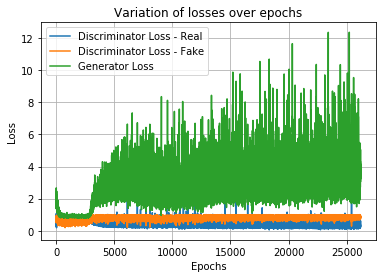

26201 [D loss: 0.403236, acc.: 75.00%] [G loss: 2.353284]
26202 [D loss: 0.332867, acc.: 81.25%] [G loss: 3.096680]
26203 [D loss: 0.222868, acc.: 84.38%] [G loss: 3.636036]
26204 [D loss: 0.249478, acc.: 90.62%] [G loss: 2.996619]
26205 [D loss: 0.187326, acc.: 93.75%] [G loss: 2.934584]
26206 [D loss: 0.361171, acc.: 81.25%] [G loss: 4.148351]
26207 [D loss: 0.282221, acc.: 87.50%] [G loss: 3.071544]
26208 [D loss: 0.187790, acc.: 93.75%] [G loss: 2.643003]
26209 [D loss: 0.394601, acc.: 84.38%] [G loss: 2.545681]
26210 [D loss: 0.329309, acc.: 84.38%] [G loss: 3.521674]
26211 [D loss: 0.371877, acc.: 78.12%] [G loss: 1.834458]
26212 [D loss: 0.247242, acc.: 90.62%] [G loss: 3.155594]
26213 [D loss: 0.347570, acc.: 90.62%] [G loss: 4.918054]
26214 [D loss: 0.268803, acc.: 90.62%] [G loss: 3.406532]
26215 [D loss: 0.619430, acc.: 78.12%] [G loss: 3.505220]
26216 [D loss: 0.277185, acc.: 87.50%] [G loss: 3.846510]
26217 [D loss: 0.141471, acc.: 96.88%] [G loss: 3.881276]
26218 [D loss:

26344 [D loss: 0.173544, acc.: 90.62%] [G loss: 3.230384]
26345 [D loss: 0.434999, acc.: 78.12%] [G loss: 2.961008]
26346 [D loss: 0.258011, acc.: 96.88%] [G loss: 2.614732]
26347 [D loss: 0.109744, acc.: 96.88%] [G loss: 2.672806]
26348 [D loss: 0.155702, acc.: 96.88%] [G loss: 3.002464]
26349 [D loss: 0.272223, acc.: 87.50%] [G loss: 2.061914]
26350 [D loss: 0.480383, acc.: 75.00%] [G loss: 2.088560]
26351 [D loss: 0.503850, acc.: 65.62%] [G loss: 2.327038]
26352 [D loss: 0.268163, acc.: 87.50%] [G loss: 2.425558]
26353 [D loss: 0.283675, acc.: 90.62%] [G loss: 3.444841]
26354 [D loss: 0.346420, acc.: 84.38%] [G loss: 2.856913]
26355 [D loss: 0.411207, acc.: 75.00%] [G loss: 2.490017]
26356 [D loss: 0.451868, acc.: 78.12%] [G loss: 2.601491]
26357 [D loss: 0.413727, acc.: 81.25%] [G loss: 2.593390]
26358 [D loss: 0.297168, acc.: 93.75%] [G loss: 3.141586]
26359 [D loss: 0.211982, acc.: 90.62%] [G loss: 3.152578]
26360 [D loss: 0.297072, acc.: 87.50%] [G loss: 3.496425]
26361 [D loss:

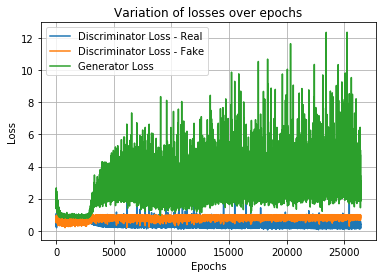

26401 [D loss: 0.348110, acc.: 78.12%] [G loss: 2.550137]
26402 [D loss: 0.229649, acc.: 87.50%] [G loss: 4.035776]
26403 [D loss: 0.368605, acc.: 84.38%] [G loss: 2.297802]
26404 [D loss: 0.434913, acc.: 81.25%] [G loss: 2.526984]
26405 [D loss: 0.186257, acc.: 93.75%] [G loss: 4.197114]
26406 [D loss: 0.342272, acc.: 90.62%] [G loss: 3.143147]
26407 [D loss: 0.362939, acc.: 84.38%] [G loss: 3.848947]
26408 [D loss: 0.306340, acc.: 81.25%] [G loss: 4.907727]
26409 [D loss: 0.296879, acc.: 84.38%] [G loss: 2.385087]
26410 [D loss: 0.380268, acc.: 81.25%] [G loss: 3.258921]
26411 [D loss: 0.294040, acc.: 81.25%] [G loss: 3.944807]
26412 [D loss: 0.389556, acc.: 87.50%] [G loss: 3.056454]
26413 [D loss: 0.234266, acc.: 90.62%] [G loss: 3.613788]
26414 [D loss: 0.250680, acc.: 87.50%] [G loss: 2.277030]
26415 [D loss: 0.253991, acc.: 93.75%] [G loss: 2.828016]
26416 [D loss: 0.312798, acc.: 81.25%] [G loss: 2.935809]
26417 [D loss: 0.385555, acc.: 81.25%] [G loss: 3.940608]
26418 [D loss:

26544 [D loss: 0.795359, acc.: 65.62%] [G loss: 3.121389]
26545 [D loss: 0.288371, acc.: 87.50%] [G loss: 3.499460]
26546 [D loss: 0.417320, acc.: 84.38%] [G loss: 3.924991]
26547 [D loss: 0.153721, acc.: 100.00%] [G loss: 3.303818]
26548 [D loss: 0.321456, acc.: 90.62%] [G loss: 2.902567]
26549 [D loss: 0.288618, acc.: 87.50%] [G loss: 2.929061]
26550 [D loss: 0.234767, acc.: 100.00%] [G loss: 2.445577]
26551 [D loss: 0.319041, acc.: 84.38%] [G loss: 2.903046]
26552 [D loss: 0.155381, acc.: 96.88%] [G loss: 3.773045]
26553 [D loss: 0.436844, acc.: 87.50%] [G loss: 3.944026]
26554 [D loss: 0.362284, acc.: 81.25%] [G loss: 2.825076]
26555 [D loss: 0.314948, acc.: 87.50%] [G loss: 3.088360]
26556 [D loss: 0.264552, acc.: 90.62%] [G loss: 3.118173]
26557 [D loss: 0.463099, acc.: 87.50%] [G loss: 3.289984]
26558 [D loss: 0.443380, acc.: 71.88%] [G loss: 3.713099]
26559 [D loss: 0.496727, acc.: 68.75%] [G loss: 2.689867]
26560 [D loss: 0.251492, acc.: 87.50%] [G loss: 2.809161]
26561 [D los

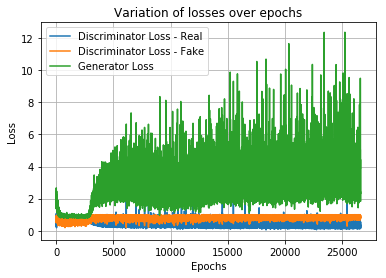

26601 [D loss: 0.332835, acc.: 81.25%] [G loss: 2.952969]
26602 [D loss: 0.275230, acc.: 87.50%] [G loss: 2.570549]
26603 [D loss: 0.227759, acc.: 90.62%] [G loss: 3.430672]
26604 [D loss: 0.449472, acc.: 84.38%] [G loss: 2.755612]
26605 [D loss: 0.542914, acc.: 71.88%] [G loss: 3.250729]
26606 [D loss: 0.295956, acc.: 81.25%] [G loss: 3.116994]
26607 [D loss: 0.271191, acc.: 87.50%] [G loss: 2.903119]
26608 [D loss: 0.202792, acc.: 90.62%] [G loss: 3.286542]
26609 [D loss: 0.302856, acc.: 81.25%] [G loss: 3.161225]
26610 [D loss: 0.322577, acc.: 87.50%] [G loss: 4.486426]
26611 [D loss: 0.180500, acc.: 90.62%] [G loss: 3.773656]
26612 [D loss: 0.364839, acc.: 84.38%] [G loss: 3.284135]
26613 [D loss: 0.246695, acc.: 93.75%] [G loss: 3.019762]
26614 [D loss: 0.265586, acc.: 90.62%] [G loss: 2.433050]
26615 [D loss: 0.514969, acc.: 71.88%] [G loss: 4.205776]
26616 [D loss: 0.359002, acc.: 84.38%] [G loss: 3.900698]
26617 [D loss: 0.853193, acc.: 59.38%] [G loss: 5.049039]
26618 [D loss:

26744 [D loss: 0.573689, acc.: 78.12%] [G loss: 4.680297]
26745 [D loss: 0.323605, acc.: 87.50%] [G loss: 3.507692]
26746 [D loss: 0.346569, acc.: 81.25%] [G loss: 3.952637]
26747 [D loss: 0.283522, acc.: 87.50%] [G loss: 3.138060]
26748 [D loss: 0.180131, acc.: 96.88%] [G loss: 4.741793]
26749 [D loss: 0.470155, acc.: 75.00%] [G loss: 3.584628]
26750 [D loss: 0.263797, acc.: 87.50%] [G loss: 3.472833]
26751 [D loss: 0.339931, acc.: 87.50%] [G loss: 2.891932]
26752 [D loss: 0.495296, acc.: 75.00%] [G loss: 3.152454]
26753 [D loss: 0.534116, acc.: 71.88%] [G loss: 3.350645]
26754 [D loss: 0.237056, acc.: 87.50%] [G loss: 2.453490]
26755 [D loss: 0.467478, acc.: 78.12%] [G loss: 2.712816]
26756 [D loss: 0.336028, acc.: 84.38%] [G loss: 3.291461]
26757 [D loss: 0.178070, acc.: 93.75%] [G loss: 2.919167]
26758 [D loss: 0.324003, acc.: 75.00%] [G loss: 1.904545]
26759 [D loss: 0.406245, acc.: 87.50%] [G loss: 2.658599]
26760 [D loss: 0.322986, acc.: 81.25%] [G loss: 4.094687]
26761 [D loss:

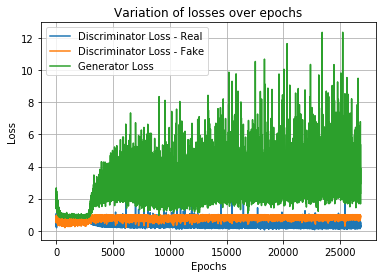

26801 [D loss: 0.348144, acc.: 84.38%] [G loss: 2.671813]
26802 [D loss: 0.537423, acc.: 65.62%] [G loss: 2.046134]
26803 [D loss: 0.279042, acc.: 84.38%] [G loss: 2.907377]
26804 [D loss: 0.349236, acc.: 84.38%] [G loss: 2.963286]
26805 [D loss: 0.215619, acc.: 90.62%] [G loss: 3.623239]
26806 [D loss: 0.391992, acc.: 84.38%] [G loss: 3.384062]
26807 [D loss: 0.569708, acc.: 75.00%] [G loss: 2.825539]
26808 [D loss: 0.487889, acc.: 81.25%] [G loss: 2.976636]
26809 [D loss: 0.276018, acc.: 90.62%] [G loss: 3.264565]
26810 [D loss: 0.237282, acc.: 93.75%] [G loss: 2.825021]
26811 [D loss: 0.488520, acc.: 71.88%] [G loss: 3.384922]
26812 [D loss: 0.263833, acc.: 90.62%] [G loss: 3.851732]
26813 [D loss: 0.202232, acc.: 96.88%] [G loss: 2.991925]
26814 [D loss: 0.323375, acc.: 87.50%] [G loss: 3.356582]
26815 [D loss: 0.217123, acc.: 93.75%] [G loss: 2.562642]
26816 [D loss: 0.334241, acc.: 90.62%] [G loss: 2.841419]
26817 [D loss: 0.187212, acc.: 93.75%] [G loss: 3.020693]
26818 [D loss:

26944 [D loss: 0.539281, acc.: 75.00%] [G loss: 3.621274]
26945 [D loss: 0.287130, acc.: 90.62%] [G loss: 3.375010]
26946 [D loss: 0.204675, acc.: 90.62%] [G loss: 3.111633]
26947 [D loss: 0.332817, acc.: 87.50%] [G loss: 2.184219]
26948 [D loss: 0.320727, acc.: 84.38%] [G loss: 3.413471]
26949 [D loss: 0.335798, acc.: 87.50%] [G loss: 2.881185]
26950 [D loss: 0.300460, acc.: 87.50%] [G loss: 3.946527]
26951 [D loss: 0.479779, acc.: 81.25%] [G loss: 2.069089]
26952 [D loss: 0.447872, acc.: 81.25%] [G loss: 3.528173]
26953 [D loss: 0.311678, acc.: 84.38%] [G loss: 3.510196]
26954 [D loss: 0.221132, acc.: 90.62%] [G loss: 2.972577]
26955 [D loss: 0.400363, acc.: 90.62%] [G loss: 3.642405]
26956 [D loss: 0.308064, acc.: 81.25%] [G loss: 2.305960]
26957 [D loss: 0.413465, acc.: 78.12%] [G loss: 3.423413]
26958 [D loss: 0.250149, acc.: 93.75%] [G loss: 3.668496]
26959 [D loss: 0.442577, acc.: 75.00%] [G loss: 3.903503]
26960 [D loss: 0.201630, acc.: 93.75%] [G loss: 3.230588]
26961 [D loss:

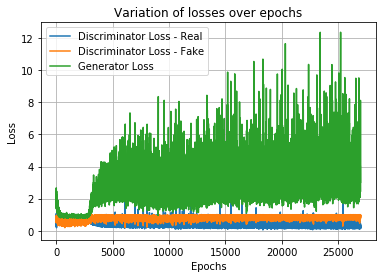

27001 [D loss: 0.166325, acc.: 96.88%] [G loss: 4.478604]
27002 [D loss: 0.478308, acc.: 81.25%] [G loss: 2.985596]
27003 [D loss: 0.410830, acc.: 87.50%] [G loss: 2.334053]
27004 [D loss: 0.202438, acc.: 90.62%] [G loss: 3.230924]
27005 [D loss: 0.381385, acc.: 84.38%] [G loss: 4.437200]
27006 [D loss: 0.452790, acc.: 75.00%] [G loss: 2.461080]
27007 [D loss: 0.240907, acc.: 90.62%] [G loss: 3.394475]
27008 [D loss: 0.241447, acc.: 87.50%] [G loss: 1.794981]
27009 [D loss: 0.312315, acc.: 84.38%] [G loss: 1.958486]
27010 [D loss: 0.352705, acc.: 87.50%] [G loss: 3.074919]
27011 [D loss: 0.302709, acc.: 84.38%] [G loss: 2.577300]
27012 [D loss: 0.493450, acc.: 68.75%] [G loss: 3.155180]
27013 [D loss: 0.425175, acc.: 78.12%] [G loss: 3.212537]
27014 [D loss: 0.201344, acc.: 96.88%] [G loss: 3.092830]
27015 [D loss: 0.383443, acc.: 78.12%] [G loss: 2.491199]
27016 [D loss: 0.628685, acc.: 75.00%] [G loss: 2.564354]
27017 [D loss: 0.422770, acc.: 84.38%] [G loss: 3.095940]
27018 [D loss:

27144 [D loss: 0.250586, acc.: 93.75%] [G loss: 2.858880]
27145 [D loss: 0.519128, acc.: 75.00%] [G loss: 3.127819]
27146 [D loss: 0.422859, acc.: 81.25%] [G loss: 3.902440]
27147 [D loss: 0.284574, acc.: 87.50%] [G loss: 3.444743]
27148 [D loss: 0.248384, acc.: 90.62%] [G loss: 3.252494]
27149 [D loss: 0.369588, acc.: 87.50%] [G loss: 2.088763]
27150 [D loss: 0.178609, acc.: 96.88%] [G loss: 2.717958]
27151 [D loss: 0.331490, acc.: 84.38%] [G loss: 2.930823]
27152 [D loss: 0.335167, acc.: 84.38%] [G loss: 2.952357]
27153 [D loss: 0.284428, acc.: 90.62%] [G loss: 2.992090]
27154 [D loss: 0.653541, acc.: 71.88%] [G loss: 5.146526]
27155 [D loss: 0.252870, acc.: 90.62%] [G loss: 3.285764]
27156 [D loss: 0.448946, acc.: 84.38%] [G loss: 2.646005]
27157 [D loss: 0.231781, acc.: 87.50%] [G loss: 3.499356]
27158 [D loss: 0.361141, acc.: 81.25%] [G loss: 4.271942]
27159 [D loss: 0.356441, acc.: 87.50%] [G loss: 3.430461]
27160 [D loss: 0.241638, acc.: 90.62%] [G loss: 2.683304]
27161 [D loss:

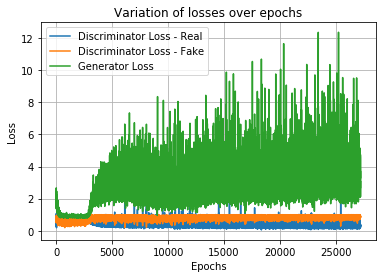

27201 [D loss: 0.324418, acc.: 90.62%] [G loss: 3.235575]
27202 [D loss: 0.368489, acc.: 84.38%] [G loss: 3.520036]
27203 [D loss: 0.216428, acc.: 93.75%] [G loss: 2.967762]
27204 [D loss: 0.214959, acc.: 93.75%] [G loss: 3.609514]
27205 [D loss: 0.527471, acc.: 71.88%] [G loss: 3.095445]
27206 [D loss: 0.190743, acc.: 96.88%] [G loss: 4.751530]
27207 [D loss: 0.529656, acc.: 78.12%] [G loss: 6.020657]
27208 [D loss: 0.420940, acc.: 71.88%] [G loss: 3.930292]
27209 [D loss: 0.302709, acc.: 84.38%] [G loss: 5.261596]
27210 [D loss: 0.208443, acc.: 90.62%] [G loss: 3.331206]
27211 [D loss: 0.174305, acc.: 93.75%] [G loss: 4.475654]
27212 [D loss: 0.199989, acc.: 90.62%] [G loss: 3.901617]
27213 [D loss: 0.193104, acc.: 96.88%] [G loss: 5.114245]
27214 [D loss: 0.383197, acc.: 71.88%] [G loss: 2.544608]
27215 [D loss: 0.388104, acc.: 78.12%] [G loss: 4.521958]
27216 [D loss: 0.275092, acc.: 87.50%] [G loss: 3.835338]
27217 [D loss: 0.468464, acc.: 78.12%] [G loss: 3.636669]
27218 [D loss:

27343 [D loss: 0.249000, acc.: 93.75%] [G loss: 3.812356]
27344 [D loss: 0.288470, acc.: 81.25%] [G loss: 2.392246]
27345 [D loss: 0.261566, acc.: 90.62%] [G loss: 4.758207]
27346 [D loss: 0.393952, acc.: 81.25%] [G loss: 3.568584]
27347 [D loss: 0.299758, acc.: 84.38%] [G loss: 3.099978]
27348 [D loss: 0.370072, acc.: 84.38%] [G loss: 2.678226]
27349 [D loss: 0.221059, acc.: 93.75%] [G loss: 3.012216]
27350 [D loss: 0.323422, acc.: 84.38%] [G loss: 3.710974]
27351 [D loss: 0.447213, acc.: 75.00%] [G loss: 2.371381]
27352 [D loss: 0.354243, acc.: 84.38%] [G loss: 3.239506]
27353 [D loss: 0.421790, acc.: 71.88%] [G loss: 2.743473]
27354 [D loss: 0.358528, acc.: 90.62%] [G loss: 2.797348]
27355 [D loss: 0.282934, acc.: 87.50%] [G loss: 4.321103]
27356 [D loss: 0.337098, acc.: 87.50%] [G loss: 2.996331]
27357 [D loss: 0.246417, acc.: 90.62%] [G loss: 3.098919]
27358 [D loss: 0.174210, acc.: 93.75%] [G loss: 3.005476]
27359 [D loss: 0.478244, acc.: 75.00%] [G loss: 3.115564]
27360 [D loss:

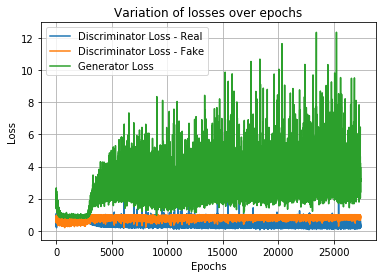

27401 [D loss: 0.204080, acc.: 90.62%] [G loss: 3.295612]
27402 [D loss: 0.396042, acc.: 78.12%] [G loss: 1.883975]
27403 [D loss: 0.328298, acc.: 87.50%] [G loss: 3.089525]
27404 [D loss: 0.293266, acc.: 84.38%] [G loss: 4.087945]
27405 [D loss: 0.288406, acc.: 93.75%] [G loss: 3.809411]
27406 [D loss: 0.194730, acc.: 90.62%] [G loss: 4.540854]
27407 [D loss: 0.322100, acc.: 84.38%] [G loss: 2.987348]
27408 [D loss: 0.330695, acc.: 78.12%] [G loss: 3.568866]
27409 [D loss: 0.280542, acc.: 84.38%] [G loss: 2.955808]
27410 [D loss: 0.297899, acc.: 87.50%] [G loss: 2.743606]
27411 [D loss: 0.341809, acc.: 75.00%] [G loss: 4.642015]
27412 [D loss: 0.199036, acc.: 93.75%] [G loss: 3.038242]
27413 [D loss: 0.353622, acc.: 81.25%] [G loss: 4.895087]
27414 [D loss: 0.310507, acc.: 81.25%] [G loss: 3.893513]
27415 [D loss: 0.197676, acc.: 93.75%] [G loss: 3.741911]
27416 [D loss: 0.376973, acc.: 71.88%] [G loss: 3.614292]
27417 [D loss: 0.231774, acc.: 93.75%] [G loss: 2.969609]
27418 [D loss:

27543 [D loss: 0.266778, acc.: 90.62%] [G loss: 3.568211]
27544 [D loss: 0.165097, acc.: 93.75%] [G loss: 2.974201]
27545 [D loss: 0.519160, acc.: 68.75%] [G loss: 3.150449]
27546 [D loss: 0.239938, acc.: 90.62%] [G loss: 3.141852]
27547 [D loss: 0.433401, acc.: 78.12%] [G loss: 3.295286]
27548 [D loss: 0.339002, acc.: 84.38%] [G loss: 2.256039]
27549 [D loss: 0.204354, acc.: 96.88%] [G loss: 3.497480]
27550 [D loss: 0.345740, acc.: 81.25%] [G loss: 3.143545]
27551 [D loss: 0.214322, acc.: 93.75%] [G loss: 4.106784]
27552 [D loss: 0.315386, acc.: 93.75%] [G loss: 4.538113]
27553 [D loss: 0.207359, acc.: 87.50%] [G loss: 6.524796]
27554 [D loss: 0.253460, acc.: 90.62%] [G loss: 3.404224]
27555 [D loss: 0.223744, acc.: 90.62%] [G loss: 3.229699]
27556 [D loss: 0.386468, acc.: 84.38%] [G loss: 5.074796]
27557 [D loss: 0.334036, acc.: 87.50%] [G loss: 4.105185]
27558 [D loss: 0.304433, acc.: 87.50%] [G loss: 5.110449]
27559 [D loss: 0.409735, acc.: 78.12%] [G loss: 3.699436]
27560 [D loss:

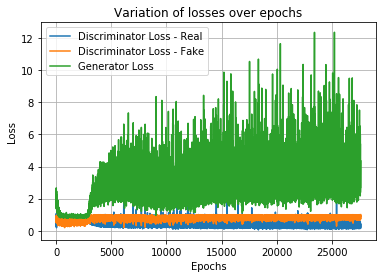

27601 [D loss: 0.272689, acc.: 93.75%] [G loss: 2.787307]
27602 [D loss: 0.306124, acc.: 90.62%] [G loss: 5.278562]
27603 [D loss: 0.408372, acc.: 81.25%] [G loss: 3.448766]
27604 [D loss: 0.256877, acc.: 93.75%] [G loss: 7.534822]
27605 [D loss: 0.345654, acc.: 84.38%] [G loss: 2.859378]
27606 [D loss: 0.172441, acc.: 93.75%] [G loss: 3.784852]
27607 [D loss: 0.233683, acc.: 84.38%] [G loss: 4.214545]
27608 [D loss: 0.377756, acc.: 81.25%] [G loss: 4.611708]
27609 [D loss: 0.236957, acc.: 87.50%] [G loss: 3.623452]
27610 [D loss: 0.419674, acc.: 81.25%] [G loss: 3.683219]
27611 [D loss: 0.401848, acc.: 84.38%] [G loss: 3.481585]
27612 [D loss: 0.473507, acc.: 78.12%] [G loss: 3.157038]
27613 [D loss: 0.288832, acc.: 84.38%] [G loss: 5.042283]
27614 [D loss: 0.160623, acc.: 93.75%] [G loss: 3.677111]
27615 [D loss: 0.343531, acc.: 87.50%] [G loss: 4.146805]
27616 [D loss: 0.354072, acc.: 84.38%] [G loss: 2.816318]
27617 [D loss: 0.432743, acc.: 78.12%] [G loss: 3.044215]
27618 [D loss:

27744 [D loss: 0.349746, acc.: 84.38%] [G loss: 3.171937]
27745 [D loss: 0.216040, acc.: 90.62%] [G loss: 2.763482]
27746 [D loss: 0.276105, acc.: 87.50%] [G loss: 2.362418]
27747 [D loss: 0.254234, acc.: 93.75%] [G loss: 2.681218]
27748 [D loss: 0.305618, acc.: 90.62%] [G loss: 2.795776]
27749 [D loss: 0.397041, acc.: 78.12%] [G loss: 2.802247]
27750 [D loss: 0.200489, acc.: 96.88%] [G loss: 2.264454]
27751 [D loss: 0.402455, acc.: 71.88%] [G loss: 3.479035]
27752 [D loss: 0.185327, acc.: 96.88%] [G loss: 3.433722]
27753 [D loss: 0.301337, acc.: 81.25%] [G loss: 3.610820]
27754 [D loss: 0.388515, acc.: 81.25%] [G loss: 3.319806]
27755 [D loss: 0.340832, acc.: 87.50%] [G loss: 4.080693]
27756 [D loss: 0.257766, acc.: 87.50%] [G loss: 4.150437]
27757 [D loss: 0.615335, acc.: 78.12%] [G loss: 5.078585]
27758 [D loss: 0.408728, acc.: 84.38%] [G loss: 3.606107]
27759 [D loss: 0.376431, acc.: 84.38%] [G loss: 5.796689]
27760 [D loss: 0.370297, acc.: 81.25%] [G loss: 2.947917]
27761 [D loss:

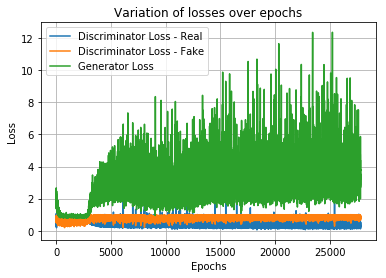

27801 [D loss: 0.252625, acc.: 90.62%] [G loss: 3.249907]
27802 [D loss: 0.339023, acc.: 84.38%] [G loss: 3.499467]
27803 [D loss: 0.402664, acc.: 78.12%] [G loss: 4.046669]
27804 [D loss: 0.237581, acc.: 93.75%] [G loss: 3.655118]
27805 [D loss: 0.300417, acc.: 87.50%] [G loss: 3.139275]
27806 [D loss: 0.325430, acc.: 84.38%] [G loss: 2.909574]
27807 [D loss: 0.244491, acc.: 90.62%] [G loss: 3.875319]
27808 [D loss: 0.525017, acc.: 78.12%] [G loss: 3.537002]
27809 [D loss: 0.325057, acc.: 84.38%] [G loss: 4.687521]
27810 [D loss: 0.219702, acc.: 93.75%] [G loss: 2.526324]
27811 [D loss: 0.194106, acc.: 96.88%] [G loss: 2.954130]
27812 [D loss: 0.264622, acc.: 90.62%] [G loss: 2.610785]
27813 [D loss: 0.105967, acc.: 100.00%] [G loss: 2.882093]
27814 [D loss: 0.439553, acc.: 84.38%] [G loss: 2.640944]
27815 [D loss: 0.247115, acc.: 93.75%] [G loss: 2.583098]
27816 [D loss: 0.353116, acc.: 87.50%] [G loss: 2.848293]
27817 [D loss: 0.302257, acc.: 87.50%] [G loss: 3.284910]
27818 [D loss

27943 [D loss: 0.191729, acc.: 90.62%] [G loss: 2.914517]
27944 [D loss: 0.268551, acc.: 87.50%] [G loss: 3.923385]
27945 [D loss: 0.334567, acc.: 81.25%] [G loss: 3.407105]
27946 [D loss: 0.392964, acc.: 87.50%] [G loss: 2.430211]
27947 [D loss: 0.137247, acc.: 96.88%] [G loss: 3.251687]
27948 [D loss: 0.464080, acc.: 75.00%] [G loss: 2.436838]
27949 [D loss: 0.304402, acc.: 87.50%] [G loss: 2.782374]
27950 [D loss: 0.241634, acc.: 90.62%] [G loss: 2.716740]
27951 [D loss: 0.318654, acc.: 81.25%] [G loss: 2.840067]
27952 [D loss: 0.360912, acc.: 81.25%] [G loss: 2.437122]
27953 [D loss: 0.274053, acc.: 87.50%] [G loss: 2.880802]
27954 [D loss: 0.421889, acc.: 84.38%] [G loss: 3.710393]
27955 [D loss: 0.333170, acc.: 84.38%] [G loss: 3.016903]
27956 [D loss: 0.624134, acc.: 78.12%] [G loss: 3.566396]
27957 [D loss: 0.342744, acc.: 84.38%] [G loss: 3.663975]
27958 [D loss: 0.545452, acc.: 75.00%] [G loss: 4.313257]
27959 [D loss: 0.410207, acc.: 84.38%] [G loss: 4.225025]
27960 [D loss:

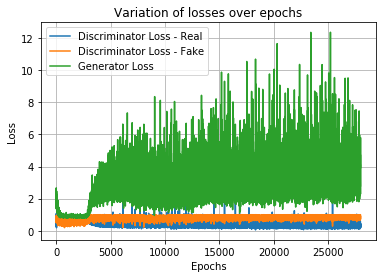

28001 [D loss: 0.278513, acc.: 84.38%] [G loss: 2.996118]
28002 [D loss: 0.250869, acc.: 96.88%] [G loss: 2.623448]
28003 [D loss: 0.158908, acc.: 96.88%] [G loss: 2.956369]
28004 [D loss: 0.286464, acc.: 87.50%] [G loss: 2.616231]
28005 [D loss: 0.300500, acc.: 87.50%] [G loss: 3.465364]
28006 [D loss: 0.218872, acc.: 93.75%] [G loss: 3.177246]
28007 [D loss: 0.204554, acc.: 96.88%] [G loss: 3.723680]
28008 [D loss: 0.373873, acc.: 87.50%] [G loss: 2.707641]
28009 [D loss: 0.210610, acc.: 93.75%] [G loss: 4.737272]
28010 [D loss: 0.228338, acc.: 87.50%] [G loss: 2.786129]
28011 [D loss: 0.265241, acc.: 87.50%] [G loss: 4.129278]
28012 [D loss: 0.154296, acc.: 96.88%] [G loss: 3.251772]
28013 [D loss: 0.469192, acc.: 75.00%] [G loss: 4.863644]
28014 [D loss: 0.198560, acc.: 93.75%] [G loss: 3.750382]
28015 [D loss: 0.660982, acc.: 71.88%] [G loss: 5.008487]
28016 [D loss: 0.505324, acc.: 81.25%] [G loss: 6.089665]
28017 [D loss: 0.533142, acc.: 87.50%] [G loss: 4.905576]
28018 [D loss:

28143 [D loss: 0.146986, acc.: 100.00%] [G loss: 2.927143]
28144 [D loss: 0.472398, acc.: 81.25%] [G loss: 2.838864]
28145 [D loss: 0.330819, acc.: 81.25%] [G loss: 2.677382]
28146 [D loss: 0.172439, acc.: 96.88%] [G loss: 2.650843]
28147 [D loss: 0.397429, acc.: 87.50%] [G loss: 2.760015]
28148 [D loss: 0.369514, acc.: 87.50%] [G loss: 3.240770]
28149 [D loss: 0.483152, acc.: 75.00%] [G loss: 4.098803]
28150 [D loss: 0.298830, acc.: 84.38%] [G loss: 2.273586]
28151 [D loss: 0.267543, acc.: 90.62%] [G loss: 4.582607]
28152 [D loss: 0.405933, acc.: 84.38%] [G loss: 2.163285]
28153 [D loss: 0.327096, acc.: 87.50%] [G loss: 4.345756]
28154 [D loss: 0.371999, acc.: 78.12%] [G loss: 2.685608]
28155 [D loss: 0.367494, acc.: 78.12%] [G loss: 3.339619]
28156 [D loss: 0.166789, acc.: 93.75%] [G loss: 1.858138]
28157 [D loss: 0.180720, acc.: 93.75%] [G loss: 3.064608]
28158 [D loss: 0.307259, acc.: 90.62%] [G loss: 4.500266]
28159 [D loss: 0.294520, acc.: 84.38%] [G loss: 3.679295]
28160 [D loss

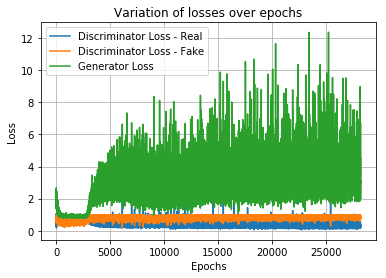

28201 [D loss: 0.408313, acc.: 75.00%] [G loss: 2.165422]
28202 [D loss: 0.345721, acc.: 84.38%] [G loss: 3.492740]
28203 [D loss: 0.267449, acc.: 93.75%] [G loss: 3.566243]
28204 [D loss: 0.406959, acc.: 87.50%] [G loss: 3.611936]
28205 [D loss: 0.230804, acc.: 93.75%] [G loss: 3.032808]
28206 [D loss: 0.353386, acc.: 84.38%] [G loss: 3.323160]
28207 [D loss: 0.316195, acc.: 84.38%] [G loss: 3.797318]
28208 [D loss: 0.417793, acc.: 75.00%] [G loss: 3.089144]
28209 [D loss: 0.375771, acc.: 84.38%] [G loss: 4.535102]
28210 [D loss: 0.067774, acc.: 96.88%] [G loss: 4.495173]
28211 [D loss: 0.385838, acc.: 81.25%] [G loss: 4.490067]
28212 [D loss: 0.282811, acc.: 90.62%] [G loss: 3.278654]
28213 [D loss: 0.769283, acc.: 71.88%] [G loss: 3.603345]
28214 [D loss: 0.332518, acc.: 84.38%] [G loss: 3.768246]
28215 [D loss: 0.260132, acc.: 90.62%] [G loss: 3.099583]
28216 [D loss: 0.318830, acc.: 84.38%] [G loss: 2.729621]
28217 [D loss: 0.253248, acc.: 90.62%] [G loss: 3.046752]
28218 [D loss:

28344 [D loss: 0.681556, acc.: 68.75%] [G loss: 3.342263]
28345 [D loss: 0.371480, acc.: 93.75%] [G loss: 3.921224]
28346 [D loss: 0.343087, acc.: 81.25%] [G loss: 3.064470]
28347 [D loss: 0.348243, acc.: 87.50%] [G loss: 3.404639]
28348 [D loss: 0.543886, acc.: 78.12%] [G loss: 3.868225]
28349 [D loss: 0.443444, acc.: 78.12%] [G loss: 4.389018]
28350 [D loss: 0.284541, acc.: 93.75%] [G loss: 2.961357]
28351 [D loss: 0.470291, acc.: 75.00%] [G loss: 2.821580]
28352 [D loss: 0.185573, acc.: 96.88%] [G loss: 4.308101]
28353 [D loss: 0.483585, acc.: 78.12%] [G loss: 2.994269]
28354 [D loss: 0.242952, acc.: 90.62%] [G loss: 3.286184]
28355 [D loss: 0.274146, acc.: 90.62%] [G loss: 2.415730]
28356 [D loss: 0.382329, acc.: 81.25%] [G loss: 3.211356]
28357 [D loss: 0.408716, acc.: 84.38%] [G loss: 3.322064]
28358 [D loss: 0.380274, acc.: 78.12%] [G loss: 3.627180]
28359 [D loss: 0.403810, acc.: 78.12%] [G loss: 3.088428]
28360 [D loss: 0.265612, acc.: 87.50%] [G loss: 3.436652]
28361 [D loss:

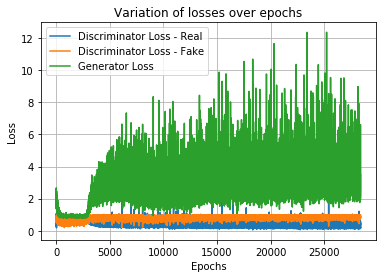

28401 [D loss: 0.405828, acc.: 81.25%] [G loss: 3.758661]
28402 [D loss: 0.181167, acc.: 90.62%] [G loss: 2.824333]
28403 [D loss: 0.219308, acc.: 93.75%] [G loss: 3.115006]
28404 [D loss: 0.408409, acc.: 81.25%] [G loss: 2.691907]
28405 [D loss: 0.221691, acc.: 96.88%] [G loss: 3.060373]
28406 [D loss: 0.141255, acc.: 93.75%] [G loss: 3.183807]
28407 [D loss: 0.202474, acc.: 93.75%] [G loss: 2.678947]
28408 [D loss: 0.391340, acc.: 81.25%] [G loss: 2.962610]
28409 [D loss: 0.139796, acc.: 93.75%] [G loss: 3.689461]
28410 [D loss: 0.235303, acc.: 87.50%] [G loss: 4.253663]
28411 [D loss: 0.268927, acc.: 90.62%] [G loss: 3.053098]
28412 [D loss: 0.099318, acc.: 100.00%] [G loss: 3.532454]
28413 [D loss: 0.206966, acc.: 93.75%] [G loss: 2.537360]
28414 [D loss: 0.405479, acc.: 78.12%] [G loss: 2.936099]
28415 [D loss: 0.464191, acc.: 81.25%] [G loss: 2.768727]
28416 [D loss: 0.384023, acc.: 78.12%] [G loss: 4.243691]
28417 [D loss: 0.521379, acc.: 81.25%] [G loss: 2.836422]
28418 [D loss

28543 [D loss: 0.254655, acc.: 87.50%] [G loss: 3.978196]
28544 [D loss: 0.291124, acc.: 87.50%] [G loss: 3.053813]
28545 [D loss: 0.257081, acc.: 87.50%] [G loss: 3.188290]
28546 [D loss: 0.374610, acc.: 93.75%] [G loss: 3.285412]
28547 [D loss: 0.269563, acc.: 90.62%] [G loss: 4.219745]
28548 [D loss: 0.369165, acc.: 84.38%] [G loss: 4.137126]
28549 [D loss: 0.163961, acc.: 96.88%] [G loss: 4.236025]
28550 [D loss: 0.245680, acc.: 90.62%] [G loss: 4.576162]
28551 [D loss: 0.297196, acc.: 81.25%] [G loss: 4.867518]
28552 [D loss: 0.260255, acc.: 90.62%] [G loss: 3.764716]
28553 [D loss: 0.444374, acc.: 84.38%] [G loss: 3.526364]
28554 [D loss: 0.378383, acc.: 78.12%] [G loss: 3.209949]
28555 [D loss: 0.338622, acc.: 81.25%] [G loss: 5.562080]
28556 [D loss: 0.715790, acc.: 68.75%] [G loss: 2.264129]
28557 [D loss: 0.189756, acc.: 90.62%] [G loss: 4.753645]
28558 [D loss: 0.399243, acc.: 78.12%] [G loss: 3.231611]
28559 [D loss: 0.350756, acc.: 87.50%] [G loss: 2.415565]
28560 [D loss:

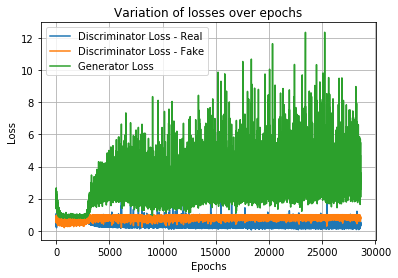

28601 [D loss: 0.466129, acc.: 75.00%] [G loss: 3.263608]
28602 [D loss: 0.339556, acc.: 90.62%] [G loss: 2.232176]
28603 [D loss: 0.304290, acc.: 90.62%] [G loss: 2.326551]
28604 [D loss: 0.422821, acc.: 78.12%] [G loss: 2.311497]
28605 [D loss: 0.298331, acc.: 84.38%] [G loss: 3.379276]
28606 [D loss: 0.291023, acc.: 84.38%] [G loss: 4.817879]
28607 [D loss: 0.229042, acc.: 93.75%] [G loss: 2.510823]
28608 [D loss: 0.473762, acc.: 75.00%] [G loss: 5.773348]
28609 [D loss: 0.209020, acc.: 93.75%] [G loss: 3.868451]
28610 [D loss: 0.397690, acc.: 78.12%] [G loss: 3.002152]
28611 [D loss: 0.135712, acc.: 93.75%] [G loss: 5.765954]
28612 [D loss: 0.183875, acc.: 96.88%] [G loss: 3.700822]
28613 [D loss: 0.383624, acc.: 87.50%] [G loss: 3.687083]
28614 [D loss: 0.185534, acc.: 90.62%] [G loss: 3.601972]
28615 [D loss: 0.364338, acc.: 84.38%] [G loss: 4.993749]
28616 [D loss: 0.273290, acc.: 93.75%] [G loss: 3.204390]
28617 [D loss: 0.417235, acc.: 84.38%] [G loss: 4.702048]
28618 [D loss:

28744 [D loss: 0.267475, acc.: 90.62%] [G loss: 2.725321]
28745 [D loss: 0.268653, acc.: 87.50%] [G loss: 3.277596]
28746 [D loss: 0.370370, acc.: 81.25%] [G loss: 2.675725]
28747 [D loss: 0.341832, acc.: 84.38%] [G loss: 3.540152]
28748 [D loss: 0.390436, acc.: 78.12%] [G loss: 2.904393]
28749 [D loss: 0.490612, acc.: 75.00%] [G loss: 3.902594]
28750 [D loss: 0.371037, acc.: 93.75%] [G loss: 2.704976]
28751 [D loss: 0.246713, acc.: 90.62%] [G loss: 3.565085]
28752 [D loss: 0.271928, acc.: 84.38%] [G loss: 3.293622]
28753 [D loss: 0.430081, acc.: 81.25%] [G loss: 5.119462]
28754 [D loss: 0.334567, acc.: 87.50%] [G loss: 4.326722]
28755 [D loss: 0.615835, acc.: 81.25%] [G loss: 2.805195]
28756 [D loss: 0.175872, acc.: 96.88%] [G loss: 3.881320]
28757 [D loss: 0.172746, acc.: 93.75%] [G loss: 2.954593]
28758 [D loss: 0.299794, acc.: 87.50%] [G loss: 3.027847]
28759 [D loss: 0.406530, acc.: 84.38%] [G loss: 4.673970]
28760 [D loss: 0.296747, acc.: 84.38%] [G loss: 4.379377]
28761 [D loss:

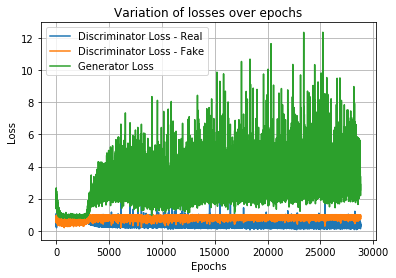

28801 [D loss: 0.340785, acc.: 84.38%] [G loss: 2.681057]
28802 [D loss: 0.509043, acc.: 75.00%] [G loss: 4.041935]
28803 [D loss: 0.252710, acc.: 90.62%] [G loss: 3.360842]
28804 [D loss: 0.624469, acc.: 68.75%] [G loss: 3.022189]
28805 [D loss: 0.189010, acc.: 93.75%] [G loss: 3.479257]
28806 [D loss: 0.199587, acc.: 90.62%] [G loss: 2.514782]
28807 [D loss: 0.210644, acc.: 90.62%] [G loss: 4.291613]
28808 [D loss: 0.251480, acc.: 87.50%] [G loss: 3.514767]
28809 [D loss: 0.209275, acc.: 93.75%] [G loss: 3.417537]
28810 [D loss: 0.399884, acc.: 75.00%] [G loss: 2.392600]
28811 [D loss: 0.133209, acc.: 96.88%] [G loss: 2.626031]
28812 [D loss: 0.221110, acc.: 96.88%] [G loss: 2.391693]
28813 [D loss: 0.351994, acc.: 81.25%] [G loss: 3.219941]
28814 [D loss: 0.177080, acc.: 100.00%] [G loss: 3.497578]
28815 [D loss: 0.428661, acc.: 75.00%] [G loss: 3.463571]
28816 [D loss: 0.305437, acc.: 87.50%] [G loss: 2.890720]
28817 [D loss: 0.205160, acc.: 93.75%] [G loss: 2.501647]
28818 [D loss

28943 [D loss: 0.178167, acc.: 93.75%] [G loss: 2.062586]
28944 [D loss: 0.370988, acc.: 84.38%] [G loss: 2.746852]
28945 [D loss: 0.233687, acc.: 90.62%] [G loss: 3.458674]
28946 [D loss: 0.351376, acc.: 78.12%] [G loss: 3.596633]
28947 [D loss: 0.432353, acc.: 81.25%] [G loss: 2.602521]
28948 [D loss: 0.341891, acc.: 87.50%] [G loss: 3.370108]
28949 [D loss: 0.350868, acc.: 81.25%] [G loss: 2.618244]
28950 [D loss: 0.324222, acc.: 93.75%] [G loss: 2.845520]
28951 [D loss: 0.391062, acc.: 84.38%] [G loss: 3.854902]
28952 [D loss: 0.471837, acc.: 78.12%] [G loss: 2.544687]
28953 [D loss: 0.160270, acc.: 90.62%] [G loss: 3.948668]
28954 [D loss: 0.310080, acc.: 84.38%] [G loss: 2.668590]
28955 [D loss: 0.276764, acc.: 90.62%] [G loss: 3.362654]
28956 [D loss: 0.339614, acc.: 81.25%] [G loss: 2.808418]
28957 [D loss: 0.109003, acc.: 100.00%] [G loss: 2.887702]
28958 [D loss: 0.287254, acc.: 87.50%] [G loss: 3.616153]
28959 [D loss: 0.314697, acc.: 87.50%] [G loss: 3.110197]
28960 [D loss

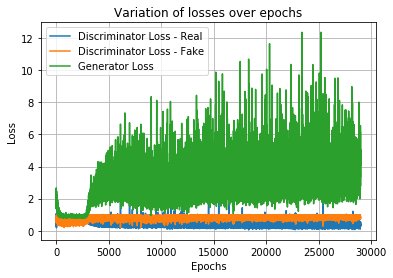

29001 [D loss: 0.360121, acc.: 84.38%] [G loss: 3.336382]
29002 [D loss: 0.250098, acc.: 90.62%] [G loss: 4.534501]
29003 [D loss: 0.098403, acc.: 96.88%] [G loss: 3.796825]
29004 [D loss: 0.183082, acc.: 93.75%] [G loss: 3.181149]
29005 [D loss: 0.280119, acc.: 87.50%] [G loss: 2.757071]
29006 [D loss: 0.289473, acc.: 84.38%] [G loss: 3.963696]
29007 [D loss: 0.243216, acc.: 84.38%] [G loss: 3.187706]
29008 [D loss: 0.388237, acc.: 78.12%] [G loss: 2.363661]
29009 [D loss: 0.307395, acc.: 84.38%] [G loss: 3.855946]
29010 [D loss: 0.386570, acc.: 87.50%] [G loss: 2.918022]
29011 [D loss: 0.291015, acc.: 87.50%] [G loss: 2.404389]
29012 [D loss: 0.232354, acc.: 90.62%] [G loss: 3.459270]
29013 [D loss: 0.259905, acc.: 87.50%] [G loss: 3.181251]
29014 [D loss: 0.374346, acc.: 81.25%] [G loss: 4.065336]
29015 [D loss: 0.251781, acc.: 87.50%] [G loss: 3.562314]
29016 [D loss: 0.399534, acc.: 81.25%] [G loss: 3.682519]
29017 [D loss: 0.265420, acc.: 87.50%] [G loss: 4.144324]
29018 [D loss:

29143 [D loss: 0.457024, acc.: 71.88%] [G loss: 3.178121]
29144 [D loss: 0.281841, acc.: 84.38%] [G loss: 2.888576]
29145 [D loss: 0.408450, acc.: 81.25%] [G loss: 3.627466]
29146 [D loss: 0.226187, acc.: 93.75%] [G loss: 4.194072]
29147 [D loss: 0.348855, acc.: 75.00%] [G loss: 6.424296]
29148 [D loss: 0.324135, acc.: 87.50%] [G loss: 3.704662]
29149 [D loss: 0.369005, acc.: 81.25%] [G loss: 4.991959]
29150 [D loss: 0.408043, acc.: 75.00%] [G loss: 2.737288]
29151 [D loss: 0.212078, acc.: 93.75%] [G loss: 3.426210]
29152 [D loss: 0.260484, acc.: 90.62%] [G loss: 5.118855]
29153 [D loss: 0.242585, acc.: 90.62%] [G loss: 5.157444]
29154 [D loss: 0.302182, acc.: 90.62%] [G loss: 5.312984]
29155 [D loss: 0.484609, acc.: 68.75%] [G loss: 5.239896]
29156 [D loss: 0.263298, acc.: 90.62%] [G loss: 4.752241]
29157 [D loss: 0.328642, acc.: 84.38%] [G loss: 2.666626]
29158 [D loss: 0.244781, acc.: 90.62%] [G loss: 3.099492]
29159 [D loss: 0.202153, acc.: 87.50%] [G loss: 3.441443]
29160 [D loss:

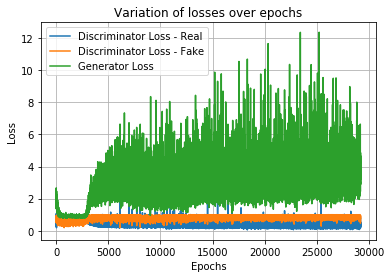

29201 [D loss: 0.290596, acc.: 87.50%] [G loss: 3.007507]
29202 [D loss: 0.311676, acc.: 84.38%] [G loss: 2.445876]
29203 [D loss: 0.141092, acc.: 100.00%] [G loss: 2.648490]
29204 [D loss: 0.331841, acc.: 87.50%] [G loss: 2.194312]
29205 [D loss: 0.370634, acc.: 81.25%] [G loss: 2.672377]
29206 [D loss: 0.405291, acc.: 75.00%] [G loss: 2.312037]
29207 [D loss: 0.231588, acc.: 93.75%] [G loss: 2.768287]
29208 [D loss: 0.402285, acc.: 71.88%] [G loss: 2.998299]
29209 [D loss: 0.248773, acc.: 96.88%] [G loss: 3.526628]
29210 [D loss: 0.342768, acc.: 84.38%] [G loss: 2.473858]
29211 [D loss: 0.198668, acc.: 90.62%] [G loss: 4.678503]
29212 [D loss: 0.451552, acc.: 75.00%] [G loss: 2.332233]
29213 [D loss: 0.423494, acc.: 84.38%] [G loss: 2.364963]
29214 [D loss: 0.406838, acc.: 81.25%] [G loss: 3.274661]
29215 [D loss: 0.357638, acc.: 84.38%] [G loss: 2.498502]
29216 [D loss: 0.480665, acc.: 81.25%] [G loss: 3.316146]
29217 [D loss: 0.260556, acc.: 87.50%] [G loss: 2.908027]
29218 [D loss

29343 [D loss: 0.237921, acc.: 93.75%] [G loss: 3.621054]
29344 [D loss: 0.285753, acc.: 90.62%] [G loss: 2.557854]
29345 [D loss: 0.330960, acc.: 87.50%] [G loss: 3.323667]
29346 [D loss: 0.268689, acc.: 90.62%] [G loss: 3.154927]
29347 [D loss: 0.246971, acc.: 93.75%] [G loss: 2.902939]
29348 [D loss: 0.262552, acc.: 93.75%] [G loss: 3.116248]
29349 [D loss: 0.276622, acc.: 87.50%] [G loss: 2.942344]
29350 [D loss: 0.130429, acc.: 96.88%] [G loss: 4.791457]
29351 [D loss: 0.423765, acc.: 75.00%] [G loss: 3.747787]
29352 [D loss: 0.272538, acc.: 87.50%] [G loss: 2.737816]
29353 [D loss: 0.137094, acc.: 93.75%] [G loss: 2.283561]
29354 [D loss: 0.232856, acc.: 90.62%] [G loss: 2.092323]
29355 [D loss: 0.374476, acc.: 87.50%] [G loss: 3.407830]
29356 [D loss: 0.279065, acc.: 90.62%] [G loss: 2.822829]
29357 [D loss: 0.234207, acc.: 93.75%] [G loss: 2.968970]
29358 [D loss: 0.183993, acc.: 93.75%] [G loss: 3.822079]
29359 [D loss: 0.365376, acc.: 84.38%] [G loss: 4.341291]
29360 [D loss:

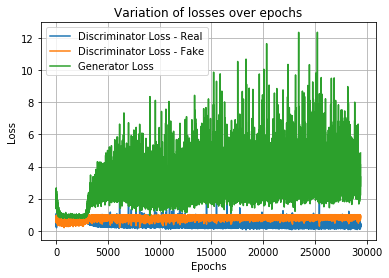

29401 [D loss: 0.215070, acc.: 87.50%] [G loss: 3.810409]
29402 [D loss: 0.155410, acc.: 96.88%] [G loss: 2.845582]
29403 [D loss: 0.355785, acc.: 75.00%] [G loss: 4.160857]
29404 [D loss: 0.290537, acc.: 90.62%] [G loss: 3.095310]
29405 [D loss: 0.156190, acc.: 93.75%] [G loss: 4.544649]
29406 [D loss: 0.204743, acc.: 90.62%] [G loss: 3.522722]
29407 [D loss: 0.419447, acc.: 81.25%] [G loss: 2.209404]
29408 [D loss: 0.280546, acc.: 90.62%] [G loss: 2.811480]
29409 [D loss: 0.347642, acc.: 84.38%] [G loss: 2.986786]
29410 [D loss: 0.209942, acc.: 87.50%] [G loss: 2.642793]
29411 [D loss: 0.457674, acc.: 75.00%] [G loss: 3.717629]
29412 [D loss: 0.347068, acc.: 75.00%] [G loss: 3.220510]
29413 [D loss: 0.332038, acc.: 78.12%] [G loss: 2.536800]
29414 [D loss: 0.317817, acc.: 87.50%] [G loss: 2.328615]
29415 [D loss: 0.583419, acc.: 75.00%] [G loss: 2.984638]
29416 [D loss: 0.195073, acc.: 90.62%] [G loss: 2.473440]
29417 [D loss: 0.268571, acc.: 81.25%] [G loss: 2.948247]
29418 [D loss:

29543 [D loss: 0.394310, acc.: 81.25%] [G loss: 3.222137]
29544 [D loss: 0.302292, acc.: 87.50%] [G loss: 3.444873]
29545 [D loss: 0.464212, acc.: 71.88%] [G loss: 3.053372]
29546 [D loss: 0.342855, acc.: 78.12%] [G loss: 2.544698]
29547 [D loss: 0.521717, acc.: 78.12%] [G loss: 8.052973]
29548 [D loss: 0.473848, acc.: 68.75%] [G loss: 4.380309]
29549 [D loss: 0.623045, acc.: 75.00%] [G loss: 4.505803]
29550 [D loss: 0.233124, acc.: 84.38%] [G loss: 6.523031]
29551 [D loss: 0.434798, acc.: 75.00%] [G loss: 3.642956]
29552 [D loss: 0.350464, acc.: 90.62%] [G loss: 4.652251]
29553 [D loss: 0.387936, acc.: 78.12%] [G loss: 4.829543]
29554 [D loss: 0.554014, acc.: 75.00%] [G loss: 4.214613]
29555 [D loss: 0.306685, acc.: 84.38%] [G loss: 3.360449]
29556 [D loss: 0.268297, acc.: 90.62%] [G loss: 3.717321]
29557 [D loss: 0.316684, acc.: 90.62%] [G loss: 3.326604]
29558 [D loss: 0.173873, acc.: 93.75%] [G loss: 4.536760]
29559 [D loss: 0.244745, acc.: 90.62%] [G loss: 3.458330]
29560 [D loss:

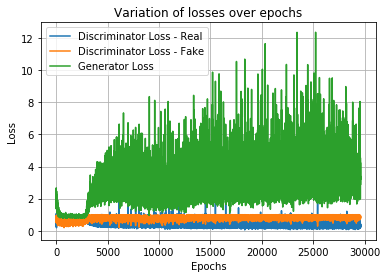

29601 [D loss: 0.318150, acc.: 93.75%] [G loss: 2.671278]
29602 [D loss: 0.205205, acc.: 93.75%] [G loss: 5.814936]
29603 [D loss: 0.232465, acc.: 84.38%] [G loss: 2.711878]
29604 [D loss: 0.255882, acc.: 90.62%] [G loss: 3.652814]
29605 [D loss: 0.242360, acc.: 93.75%] [G loss: 3.318731]
29606 [D loss: 0.260564, acc.: 90.62%] [G loss: 2.970289]
29607 [D loss: 0.306675, acc.: 84.38%] [G loss: 2.318658]
29608 [D loss: 0.228411, acc.: 93.75%] [G loss: 3.989592]
29609 [D loss: 0.321106, acc.: 87.50%] [G loss: 3.413842]
29610 [D loss: 0.317977, acc.: 81.25%] [G loss: 3.485755]
29611 [D loss: 0.213245, acc.: 90.62%] [G loss: 2.130458]
29612 [D loss: 0.267737, acc.: 84.38%] [G loss: 3.276451]
29613 [D loss: 0.220690, acc.: 93.75%] [G loss: 2.969004]
29614 [D loss: 0.437792, acc.: 81.25%] [G loss: 3.392526]
29615 [D loss: 0.390090, acc.: 78.12%] [G loss: 3.643154]
29616 [D loss: 0.581885, acc.: 65.62%] [G loss: 2.981255]
29617 [D loss: 0.312523, acc.: 87.50%] [G loss: 3.883225]
29618 [D loss:

29743 [D loss: 0.236217, acc.: 90.62%] [G loss: 2.948736]
29744 [D loss: 0.345799, acc.: 81.25%] [G loss: 2.513866]
29745 [D loss: 0.140600, acc.: 96.88%] [G loss: 2.921461]
29746 [D loss: 0.258769, acc.: 90.62%] [G loss: 2.423756]
29747 [D loss: 0.358639, acc.: 87.50%] [G loss: 3.455889]
29748 [D loss: 0.268573, acc.: 87.50%] [G loss: 3.617301]
29749 [D loss: 0.259731, acc.: 93.75%] [G loss: 2.747170]
29750 [D loss: 0.494123, acc.: 71.88%] [G loss: 3.215640]
29751 [D loss: 0.317641, acc.: 90.62%] [G loss: 2.905084]
29752 [D loss: 0.408899, acc.: 84.38%] [G loss: 3.840306]
29753 [D loss: 0.471821, acc.: 81.25%] [G loss: 7.196462]
29754 [D loss: 0.397134, acc.: 84.38%] [G loss: 3.249912]
29755 [D loss: 0.393692, acc.: 87.50%] [G loss: 4.454948]
29756 [D loss: 0.291647, acc.: 90.62%] [G loss: 1.548769]
29757 [D loss: 0.235158, acc.: 90.62%] [G loss: 5.794109]
29758 [D loss: 0.165763, acc.: 93.75%] [G loss: 4.540575]
29759 [D loss: 0.423508, acc.: 78.12%] [G loss: 2.724779]
29760 [D loss:

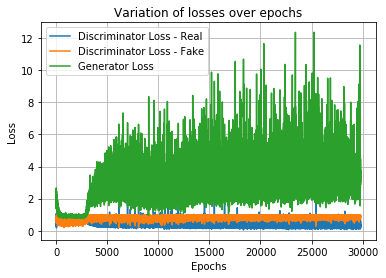

29801 [D loss: 0.249723, acc.: 87.50%] [G loss: 5.110564]
29802 [D loss: 0.214362, acc.: 87.50%] [G loss: 6.928658]
29803 [D loss: 0.138129, acc.: 93.75%] [G loss: 4.806211]
29804 [D loss: 0.303978, acc.: 78.12%] [G loss: 6.839537]
29805 [D loss: 0.381941, acc.: 84.38%] [G loss: 5.122886]
29806 [D loss: 0.066640, acc.: 96.88%] [G loss: 4.768344]
29807 [D loss: 0.129856, acc.: 93.75%] [G loss: 4.661978]
29808 [D loss: 0.299605, acc.: 90.62%] [G loss: 7.201221]
29809 [D loss: 0.214039, acc.: 90.62%] [G loss: 3.123422]
29810 [D loss: 0.694114, acc.: 71.88%] [G loss: 2.501282]
29811 [D loss: 0.650181, acc.: 81.25%] [G loss: 2.752739]
29812 [D loss: 0.321123, acc.: 90.62%] [G loss: 4.130075]
29813 [D loss: 0.428438, acc.: 84.38%] [G loss: 3.158962]
29814 [D loss: 0.275856, acc.: 93.75%] [G loss: 3.220129]
29815 [D loss: 0.346198, acc.: 87.50%] [G loss: 3.574020]
29816 [D loss: 0.275064, acc.: 87.50%] [G loss: 3.348166]
29817 [D loss: 0.419504, acc.: 84.38%] [G loss: 4.473975]
29818 [D loss:

29943 [D loss: 0.179203, acc.: 93.75%] [G loss: 3.525946]
29944 [D loss: 0.314270, acc.: 84.38%] [G loss: 3.562383]
29945 [D loss: 0.305953, acc.: 87.50%] [G loss: 2.810489]
29946 [D loss: 0.332757, acc.: 81.25%] [G loss: 3.075573]
29947 [D loss: 0.208463, acc.: 96.88%] [G loss: 3.441381]
29948 [D loss: 0.508911, acc.: 81.25%] [G loss: 3.025511]
29949 [D loss: 0.351091, acc.: 81.25%] [G loss: 2.920205]
29950 [D loss: 0.288361, acc.: 90.62%] [G loss: 3.607601]
29951 [D loss: 0.226309, acc.: 84.38%] [G loss: 3.417770]
29952 [D loss: 0.229695, acc.: 93.75%] [G loss: 3.486398]
29953 [D loss: 0.392924, acc.: 78.12%] [G loss: 2.741565]
29954 [D loss: 0.193075, acc.: 87.50%] [G loss: 3.637510]
29955 [D loss: 0.232098, acc.: 90.62%] [G loss: 3.471221]
29956 [D loss: 0.293332, acc.: 87.50%] [G loss: 3.736456]
29957 [D loss: 0.348440, acc.: 84.38%] [G loss: 3.177561]
29958 [D loss: 0.214848, acc.: 96.88%] [G loss: 2.864276]
29959 [D loss: 0.264344, acc.: 90.62%] [G loss: 4.290303]
29960 [D loss:

In [20]:
if __name__ == '__main__':
    train(epochs=30000, batch_size=32, save_interval=200)